# Imports

In [67]:
import numpy as np
import scipy.fftpack
from scipy.stats import entropy
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import ipywidgets as widgets
from IPython.display import display
!pip install plotly
!pip install ace-tools
import plotly.graph_objects as go # Import the plotly.graph_objects module
from scipy.signal import convolve2d
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import scipy.constants as const
from collections import defaultdict

# Mount Drive


In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# TTO Incidence Simuator

In [69]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_tto_graph_with_tail(n, origin_i, origin_j, current_offset, tail_offsets, next_offset, incidence_type='T'):
    """
    Draws an nxn grid with:
    - Origin node (origin_i, origin_j)
    - Current TTO node at offset from origin (current_offset)
    - Tail made of offsets from origin (list of (i, j) relative tuples)
    - Next node at offset from origin (next_offset)
    - Incidence structure drawn from the next node
    """

    # Compute absolute positions
    i_ref = origin_i + current_offset[0]
    j_ref = origin_j + current_offset[1]
    i_next = origin_i + next_offset[0]
    j_next = origin_j + next_offset[1]
    tail_abs = [(origin_i + i, origin_j + j) for (i, j) in tail_offsets]

    # Build grid graph and layout
    G = nx.grid_2d_graph(n, n)
    pos = {(i, j): (j, i) for i in range(n) for j in range(n)}  # SR-style: time up

    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw base grid
    nx.draw(G, pos, ax=ax, node_color='lightgray', node_size=100, edge_color='lightgray')

    # Draw origin
    if (origin_i, origin_j) in pos:
        nx.draw_networkx_nodes(G, pos, nodelist=[(origin_i, origin_j)], node_color='green', node_size=200, ax=ax)

    # Draw current TTO node
    if (i_ref, j_ref) in pos:
        nx.draw_networkx_nodes(G, pos, nodelist=[(i_ref, j_ref)], node_color='orange', node_size=300, ax=ax)

    # Draw tail nodes
    for node in tail_abs:
        if node in pos:
            nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='red', node_size=250, ax=ax)

    # Draw tail lines (snake style for now)
    for i in range(len(tail_abs) - 1):
        if tail_abs[i] in pos and tail_abs[i+1] in pos:
            ax.plot(
                [pos[tail_abs[i]][0], pos[tail_abs[i+1]][0]],
                [pos[tail_abs[i]][1], pos[tail_abs[i+1]][1]],
                color='black', linewidth=2
            )

    # Draw inertial line to next event
    if (i_next, j_next) in pos:
        ax.plot(
            [pos[(i_ref, j_ref)][0], pos[(i_next, j_next)][0]],
            [pos[(i_ref, j_ref)][1], pos[(i_next, j_next)][1]],
            color='black', linewidth=2, linestyle='dashed'
        )

    # Draw incidence structure from next node
    connections = []
    if incidence_type == 'T':
        connections = [
            ((i_next, j_next), (i_next+1, j_next)),
            ((i_next+1, j_next), (i_next+1, j_next-1)),
            ((i_next+1, j_next), (i_next+1, j_next+1))
        ]
    elif incidence_type == 'Y':
        connections = [
            ((i_next, j_next), (i_next+1, j_next)),
            ((i_next, j_next), (i_next, j_next+1))
        ]

    for (start, end) in connections:
        if start in pos and end in pos:
            ax.plot(
                [pos[start][0], pos[end][0]],
                [pos[start][1], pos[end][1]],
                color='blue', linewidth=2
            )

    ax.set_title(f"TTO Tile — Origin ({origin_i},{origin_j}), Current Offset {current_offset}, Tail Length: {len(tail_offsets)}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()


In [70]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_tto_graph_advanced(n, origin_i, origin_j, current_offset, last_offset, next_offset, incidence_type='T'):
    """
    Draws an nxn grid with:
    - Origin node (origin_i, origin_j)
    - Current TTO node at offset from origin (current_offset)
    - Last node at offset from origin (last_offset)
    - Next node at offset from origin (next_offset)
    - Incidence structure now drawn from the next node
    """

    # Convert relative offsets to absolute positions
    i_ref = origin_i + current_offset[0]
    j_ref = origin_j + current_offset[1]
    i_last = origin_i + last_offset[0]
    j_last = origin_j + last_offset[1]
    i_next = origin_i + next_offset[0]
    j_next = origin_j + next_offset[1]

    # Set up grid and layout
    G = nx.grid_2d_graph(n, n)
    pos = {(i, j): (j, i) for i in range(n) for j in range(n)}  # SR-style: time up, space right

    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw base grid
    nx.draw(G, pos, ax=ax, node_color='lightgray', node_size=100, edge_color='lightgray')

    # Draw origin node
    if (origin_i, origin_j) in pos:
        nx.draw_networkx_nodes(G, pos, nodelist=[(origin_i, origin_j)], node_color='green', node_size=200, ax=ax)

    # Draw current TTO node
    if (i_ref, j_ref) in pos:
        nx.draw_networkx_nodes(G, pos, nodelist=[(i_ref, j_ref)], node_color='orange', node_size=300, ax=ax)

    # Draw last event node
    if (i_last, j_last) in pos:
        nx.draw_networkx_nodes(G, pos, nodelist=[(i_last, j_last)], node_color='red', node_size=250, ax=ax)

    # Draw inertial tail to next event
    if (i_next, j_next) in pos:
        ax.plot(
            [pos[(i_ref, j_ref)][0], pos[(i_next, j_next)][0]],
            [pos[(i_ref, j_ref)][1], pos[(i_next, j_next)][1]],
            color='black', linewidth=2, label='Inertial Tail'
        )

    # Draw incidence structure from the NEXT node now
    connections = []
    if incidence_type == 'T':
        connections = [
            ((i_next, j_next), (i_next+1, j_next)),
            ((i_next+1, j_next), (i_next+1, j_next-1)),
            ((i_next+1, j_next), (i_next+1, j_next+1))
        ]
    elif incidence_type == 'Y':
        connections = [
            ((i_next, j_next), (i_next+1, j_next)),
            ((i_next, j_next), (i_next, j_next+1))
        ]

    for (start, end) in connections:
        if start in pos and end in pos:
            ax.plot(
                [pos[start][0], pos[end][0]],
                [pos[start][1], pos[end][1]],
                color='blue', linewidth=2
            )

    ax.set_title(f"TTO Tile — Origin ({origin_i},{origin_j}), Offset {current_offset}, Incidence '{incidence_type}' from Next")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()


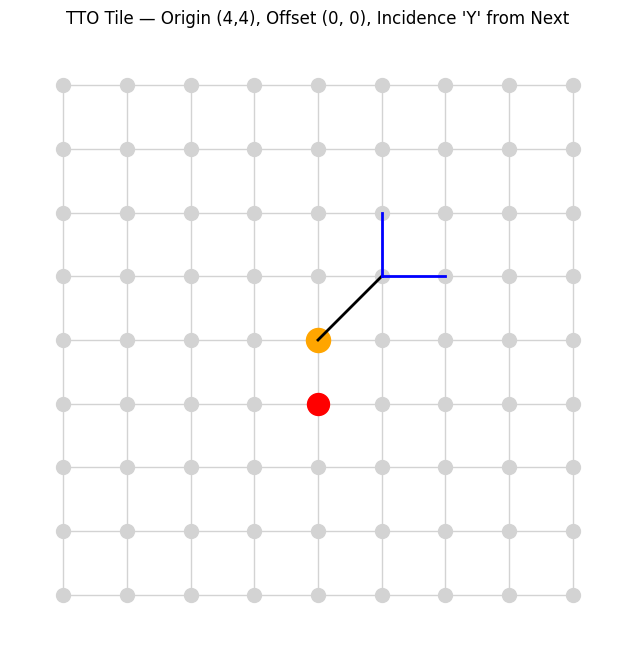

In [71]:
draw_tto_graph_advanced(
    n=9,
    origin_i=4, origin_j=4,
    current_offset=(0, 0),
    last_offset=(-1, 0),
    next_offset=(1, 1),
    incidence_type='Y'
)

# Back of the Envelope SM Study

In [72]:
import numpy as np
import pandas as pd
from scipy.constants import hbar, c, alpha, physical_constants, electron_mass

# GeV to kg conversion factor
gev_to_kg = 1.78266192e-27

# --- Particle masses (GeV/c^2) ---
particle_masses_gev = {
    'Up Quark': 0.00220,
    'Down Quark': 0.00470,
    'Strange Quark': 0.095,
    'Charm Quark': 1.27,
    'Bottom Quark': 4.18,
    'Top Quark': 173.0,
    'Electron': 0.000511,
    'Muon': 0.10566,
    'Tau': 1.7769,
    'Electron Neutrino': 1e-9,
    'Muon Neutrino': 0.00017,
    'Tau Neutrino': 0.0182,
    'Photon': 0.0,
    'Gluon': 0.0,
    'W Boson': 80.379,
    'Z Boson': 91.1876,
    'Higgs Boson': 125.25,
    'Proton': 0.93827,
    'Neutron': 0.93957,
    'Pion (π⁺)': 0.13957,
    'Kaon (K⁺)': 0.49368,
    # Optional reference anchors
    'Hydrogen Atom': 0.93827 + 0.000511,
    'Helium-4 Nucleus': 3.7274
}

# --- Metadata ---
metadata = {
    'Up Quark':        ('Quark', 'First', 1/2, +2/3, 'Hadronic', 'Bound'),
    'Down Quark':      ('Quark', 'First', 1/2, -1/3, 'Hadronic', 'Bound'),
    'Strange Quark':   ('Quark', 'Second', 1/2, -1/3, 'Hadronic', 'Bound'),
    'Charm Quark':     ('Quark', 'Second', 1/2, +2/3, 'Hadronic', 'Bound'),
    'Bottom Quark':    ('Quark', 'Third', 1/2, -1/3, 'Hadronic', 'Bound'),
    'Top Quark':       ('Quark', 'Third', 1/2, +2/3, 'Hadronic', 'Free'),
    'Electron':        ('Lepton', 'First', 1/2, -1, 'Atomic', 'Bound'),
    'Muon':            ('Lepton', 'Second', 1/2, -1, 'Cosmic', 'Free'),
    'Tau':             ('Lepton', 'Third', 1/2, -1, 'High-Energy', 'Free'),
    'Electron Neutrino': ('Lepton', 'First', 1/2, 0, 'Cosmic', 'Free'),
    'Muon Neutrino':     ('Lepton', 'Second', 1/2, 0, 'Cosmic', 'Free'),
    'Tau Neutrino':      ('Lepton', 'Third', 1/2, 0, 'Cosmic', 'Free'),
    'Photon':          ('Boson', 'N/A', 1, 0, 'Electromagnetic', 'Free'),
    'Gluon':           ('Boson', 'N/A', 1, 0, 'Strong', 'Free'),
    'W Boson':         ('Boson', 'N/A', 1, +1, 'Weak', 'Free'),
    'Z Boson':         ('Boson', 'N/A', 1, 0, 'Weak', 'Free'),
    'Higgs Boson':     ('Boson', 'N/A', 0, 0, 'Mass-Giving', 'Free'),
    'Proton':          ('Composite', 'N/A', 1/2, +1, 'Atomic', 'Bound'),
    'Neutron':         ('Composite', 'N/A', 1/2, 0, 'Atomic', 'Bound'),
    'Pion (π⁺)':       ('Meson', 'N/A', 0, +1, 'Hadronic', 'Bound'),
    'Kaon (K⁺)':       ('Meson', 'N/A', 0, +1, 'Hadronic', 'Bound'),
    'Hydrogen Atom':   ('Composite', 'N/A', 1/2, 0, 'Atomic', 'Bound'),
    'Helium-4 Nucleus':('Composite', 'N/A', 0, 0, 'Nuclear', 'Bound')
}

# --- Computation ---
rows = []
for name, mass_gev in particle_masses_gev.items():
    mass_kg = mass_gev * gev_to_kg
    log_mass_kg = np.log10(mass_kg) if mass_kg > 0 else np.nan
    k_val = (mass_kg * c) / (alpha * hbar)
    log_k = np.log10(k_val) if k_val > 0 else np.nan
    mass_gev_per_alpha = mass_gev / alpha
    mass_kg_per_alpha = mass_kg / alpha

    # Alpha multiple projection
    if mass_gev > alpha:
        n_alpha = np.round(mass_gev / alpha)
        alpha_fit = n_alpha * alpha
        delta = np.abs(mass_gev - alpha_fit)
        percent_error = 100 * delta / alpha_fit
    else:
        n_alpha = np.round((mass_gev / alpha) * 100) / 100
        alpha_fit = n_alpha * alpha
        delta = np.abs(mass_gev - alpha_fit)
        delta_alphas = delta / alpha
        percent_error = 100 * delta / alpha_fit if alpha_fit > 0 else np.nan

    # Metadata
    type_, family, spin, charge, epoch, binding = metadata.get(name, ('?', '?', '?', '?', '?', '?'))

    rows.append({
        'Name': name,
        'Mass_GeV': mass_gev,
        'Mass_kg': mass_kg,
        'Log10(Mass_kg)': log_mass_kg,
        'Mass_GeV/α': mass_gev_per_alpha,
        'Mass_kg/α': mass_kg_per_alpha,
        'k': k_val,
        'log10(k)': log_k,
        'Spin': spin,
        'Charge': charge,
        'Family': family,
        'Type': type_,
        'Epoch': epoch,
        'Binding': binding,
        'Nearest α Mult': n_alpha,
        'n × α': alpha_fit,
        'ΔMass (GeV)': delta,
        'ΔMass (GeV)/a': delta_alphas,
        '% Error': percent_error
    })

df_particles = pd.DataFrame(rows)
df_particles.sort_values(by='log10(k)', inplace=True)

# Optional: format floats
pd.set_option('display.float_format', '{:.3e}'.format)

# Show a snapshot
display(df_particles)


Name  Mass_GeV   Mass_kg  Log10(Mass_kg)  Mass_GeV/α  \
9   Electron Neutrino 1.000e-09 1.783e-36      -3.575e+01   1.370e-07   
10      Muon Neutrino 1.700e-04 3.031e-31      -3.052e+01   2.330e-02   
6            Electron 5.110e-04 9.109e-31      -3.004e+01   7.003e-02   
0            Up Quark 2.200e-03 3.922e-30      -2.941e+01   3.015e-01   
1          Down Quark 4.700e-03 8.379e-30      -2.908e+01   6.441e-01   
11       Tau Neutrino 1.820e-02 3.244e-29      -2.849e+01   2.494e+00   
2       Strange Quark 9.500e-02 1.694e-28      -2.777e+01   1.302e+01   
7                Muon 1.057e-01 1.884e-28      -2.773e+01   1.448e+01   
19          Pion (π⁺) 1.396e-01 2.488e-28      -2.760e+01   1.913e+01   
20          Kaon (K⁺) 4.937e-01 8.801e-28      -2.706e+01   6.765e+01   
17             Proton 9.383e-01 1.673e-27      -2.678e+01   1.286e+02   
21      Hydrogen Atom 9.388e-01 1.674e-27      -2.678e+01   1.286e+02   
18            Neutron 9.396e-01 1.675e-27      -2.678e+01   1.288e+02   
3         Charm Quark 1.270e+00 2.264e-27      -2.665e+01   1.740e+02   
8                 Tau 1.777e+00 3.168e-27      -2.650e+01   2.435e+02   
22   Helium-4 Nucleus 3.727e+00 6.645e-27      -2.618e+01   5.108e+02   
4        Bottom Quark 4.180e+00 7.452e-27      -2.613e+01   5.728e+02   
14            W Boson 8.038e+01 1.433e-25      -2.484e+01   1.101e+04   
15            Z Boson 9.119e+01 1.626e-25      -2.479e+01   1.250e+04   
16        Higgs Boson 1.252e+02 2.233e-25      -2.465e+01   1.716e+04   
5           Top Quark 1.730e+02 3.084e-25      -2.451e+01   2.371e+04   
12             Photon 0.000e+00 0.000e+00             NaN   0.000e+00   
13              Gluon 0.000e+00 0.000e+00             NaN   0.000e+00   

    Mass_kg/α         k  log10(k)      Spin     Charge  Family       Type  \
9   2.443e-34 6.945e+08 8.842e+00 5.000e-01  0.000e+00   First     Lepton   
10  4.153e-29 1.181e+14 1.407e+01 5.000e-01  0.000e+00  Second     Lepton   
6   1.248e-28 3.549e+14 1.455e+01 5.000e-01 -1.000e+00   First     Lepton   
0   5.374e-28 1.528e+15 1.518e+01 5.000e-01  6.667e-01   First      Quark   
1   1.148e-27 3.264e+15 1.551e+01 5.000e-01 -3.333e-01   First      Quark   
11  4.446e-27 1.264e+16 1.610e+01 5.000e-01  0.000e+00   Third     Lepton   
2   2.321e-26 6.597e+16 1.682e+01 5.000e-01 -3.333e-01  Second      Quark   
7   2.581e-26 7.338e+16 1.687e+01 5.000e-01 -1.000e+00  Second     Lepton   
19  3.410e-26 9.693e+16 1.699e+01 0.000e+00  1.000e+00     N/A      Meson   
20  1.206e-25 3.428e+17 1.754e+01 0.000e+00  1.000e+00     N/A      Meson   
17  2.292e-25 6.516e+17 1.781e+01 5.000e-01  1.000e+00     N/A  Composite   
21  2.293e-25 6.519e+17 1.781e+01 5.000e-01  0.000e+00     N/A  Composite   
18  2.295e-25 6.525e+17 1.781e+01 5.000e-01  0.000e+00     N/A  Composite   
3   3.102e-25 8.820e+17 1.795e+01 5.000e-01  6.667e-01  Second      Quark   
8   4.341e-25 1.234e+18 1.809e+01 5.000e-01 -1.000e+00   Third     Lepton   
22  9.106e-25 2.589e+18 1.841e+01 0.000e+00  0.000e+00     N/A  Composite   
4   1.021e-24 2.903e+18 1.846e+01 5.000e-01 -3.333e-01   Third      Quark   
14  1.964e-23 5.582e+19 1.975e+01 1.000e+00  1.000e+00     N/A      Boson   
15  2.228e-23 6.333e+19 1.980e+01 1.000e+00  0.000e+00     N/A      Boson   
16  3.060e-23 8.698e+19 1.994e+01 0.000e+00  0.000e+00     N/A      Boson   
5   4.226e-23 1.201e+20 2.008e+01 5.000e-01  6.667e-01   Third      Quark   
12  0.000e+00 0.000e+00       NaN 1.000e+00  0.000e+00     N/A      Boson   
13  0.000e+00 0.000e+00       NaN 1.000e+00  0.000e+00     N/A      Boson   

              Epoch Binding  Nearest α Mult     n × α  ΔMass (GeV)  \
9            Cosmic    Free       0.000e+00 0.000e+00    1.000e-09   
10           Cosmic    Free       2.000e-02 1.459e-04    2.405e-05   
6            Atomic   Bound       7.000e-02 5.108e-04    1.853e-07   
0          Hadronic   Bound       3.000e-01 2.189e-03    1.079e-05   
1          Hadronic   Bound       6.400e-01 4.670e-03    2.969e-0

In [73]:
# Assuming your GeV mass DataFrame is called `df_mass`

# List all available columns
#print("Available columns:")
#for col in df_particles.columns:
#    print(f"'{col}',")

# Select columns you want to display (comment out to hide)
columns_to_display = [
    'Name',
    'Mass_GeV',
    'Mass_GeV/α',
    'Nearest α Mult',
    'n × α',
    'ΔMass (GeV)',
    'ΔMass (GeV)/a',
    '% Error',
    # 'Mass_kg',
    # 'Log10(Mass_kg)',
    # 'Mass_kg/α',
    # 'k',
    # 'log10(k)',
    # 'Spin',
    # 'Charge',
    # 'Family',
    # 'Type',
    # 'Epoch',
    # 'Binding'
]

# Show trimmed table
df_particles_display = df_particles[columns_to_display]
display(df_particles_display)


Name  Mass_GeV  Mass_GeV/α  Nearest α Mult     n × α  \
9   Electron Neutrino 1.000e-09   1.370e-07       0.000e+00 0.000e+00   
10      Muon Neutrino 1.700e-04   2.330e-02       2.000e-02 1.459e-04   
6            Electron 5.110e-04   7.003e-02       7.000e-02 5.108e-04   
0            Up Quark 2.200e-03   3.015e-01       3.000e-01 2.189e-03   
1          Down Quark 4.700e-03   6.441e-01       6.400e-01 4.670e-03   
11       Tau Neutrino 1.820e-02   2.494e+00       2.000e+00 1.459e-02   
2       Strange Quark 9.500e-02   1.302e+01       1.300e+01 9.487e-02   
7                Muon 1.057e-01   1.448e+01       1.400e+01 1.022e-01   
19          Pion (π⁺) 1.396e-01   1.913e+01       1.900e+01 1.386e-01   
20          Kaon (K⁺) 4.937e-01   6.765e+01       6.800e+01 4.962e-01   
17             Proton 9.383e-01   1.286e+02       1.290e+02 9.414e-01   
21      Hydrogen Atom 9.388e-01   1.286e+02       1.290e+02 9.414e-01   
18            Neutron 9.396e-01   1.288e+02       1.290e+02 9.414e-01   
3         Charm Quark 1.270e+00   1.740e+02       1.740e+02 1.270e+00   
8                 Tau 1.777e+00   2.435e+02       2.430e+02 1.773e+00   
22   Helium-4 Nucleus 3.727e+00   5.108e+02       5.110e+02 3.729e+00   
4        Bottom Quark 4.180e+00   5.728e+02       5.730e+02 4.181e+00   
14            W Boson 8.038e+01   1.101e+04       1.102e+04 8.038e+01   
15            Z Boson 9.119e+01   1.250e+04       1.250e+04 9.119e+01   
16        Higgs Boson 1.252e+02   1.716e+04       1.716e+04 1.253e+02   
5           Top Quark 1.730e+02   2.371e+04       2.371e+04 1.730e+02   
12             Photon 0.000e+00   0.000e+00       0.000e+00 0.000e+00   
13              Gluon 0.000e+00   0.000e+00       0.000e+00 0.000e+00   

    ΔMass (GeV)  ΔMass (GeV)/a   % Error  
9     1.000e-09      1.370e-07       NaN  
10    2.405e-05      3.296e-03 1.648e+01  
6     1.853e-07      2.540e-05 3.628e-02  
0     1.079e-05      1.479e-03 4.931e-01  
1     2.969e-05      4.069e-03 6.358e-01  
11    3.605e-03      3.296e-03 2.470e+01  
2     1.344e-04      4.069e-03 1.417e-01  
7     3.497e-03      2.540e-05 3.423e+00  
19    9.203e-04      0.000e+00 6.638e-01  
20    2.540e-03      0.000e+00 5.119e-01  
17    3.088e-03      0.000e+00 3.281e-01  
21    2.577e-03      0.000e+00 2.738e-01  
18    1.788e-03      0.000e+00 1.900e-01  
3     2.607e-04      4.069e-03 2.053e-02  
8     3.643e-03      2.540e-05 2.055e-01  
22    1.547e-03      0.000e+00 4.149e-02  
4     1.383e-03      4.069e-03 3.308e-02  
14    1.338e-03      0.000e+00 1.665e-03  
15    1.176e-04      0.000e+00 1.290e-04  
16    1.759e-03      0.000e+00 1.405e-03  
5     1.663e-03      4.069e-03 9.611e-04  
12    0.000e+00      0.000e+00       NaN  
13    0.000e+00      0.000e+00       NaN

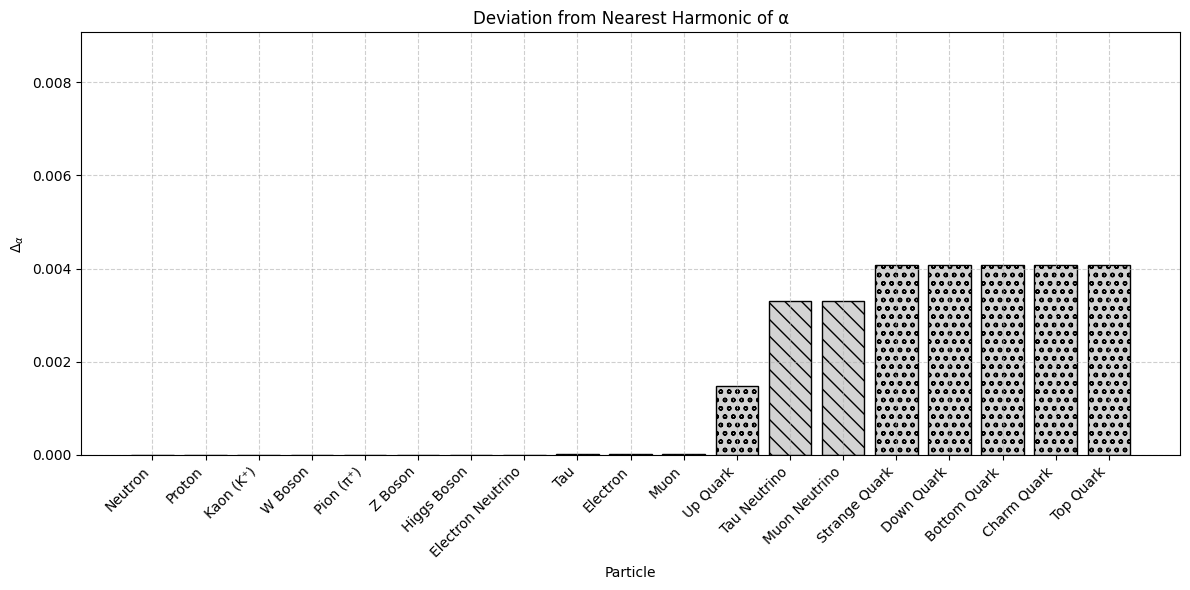

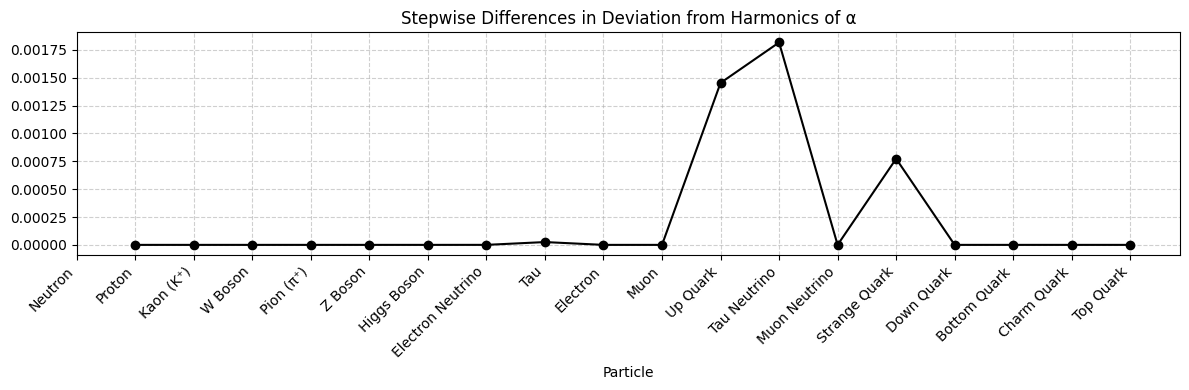

Plots and table exported! Ready for LaTeX.


In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Filtered Dataset ---
exclude_particles = ['Photon', 'Gluon', 'Hydrogen Atom', 'Helium-4 Nucleus']
df_filtered = df_particles[~df_particles['Name'].isin(exclude_particles)]
df_filtered = df_filtered[df_filtered['Mass_GeV'] > 0].dropna(subset=['ΔMass (GeV)/a'])

# Sort by ΔMass (GeV)/α
df_sorted = df_filtered.sort_values(by='ΔMass (GeV)/a').reset_index(drop=True)
df_sorted['Delta_Diff'] = df_sorted['ΔMass (GeV)/a'].diff()

# --- Hatching by Family ---
type_hatch = {
    'Quark': 'oo',
    'Lepton': '\\\\',
    'Boson': 'xx',
    'Meson': '--',
    'Composite': '//'
}
hatches = [type_hatch.get(type_, '') for type_ in df_sorted['Type']]

# --- Plot 1: Δα Bar Chart ---
fig, ax1 = plt.subplots(figsize=(12, 6))
bars = ax1.bar(df_sorted['Name'], df_sorted['ΔMass (GeV)/a'], color='lightgray', edgecolor='black')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax1.set_title('Deviation from Nearest Harmonic of α')
ax1.set_ylabel(r'$\Delta_\alpha$')
ax1.set_xlabel('Particle')
ax1.set_xticks(np.arange(len(df_sorted)))
ax1.set_xticklabels(df_sorted['Name'], rotation=45, ha='right')
ax1.set_ylim(0, df_sorted['ΔMass (GeV)/a'].max() + 0.005)
ax1.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Export Plot 1
plt.savefig('delta_alpha_barchart.png', dpi=300)

# --- Plot 2: Stepwise Differences ---
fig, ax2 = plt.subplots(figsize=(12, 4))
ax2.plot(df_sorted['Name'], df_sorted['Delta_Diff'], marker='o', linestyle='-', color='black')
ax2.set_title('Stepwise Differences in Deviation from Harmonics of α')
ax2.set_xlabel('Particle')
ax2.set_xticks(np.arange(len(df_sorted)))
ax2.set_xticklabels(df_sorted['Name'], rotation=45, ha='right')
ax2.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Export Plot 2
plt.savefig('delta_alpha_diffplot.png', dpi=300)

plt.show()

# --- Export Table for LaTeX ---
latex_table = df_sorted[['Name', 'ΔMass (GeV)/a', 'Type', 'Family']].copy()
latex_table['ΔMass (GeV)/a'] = latex_table['ΔMass (GeV)/a'].apply(lambda x: f'{x:.6f}')
latex_table.to_csv('delta_alpha_table.csv', index=False)

print("Plots and table exported! Ready for LaTeX.")


In [75]:
import pandas as pd
from scipy.constants import hbar, c, alpha, electron_mass, physical_constants

# Lepton rest masses in kg
lepton_masses_kg = {
    'Electron': electron_mass,
    'Muon': physical_constants['muon mass'][0],
    'Tau': physical_constants['tau mass'][0],
}

# Compute dimensionless scaling factor k = m * c / (alpha * hbar)
lepton_k_values = {
    name: (mass * c) / (alpha * hbar)
    for name, mass in lepton_masses_kg.items()
}

# Create table
df_leptons = pd.DataFrame({
    'Lepton': list(lepton_masses_kg.keys()),
    'Mass (kg)': list(lepton_masses_kg.values()),
    'k = (m * c) / (α * ħ)': [round(k, 3) for k in lepton_k_values.values()]
})

print(df_leptons)


     Lepton  Mass (kg)  k = (m * c) / (α * ħ)
0  Electron  9.109e-31              3.549e+14
1      Muon  1.884e-28              7.338e+16
2       Tau  3.168e-27              1.234e+18


In [76]:
import numpy as np
import pandas as pd
from scipy.constants import alpha, hbar, c

# GeV to kg conversion factor
gev_to_kg = 1.78266192e-27  # 1 GeV/c² in kg

# Particle masses in GeV/c^2
particle_masses_gev = {
    'Up Quark': 0.00220,
    'Down Quark': 0.00470,
    'Strange Quark': 0.095,
    'Charm Quark': 1.27,
    'Bottom Quark': 4.18,
    'Top Quark': 173.0,
    'Electron': 0.000511,
    'Muon': 0.10566,
    'Tau': 1.7769,
    'Electron Neutrino': 1e-9,
    'Muon Neutrino': 0.00017,
    'Tau Neutrino': 0.0182,
    'Photon': 0.0,
    'Gluon': 0.0,
    'W Boson': 80.379,
    'Z Boson': 91.1876,
    'Higgs Boson': 125.25,
    'Proton': 0.93827,
    'Neutron': 0.93957,
    'Pion (π⁺)': 0.13957,
    'Kaon (K⁺)': 0.49368
}

# Calculate k = (m * c) / (α * ħ)
particle_k_values = {
    name: ((mass * gev_to_kg) * c) / (alpha * hbar)
    for name, mass in particle_masses_gev.items()
}

# Create DataFrame
df_k_values = pd.DataFrame({
    'Particle': list(particle_masses_gev.keys()),
    'Mass (GeV)': list(particle_masses_gev.values()),
    'k = (m * c) / (α * ħ)': list(particle_k_values.values())
})

# Display nicely
df_k_values_sorted = df_k_values.sort_values(by='k = (m * c) / (α * ħ)', ascending=True).reset_index(drop=True)
pd.set_option('display.float_format', '{:.3e}'.format)
display(df_k_values_sorted)


Particle  Mass (GeV)  k = (m * c) / (α * ħ)
0              Photon   0.000e+00              0.000e+00
1               Gluon   0.000e+00              0.000e+00
2   Electron Neutrino   1.000e-09              6.945e+08
3       Muon Neutrino   1.700e-04              1.181e+14
4            Electron   5.110e-04              3.549e+14
5            Up Quark   2.200e-03              1.528e+15
6          Down Quark   4.700e-03              3.264e+15
7        Tau Neutrino   1.820e-02              1.264e+16
8       Strange Quark   9.500e-02              6.597e+16
9                Muon   1.057e-01              7.338e+16
10          Pion (π⁺)   1.396e-01              9.693e+16
11          Kaon (K⁺)   4.937e-01              3.428e+17
12             Proton   9.383e-01              6.516e+17
13            Neutron   9.396e-01              6.525e+17
14        Charm Quark   1.270e+00              8.820e+17
15                Tau   1.777e+00              1.234e+18
16       Bottom Quark   4.180e+00              2.903e+18
17            W Boson   8.038e+01              5.582e+19
18            Z Boson   9.119e+01              6.333e+19
19        Higgs Boson   1.252e+02              8.698e+19
20          Top Quark   1.730e+02              1.201e+20

In [77]:
import numpy as np
import pandas as pd
from scipy.constants import alpha, hbar, c

# GeV to kg conversion factor
gev_to_kg = 1.78266192e-27  # 1 GeV/c² in kg

# Particle masses in GeV/c^2
particle_masses_gev = {
    'Up Quark': 0.00220,
    'Down Quark': 0.00470,
    'Strange Quark': 0.095,
    'Charm Quark': 1.27,
    'Bottom Quark': 4.18,
    'Top Quark': 173.0,
    'Electron': 0.000511,
    'Muon': 0.10566,
    'Tau': 1.7769,
    #'Electron Neutrino': 1e-9,
    #'Muon Neutrino': 0.00017,
    #'Tau Neutrino': 0.0182,
    'Photon': 0.0,
    'Gluon': 0.0,
    'W Boson': 80.379,
    'Z Boson': 91.1876,
    'Higgs Boson': 125.25,
    'Proton': 0.93827,
    'Neutron': 0.93957,
    'Pion (π⁺)': 0.13957,
    'Kaon (K⁺)': 0.49368
}

# Convert GeV to kg
particle_masses_kg_from_gev = {
    name: mass * gev_to_kg
    for name, mass in particle_masses_gev.items()
}

# Calculate k using kg
k_from_kg = {
    name: (mass * c) / (alpha * hbar)
    for name, mass in particle_masses_kg_from_gev.items()
}

# Calculate k using GeV then convert to kg inline (same result)
k_from_gev = {
    name: ((mass * gev_to_kg) * c) / (alpha * hbar)
    for name, mass in particle_masses_gev.items()
}

# Combine results into a DataFrame
df_compare_k = pd.DataFrame({
    'Particle': list(particle_masses_gev.keys()),
    'Mass (GeV)': list(particle_masses_gev.values()),
    'k from GeV path': list(k_from_gev.values()),
    'k from kg path': [k_from_kg[name] for name in particle_masses_gev.keys()],
    #'Δk (abs diff)': [abs(k_from_gev[name] - k_from_kg[name]) for name in particle_masses_gev.keys()],
})

# Add log10(k) column
df_compare_k['log10(k)'] = np.log10(df_compare_k['k from kg path'].replace(0, np.nan))

# Display the result
df_compare_k_sorted = df_compare_k.sort_values(by='log10(k)').reset_index(drop=True)
pd.set_option('display.float_format', '{:.3e}'.format)
display(df_compare_k_sorted)


Particle  Mass (GeV)  k from GeV path  k from kg path  log10(k)
0        Electron   5.110e-04        3.549e+14       3.549e+14 1.455e+01
1        Up Quark   2.200e-03        1.528e+15       1.528e+15 1.518e+01
2      Down Quark   4.700e-03        3.264e+15       3.264e+15 1.551e+01
3   Strange Quark   9.500e-02        6.597e+16       6.597e+16 1.682e+01
4            Muon   1.057e-01        7.338e+16       7.338e+16 1.687e+01
5       Pion (π⁺)   1.396e-01        9.693e+16       9.693e+16 1.699e+01
6       Kaon (K⁺)   4.937e-01        3.428e+17       3.428e+17 1.754e+01
7          Proton   9.383e-01        6.516e+17       6.516e+17 1.781e+01
8         Neutron   9.396e-01        6.525e+17       6.525e+17 1.781e+01
9     Charm Quark   1.270e+00        8.820e+17       8.820e+17 1.795e+01
10            Tau   1.777e+00        1.234e+18       1.234e+18 1.809e+01
11   Bottom Quark   4.180e+00        2.903e+18       2.903e+18 1.846e+01
12        W Boson   8.038e+01        5.582e+19       5.582e+19 1.975e+01
13        Z Boson   9.119e+01        6.333e+19       6.333e+19 1.980e+01
14    Higgs Boson   1.252e+02        8.698e+19       8.698e+19 1.994e+01
15      Top Quark   1.730e+02        1.201e+20       1.201e+20 2.008e+01
16         Photon   0.000e+00        0.000e+00       0.000e+00       NaN
17          Gluon   0.000e+00        0.000e+00       0.000e+00       NaN

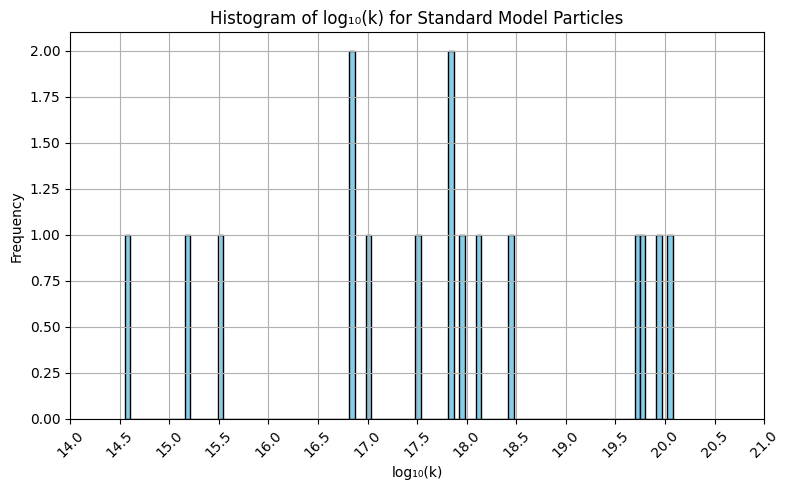

In [78]:
# Histogram with more x-axis tick labels
plt.figure(figsize=(8, 5))
logk_values = df_compare_k['log10(k)'].dropna()

plt.hist(logk_values, bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of log₁₀(k) for Standard Model Particles')
plt.xlabel('log₁₀(k)')
plt.ylabel('Frequency')
plt.grid(True)

# Custom x-tick spacing
min_tick = np.floor(logk_values.min())
max_tick = np.ceil(logk_values.max())
tick_spacing = 0.5  # Smaller value for more ticks
plt.xticks(np.arange(min_tick, max_tick + tick_spacing, tick_spacing),rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

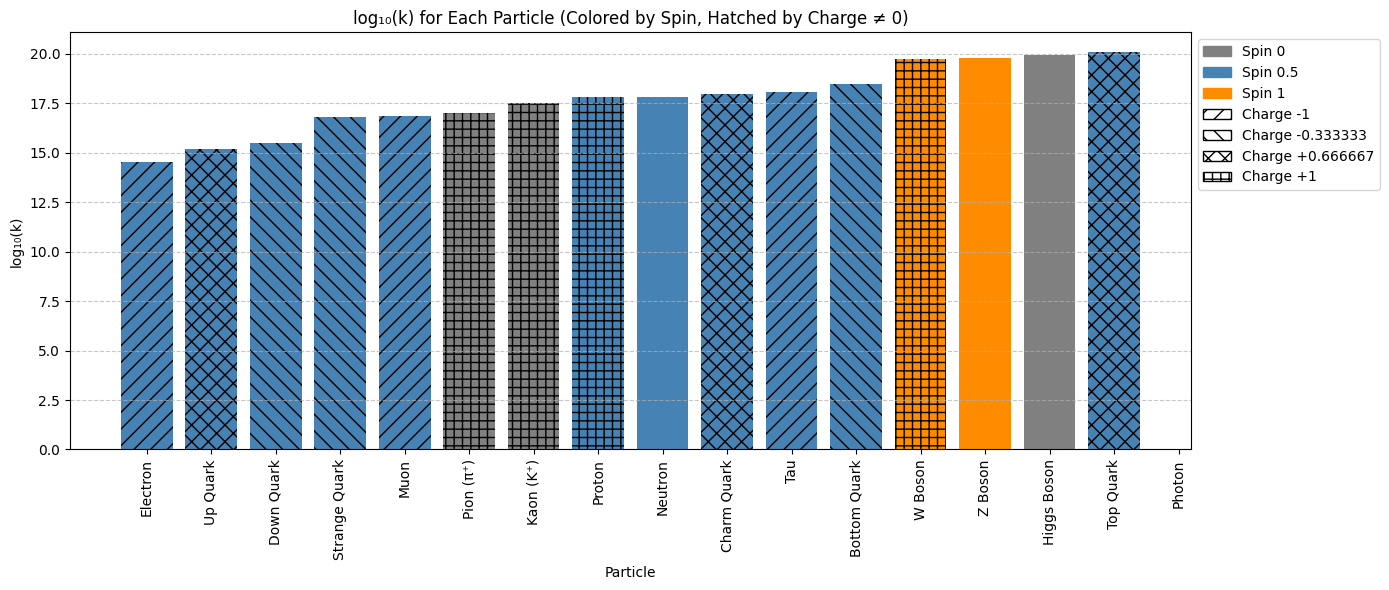

In [79]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- Define spin and charge metadata ---
particle_spin_charge = {
    'Up Quark':       (1/2,  +2/3),
    'Down Quark':     (1/2,  -1/3),
    'Strange Quark':  (1/2,  -1/3),
    'Charm Quark':    (1/2,  +2/3),
    'Bottom Quark':   (1/2,  -1/3),
    'Top Quark':      (1/2,  +2/3),
    'Electron':       (1/2,  -1),
    'Muon':           (1/2,  -1),
    'Tau':            (1/2,  -1),
    'Electron Neutrino': (1/2,  0),
    'Muon Neutrino':     (1/2,  0),
    'Tau Neutrino':      (1/2,  0),
    'Photon':         (1,     0),
    'Gluon':          (1,     0),
    'W Boson':        (1,    +1),
    'Z Boson':        (1,     0),
    'Higgs Boson':    (0,     0),
    'Proton':         (1/2,  +1),
    'Neutron':        (1/2,   0),
    'Pion (π⁺)':      (0,    +1),
    'Kaon (K⁺)':      (0,    +1),
}

# Sort the data for plotting
sorted_df = df_compare_k.sort_values(by='log10(k)', ascending=True).reset_index(drop=True)
spins = [particle_spin_charge[p][0] for p in sorted_df['Particle']]
charges = [particle_spin_charge[p][1] for p in sorted_df['Particle']]

# Color mapping by spin
spin_colors = {
    0: 'gray',          # Scalar
    1/2: 'steelblue',   # Fermion
    1: 'darkorange'     # Boson
}
colors = [spin_colors.get(s, 'black') for s in spins]

# Unique nonzero charges → hatching patterns
unique_nonzero_charges = sorted(set([q for q in charges if q != 0]))
hatch_styles = ['//', '\\\\', 'xx', '++', 'oo', '--', '||']
charge_to_hatch = {q: hatch_styles[i % len(hatch_styles)] for i, q in enumerate(unique_nonzero_charges)}

# Assign hatch or no hatch
hatches = [charge_to_hatch[q] if q != 0 else '' for q in charges]

# Plotting
plt.figure(figsize=(14, 6))
bars = plt.bar(sorted_df['Particle'], sorted_df['log10(k)'], color=colors)

# Apply hatch per charge
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

# Titles and formatting
plt.title('log₁₀(k) for Each Particle (Colored by Spin, Hatched by Charge ≠ 0)')
plt.xlabel('Particle')
plt.ylabel('log₁₀(k)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Construct legend
legend_patches = []
for spin_val, color in spin_colors.items():
    label = f'Spin {spin_val}'
    legend_patches.append(mpatches.Patch(color=color, label=label))

for charge, hatch in charge_to_hatch.items():
    label = f'Charge {charge:+g}'
    legend_patches.append(mpatches.Patch(facecolor='white', edgecolor='black', hatch=hatch, label=label))

plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [80]:
import numpy as np
import pandas as pd
from scipy.constants import alpha

# Particle masses in GeV/c^2 (with neutrino upper bounds)
particle_masses_gev = {
    'Up Quark': 0.00220,       # ~±0.0005
    'Down Quark': 0.00470,     # ~±0.0005
    'Strange Quark': 0.095,    # ±0.005
    'Charm Quark': 1.27,       # ±0.02
    'Bottom Quark': 4.18,      # ±0.03
    'Top Quark': 173.0,        # ±0.4
    'Electron': 0.000511,
    'Muon': 0.10566,
    'Tau': 1.7769,
    'Electron Neutrino': 1e-9,
    'Muon Neutrino': 1.7e-4,
    'Tau Neutrino': 0.0182,
    'Photon': 0.0,
    'Gluon': 0.0,
    'W Boson': 80.379,
    'Z Boson': 91.1876,
    'Higgs Boson': 125.25,
    'Proton': 0.93827,
    'Neutron': 0.93957,
    'Pion (π⁺)': 0.13957,
    'Kaon (K⁺)': 0.49368
}


# Arrays for processing
masses_gev = np.array(list(particle_masses_gev.values()))
labels_gev = list(particle_masses_gev.keys())


# Alpha projection (non-log version)
alpha_ratio_gev = np.divide(masses_gev, alpha, where=(masses_gev > 0))
nearest_n_gev = np.maximum(1, np.round(alpha_ratio_gev))
n_alpha_gev = nearest_n_gev * alpha
mass_projection_error_gev = np.abs(masses_gev - n_alpha_gev)
error_in_alpha_units_gev = mass_projection_error_gev / alpha
projection_percent_error_gev = (mass_projection_error_gev / n_alpha_gev) * 100


# Create DataFrame
df_summary_gev = pd.DataFrame({
    'Particle': labels_gev,
    'Mass (Gev)': masses_gev,
    'Mass / α': alpha_ratio_gev,
    'Nearest n': nearest_n_gev.astype(int),
    'n × α': n_alpha_gev,
    '|Mass - nα|': mass_projection_error_gev,
    'Error / α': error_in_alpha_units_gev,
    'Percent Error': projection_percent_error_gev
})

# Display
pd.set_option('display.max_rows', None)
df_summary_gev.round(7)



Particle  Mass (Gev)  Mass / α  Nearest n     n × α  |Mass - nα|  \
0            Up Quark   2.200e-03 3.015e-01          1 7.297e-03    5.097e-03   
1          Down Quark   4.700e-03 6.441e-01          1 7.297e-03    2.597e-03   
2       Strange Quark   9.500e-02 1.302e+01         13 9.487e-02    1.344e-04   
3         Charm Quark   1.270e+00 1.740e+02        174 1.270e+00    2.607e-04   
4        Bottom Quark   4.180e+00 5.728e+02        573 4.181e+00    1.383e-03   
5           Top Quark   1.730e+02 2.371e+04      23707 1.730e+02    1.663e-03   
6            Electron   5.110e-04 7.003e-02          1 7.297e-03    6.786e-03   
7                Muon   1.057e-01 1.448e+01         14 1.022e-01    3.497e-03   
8                 Tau   1.777e+00 2.435e+02        243 1.773e+00    3.643e-03   
9   Electron Neutrino   0.000e+00 1.000e-07          1 7.297e-03    7.297e-03   
10      Muon Neutrino   1.700e-04 2.330e-02          1 7.297e-03    7.127e-03   
11       Tau Neutrino   1.820e-02 2.494e+00          2 1.459e-02    3.605e-03   
12             Photon   0.000e+00 0.000e+00          1 7.297e-03    7.297e-03   
13              Gluon   0.000e+00 0.000e+00          1 7.297e-03    7.297e-03   
14            W Boson   8.038e+01 1.101e+04      11015 8.038e+01    1.339e-03   
15            Z Boson   9.119e+01 1.250e+04      12496 9.119e+01    1.176e-04   
16        Higgs Boson   1.252e+02 1.716e+04      17164 1.253e+02    1.759e-03   
17             Proton   9.383e-01 1.286e+02        129 9.414e-01    3.089e-03   
18            Neutron   9.396e-01 1.288e+02        129 9.414e-01    1.788e-03   
19          Pion (π⁺)   1.396e-01 1.913e+01         19 1.386e-01    9.203e-04   
20          Kaon (K⁺)   4.937e-01 6.765e+01         68 4.962e-01    2.540e-03   

    Error / α  Percent Error  
0   6.985e-01      6.985e+01  
1   3.559e-01      3.559e+01  
2   1.842e-02      1.417e-01  
3   3.572e-02      2.053e-02  
4   1.895e-01      3.308e-02  
5   2.279e-01      9.611e-04  
6   9.300e-01      9.300e+01  
7   4.792e-01      3.423e+00  
8   4.993e-01      2.055e-01  
9   1.000e+00      1.000e+02  
10  9.767e-01      9.767e+01  
11  4.941e-01      2.470e+01  
12  1.000e+00      1.000e+02  
13  1.000e+00      1.000e+02  
14  1.834e-01      1.665e-03  
15  1.612e-02      1.290e-04  
16  2.411e-01      1.405e-03  
17  4.232e-01      3.281e-01  
18  2.451e-01      1.900e-01  
19  1.261e-01      6.638e-01  
20  3.481e-01      5.119e-01

In [81]:
import numpy as np
import pandas as pd
from scipy.constants import alpha

# Particle masses in GeV/c^2
particle_masses_gev = {
    'Up Quark': 0.0022,
    'Down Quark': 0.0047,
    'Strange Quark': 0.096,
    'Charm Quark': 1.27,
    'Bottom Quark': 4.18,
    'Top Quark': 173.0,
    'Electron': 0.000511,
    'Muon': 0.1057,
    'Tau': 1.77686,
    'Electron Neutrino': 0.0,
    'Muon Neutrino': 0.0,
    'Tau Neutrino': 0.0,
    'Photon': 0.0,
    'Gluon': 0.0,
    'W Boson': 80.379,
    'Z Boson': 91.1876,
    'Higgs Boson': 125.25,
    'Proton': 0.938272,
    'Neutron': 0.939565,
    'Pion (π⁺)': 0.139570,
    'Kaon (K⁺)': 0.493677
}

# Update the neutrino mass values with experimental upper bounds (in GeV)
particle_masses_gev.update({
    'Electron Neutrino': 1e-9,   # 1 eV/c^2 upper bound
    'Muon Neutrino': 0.00017,    # 0.17 MeV/c^2 upper bound
    'Tau Neutrino': 0.0182       # 18.2 MeV/c^2 upper bound
})

# Convert to arrays
masses_gev = np.array(list(particle_masses_gev.values()))
labels = list(particle_masses_gev.keys())

# Log10 calculations
log_masses = np.log10(masses_gev, where=(masses_gev > 0), out=np.full_like(masses_gev, -np.inf))
log10_alpha = np.log10(alpha)
log10_ratio = np.divide(log_masses, log10_alpha, where=(log_masses > -np.inf))
nearest_log10_n = np.round(log10_ratio)
nearest_log10_val = nearest_log10_n * log10_alpha
log10_error = np.abs(log_masses - nearest_log10_val)
log10_error_ratio = np.divide(log10_error, log10_alpha, where=(log10_alpha != 0))
log10_percent_error = np.divide(log10_error, nearest_log10_val, where=(nearest_log10_val != 0)) * 100

# Summary table
df_log10_summary = pd.DataFrame({
    'Particle': labels,
    'Mass (GeV)': masses_gev,
    'log10(m)': log_masses,
    'log10(m) / log10(α)': log10_ratio,
    'Nearest n': nearest_log10_n.astype(int),
    'n × log10(α)': nearest_log10_val,
    '|log10(m) - n log10(α)|': log10_error,
    'Error / log10(α)': log10_error_ratio,
    'Percent Error': log10_percent_error
})

# Display result
pd.set_option('display.max_rows', None)
df_log10_summary.round(5)


Particle  Mass (GeV)   log10(m)  log10(m) / log10(α)  Nearest n  \
0            Up Quark   2.200e-03 -2.658e+00            1.244e+00          1   
1          Down Quark   4.700e-03 -2.328e+00            1.089e+00          1   
2       Strange Quark   9.600e-02 -1.018e+00            4.763e-01          0   
3         Charm Quark   1.270e+00  1.038e-01           -4.858e-02          0   
4        Bottom Quark   4.180e+00  6.212e-01           -2.907e-01          0   
5           Top Quark   1.730e+02  2.238e+00           -1.047e+00         -1   
6            Electron   5.100e-04 -3.292e+00            1.540e+00          2   
7                Muon   1.057e-01 -9.759e-01            4.567e-01          0   
8                 Tau   1.777e+00  2.497e-01           -1.168e-01          0   
9   Electron Neutrino   0.000e+00 -9.000e+00            4.212e+00          4   
10      Muon Neutrino   1.700e-04 -3.770e+00            1.764e+00          2   
11       Tau Neutrino   1.820e-02 -1.740e+00            8.143e-01          1   
12             Photon   0.000e+00       -inf            0.000e+00          0   
13              Gluon   0.000e+00       -inf            0.000e+00          0   
14            W Boson   8.038e+01  1.905e+00           -8.916e-01         -1   
15            Z Boson   9.119e+01  1.960e+00           -9.172e-01         -1   
16        Higgs Boson   1.252e+02  2.098e+00           -9.817e-01         -1   
17             Proton   9.383e-01 -2.767e-02            1.295e-02          0   
18            Neutron   9.396e-01 -2.707e-02            1.267e-02          0   
19          Pion (π⁺)   1.396e-01 -8.552e-01            4.002e-01          0   
20          Kaon (K⁺)   4.937e-01 -3.066e-01            1.435e-01          0   

    n × log10(α)  |log10(m) - n log10(α)|  Error / log10(α)  Percent Error  
0     -2.137e+00                5.207e-01        -2.437e-01     -2.437e+01  
1     -2.137e+00                1.911e-01        -8.942e-02     -8.942e+00  
2     -0.000e+00                1.018e+00        -4.763e-01      0.000e+00  
3      0.000e+00                1.038e-01        -4.858e-02      0.000e+00  
4      0.000e+00                6.212e-01        -2.907e-01      0.000e+00  
5      2.137e+00                1.012e-01        -4.737e-02      4.737e+00  
6     -4.274e+00                9.821e-01        -4.596e-01     -2.298e+01  
7     -0.000e+00                9.759e-01        -4.567e-01      0.000e+00  
8      0.000e+00                2.497e-01        -1.168e-01      0.000e+00  
9     -8.547e+00                4.527e-01        -2.118e-01     -5.296e+00  
10    -4.274e+00                5.041e-01        -2.359e-01     -1.180e+01  
11    -2.137e+00                3.969e-01        -1.857e-01     -1.857e+01  
12    -0.000e+00                      inf              -inf      0.000e+00  
13    -0.000e+00                      inf              -inf      0.000e+00  
14     2.137e+00                2.317e-01        -1.084e-01      1.084e+01  
15     2.137e+00                1.769e-01        -8.279e-02      8.279e+00  
16     2.137e+00                3.906e-02        -1.828e-02      1.828e+00  
17    -0.000e+00                2.767e-02        -1.295e-02      0.000e+00  
18    -0.000e+00                2.707e-02        -1.267e-02      0.000e+00  
19    -0.000e+00                8.552e-01        -4.002e-01      0.000e+00  
20    -0.000e+00                3.066e-01        -1.435e-01      0.000e+00

In [82]:
import numpy as np
import pandas as pd
from scipy.constants import alpha

# Known experimental masses in MeV/c^2
particle_masses_mev = {
    'Up Quark': 2.2,
    'Down Quark': 4.7,
    'Strange Quark': 96,
    'Charm Quark': 1270,
    'Bottom Quark': 4180,
    'Top Quark': 173000,
    'Proton': 938.272,
    'Neutron': 939.565,
    'Pion (π⁺)': 139.570,
    'Kaon (K⁺)': 493.677
}

# Convert MeV/c^2 to kg
mev_c2_to_kg = 1.78266192e-30
masses = np.array([v * mev_c2_to_kg for v in particle_masses_mev.values()])
labels = list(particle_masses_mev.keys())

# Mantissas and base-10 exponents
log_masses = np.log10(masses)
exponents = np.floor(log_masses)
mantissas = masses / (10 ** exponents)

# Mantissa alpha projection
mantissa_div_alpha = mantissas / alpha
nearest_n = np.round(mantissa_div_alpha)
n_alpha = nearest_n * alpha
mantissa_error = np.abs(mantissas - n_alpha)
mantissa_error_alpha = mantissa_error / alpha
mantissa_percent_error = (mantissa_error / n_alpha) * 100

# Mantissa summary table
df_mantissa_summary = pd.DataFrame({
    'Particle': labels,
    'Mass (kg)': masses,
    'Mantissa': mantissas,
    'Exponent (Base 10)': exponents.astype(int),
    'Mantissa / α': mantissa_div_alpha,
    'Nearest n': nearest_n.astype(int),
    'n × α': n_alpha,
    '|Mantissa - nα|': mantissa_error,
    'Error / α': mantissa_error_alpha,
    'Percent Error': mantissa_percent_error
})

# Log10 projection residuals
log10_m = log_masses
log10_alpha = np.log10(alpha)
log10_ratio = log10_m / log10_alpha
nearest_log10_n = np.round(log10_ratio)
nearest_log10_val = nearest_log10_n * log10_alpha
log10_error = np.abs(log10_m - nearest_log10_val)
log10_error_ratio = log10_error / log10_alpha
log10_percent_error = (log10_error / nearest_log10_val) * 100

# Log10 summary table
df_log10_summary = pd.DataFrame({
    'Particle': labels,
    'Mass (kg)': masses,
    'log10(m)': log10_m,
    'log10(m) / log10(α)': log10_ratio,
    'Nearest n': nearest_log10_n.astype(int),
    'n × log10(α)': nearest_log10_val,
    '|log10(m) - n log10(α)|': log10_error,
    'Error / log10(α)': log10_error_ratio,
    'Percent Error': log10_percent_error
})

# Display
print("\n=== Mantissa-based Alpha Projection Residuals ===\n")
print(df_mantissa_summary.round(5))

print("\n=== Log10(mass) Alpha Projection Residuals ===\n")
print(df_log10_summary.round(5))



=== Mantissa-based Alpha Projection Residuals ===

        Particle  Mass (kg)  Mantissa  Exponent (Base 10)  Mantissa / α  \
0       Up Quark  0.000e+00 3.922e+00                 -30     5.374e+02   
1     Down Quark  0.000e+00 8.379e+00                 -30     1.148e+03   
2  Strange Quark  0.000e+00 1.711e+00                 -28     2.345e+02   
3    Charm Quark  0.000e+00 2.264e+00                 -27     3.102e+02   
4   Bottom Quark  0.000e+00 7.452e+00                 -27     1.021e+03   
5      Top Quark  0.000e+00 3.084e+00                 -25     4.226e+02   
6         Proton  0.000e+00 1.673e+00                 -27     2.292e+02   
7        Neutron  0.000e+00 1.675e+00                 -27     2.295e+02   
8      Pion (π⁺)  0.000e+00 2.488e+00                 -28     3.410e+02   
9      Kaon (K⁺)  0.000e+00 8.801e+00                 -28     1.206e+03   

   Nearest n     n × α  |Mantissa - nα|  Error / α  Percent Error  
0        537 3.919e+00        3.180e-03  4.355e-01    

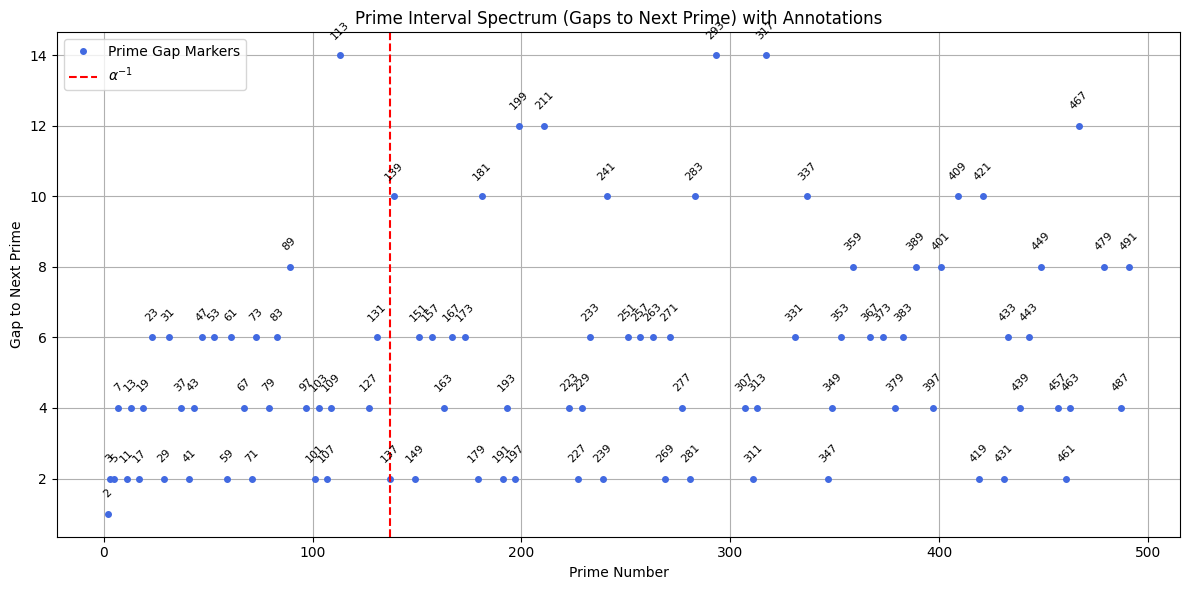

In [83]:
# Re-run required imports and plotting code after environment reset
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Constants
alpha_inv = 137.03599908

# Generate primes and gaps
primes_near_alpha = list(sp.primerange(1, 500))
prime_gaps = np.diff(primes_near_alpha)
prime_centers = primes_near_alpha[:-1]  # x-values for the gaps

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(prime_centers, prime_gaps, 'o', color='royalblue', markersize=4, label='Prime Gap Markers')
plt.axvline(alpha_inv, color='red', linestyle='--', label=r'$\alpha^{-1}$')

# Add annotations
for x, y in zip(prime_centers, prime_gaps):
    plt.text(x, y + 0.4, str(x), fontsize=8, ha='center', va='bottom', rotation=45)

plt.title("Prime Interval Spectrum (Gaps to Next Prime) with Annotations")
plt.xlabel("Prime Number")
plt.ylabel("Gap to Next Prime")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


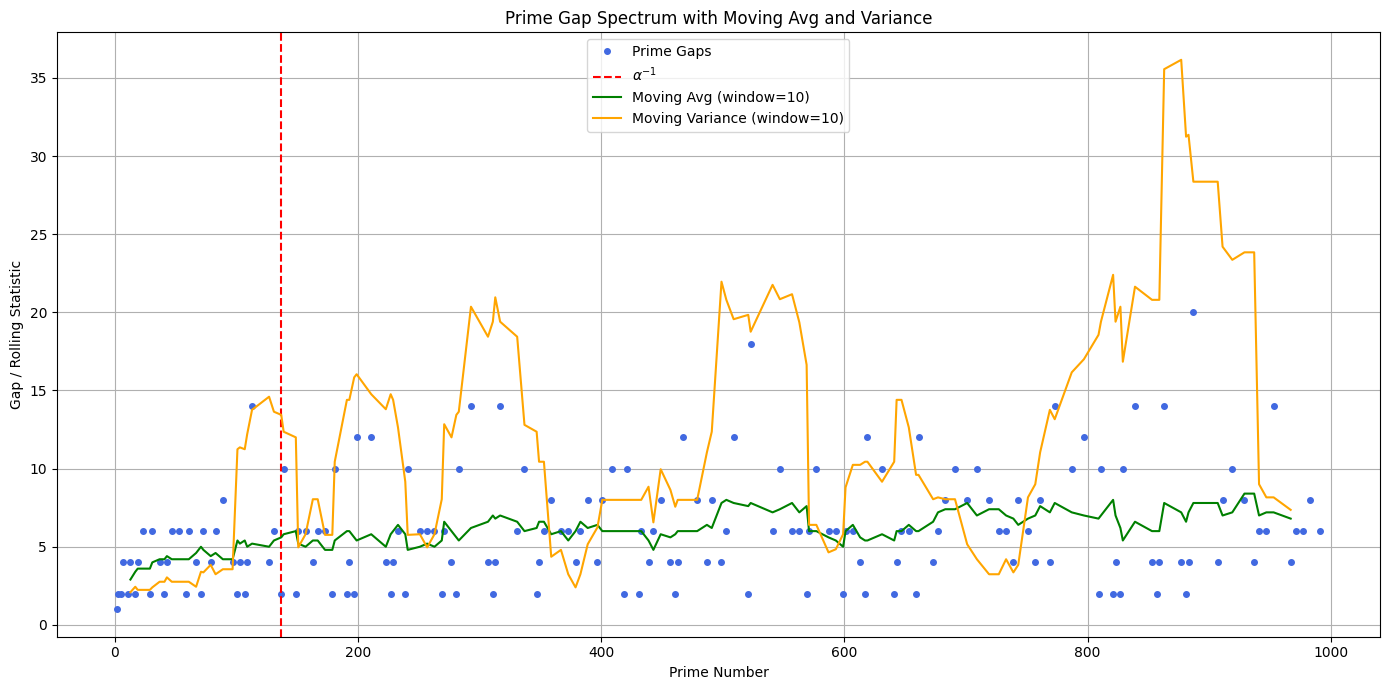

In [84]:
# Extend the analysis to primes up to 1000, and prepare overlays for moving average and variance

# Constants
alpha_inv = 137.03599908

# Generate more primes and gaps
primes_extended = list(sp.primerange(1, 1000))
prime_gaps_ext = np.diff(primes_extended)
prime_centers_ext = primes_extended[:-1]  # x-values for the gaps

# Compute moving average and moving variance
window_size = 10
rolling_avg = np.convolve(prime_gaps_ext, np.ones(window_size) / window_size, mode='valid')
rolling_var = np.array([
    np.var(prime_gaps_ext[i:i+window_size])
    for i in range(len(prime_gaps_ext) - window_size + 1)
])
avg_x = prime_centers_ext[window_size // 2: -window_size // 2 + 1]

# Plot
plt.figure(figsize=(14, 7))
plt.plot(prime_centers_ext, prime_gaps_ext, 'o', color='royalblue', markersize=4, label='Prime Gaps')
plt.axvline(alpha_inv, color='red', linestyle='--', label=r'$\alpha^{-1}$')
plt.plot(avg_x, rolling_avg, label='Moving Avg (window=10)', color='green')
plt.plot(avg_x, rolling_var, label='Moving Variance (window=10)', color='orange')

plt.title("Prime Gap Spectrum with Moving Avg and Variance")
plt.xlabel("Prime Number")
plt.ylabel("Gap / Rolling Statistic")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


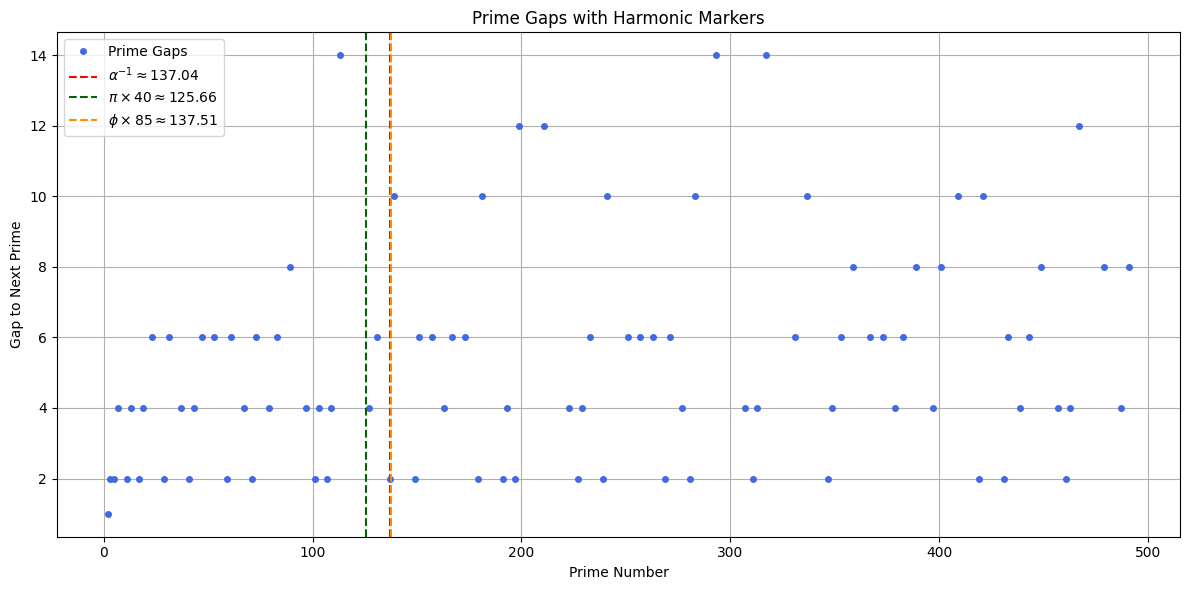

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Constants
alpha_inv = 137.03599908
pi_40 = np.pi * 40
phi = (1 + np.sqrt(5)) / 2  # Golden ratio
phi_85 = phi * 85

# Generate primes and gaps
primes_near_alpha = list(sp.primerange(1, 500))
prime_gaps = np.diff(primes_near_alpha)
prime_centers = primes_near_alpha[:-1]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(prime_centers, prime_gaps, 'o', color='royalblue', markersize=4, label='Prime Gaps')

# Mark lines
plt.axvline(alpha_inv, color='red', linestyle='--', linewidth=1.5, label=r'$\alpha^{-1} \approx 137.04$')
plt.axvline(pi_40, color='darkgreen', linestyle='--', linewidth=1.5, label=r'$\pi \times 40 \approx 125.66$')
plt.axvline(phi_85, color='darkorange', linestyle='--', linewidth=1.5, label=r'$\phi \times 85 \approx 137.51$')

# Add title and labels
plt.title("Prime Gaps with Harmonic Markers")
plt.xlabel("Prime Number")
plt.ylabel("Gap to Next Prime")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


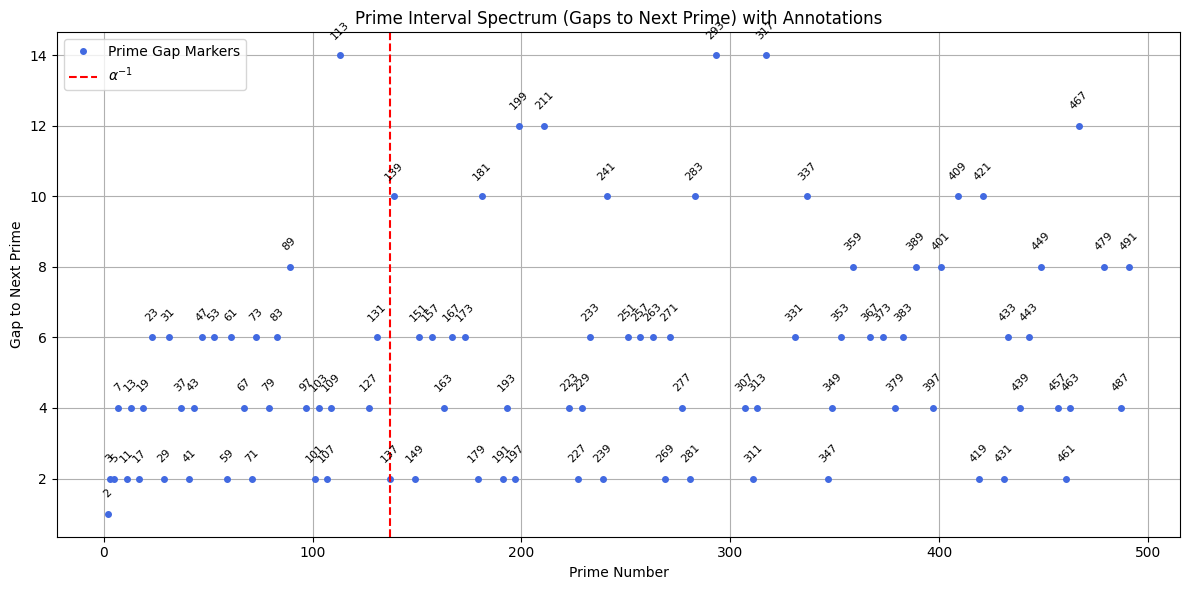

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Constants
alpha_inv = 137.03599908

# Generate primes and gaps
primes_near_alpha = list(sp.primerange(1, 500))
prime_gaps = np.diff(primes_near_alpha)
prime_centers = primes_near_alpha[:-1]  # x-values for the gaps

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(prime_centers, prime_gaps, 'o', color='royalblue', markersize=4, label='Prime Gap Markers')
plt.axvline(alpha_inv, color='red', linestyle='--', label=r'$\alpha^{-1}$')

# Add annotations
for x, y in zip(prime_centers, prime_gaps):
    plt.text(x, y + 0.4, str(x), fontsize=8, ha='center', va='bottom', rotation=45)

plt.title("Prime Interval Spectrum (Gaps to Next Prime) with Annotations")
plt.xlabel("Prime Number")
plt.ylabel("Gap to Next Prime")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [87]:
# Constants
alpha_inv = 137.03599908
phi = (1 + np.sqrt(5)) / 2  # Golden ratio
sqrt2 = np.sqrt(2)
display(alpha_inv)
display(phi)
display(sqrt2)
display(np.e)

137.03599908

np.float64(1.618033988749895)

np.float64(1.4142135623730951)

2.718281828459045

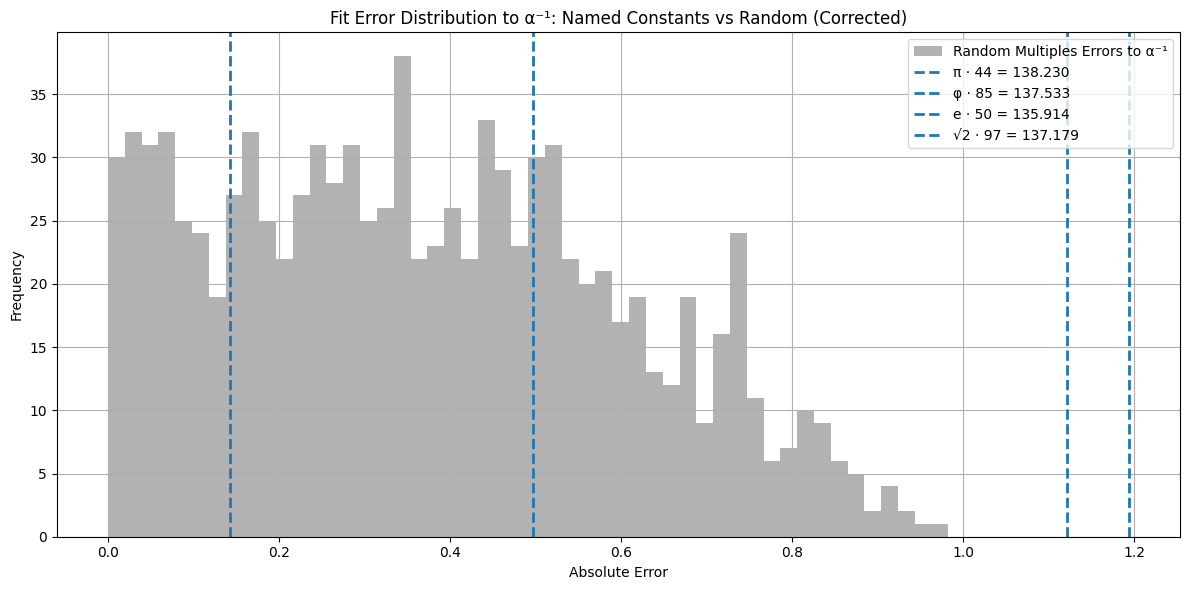

Constant  Best n  Best n * constant  Error to α⁻¹
0        π      44          1.382e+02     1.194e+00
1        φ      85          1.375e+02     4.969e-01
2        e      50          1.359e+02     1.122e+00
3       √2      97          1.372e+02     1.427e-01

In [88]:
# Re-import necessary packages after kernel reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import pi
from scipy.constants import physical_constants
import scipy
from numpy import e as euler  # Correct Euler number
from numpy import sqrt

# Define constants
phi = (1 + sqrt(5)) / 2  # Golden ratio
sqrt2 = sqrt(2)
alpha_inv = 137.03599908

# Integer range
n_values = np.arange(1, 201)

# Constants dictionary (corrected)
constants = {
    'π': pi,
    'φ': phi,
    'e': euler,
    '√2': sqrt2
}

# Recalculate best fit for each
fit_results = []

for name, const_val in constants.items():
    products = n_values * const_val
    errors = np.abs(products - alpha_inv)
    best_idx = np.argmin(errors)
    fit_results.append({
        'Constant': name,
        'Best n': n_values[best_idx],
        'Best n * constant': products[best_idx],
        'Error to α⁻¹': errors[best_idx]
    })

# Re-run random simulation
np.random.seed(42)
random_constants = np.random.uniform(1, 2, size=1000)
random_n = np.arange(1, 201).reshape(-1, 1)
random_products = random_n * random_constants
random_errors = np.abs(random_products - alpha_inv)
min_random_errors = random_errors.min(axis=0)

# Plot histogram again
plt.figure(figsize=(12, 6))
plt.hist(min_random_errors, bins=50, alpha=0.6, color='gray', label='Random Multiples Errors to α⁻¹')
for result in fit_results:
    plt.axvline(result['Error to α⁻¹'], linestyle='--', linewidth=2,
                label=f"{result['Constant']} · {result['Best n']} = {result['Best n * constant']:.3f}")

plt.title("Fit Error Distribution to α⁻¹: Named Constants vs Random (Corrected)")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tabulate results again
fit_df_corrected = pd.DataFrame(fit_results)
display(fit_df_corrected)

In [89]:
from scipy.stats import percentileofscore

# Increase number of random constants for more robust test
np.random.seed(42)
num_trials = 100000
random_constants = np.random.uniform(1, 2, size=num_trials)
random_n = np.arange(1, 201).reshape(-1, 1)
random_products = random_n * random_constants
random_errors = np.abs(random_products - alpha_inv)
min_random_errors = random_errors.min(axis=0)

# Compute quartiles of the error distribution
quartiles = np.percentile(min_random_errors, [25, 50, 75])

# Add significance info to fit table
for result in fit_results:
    error = result['Error to α⁻¹']
    p_value = np.sum(min_random_errors <= error) / num_trials
    result['P-value'] = p_value
    result['Significance'] = (
        "Below 1st Quartile" if error < quartiles[0] else
        "Below Median" if error < quartiles[1] else
        "Below 3rd Quartile" if error < quartiles[2] else
        "Above 3rd Quartile"
    )

# Display the updated table
fit_df_significance = pd.DataFrame(fit_results)
display(fit_df_significance)
#tools.display_dataframe_to_user(name="Fit to α⁻¹ with Significance", dataframe=fit_df_significance)


Constant  Best n  Best n * constant  Error to α⁻¹   P-value  \
0        π      44          1.382e+02     1.194e+00 1.000e+00   
1        φ      85          1.375e+02     4.969e-01 6.901e-01   
2        e      50          1.359e+02     1.122e+00 1.000e+00   
3       √2      97          1.372e+02     1.427e-01 1.983e-01   

         Significance  
0  Above 3rd Quartile  
1  Below 3rd Quartile  
2  Above 3rd Quartile  
3  Below 1st Quartile

In [90]:
import pandas as pd
import scipy.constants as const

# Particle property definitions
particle_data = {
    "Electron": {
        "Mass (kg)": const.m_e,
        "Charge (e)": -1,
        "Spin": 0.5,
        "Type": "Lepton",
        "Generation": 1
    },
    "Muon": {
        "Mass (kg)": 1.883531627e-28,  # CODATA
        "Charge (e)": -1,
        "Spin": 0.5,
        "Type": "Lepton",
        "Generation": 2
    },
    "Tau": {
        "Mass (kg)": 3.16754e-27,  # CODATA
        "Charge (e)": -1,
        "Spin": 0.5,
        "Type": "Lepton",
        "Generation": 3
    },
    "Proton": {
        "Mass (kg)": const.m_p,
        "Charge (e)": 1,
        "Spin": 0.5,
        "Type": "Baryon",
        "Generation": None
    },
    "Neutron": {
        "Mass (kg)": const.m_n,
        "Charge (e)": 0,
        "Spin": 0.5,
        "Type": "Baryon",
        "Generation": None
    },
    "Photon": {
        "Mass (kg)": 0.0,
        "Charge (e)": 0,
        "Spin": 1,
        "Type": "Boson",
        "Generation": None
    }
}

# Convert to DataFrame
sm_df = pd.DataFrame.from_dict(particle_data, orient='index')

# Add natural units: mass in MeV/c²
sm_df["Mass (MeV/c²)"] = sm_df["Mass (kg)"] * const.c**2 / (1.60218e-13)

# Optional: Reorder columns
sm_df = sm_df[["Type", "Generation", "Charge (e)", "Spin", "Mass (kg)", "Mass (MeV/c²)"]]

# Display
sm_df.style.format({
    "Mass (kg)": "{:.3e}",
    "Mass (MeV/c²)": "{:.2f}"
})


In [91]:
display('alpha = ' + str(const.alpha))
display('alpha * 2 = ' + str(const.alpha * 2))
display('alpha * 2 - 0.0009 = ' + str(const.alpha * 2 - 0.0009))
display('alpha * 2 + 0.0009 = ' + str(const.alpha * 2 + 0.0009))

'alpha = 0.0072973525643'

'alpha * 2 = 0.0145947051286'

'alpha * 2 - 0.0009 = 0.0136947051286'

'alpha * 2 + 0.0009 = 0.0154947051286'

In [92]:
display('alpha = ' + str(const.alpha))
display('alpha * 2 = ' + str(const.alpha * 2))
display('alpha * 2 - 0.0003 = ' + str(const.alpha * 2 - 0.0003))
display('alpha * 2 + 0.0003 = ' + str(const.alpha * 2 + 0.0003))

'alpha = 0.0072973525643'

'alpha * 2 = 0.0145947051286'

'alpha * 2 - 0.0003 = 0.0142947051286'

'alpha * 2 + 0.0003 = 0.0148947051286'

# Core Functions

In [93]:
def initialize_grid(M, N):
    """
    Initializes the grid and identifies the center node.

    Parameters:
    - M (int): Number of rows.
    - N (int): Number of columns.

    Returns:
    - grid (ndarray): Initialized grid.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    """
    grid = np.zeros((M, N))
    center_i, center_j = M // 2, N // 2
    return grid, center_i, center_j


def define_past_light_cone(M, N, center_i, center_j, k=0.5):
    """
    Defines the past light cone mask below the center node.

    Parameters:
    - M (int): Number of rows.
    - N (int): Number of columns.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - k (float): Slope factor determining the cone's width.

    Returns:
    - past_cone_mask (ndarray): Binary mask for the past light cone.
    """
    past_cone_mask = np.zeros((M, N))

    for i in range(center_i + 1, M):
        # Calculate the horizontal deviation based on slope factor k
        distance = i - center_i
        max_dev = int(k * distance)

        # Define the range of columns to include
        start_j = max(center_j - max_dev, 0)
        end_j = min(center_j + max_dev + 1, N)

        # Set the mask to 1 for nodes within the deviation
        past_cone_mask[i, start_j:end_j] = 1

    return past_cone_mask

def define_future_light_cone(M, N, center_i, center_j, k=0.5, include_current_node=False):
    """
    Defines the future light cone mask above the center node.

    Parameters:
    - M (int): Number of rows.
    - N (int): Number of columns.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - k (float): Slope factor determining the cone's width.
    - include_current_node (bool): If True, includes the center node in the mask.

    Returns:
    - future_cone_mask (ndarray): Binary mask for the future light cone.
    """
    future_cone_mask = np.zeros((M, N))

    # Iterate upwards from the center to define the future cone
    for i in range(center_i - 1, -1, -1):  # Move upwards in the grid
        # Calculate the horizontal deviation based on slope factor k
        distance = center_i - i
        max_dev = int(k * distance)

        # Define the range of columns to include
        start_j = max(center_j - max_dev, 0)
        end_j = min(center_j + max_dev + 1, N)

        # Set the mask to 1 for nodes within the deviation
        future_cone_mask[i, start_j:end_j] = 1

    # Optionally include the current node
    if include_current_node:
        future_cone_mask[center_i, center_j] = 1

    return future_cone_mask



def combine_past_future_light_cones(past_cone_mask, future_cone_mask):
    """
    Combines the past light cone mask and the future light cone mask into a single light cone mask.

    Parameters:
    - past_cone_mask (ndarray): Binary mask for the past light cone.
    - future_cone_mask (ndarray): Binary mask for the future light cone.

    Returns:
    - light_cone_mask (ndarray): Combined binary mask for the full light cone.
    """
    # Ensure the masks have the same shape
    if past_cone_mask.shape != future_cone_mask.shape:
        raise ValueError("Past and future cone masks must have the same dimensions.")

    # Combine the two masks using logical OR to ensure any marked node (1) is retained
    light_cone_mask = np.logical_or(past_cone_mask, future_cone_mask).astype(int)

    return light_cone_mask


def calc_future_node(center_i, center_j, observer_type='inertial'):
    if observer_type == 'inertial':
        # Include only the node directly above the center node
        future_i, future_j = center_i - 1, center_j
    elif observer_type == 'accelerating':
        # Include only the node one row above and one column to the right of the center node
        future_i, future_j = center_i - 1, center_j + 1
    else:
        raise ValueError("Invalid observer_type. Choose 'inertial' or 'accelerating'.")
    return future_i, future_j



def add_future_node(past_cone_mask, center_i, center_j, observer_type='inertial'):
    """
    Adds the future node to the light cone mask based on observer type.

    Parameters:
    - past_cone_mask (ndarray): Binary mask for the past light cone.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - observer_type (str): 'inertial' or 'accelerating'.

    Returns:
    - updated_mask (ndarray): Light cone mask including the future node.
    - future_node_mask (ndarray): Binary mask for the future node.
    """
    updated_mask = past_cone_mask.copy()
    future_node_mask = np.zeros_like(past_cone_mask)

    future_i, future_j = calc_future_node(center_i, center_j, observer_type)

    # Set the future node in the masks
    if 0 <= future_i < updated_mask.shape[0] and 0 <= future_j < updated_mask.shape[1]:
        updated_mask[future_i, future_j] = 1
        future_node_mask[future_i, future_j] = 1

    return updated_mask, future_node_mask # Added return statement to return the updated masks



def define_custom_light_cone(M, N, center_i, center_j, relative_coords):
    """
    Defines a custom light cone mask based on a set of coordinates relative to the center node.

    Parameters:
      - M (int): Number of rows.
      - N (int): Number of columns.
      - center_i (int): Row index of the center node.
      - center_j (int): Column index of the center node.
      - relative_coords (iterable): An iterable of (di, dj) tuples.
          For example, (2, -1) means 2 rows below and 1 column to the left of the center.

    Returns:
      - custom_cone_mask (ndarray): Binary mask (shape (M, N)) with ones at the positions
        defined by the relative coordinates (if within bounds) and zeros elsewhere.
    """
    custom_cone_mask = np.zeros((M, N))
    for di, dj in relative_coords:
        i = center_i + di
        j = center_j + dj
        if 0 <= i < M and 0 <= j < N:
            custom_cone_mask[i, j] = 1
    return custom_cone_mask


def define_adaptive_light_cone(M, N, center_i, center_j, k=None):
    """
    Defines a dynamic light cone where the slope factor k is not predefined but instead
    adapts based on the entanglement structure.

    Parameters:
    - M (int): Number of rows.
    - N (int): Number of columns.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - k (float, optional): Slope factor to determine cone width dynamically.

    Returns:
    - light_cone_mask (ndarray): Binary mask for the dynamically shaped light cone.
    """
    light_cone_mask = np.zeros((M, N))

    # If k is not given, derive it based on an adaptive rule
    if k is None:
        k = 0.5  # Default initial slope

    for i in range(center_i + 1, M):
        # Adapt k based on row index (small variations introduced for flexibility)
        dynamic_k = k * (1 + np.random.uniform(-0.1, 0.1))
        distance = i - center_i
        max_dev = int(dynamic_k * distance)

        # Define the range of columns to include
        start_j = max(center_j - max_dev, 0)
        end_j = min(center_j + max_dev + 1, N)

        # Set the mask to 1 for nodes within the dynamic light cone
        light_cone_mask[i, start_j:end_j] = 1

    return light_cone_mask


def create_uniform_euclidean_kernel(r):
    """
    Creates a uniform Euclidean kernel with radius r.

    Parameters:
    - r (int): Radius of the kernel.

    Returns:
    - kernel (ndarray): 2D kernel array.
    """
    size = 2 * r + 1
    y, x = np.ogrid[-r:r+1, -r:r+1]
    distance = np.sqrt(x**2 + y**2)
    kernel = (distance <= r).astype(float)
    return kernel


def create_space_filling_lattice_kernel(r):
    """
    Creates a space-filling lattice kernel with range r.

    Parameters:
    - r (int): Range defining the lattice structure.

    Returns:
    - kernel (ndarray): 2D kernel array with space-filling properties.
    """
    size = 2 * r + 1
    kernel = np.zeros((size, size))

    center = r
    for i in range(size):
        for j in range(size):
            if abs(i - center) + abs(j - center) <= r:
                kernel[i, j] = 1  # Assign 1 to nodes within the lattice structure
    return kernel



def compute_probability_grid(light_cone_mask, kernel, epsilon=1e-10):
    """
    Computes the probability grid by convolving the light cone with the kernel.

    Parameters:
    - light_cone_mask (ndarray): Binary mask indicating light cone nodes.
    - kernel (ndarray): 2D kernel array.
    - epsilon (float): Threshold below which probabilities are set to zero.

    Returns:
    - prob_grid (ndarray): Normalized probability grid.
    """
    # Perform convolution
    convolved = convolve2d(light_cone_mask, kernel, mode='same', boundary='fill', fillvalue=0)
    prob_grid = convolved.copy()

    # Normalize the grid so that the sum of probabilities equals 1
    total = prob_grid.sum()
    if total == 0:
        raise ValueError("Total influence is zero. Check the light cone mask and kernel.")
    prob_grid /= total

    # Thresholding: Set very small probabilities to zero to eliminate floating-point artifacts
    prob_grid[prob_grid < epsilon] = 0.0

    return prob_grid


def compute_causal_contributions_from_prob_grid(prob_grid, kernel, center_i, center_j, observer_type='inertial'):
    """
    Identifies the nodes in the probability grid that contribute to the probability of the specified new event.

    Parameters:
    - prob_grid (ndarray): The normalized probability grid after convolution.
    - kernel (ndarray): The convolution kernel used in computing the probability grid.
    - center_i (int): Row index of the center event.
    - center_j (int): Column index of the center event.
    - observer_type (str): 'inertial' or 'accelerating'.

    Returns:
    - contribution_mask (ndarray): A heatmap showing the contribution of probability grid nodes.
    """

    future_i, future_j = calc_future_node(center_i, center_j, observer_type)

    # Ensure the future event node is within grid bounds
    if not (0 <= future_i < prob_grid.shape[0] and 0 <= future_j < prob_grid.shape[1]):
        raise ValueError("Future event node is out of bounds.")

    # Kernel dimensions (assumed to be square)
    r = kernel.shape[0] // 2  # Kernel radius
    contribution_mask = np.zeros_like(prob_grid)

    # Iterate over the kernel footprint and compute contributions
    for di in range(-r, r + 1):
        for dj in range(-r, r + 1):
            past_i, past_j = future_i + di, future_j + dj

            if 0 <= past_i < prob_grid.shape[0] and 0 <= past_j < prob_grid.shape[1]:
                # Contribution is based on the kernel weight and the probability at (past_i, past_j)
                contribution_mask[past_i, past_j] = kernel[di + r, dj + r] * prob_grid[past_i, past_j]

    # Normalize the contributions for visualization
    total_contribution = np.sum(contribution_mask)
    if total_contribution > 0:
        contribution_mask /= total_contribution  # Normalize to sum to 1

    return contribution_mask


# Utilities

Text(0, 0.5, '$E_{ij}$')

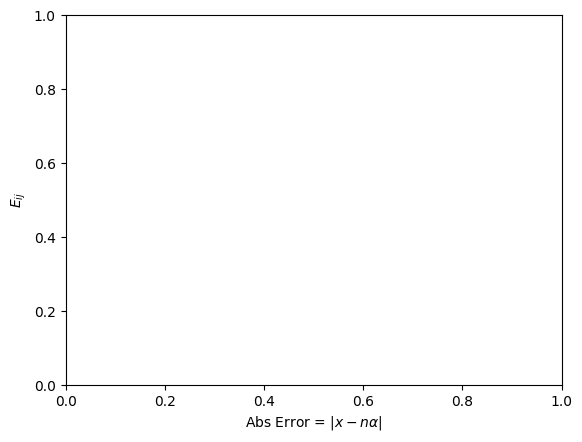

In [94]:
import matplotlib.pyplot as plt
#col_label = r"$\frac{|x - n\alpha|}{\alpha\, n} \times 100\%$"
col_label = r"Pct Error = $\frac{|x - n\alpha|}{\alpha\, n} \times 100\%$"
abs_error_col_name = r"Abs Error = $|x - n\alpha|$"
plt.xlabel("value/"+r'$\n_alpha$')
plt.xlabel(abs_error_col_name)
plt.ylabel(r'$E_{ij}$')
#plt.show()

In [95]:
import matplotlib.colors as mcolors

# Get a dictionary of CSS4 color names and their corresponding RGB values
css4_colors = mcolors.CSS4_COLORS

# Print the color names
for name in css4_colors:
    print(name)

aliceblue
antiquewhite
aqua
aquamarine
azure
beige
bisque
black
blanchedalmond
blue
blueviolet
brown
burlywood
cadetblue
chartreuse
chocolate
coral
cornflowerblue
cornsilk
crimson
cyan
darkblue
darkcyan
darkgoldenrod
darkgray
darkgreen
darkgrey
darkkhaki
darkmagenta
darkolivegreen
darkorange
darkorchid
darkred
darksalmon
darkseagreen
darkslateblue
darkslategray
darkslategrey
darkturquoise
darkviolet
deeppink
deepskyblue
dimgray
dimgrey
dodgerblue
firebrick
floralwhite
forestgreen
fuchsia
gainsboro
ghostwhite
gold
goldenrod
gray
green
greenyellow
grey
honeydew
hotpink
indianred
indigo
ivory
khaki
lavender
lavenderblush
lawngreen
lemonchiffon
lightblue
lightcoral
lightcyan
lightgoldenrodyellow
lightgray
lightgreen
lightgrey
lightpink
lightsalmon
lightseagreen
lightskyblue
lightslategray
lightslategrey
lightsteelblue
lightyellow
lime
limegreen
linen
magenta
maroon
mediumaquamarine
mediumblue
mediumorchid
mediumpurple
mediumseagreen
mediumslateblue
mediumspringgreen
mediumturquoise
mediumv

In [96]:
def print_prob_grid_with_indices(prob_grid, center_i, center_j, precision=3):
    M, N = prob_grid.shape
    print("\nProbability Grid (centered at i=0, j=0):\n")
    for i in range(M):
        row_str = ""
        for j in range(N):
            val = prob_grid[i, j]
            # Compute coordinate relative to center
            x = j - center_j
            y = i - center_i
            row_str += f"({x:+},{y:+}):{val:.{precision}f}  "
        print(row_str)

#print_prob_grid_with_indices(prob_grid, center_i, center_j)

# Plotting Functions

In [328]:
# === Formatting Variables ===
# Define the fine structure constant (alpha ≈ 1/137.035999084)
#alpha = 1 / 137.035999084
alpha = const.alpha


light_cone_mask_figsize = (24, 10) #(w,h) 20,9
heatmaps_figsize = (24, 10)
ex2_heatmaps_figsize = (14,11)
diff_heatmap_figsize = (10,8)
stats_table_figsize = (10,5)
spectrum_plot_figsize = (10,5)
spectrum_table_figsize = (18, 5)
table_font_size = 12
table_title_font_size = 12
tick_label_size = 10
pdf_dpi = 600

show_plot_ticks = False
plot_annotation_precision = 5
plot_annotation_font_size = 9
axis_label_font_size = 12
plot_title_font_size = 16
plot_colorbar_shrink = 0.5
plot_colorbar_aspect = 10

plot_probability_heatmap_font_color_threshold = 0.03
plot_probability_heatmap_over_font_color = "white" #over threshold font color
plot_probability_heatmap_under_font_color = "black" #unde_threshold_font_color

plot_probability_heatmap_alpha_font_color_threshold = 5.0
plot_probability_heatmap_alpha_over_font_color = "lightgray" #over threshold font color
plot_probability_heatmap_alpha_under_font_color = "darkslategray" #unde_threshold_font_color

plot_masked_probability_heatmap_font_color_threshold = 0.04
plot_masked_probability_heatmap_over_font_color = "black" #over threshold font color
plot_masked_probability_heatmap_under_font_color = "white" #under_threshold_font_color

plot_outside_masked_probability_heatmap_font_color_threshold = 0.02
plot_outside_masked_probability_heatmap_over_font_color = "black" #over threshold font color
plot_outside_masked_probability_heatmap_under_font_color = "white" #under_threshold_font_color

plot_contribution_heatmap_font_color_threshold = 0.2
plot_contribution_heatmap_over_font_color = "white" #over threshold font color
plot_contribution_heatmap_under_font_color = "black" #under_threshold_font_color

plot_probability_diff_heatmap_font_color_threshold = 0.0
plot_probability_diff_heatmap_over_font_color = "white" #over threshold font color
plot_probability_diff_heatmap_under_font_color = "white" #under_threshold_font_color


def plot_light_cone(ax, light_cone_mask, center_i, center_j, observer_type='inertial', title="Light Cone Mask"):
    """
    Plots the light cone mask on a given Axes object with faint grid lines.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - light_cone_mask (ndarray): Binary mask indicating light cone nodes.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - observer_type (str): Type of observer ('inertial' or 'accelerating').
    - title (str): Title of the heatmap.
    """
    im = ax.imshow(light_cone_mask, cmap='Greys', origin='lower', interpolation='nearest', alpha=0.7)

    # Highlight the center node
    ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Present Event Node')

    # Highlight the future node
    future_i, future_j = calc_future_node(center_i, center_j, observer_type)

    ax.scatter(future_j, future_i, color='lightblue', marker='o', s=200, label='Future Event Node')

    # Add grid lines
    M, N = light_cone_mask.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    ax.set_title(title, fontsize = plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)
    ax.legend(loc='upper right', fontsize=axis_label_font_size)

    # Turn off tick labels
    ax.tick_params(axis='both', which='both', bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks, left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    # Invert y-axis to have i increase from bottom to top
    ax.invert_yaxis()


def plot_light_cone_grayscale(ax, light_cone_mask, center_i, center_j, observer_type='inertial', title="Light Cone Mask"):
    """
    Plots the light cone mask using minimal grayscale, light hatching for the mask, and distinct markers for current/future nodes.
    """
    from matplotlib.patches import Rectangle

    M, N = light_cone_mask.shape
    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(-0.5, M - 0.5)

    # Draw light gray background grid cells
    for i in range(M):
        for j in range(N):
            if light_cone_mask[i, j]:
                rect = Rectangle((j - 0.5, i - 0.5), 1, 1,
                                 facecolor='white', edgecolor='gray',
                                 hatch='/////', linewidth=0.8, alpha=0.5)
                ax.add_patch(rect)

    # Highlight the current event node
    ax.scatter(center_j, center_i, s=160, facecolor='black', edgecolor='white',
               linewidth=1.2, marker='o', label='Current Event')

    # Highlight the future event node
    future_i, future_j = calc_future_node(center_i, center_j, observer_type)
    ax.scatter(future_j, future_i, s=120, facecolor='dimgray', edgecolor='black',
               linewidth=1.0, marker='s', label='Next Event')

    # Grid lines
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.4, alpha=0.2)

    # Labels, title, and legend
    ax.set_title(title, fontsize=plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)
    ax.legend(loc='upper right', fontsize=axis_label_font_size, frameon=False)

    # Formatting
    ax.set_aspect('equal')
    ax.tick_params(
        axis='both', which='both',
        bottom=show_plot_ticks, top=show_plot_ticks,
        labelbottom=show_plot_ticks,
        left=show_plot_ticks, right=show_plot_ticks,
        labelleft=show_plot_ticks
    )
    ax.invert_yaxis()



# === FUNCTION TO PLOT MASKS ===
def plot_mask(ax, mask, center_i, center_j, title="Mask"):
    """
    Plots a light cone mask on the given Axes object with faint grid lines.

    Parameters:
      - ax (matplotlib.axes.Axes): The Axes object to plot on.
      - mask (ndarray): Binary mask indicating light cone nodes.
      - center_i (int): Row index of the center (present) node.
      - center_j (int): Column index of the center (present) node.
      - title (str): Title of the plot.
    """
    ax.imshow(mask, cmap='Greys', origin='lower', interpolation='nearest', alpha=0.7)

    # Highlight the center (present) node in light green
    ax.scatter(center_j, center_i, color='slategray', marker='o', s=200, label='Present Node')

    # Add grid lines
    M, N = mask.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Column Index (j)', fontsize=12)
    ax.set_ylabel('Row Index (i)', fontsize=12)

    # Invert y-axis so row index increases from bottom to top
    ax.invert_yaxis()


def plot_mask_2(ax, mask, center_i, center_j, observer_type='inertial', title="Mask"):
    """
    Plots a light cone mask on the given Axes object with grid and node markers.

    Parameters:
      - ax (matplotlib.axes.Axes): The Axes object to plot on.
      - mask (ndarray): Binary mask indicating light cone nodes.
      - center_i (int): Row index of the current node.
      - center_j (int): Column index of the current node.
      - observer_type (str): 'inertial', 'accelerated', etc. Used to compute next event.
      - title (str): Title of the plot.
    """
    # Plot mask as grayscale background
    ax.imshow(mask, cmap='Greys', origin='lower', interpolation='nearest', alpha=0.7)

    # Compute shape for grid lines
    M, N = mask.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    # Plot current node: unfilled circle
    h1 = ax.scatter(center_j, center_i, facecolors='none', edgecolors='slategray', marker='o', s=200, label='Current Node')

    # Compute and plot next event node: X
    future_i, future_j = calc_future_node(center_i, center_j, observer_type)
    h2 = ax.scatter(future_j, future_i, color='slategray', marker='x', s=120, linewidths=2, label='Next Event Node')

    # Title and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Column Index (j)', fontsize=12)
    ax.set_ylabel('Row Index (i)', fontsize=12)

    # Legend
    ax.legend(handles=[h1, h2], loc='upper right')

    # Invert to match incidence conventions
    ax.invert_yaxis()


def plot_probability_heatmap(ax, prob_grid, past_cone_mask=None, future_node_mask=None, center_i=None, center_j=None, observer_type='inertial', title="Bell Probability Heatmap"):
    """
    Plots the probability grid as a heatmap on a given Axes object with faint grid lines
    and highlights for past and future light cones, including the target node.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - prob_grid (ndarray): The normalized probability grid.
    - past_cone_mask (ndarray, optional): Binary mask for the past light cone.
    - future_node_mask (ndarray, optional): Binary mask for the future node.
    - center_i (int, optional): Row index of the center node.
    - center_j (int, optional): Column index of the center node.
    - title (str): Title of the heatmap.
    """
    # Choose a colormap and set the color for zero probabilities
    cmap = plt.cm.viridis.copy()
    cmap.set_under(color='white')  # Color for zero probability

    # Mask the probability grid to handle zero probabilities
    masked_prob_grid = np.ma.masked_where(prob_grid == 0, prob_grid)

    # Plot the heatmap with proper masking
    im = ax.imshow(masked_prob_grid, cmap=cmap, origin='lower', interpolation='nearest', vmin=1e-10)

    # Add grid lines
    M, N = prob_grid.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    ax.set_title(title, fontsize = plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)

    # Add a colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=plot_colorbar_shrink, aspect=plot_colorbar_aspect)
    cbar.ax.set_ylabel('Probability', rotation=-90, va="bottom")

    # Add annotations
    for i in range(M):
        for j in range(N):
            if prob_grid[i, j] > 0:
                ax.text(j, i, f"{prob_grid[i, j]:.{plot_annotation_precision}f}",
                        ha='center', va='center',
                        color=plot_probability_heatmap_over_font_color if prob_grid[i, j] > plot_probability_heatmap_font_color_threshold else plot_probability_heatmap_under_font_color,
                        fontsize=plot_annotation_font_size)

    # Highlight Past Light Cone
    if past_cone_mask is not None:
        # Create a red transparent overlay for past light cone
        ax.imshow(past_cone_mask, cmap='Reds', alpha=0.3, origin='lower')

    # Highlight Future Light Cone
    #if future_node_mask is not None:
        # Create a blue transparent overlay for future node
        #ax.imshow(future_node_mask, cmap='Blues', alpha=0.5, origin='lower')

    # Highlight the target node with a green dot
    if center_i is not None and center_j is not None:
        ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Target Node')
        # Optionally, add to legend
        handles, labels = ax.get_legend_handles_labels()
        if 'Target Node' not in labels:
            ax.legend(loc='upper right')

    # Highlight the future node
    future_i, future_j = calc_future_node(center_i, center_j, observer_type)
    ax.scatter(future_j, future_i, color='lightblue', marker='o', s=200, label='Future Event Node')

    # Turn off tick labels
    ax.tick_params(axis='both', which='both', bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks, left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    # Invert y-axis to have i increase from bottom to top
    ax.invert_yaxis()


def plot_probability_heatmap_2_alpha(ax, prob_grid, past_cone_mask=None, future_node_mask=None,
                                     center_i=None, center_j=None, observer_type='inertial',
                                     title="Probability Heatmap (Normalized to α)", grayscale=False):
    """
    Plots a heatmap of probability values normalized by alpha. Supports grayscale rendering,
    light cone highlighting, and event node markers.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - prob_grid (ndarray): Raw probability grid.
    - past_cone_mask (ndarray): Binary mask for past cone (optional).
    - future_node_mask (ndarray): Binary mask for future cone (optional).
    - center_i, center_j (int): Center node coordinates.
    - observer_type (str): 'inertial' or 'accelerated' (used to calc next node).
    - title (str): Title of the plot.
    - grayscale (bool): Use grayscale colormap and markers if True.
    """
    # Normalize to alpha
    normalized_grid = prob_grid / alpha
    masked_grid = np.ma.masked_where(prob_grid == 0, normalized_grid)

    # Colormap
    cmap = plt.cm.Greys.copy() if grayscale else plt.cm.viridis.copy()
    cmap.set_under(color='white')

    # Plot
    im = ax.imshow(masked_grid, cmap=cmap, origin='lower', interpolation='nearest', vmin=1e-10)

    # Gridlines
    M, N = prob_grid.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    ax.set_title(title, fontsize=plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=plot_colorbar_shrink, aspect=plot_colorbar_aspect)
    cbar.ax.set_ylabel(r'Probability / $\alpha$', rotation=-90, va="bottom")

    # Annotations
    for i in range(M):
        for j in range(N):
            if prob_grid[i, j] > 0:
                ax.text(j, i, f"{normalized_grid[i, j]:.{plot_annotation_precision}f}",
                        ha='center', va='center',
                        color=plot_probability_heatmap_alpha_over_font_color if normalized_grid[i, j] > plot_probability_heatmap_alpha_font_color_threshold
                        else plot_probability_heatmap_alpha_under_font_color,
                        fontsize=plot_annotation_font_size)

    # Light cones
    if past_cone_mask is not None:
        ax.imshow(past_cone_mask, cmap='Greys' if grayscale else 'Reds', alpha=0.3, origin='lower')

    # Markers
    legend_handles = []
    if center_i is not None and center_j is not None:
        h_current = ax.scatter(center_j, center_i, facecolors='none', edgecolors='slategray', marker='o', s=200, label='Current Node')
        legend_handles.append(h_current)

        future_i, future_j = calc_future_node(center_i, center_j, observer_type)
        h_future = ax.scatter(future_j, future_i, color='slategray', marker='x', s=120, linewidths=2, label='Next Event Node')
        legend_handles.append(h_future)

    if legend_handles:
        ax.legend(handles=legend_handles, loc='upper right')

    ax.tick_params(axis='both', which='both',
                   bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks,
                   left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    ax.invert_yaxis()


def plot_probability_heatmap_2(ax, prob_grid, past_cone_mask=None, future_node_mask=None,
                               center_i=None, center_j=None, observer_type='inertial',
                               title="Bell Probability Heatmap", grayscale=False,
                               font_color_threshold_override=None):
    """
    Plots the probability grid as a heatmap with optional light cone highlights.
    """
    # Choose colormap
    cmap = plt.cm.Greys.copy() if grayscale else plt.cm.viridis.copy()
    cmap.set_under(color='white')

    # Mask zero probabilities
    masked_prob_grid = np.ma.masked_where(prob_grid == 0, prob_grid)
    im = ax.imshow(masked_prob_grid, cmap=cmap, origin='lower', interpolation='nearest', vmin=1e-10)

    # Grid styling
    M, N = prob_grid.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    ax.set_title(title, fontsize=plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=plot_colorbar_shrink, aspect=plot_colorbar_aspect)
    cbar.ax.set_ylabel('Probability', rotation=-90, va="bottom")

    # Annotations
    threshold = font_color_threshold_override if font_color_threshold_override is not None else plot_probability_heatmap_font_color_threshold
    for i in range(M):
        for j in range(N):
            val = prob_grid[i, j]
            if val > 0:
                color = plot_probability_heatmap_over_font_color if val > threshold else plot_probability_heatmap_under_font_color
                ax.text(j, i, f"{val:.{plot_annotation_precision}f}", ha='center', va='center',
                        color=color, fontsize=plot_annotation_font_size)

    # Past light cone overlay
    if past_cone_mask is not None:
        ax.imshow(past_cone_mask, cmap='Greys' if grayscale else 'Reds', alpha=0.3, origin='lower')

    # Markers for current and future nodes
    legend_handles = []
    if center_i is not None and center_j is not None:
        h_current = ax.scatter(center_j, center_i, facecolors='none', edgecolors='slategray',
                               marker='o', s=200, label='Current Node')
        legend_handles.append(h_current)

        future_i, future_j = calc_future_node(center_i, center_j, observer_type)
        h_future = ax.scatter(future_j, future_i, color='slategray', marker='x', s=120, linewidths=2, label='Next Event Node')
        legend_handles.append(h_future)

    if legend_handles:
        ax.legend(handles=legend_handles, loc='upper right')

    # Tick labels
    ax.tick_params(axis='both', which='both',
                   bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks,
                   left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)

    ax.invert_yaxis()


def plot_masked_probability_heatmap(ax, prob_grid, past_cone_mask, future_node_mask=None,
                                    center_i=None, center_j=None,  observer_type='inertial', title="Masked Probability Heatmap"):
    """
    Plots a heatmap of the probability grid but only displays cells where the combined mask is active.
    The combined mask is the logical OR of past_cone_mask and future_node_mask.
    Optionally marks the target node.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - prob_grid (ndarray): The normalized probability grid.
    - past_cone_mask (ndarray): Binary mask for cells inside the past light cone.
    - future_node_mask (ndarray, optional): Binary mask for the future node.
    - center_i (int, optional): Row index of the target node.
    - center_j (int, optional): Column index of the target node.
    - title (str): Title for the heatmap.
    """
    # Combine past_cone_mask and future_node_mask using logical OR.
    if future_node_mask is not None:
        combined_mask = np.logical_or(past_cone_mask, future_node_mask)
    else:
        combined_mask = past_cone_mask

    # Create a masked array: keep values inside the combined mask, mask out the rest.
    masked_prob_grid = np.ma.masked_where(combined_mask == 0, prob_grid)

    # Choose a colormap and set masked (outside mask) values to appear white.
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color='white')

    # Plot the masked heatmap.
    im = ax.imshow(masked_prob_grid, cmap=cmap, origin='lower', interpolation='nearest')

    # Set titles and labels.
    ax.set_title(title, fontsize = plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)

    # Add grid lines.
    M, N = prob_grid.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    # Optionally mark the target node with a green dot.
    if center_i is not None and center_j is not None:
        ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Target Node')
        handles, labels = ax.get_legend_handles_labels()
        if 'Target Node' not in labels:
            ax.legend(loc='upper right')

    # Highlight the future node
    future_i, future_j = calc_future_node(center_i, center_j, observer_type)
    ax.scatter(future_j, future_i, color='lightblue', marker='o', s=200, label='Future Event Node')

    # Add a colorbar.
    cbar = ax.figure.colorbar(im, ax=ax, shrink=plot_colorbar_shrink, aspect=plot_colorbar_aspect)
    cbar.ax.set_ylabel('Probability', rotation=-90, va="bottom")

    # Add annotations for cells with non-zero probability.
    for i in range(M):
        for j in range(N):
            # Only annotate cells that are not masked and have a value > 0.
            if not np.ma.is_masked(masked_prob_grid[i, j]) and masked_prob_grid[i, j] > 0:
                ax.text(j, i, f"{masked_prob_grid[i, j]:.{plot_annotation_precision}f}",
                        ha='center', va='center',
                        color=plot_masked_probability_heatmap_under_font_color if masked_prob_grid[i, j] < plot_masked_probability_heatmap_font_color_threshold else plot_masked_probability_heatmap_over_font_color,
                        fontsize=plot_annotation_font_size)
    # Turn off tick labels
    ax.tick_params(axis='both', which='both', bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks, left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    # Invert y-axis so that row index increases from bottom to top.
    ax.invert_yaxis()


def plot_outside_mask_probability_heatmap(ax, prob_grid, past_cone_mask, future_node_mask=None,
                                          center_i=None, center_j=None, observer_type='inertial', title="Outside Mask Probability Heatmap"):
    """
    Plots a heatmap of the probability grid but only displays cells where the combined mask is NOT active.
    The combined mask is the logical OR of past_cone_mask and future_node_mask.
    Optionally marks the target node.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - prob_grid (ndarray): The normalized probability grid.
    - past_cone_mask (ndarray): Binary mask for cells inside the past light cone.
    - future_node_mask (ndarray, optional): Binary mask for the future node.
    - center_i (int, optional): Row index of the target node.
    - center_j (int, optional): Column index of the target node.
    - title (str): Title for the heatmap.
    """
    # Combine past_cone_mask and future_node_mask using logical OR.
    if future_node_mask is not None:
        combined_mask = np.logical_or(past_cone_mask, future_node_mask)
    else:
        combined_mask = past_cone_mask

    # Create a masked array: mask out values inside the combined mask (i.e. where combined_mask == 1),
    # so that only values outside the mask are displayed.
    masked_prob_grid = np.ma.masked_where(combined_mask == 1, prob_grid)

    # Choose a colormap and set masked (inside mask) values to appear white.
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color='white')

    # Plot the masked heatmap.
    im = ax.imshow(masked_prob_grid, cmap=cmap, origin='lower', interpolation='nearest')

    # Set titles and labels.
    ax.set_title(title, fontsize = plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)

    # Add grid lines.
    M, N = prob_grid.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    # Optionally mark the target node with a green dot.
    if center_i is not None and center_j is not None:
        ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Target Node')
        handles, labels = ax.get_legend_handles_labels()
        if 'Target Node' not in labels:
            ax.legend(loc='upper right')

    # Highlight the future node
    future_i, future_j = calc_future_node(center_i, center_j, observer_type)
    ax.scatter(future_j, future_i, color='lightblue', marker='o', s=200, label='Future Event Node')

    # Add a colorbar.
    cbar = ax.figure.colorbar(im, ax=ax, shrink=plot_colorbar_shrink, aspect=plot_colorbar_aspect)
    cbar.ax.set_ylabel('Probability', rotation=-90, va="bottom")

    # Add annotations for cells with non-zero probability (outside the mask).
    for i in range(M):
        for j in range(N):
            # Only annotate cells that are not masked and have a value > 0.
            if not np.ma.is_masked(masked_prob_grid[i, j]) and masked_prob_grid[i, j] > 0:
                ax.text(j, i, f"{masked_prob_grid[i, j]:.{plot_annotation_precision}f}",
                        ha='center', va='center',
                        color=plot_outside_masked_probability_heatmap_under_font_color if masked_prob_grid[i, j] < plot_outside_masked_probability_heatmap_font_color_threshold else plot_outside_masked_probability_heatmap_over_font_color,
                        fontsize=plot_annotation_font_size)
    # Turn off tick labels
    ax.tick_params(axis='both', which='both', bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks, left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    # Invert y-axis so that row index increases from bottom to top.
    ax.invert_yaxis()


def plot_probability_difference_heatmap(ax, prob_grid1, prob_grid2, center_i, center_j, title="Bell Probability Difference Heatmap (Inertial - Accelerating)"):
    """
    Plots the difference between two probability grids as a heatmap on a given Axes object with faint grid lines.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - prob_grid1 (ndarray): Probability grid for the first observer type (Inertial).
    - prob_grid2 (ndarray): Probability grid for the second observer type (Accelerating).
    - title (str): Title of the heatmap.
    """
    # Compute the difference
    #prob_diff = prob_grid1 - prob_grid2
    prob_diff = prob_grid2 - prob_grid1

    # Choose a diverging colormap for positive and negative differences
    cmap = plt.cm.seismic.copy()
    cmap.set_under(color='white')  # Color for zero probability difference

    # Determine the maximum absolute difference for symmetric color scaling
    max_diff = np.max(np.abs(prob_diff))

    # Plot the difference heatmap
    im = ax.imshow(prob_diff, cmap=cmap, origin='lower', interpolation='nearest',
                  vmin=-max_diff, vmax=max_diff)

    # Add grid lines
    M, N = prob_diff.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    ax.set_title(title, fontsize = plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)

    # Add a colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=plot_colorbar_shrink, aspect=plot_colorbar_aspect)
    cbar.ax.set_ylabel('Probability Difference (Accelerating - Inertial)', rotation=-90, va="bottom")

    # Optionally mark the target node with a green dot.
    if center_i is not None and center_j is not None:
        ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Target Node')
        handles, labels = ax.get_legend_handles_labels()
        if 'Target Node' not in labels:
            ax.legend(loc='upper right')

    # Highlight the two future nodes
    inertial_future_i, inertial_future_j = calc_future_node(center_i, center_j, "inertial")
    accelerated_future_i, accelerated_future_j = calc_future_node(center_i, center_j, "accelerating")

    ax.scatter(inertial_future_j, inertial_future_i, color='lightblue', marker='o', s=200, label='Inertial Future Event Node')
    ax.scatter(accelerated_future_j, accelerated_future_i, color='lightblue', marker='o', s=200, label='Accelerated Future Event Node')


    # annotation loop to prevent cluttering
    for i in range(M):
        for j in range(N):
             if prob_diff[i, j] != 0:
                 # Format differences in scientific notation with high precision
                 ax.text(j, i, f"{prob_diff[i, j]:.{plot_annotation_precision}f}",
                         ha='center', va='center',
                         color=plot_probability_diff_heatmap_over_font_color if prob_diff[i, j] > plot_probability_diff_heatmap_font_color_threshold else plot_probability_diff_heatmap_under_font_color,
                         fontsize=plot_annotation_font_size)

    # Turn off tick labels
    ax.tick_params(axis='both', which='both', bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks, left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    # Invert y-axis to have i increase from bottom to top
    ax.invert_yaxis()


def plot_causal_contributions_heatmap(ax, contribution_mask, center_i, center_j, observer_type='inertial', title="Causal Contributions Heatmap"):
    """
    Plots the causal contribution heatmap showing which past nodes contribute to the probability of the new event.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - contribution_mask (ndarray): Contribution mask from `compute_causal_contributions_from_prob_grid`.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - observer_type (str): Observer type ('inertial' or 'accelerating').
    - title (str): Title for the heatmap.
    """
    # Choose a colormap
    cmap = plt.cm.Reds.copy()
    cmap.set_under(color='white')  # Color for zero contributions

    # Mask the grid to handle zero contributions
    masked_contributions = np.ma.masked_where(contribution_mask == 0, contribution_mask)

    # Plot the heatmap
    im = ax.imshow(masked_contributions, cmap=cmap, origin='lower', interpolation='nearest', vmin=1e-10)

    # Add grid lines
    M, N = contribution_mask.shape
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, M, 1))
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    ax.set_title(title, fontsize = plot_title_font_size)
    ax.set_xlabel('Column Index (j)', fontsize=axis_label_font_size)
    ax.set_ylabel('Row Index (i)', fontsize=axis_label_font_size)

    # Add a colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=plot_colorbar_shrink, aspect=plot_colorbar_aspect)
    cbar.ax.set_ylabel('Causal Contribution', rotation=-90, va="bottom")

    # Add annotations for contributions
    for i in range(M):
        for j in range(N):
            if contribution_mask[i, j] > 0:
                ax.text(j, i, f"{contribution_mask[i, j]:.{plot_annotation_precision}f}",
                        ha='center', va='center',
                        color=plot_contribution_heatmap_under_font_color if contribution_mask[i, j] < plot_contribution_heatmap_font_color_threshold else plot_contribution_heatmap_over_font_color,
                        fontsize=plot_annotation_font_size)

    # Highlight the future event node
    future_i, future_j = calc_future_node(center_i, center_j, observer_type)
    ax.scatter(future_j, future_i, color='lightblue', marker='o', s=200, label='Future Event Node')

    # Optionally mark the target node with a green dot.
    if center_i is not None and center_j is not None:
        ax.scatter(center_j, center_i, color='lightgreen', marker='o', s=200, label='Target Node')
        handles, labels = ax.get_legend_handles_labels()
        if 'Target Node' not in labels:
            ax.legend(loc='upper right')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    if 'Future Event Node' not in labels:
        ax.legend(loc='upper right')

    # Turn off tick labels
    ax.tick_params(axis='both', which='both', bottom=show_plot_ticks, top=show_plot_ticks, labelbottom=show_plot_ticks, left=show_plot_ticks, right=show_plot_ticks, labelleft=show_plot_ticks)
    # Invert y-axis to have i increase from bottom to top
    ax.invert_yaxis()


def verify_probabilities(prob_grid, light_cone_mask, observer_type):
    """
    Computes statistics of probabilities outside or inside the light cone.

    Parameters:
    - prob_grid (ndarray): The normalized probability grid.
    - light_cone_mask (ndarray): Binary mask indicating light cone nodes.
    - observer_type (str): Type of observer ('inertial' or 'accelerating').

    Returns:
    - stats (dict): Dictionary containing min, max, and total probabilities.
    """
    # Probabilities outside the light cone
    outside_probs = prob_grid[light_cone_mask == 0]
    min_prob_outside = outside_probs.min() if outside_probs.size > 0 else 0.0
    max_prob_outside = outside_probs.max() if outside_probs.size > 0 else 0.0
    total_prob_outside = outside_probs.sum() if outside_probs.size > 0 else 0.0

    # Probabilities inside the light cone
    inside_probs = prob_grid[light_cone_mask == 1]
    min_prob_inside = inside_probs.min() if inside_probs.size > 0 else 0.0
    max_prob_inside = inside_probs.max() if inside_probs.size > 0 else 0.0
    total_prob_inside = inside_probs.sum() if inside_probs.size > 0 else 0.0

    stats = {
        "Outside": {
            "Min Prob": min_prob_outside,
            "Max Prob": max_prob_outside,
            "Total Prob": total_prob_outside
        },
        "Inside": {
            "Min Prob": min_prob_inside,
            "Max Prob": max_prob_inside,
            "Total Prob": total_prob_inside
        }
    }
    return stats


def generate_comparison_table_from_stats(stats_table, caption, label):
    """
    Generates LaTeX code for a table comparing two observers from an input stats_table.

    Parameters:
    - stats_table (dict): A dictionary with keys "Inertial" and "Accelerating", where each value is a dictionary
      with keys "Min Prob", "Max Prob", and "Total Prob".
    - caption (str): The caption for the table.
    - label (str): The label for the table.

    Returns:
    - table_latex (str): A string containing the LaTeX code for the table.
    """
    # Define the rows we want: each is a tuple of (metric row label, dictionary key)
    rows = [("Min Prob", "Min Prob"),
            ("Max Prob", "Max Prob"),
            ("Total", "Total Prob")]

    # Build the header of the table.
    table_latex = r"""\begin{table}[htbp]
\centering
\caption{%s}
\label{%s}
\begin{tabular}{lrrr}
\toprule
Metric & Inertial Observer & Accelerating Observer & $O_a - O_i$ \\
\midrule
""" % (caption, label)

    # For each row, retrieve the corresponding values and compute the difference.
    for row_label, key in rows:
        inertial_value = stats_table["Inertial"].get(key, 0)
        accelerating_value = stats_table["Accelerating"].get(key, 0)
        diff = accelerating_value - inertial_value
        table_latex += "{} & {:.5g} & {:.5g} & {:.5g} \\\\ \n".format(row_label, inertial_value, accelerating_value, diff)

    table_latex += r"\bottomrule" + "\n" + r"\end{tabular}" + "\n" + r"\end{table}"
    return table_latex

    # Prepare data for the inside statistics table
    table_data_inside = []
    for metric in metrics:
        inertial = stats_table_inside["Inertial"][metric]
        accelerating = stats_table_inside["Accelerating"][metric]
        difference = accelerating - inertial
        table_data_inside.append([metric, f"{inertial:.6e}", f"{accelerating:.6e}", f"{difference:.6e}"])

    # Plot the outside statistics table
    table_outside = ax_outside.table(cellText=table_data_outside,
                                     colLabels=column_labels,
                                     loc='center',
                                     cellLoc='center',
                                     bbox=[0, 0, 1, 1])  # Adjust bbox if needed
    table_outside.auto_set_font_size(False)
    table_outside.set_fontsize(table_font_size)  # Adjust font size as needed
    table_outside.scale(1, 1.2)      # Adjust scale as needed

    ax_outside.set_title(title_outside, fontweight='bold', fontsize=table_title_font_size)  # Adjust font size as needed
    ax_outside.axis('off')

    # Plot the inside statistics table
    table_inside = ax_inside.table(cellText=table_data_inside,
                                   colLabels=column_labels,
                                   loc='center',
                                   cellLoc='center',
                                   bbox=[0, 0, 1, 1])  # Adjust bbox if needed
    table_inside.auto_set_font_size(False)
    table_inside.set_fontsize(table_font_size)  # Adjust font size as needed
    table_inside.scale(1, 1.2)      # Adjust scale as needed

    ax_inside.set_title(title_inside, fontweight='bold', fontsize=table_title_font_size)  # Adjust font size as needed
    ax_inside.axis('off')






# Spectrum Plotting Functions

In [246]:
import numpy as np
import pandas as pd
from scipy.constants import alpha

def tabulate_experiment_spectrum_with_foils(exp_data, limit_foils_to_real_range=True):
    """
    Produces a DataFrame of spectral values and harmonic alignment info
    for both the real prob_grid values and optionally-filtered foil values.

    Parameters:
        - exp_data (dict): A single experiment dictionary.
        - limit_foils_to_real_range (bool): If True, restrict foil values to real data range.

    Returns:
        - DataFrame with spectral alignment details.
    """
    prob_grid = exp_data.get("prob_grid")
    analysis = exp_data.get("analysis", {})
    foil_dict = analysis.get("spectrum_foils", {})

    if prob_grid is None:
        raise ValueError("Missing 'prob_grid' in experiment data.")

    values_real = prob_grid[prob_grid > 0].flatten()
    min_val, max_val = np.min(values_real), np.max(values_real)

    def analyze_values(values, label):
        unique_vals, counts = np.unique(values, return_counts=True)
        rows = []
        for val, count in zip(unique_vals, counts):
            val_over_alpha = val / alpha
            nearest_n = int(round(val_over_alpha))
            nearest_n = max(1, nearest_n)
            nearest_val = nearest_n * alpha
            err = val - nearest_val
            err_over_alpha = err / alpha
            pct_err = abs(err / nearest_val) * 100 if nearest_val != 0 else np.nan

            rows.append({
                'source': label,
                'value': val,
                'count': count,
                'value/alpha': val_over_alpha,
                'nearest_n': nearest_n,
                'error': err,
                'error/alpha': err_over_alpha,
                '% error': pct_err
            })
        return rows

    all_rows = analyze_values(values_real, "prob_grid")

    for foil_label, foil_values in foil_dict.items():
        if limit_foils_to_real_range:
            foil_filtered = foil_values[(foil_values >= min_val) & (foil_values <= max_val)]
        else:
            foil_filtered = foil_values
        all_rows.extend(analyze_values(foil_filtered, foil_label))

    return pd.DataFrame(all_rows)


def tabulate_spectrum_with_foils(prob_grid, foil_dict):
    """
    Tabulates the spectrum data from the prob_grid and foil arrays.

    Parameters:
        - prob_grid (np.ndarray): Input grid of probabilities.
        - foil_dict (dict): Dictionary of named foil arrays, e.g. {'uniform': foil1, 'jitter': foil2}.
        - alpha (float): Reference value of alpha.

    Returns:
        - DataFrame with columns: ['source', 'value', 'count', 'value/alpha', 'nearest_n', 'error', 'error/alpha', '% error']
    """
    def analyze_values(values, label):
        unique_vals, counts = np.unique(values, return_counts=True)
        rows = []

        for val, count in zip(unique_vals, counts):
            val_over_alpha = val / alpha
            nearest_n = int(round(val_over_alpha))
            nearest_n = max(1, nearest_n)  # Avoid divide-by-zero or nonsensical bins

            nearest_val = nearest_n * alpha
            err = val - nearest_val
            err_over_alpha = err / alpha
            pct_err = abs(err / nearest_val) * 100

            rows.append({
                'source': label,
                'value': val,
                'count': count,
                'value/alpha': val_over_alpha,
                'nearest_n': nearest_n,
                'error': err,
                'error/alpha': err_over_alpha,
                '% error': pct_err
            })
        return rows

    # Start with actual grid values
    rows = analyze_values(prob_grid[prob_grid > 0].flatten(), 'prob_grid')

    # Add each foil
    for foil_label, foil_values in foil_dict.items():
        rows.extend(analyze_values(foil_values, f'foil_{foil_label}'))

    return pd.DataFrame(rows)


def plot_exact_spectrum_with_foils(exp_name, exp_data, ax):
    """
    Plot spectrum (value/α) with hashed bars and unified foil overlay (grayscale friendly) into provided Axes.

    Parameters:
        - exp_name (str): Name for title.
        - exp_data (dict): Must include 'prob_grid' and 'analysis' with 'spectrum_foils'.
        - ax (matplotlib.axes.Axes): Axes to draw the plot on.
    """
    prob_grid = exp_data.get("prob_grid")
    analysis = exp_data.get("analysis", {})
    foil_dict = analysis.get("spectrum_foils", {})

    if prob_grid is None or not foil_dict:
        raise ValueError("Missing prob_grid or spectrum_foils in experiment data.")

    values = prob_grid[prob_grid > 0].flatten()
    values_alpha = values / alpha
    unique_vals_alpha, counts = np.unique(values_alpha, return_counts=True)
    min_alpha, max_alpha = unique_vals_alpha.min(), unique_vals_alpha.max()
    bar_width = (max_alpha - min_alpha) / 100

    # Combine all foil values and convert to α units
    all_foil_values = np.concatenate(list(foil_dict.values()))
    all_foil_alpha = all_foil_values / alpha
    foil_alpha_clipped = all_foil_alpha[(all_foil_alpha >= min_alpha) & (all_foil_alpha <= max_alpha)]

    # Plot into provided axis
    ax.bar(unique_vals_alpha, counts, width=bar_width,
           color='lightgray', edgecolor='black', hatch='////', label="Real Spectrum")

    ax.vlines(foil_alpha_clipped, 0, np.max(counts) * 0.15,
              color='black', linestyle='--', linewidth=0.8, label="Combined Foils")

    ax.set_xlabel("Value / α")
    ax.set_ylabel("Count")
    ax.set_title(f"{exp_name} – Spectrum (α Units) with Unified Foils")
    ax.legend()


def plot_spectrum(ax, grids, title):
    """
    Plots a histogram spectrum of adjusted non-zero grid values on the provided Axes.

    The function extracts non-zero values from the list of grids, divides them by the
    fine structure constant, and then plots a histogram.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object on which to plot the histogram.
    - grids (iterable of ndarray): Iterable of numpy arrays representing probability grids.
    """
    # Collect non-zero values from all grids
    values = []
    for grid in grids:
        values.extend(grid[grid != 0])

    if not values:
        raise ValueError("No non-zero values found in the provided grids.")

    values = np.array(values)
    # Adjust values by dividing by alpha
    adjusted_values = values / alpha

    # Plot the histogram on the provided Axes
    ax.hist(adjusted_values, bins=50, color='skyblue', edgecolor='black', alpha=0.75)
    ax.set_title(title, fontsize=plot_title_font_size)
    ax.set_xlabel('Value / '+r'$\alpha$', fontsize=axis_label_font_size)
    ax.set_ylabel('Frequency', fontsize=axis_label_font_size)
    ax.grid(True)
    # Set tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_size)
    ml = ticker.MultipleLocator(base=1)  # Set tick increment to 2
    ax.xaxis.set_major_locator(ml)       # Apply to x-axis

    xticks = ax.get_xticks()  # Get the x-tick locations
    xlabels = [str(int(x)) for x in xticks]  # Create labels
    ax.set_xticklabels(xlabels)  # Set the labels

from scipy.signal import savgol_filter
import matplotlib.ticker as ticker

def plot_spectrum_2 (ax, grids, title, show_smooth=False):
    """
    Plots a histogram spectrum of adjusted non-zero grid values on the provided Axes.
    Optionally overlays a smoothed trend line.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object on which to plot.
    - grids (iterable of ndarray): Iterable of numpy arrays representing probability grids.
    - title (str): Title for the plot.
    - show_smooth (bool): Whether to overlay a smoothed curve. Default is True.
    """
    # Collect and normalize values
    values = []
    for grid in grids:
        values.extend(grid[grid != 0])

    if not values:
        raise ValueError("No non-zero values found in the provided grids.")

    values = np.array(values)
    adjusted_values = values / alpha

    # Compute histogram
    n, bins, _ = ax.hist(adjusted_values, bins=50, color='white', edgecolor='black',
                         hatch='////', linewidth=1.2, alpha=1.0, label='Histogram')

    # Optional smoothed trend line
    if show_smooth and len(n) > 7:
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        smooth_n = savgol_filter(n, window_length=7, polyorder=3)
        ax.plot(bin_centers, smooth_n, color='black', linestyle='--', label='Smoothed Trend')

    # Axes labels and styling
    ax.set_title(title, fontsize=plot_title_font_size)
    ax.set_xlabel('Value / ' + r'$\alpha$', fontsize=axis_label_font_size)
    ax.set_ylabel('Frequency', fontsize=axis_label_font_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_label_size)
    ax.grid(True)

    # Tick formatting
    ml = ticker.MultipleLocator(base=1)
    ax.xaxis.set_major_locator(ml)
    xticks = ax.get_xticks()
    xlabels = [str(int(x)) for x in xticks]
    ax.set_xticklabels(xlabels)

    # Legend
    if show_smooth:
        ax.legend(loc='upper right', fontsize=10)


def tabulate_spectrum(grids):
    # Collect non-zero values from all grids
    values = []
    for grid in grids:
        values.extend(grid[grid != 0])

    if not values:
        raise ValueError("No non-zero values found in the provided grids.")

    values = np.array(values)
    adjusted_values = values / alpha

    unique_values, counts = np.unique(values, return_counts=True)
    data = []

    for value, count in zip(unique_values, counts):
        n_alpha = value / alpha
        nearest_n = int(round(n_alpha))

        # Enforce a minimum of 1 on the nearest_n (for stability and clarity)
        if nearest_n == 0:
            nearest_n = 1

        error = value - nearest_n * alpha
        error_alpha = error / alpha
        pct_error = abs(error / (alpha * nearest_n)) * 100

        # All outputs reflect the adjusted nearest_n
        data.append([value, count, n_alpha, nearest_n, error, error_alpha, pct_error])

    return data


# For use in tables and LaTex
n_alpha_col_name = 'Value/'+r'$\alpha$'
abs_error_col_name = r"Abs Error = $|x - n\alpha|$"
norm_error_col_name ='abs_error/'+r'$\alpha$'
#pct_error_col_name = 'abs_error/'+r'$\n_alpha$'
pct_error_col_name =r"Pct Error = $\frac{|x - n\alpha|}{n\alpha} \times 100\%$"


def turn_spectrum_data_into_LaTex(data):
    # Create a DataFrame from your data
    columns = ['Value', 'Count', n_alpha_col_name, 'nearest_n', abs_error_col_name, norm_error_col_name , pct_error_col_name]
    df = pd.DataFrame(data, columns=columns)

    formatters = {
    'Value': '{:.6e}'.format,        # Two decimal places for Value
    n_alpha_col_name: '{:.6e}'.format,       # One decimal places for n_alpha
    abs_error_col_name: '{:.6e}'.format,         # Three decimal places for error
    norm_error_col_name: '{:.6e}'.format,   # Three decimal places for error_alpha
    pct_error_col_name: '{:.2f}\\%'.format   # One decimal place and add percent sign
    }

    latex_table = df.to_latex(index=False, formatters=formatters)
    print(latex_table)


def dispaly_spectrum_table(ax, data, title):
    if data.empty:
        print("Warning: No data to tabulate. The table will be empty.")
        return

    formatted_data = []
    for row in data.itertuples(index=False):
        try:
            formatted_row = [
                str(row.source),
                f"{row.value:.6e}",
                f"{row.count}",
                f"{row._4:.6e}",   # value/alpha
                f"{row.nearest_n}",
                f"{row.error:.6e}",
                f"{row._7:.6e}",   # error/alpha
                f"{row._8:.2f}%"   # % error
            ]
        except Exception:
            formatted_row = [str(x) for x in row]
        formatted_data.append(formatted_row)

    column_labels = ["source", "value", "count", "value/alpha", "nearest_n", "error", "error/alpha", "% error"]

    table = ax.table(
        cellText=formatted_data,
        colLabels=column_labels,
        loc='center',
        cellLoc='center',
        bbox=[0, 0, 1, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.0, 1.2)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.axis('off')


def dispaly_spectrum_table_orig(ax, data, title):    #!!!! Keep !!!!!
    """
    Display the spectrum table given raw tabulated data (list of rows).

    Parameters:
    - ax: matplotlib axis
    - data: list of rows from tabulate_spectrum
    - title: str
    """
    if not data:
        print("Warning: No data to tabulate.")
        return

    # Column headers
    headers = ["value", "count", "value/alpha", "nearest_n", "error", "error/alpha", "% error"]

    # Format for display
    formatted_data = []
    for row in data:
        formatted_data.append([
            f"{row[0]:.6e}",   # value
            f"{int(row[1])}",  # count
            f"{row[2]:.3f}",   # value/alpha
            f"{int(row[3])}",  # nearest_n
            f"{row[4]:.2e}",   # error
            f"{row[5]:.2f}",   # error/alpha
            f"{row[6]:.2f}%"   # % error
        ])

    # Build table
    table = ax.table(cellText=formatted_data,
                     colLabels=headers,
                     loc='center', cellLoc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.0, 1.2)

    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.axis('off')


def plot_exact_pct_error(ax, values, alpha, nearest_n_array, title="% Error vs. Nearest n"):
    """
    Plots sorted exact percent error vs. nearest n.

    Parameters:
    - ax: matplotlib.axes.Axes object to draw on.
    - values: Original nonzero prob values (1D array).
    - alpha: Fine-structure constant used for harmonic reference.
    - nearest_n_array: Array of nearest n values for each prob value.
    - title: Title string for the plot.
    """
    if nearest_n_array is None or len(values) != len(nearest_n_array):
        raise ValueError("nearest_n_array must be same length as values.")

    # Compute percent error
    nearest_vals = nearest_n_array * alpha
    pct_error = np.abs(values - nearest_vals) / nearest_vals * 100

    # Sort by nearest_n for clarity
    sorted_indices = np.argsort(nearest_n_array)
    sorted_n = nearest_n_array[sorted_indices]
    sorted_pct_error = pct_error[sorted_indices]

    # Plot
    ax.plot(sorted_n, sorted_pct_error, color='black', marker='o', linestyle='-')
    ax.set_title(title)
    ax.set_xlabel("Nearest n")
    ax.set_ylabel("% error")
    ax.grid(True, linestyle=':', alpha=0.6)


def plot_error_and_mod_alpha(ax, values, alpha, nearest_n_array, title="% Error and Value mod α"):
    """
    Plots sorted % error and value mod alpha on dual y-axes for clarity.

    Parameters:
    - ax: matplotlib.axes.Axes object to draw on.
    - values: Original nonzero prob values (1D array).
    - alpha: Fine-structure constant used for harmonic reference.
    - nearest_n_array: Array of nearest n values for each prob value.
    - title: Title string for the plot.
    """
    if nearest_n_array is None or len(values) != len(nearest_n_array):
        raise ValueError("nearest_n_array must be same length as values.")

    # Compute percent error and mod(alpha)
    nearest_vals = nearest_n_array * alpha
    pct_error = np.abs(values - nearest_vals) / nearest_vals * 100
    mod_alpha = values % alpha

    # Sort by nearest_n to clarify the structure
    sorted_indices = np.argsort(nearest_n_array)
    sorted_n = nearest_n_array[sorted_indices]
    sorted_pct_error = pct_error[sorted_indices]
    sorted_mod_alpha = mod_alpha[sorted_indices]

    # Plot % error (left axis)
    ax.plot(sorted_n, sorted_pct_error, color='black', marker='o', linestyle='-', label="% error")
    ax.set_ylabel("% error", color='black')
    ax.set_xlabel("Nearest n")
    ax.tick_params(axis='y', labelcolor='black')

    # Plot value mod α (right axis)
    ax2 = ax.twinx()
    ax2.plot(sorted_n, sorted_mod_alpha, color='gray', marker='x', linestyle='--', label="value mod α")
    ax2.set_ylabel("Value mod α", color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Titles and grid
    ax.set_title(title)
    ax.grid(True, linestyle=':', alpha=0.6)

    # Combined legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper right')



def plot_exact_error_signal(ax, error_array, nearest_n_array=None, title="Exact Error Signal"):
    """
    Plots the exact error/alpha signal.

    Parameters:
    - ax: matplotlib.axes.Axes object to draw on.
    - error_array: 1D array of error/alpha values.
    - nearest_n_array: optional x-axis array, e.g. nearest n values.
    - title: title string.
    """
    x_vals = nearest_n_array if nearest_n_array is not None else np.arange(len(error_array))
    ax.plot(x_vals, error_array, marker='o', linestyle='-', color='black')
    ax.set_title(title)
    ax.set_xlabel("Nearest n" if nearest_n_array is not None else "Sample Index")
    ax.set_ylabel("Error / α")
    ax.grid(True, linestyle=':', alpha=0.6)


def plot_fft_of_error_signal(ax, error_array, title="FFT of Error Signal"):
    """
    Plots the FFT magnitude of the exact error signal.

    Parameters:
    - ax: matplotlib.axes.Axes object to draw on.
    - error_array: 1D array of error/alpha values.
    - title: title string.
    """
    fft_vals = np.fft.fft(error_array)
    freqs = np.fft.fftfreq(len(error_array))

    # Only keep the positive half
    half = len(freqs) // 2
    fft_mag = np.abs(fft_vals[:half])
    freqs = freqs[:half]

    markerline, stemlines, _ = ax.stem(freqs, fft_mag, basefmt=" ")
    plt.setp(markerline, marker='o', color='black')
    plt.setp(stemlines, color='black')
    ax.set_title(title)
    ax.set_xlabel("Frequency (cycles/sample)")
    ax.set_ylabel("Magnitude")
    ax.grid(True, linestyle=':', alpha=0.6)


def plot_fft_spectrum_inline(ax, n_alpha_counts, experiment_name=""):
    """
    Plots a grayscale-friendly FFT magnitude spectrum on a given Axes object.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - n_alpha_counts (list or np.array): Count or signal per n*alpha bin.
    - experiment_name (str): Optional string for labeling the plot title.
    """
    import numpy as np

    # FFT computation
    fft_vals = np.fft.fft(n_alpha_counts)
    freqs = np.fft.fftfreq(len(n_alpha_counts))

    # Only plot first half (positive frequencies)
    half = len(freqs) // 2
    fft_mag = np.abs(fft_vals[:half])
    freqs = freqs[:half]

    # Stem plot with grayscale-friendly styling
    markerline, stemlines, baseline = ax.stem(freqs, fft_mag, basefmt=" ")
    plt.setp(markerline, marker='o', markersize=5, color='black')
    plt.setp(stemlines, color='black', linewidth=1.2)

    # Labels and formatting
    ax.set_title(f"FFT Spectrum - {experiment_name}", fontsize=plot_title_font_size)
    ax.set_xlabel("Frequency (cycles/bin)", fontsize=axis_label_font_size)
    ax.set_ylabel("Magnitude", fontsize=axis_label_font_size)
    ax.tick_params(axis='both', labelsize=tick_label_size)
    ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)


def plot_fft_spectrum(n_alpha_counts, experiment_name="", save_path=None):
    """
    Plot FFT magnitude spectrum for a given histogram of counts across n-alpha bins.

    Parameters:
    - n_alpha_counts (list or np.array): Count of probability values falling into each n*alpha bin.
    - experiment_name (str): Label for plot title.
    - save_path (str): If provided, saves plot to this path.
    """
    # FFT and frequency bins
    fft_vals = np.fft.fft(n_alpha_counts)
    freqs = np.fft.fftfreq(len(n_alpha_counts))

    # Only use first half (real-valued symmetrical FFT)
    half = len(freqs) // 2
    fft_mag = np.abs(fft_vals[:half])
    freqs = freqs[:half]

    # Plot
    plt.figure(figsize=(8, 4))
    plt.stem(freqs, fft_mag, basefmt=" ", use_line_collection=True)
    plt.title(f"FFT Spectrum - {experiment_name}")
    plt.xlabel("Frequency (cycles/bin)")
    plt.ylabel("Magnitude")
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


def plot_fft_spectrum_from_counts_inline(ax, spectrum_array, experiment_name=""):
    """
    Plots a grayscale-friendly FFT spectrum from bin counts on the given Axes object.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - spectrum_array (np.array): Array with spectrum table data. Second column is bin height.
    - experiment_name (str): Optional string for labeling the plot title.
    """
    # Extract counts from spectrum table (column 1 is count)
    counts = spectrum_array[:, 1].astype(float)

    # Perform FFT
    fft_vals = np.fft.fft(counts)
    freqs = np.fft.fftfreq(len(counts))

    # Use only positive frequencies
    half = len(freqs) // 2
    fft_mag = np.abs(fft_vals[:half])
    freqs = freqs[:half]

    # Plot FFT spectrum with grayscale styling
    markerline, stemlines, baseline = ax.stem(freqs, fft_mag, basefmt=" ")
    plt.setp(markerline, marker='o', markersize=5, color='black')
    plt.setp(stemlines, color='black', linewidth=1.2)

    # Labels and styling
    ax.set_title(f"FFT of Spectrum Bin Counts - {experiment_name}", fontsize=14)
    ax.set_xlabel("Frequency (cycles/bin)", fontsize=12)
    ax.set_ylabel("Magnitude", fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)

# Plot Experiment Function

In [333]:
import pandas as pd
import numpy as np

def plot_experiment(exp_name, exp_data, include_foils=True, return_fig=False):
    """
    Extended diagnostic plots for a single DIG-RBW experiment.
    Parameters:
      - exp_name (str): Name of the experiment.
      - exp_data (dict): Dictionary containing experiment data.
      - include_foils (bool): Include foil values in spectrum table.
      - return_fig (bool): If True, return the matplotlib figure (for PDF export).
    """
    for key in ["mask", "prob_grid", "analysis"]:
        if key not in exp_data:
            raise KeyError(f"Experiment '{exp_name}' missing key '{key}'")

    mask_data = exp_data["mask"]
    prob_grid_data = exp_data["prob_grid"]
    analysis = exp_data["analysis"]
    center_i = exp_data.get("center_i", 0)
    center_j = exp_data.get("center_j", 0)
    description = exp_data.get("description", "")
    obs_type = exp_data.get("observer_type", "inertial")
    M = exp_data.get("M", "?")
    N = exp_data.get("N", "?")
    d = exp_data.get("d", "?")
    kernel = exp_data.get("kernel", None)
    projection = exp_data.get("projection", "?")
    font_threshold_override = exp_data.get("font_threshold_override", None)

    # === Title Block ===
    overall_title = f"{exp_name}"
    if description:
        overall_title += f" - {description}"

    # Param summary: goes directly below the title
    param_summary = f"M={M}, N={N} | Projection: {projection} | d={d}"
    if kernel is not None:
        param_summary += f" | Kernel: {np.array(kernel).shape}"
    if "alignment_score" in analysis:
        param_summary += f" | Align: {analysis['alignment_score']:.2e}"
    if "shannon_entropy" in analysis:
        param_summary += f" | Entropy: {analysis['shannon_entropy']:.2f}"
    if "fractal_dimension_1D" in analysis:
        param_summary += f" | FD₁D: {analysis['fractal_dimension_1D']:.2f}"

    # Metrics summary: goes below subtitle
    harmonic_scores = analysis.get("harmonic_alignment_scores", {})
    t_tests = analysis.get("foil_t_tests", {})
    alpha_corr = analysis.get("alpha_n_correlation", None)

    metric_lines = []
    real_align = harmonic_scores.get("real_res_0.01", None)
    if real_align is not None:
        metric_lines.append(f"Real Align: {real_align:.2e}")
    for foil_label in ["foil_uniform", "foil_random", "foil_uniform+jitter"]:
        score = harmonic_scores.get(f"{foil_label}_res_0.01", None)
        if score is not None:
            metric_lines.append(f"{foil_label} Align: {score:.2e}")
    if alpha_corr is not None:
        metric_lines.append(f"α-n Corr: {alpha_corr:.2f}")
    for foil_label in ["foil_uniform", "foil_random", "foil_uniform+jitter"]:
        pval = t_tests.get(f"{foil_label}_p", None)
        if pval is not None:
            metric_lines.append(f"{foil_label} p: {pval:.1e}")
    metrics_text = " | ".join(metric_lines)

    nalpha = analysis.get("nalpha_wave", {})

    # === Layout ===
    fig = plt.figure(figsize=(18, 26))
    gs = fig.add_gridspec(4, 2, height_ratios=[1.1, 0.7, 0.7, 0.7])

    # Row 1: Mask + Heatmap
    ax_mask = fig.add_subplot(gs[0, 0])
    axs_mask = inset_axes(ax_mask, width="90%", height="90%", loc='center')
    plot_mask_2(axs_mask, mask_data, center_i, center_j, observer_type=obs_type, title="Mask")
    ax_mask.axis('off')
    ax_mask.set_xlim(center_j - 5, center_j + 6)
    ax_mask.set_ylim(center_i + 6, center_i - 5)

    ax_heat = fig.add_subplot(gs[0, 1])
    plot_probability_heatmap_2(ax_heat, prob_grid_data,
                               center_i=center_i, center_j=center_j,
                               observer_type=obs_type, grayscale=True,
                               title="Probability Heatmap", font_color_threshold_override=font_threshold_override)

    # Row 2: Spectrum Table
    ax_table = fig.add_subplot(gs[1, :])
    df_spec = tabulate_experiment_spectrum_with_foils(exp_data, limit_foils_to_real_range=True)
    dispaly_spectrum_table(ax_table, df_spec, title="Spectrum Table (with Foils)" if include_foils else "Spectrum Table")

    # Row 3: Spectrum + FFT
    ax_spec = fig.add_subplot(gs[2, 0])
    plot_exact_spectrum_with_foils(exp_name, exp_data, ax=ax_spec)

    ax_fft = fig.add_subplot(gs[2, 1])
    spectrum_array = nalpha.get("spectrum")
    if spectrum_array is not None:
        plot_fft_spectrum_from_counts_inline(ax_fft, spectrum_array, experiment_name=exp_name)
        ax_fft.set_title("n*α Wave: FFT of Bin Counts vs. n")
    else:
        ax_fft.text(0.5, 0.5, "No Spectrum Data", ha='center', va='center')

    # Row 4: Error plots
    ax_err = fig.add_subplot(gs[3, 0])
    values = prob_grid_data[prob_grid_data > 0].flatten()
    nearest_n_array = np.round(values / alpha).astype(int)
    plot_exact_pct_error(ax_err, values, alpha, nearest_n_array)

    ax_errfft = fig.add_subplot(gs[3, 1])
    exact_pct_errors = nalpha.get("exact_pct_errors")
    if exact_pct_errors is not None:
        plot_fft_of_error_signal(ax_errfft, exact_pct_errors, title="FFT of % Error")
    else:
        ax_errfft.text(0.5, 0.5, "No Error Data", ha='center', va='center')
        ax_errfft.set_title("FFT of Exact % Error")

    # === Annotate Titles ===
    fig.suptitle(overall_title, fontsize=24)
    fig.text(0.5, 0.948, param_summary, ha='center', fontsize=14, color='dimgray')
    if metric_lines:
        fig.text(0.5, 0.930, metrics_text, ha='center', fontsize=13, color='gray')

    # Final layout tweaks
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    return fig if return_fig else plt.show()


# TTO Kernel Studies


In [99]:
# === TTO Functions ===

alpha = const.alpha


def display_tto_masks(tto_masks, center_i, center_j, cols=5):
    """
    Plots all TTO masks stored in the dictionary, arranging them in a grid with a fixed number of columns.

    Parameters:
    - tto_masks (dict): Dictionary containing masks, titles, and descriptions.
    - center_i (int): Row index of the center node.
    - center_j (int): Column index of the center node.
    - cols (int): Number of columns for layout (default: 5).
    """
    num_masks = len(tto_masks)
    rows = (num_masks + cols - 1) // cols  # Compute number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    # Ensure axes is always a 2D array for indexing consistency
    axes = np.array(axes).reshape(rows, cols)

    for ax, (title, data) in zip(axes.flatten(), tto_masks.items()):
        plot_mask(ax, data["mask"], center_i, center_j, title=title)

    # Hide any unused subplots
    for i in range(num_masks, rows * cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()


def display_kernel_shapes(kernel_shapes, cols=5):
    """
    Plots all kernel shapes stored in a list, arranging them in a grid with a fixed number of columns.

    Parameters:
    - kernel_shapes (list of ndarray): List of kernel matrices.
    - cols (int): Number of columns for layout (default: 5).
    """
    num_kernels = len(kernel_shapes)
    rows = (num_kernels + cols - 1) // cols  # Compute number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    # Ensure axes is always a 2D array for indexing consistency
    axes = np.array(axes).reshape(rows, cols)

    for ax, (i, kernel) in zip(axes.flatten(), enumerate(kernel_shapes)):
        ax.imshow(kernel, cmap='Blues', interpolation='nearest', origin='lower', alpha=0.8)

        ax.set_title(f"Kernel {i+1}\nShape: {kernel.shape}", fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)

    # Hide any unused subplots
    for i in range(num_kernels, rows * cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()


def run_single_mask_tto_doe(kernel_shape, mask, alpha):
    """
    Computes the probability grid for a single mask and kernel shape, and analyzes it.

    Parameters:
    - kernel_shape (ndarray): Kernel configuration to test.
    - mask (ndarray): The mask data.
    - alpha (float): Fine-structure constant used for spectrum alignment error.

    Returns:
    - results (dict): Dictionary of analysis metrics computed from the probability grid.
    """
    # Compute the probability grid for the provided mask and kernel.
    prob_grid = compute_probability_grid(mask, kernel_shape)

    # Analyze the probability grid and return the results.
    return analyze_prob_grid(prob_grid, alpha)




# Experiment Mask Building

In [220]:
# === TTO Experiment Design and Construction ===

# === GRID PARAMETERS ===
M, N = 10, 10  # Grid size (rows x columns)
center_i, center_j = M // 2, N // 2

M1, N1 = 14, 14  # Grid size (rows x columns)
center_i1, center_j1 = M1 // 2, N1 // 2

M2, N2 = 21, 21  # Grid size (rows x columns)
center_i2, center_j2 = M2 // 2, N2 // 2

# === LIGHT CONE COMPONENTS ===
current_node = [(0, 0)]
future_node = [(-1, 0)]
acc_future_node = [(-1, 1)]

# Note (i, j) grid  i index is inverted relative to plotting due to np convention so i=-1 is in the future i direction

#minimal TTO footprint in flc and plc
plc1 =   [(1, -1), (1, 0), (1, 1)]
flc1 = [(-1, -1), (-1, 0), (-1, 1)]

flc2_minus_1 =   [(-2, -1), (-2, 0), (-2, 1)]
flc2 = [(-2, -2), (-2, -1), (-2, 0), (-2, 1), (-2, 2)]
plc2 =    [(2, -2), (2, -1), (2, 0), (2, 1), (2, 2)]
plc2_minus_1 =     [(2, -1), (2, 0), (2, 1)]


flc3_minus_2 =               [(-3, -1), (-3, 0), (-3, 1)]
flc3_minus_1 =      [(-3, -2),(-3, -1), (-3, 0), (-3, 1),(-3, 2),]
flc3 =   [(-3, -3), (-3, -2), (-3, -1), (-3, 0), (-3, 1), (-3, 2), (-3, 3)]

plc3 =       [(3, -3), (3, -2), (3, -1), (3, 0), (3, 1), (3, 2), (3, 3)]
plc3_minus_1 =        [(3, -2), (3, -1), (3, 0), (3, 1), (3, 2)]
plc3_minus_2 =                 [(3, -1), (3, 0), (3, 1)]


flc4_minus_3 =                         [(-4, -1), (-4, 0), (-4, 1)]
flc4_minus_2 =               [(-4, -2), (-4, -1), (-4, 0), (-4, 1), (-4, 2)]
flc4_minus_1 =     [(-4, -3), (-4, -2), (-4, -1), (-4, 0), (-4, 1), (-4, 2), (-4, 3)]
flc4 =   [(-4, -4), (-4, -3), (-4, -2), (-4, -1), (-4, 0), (-4, 1), (-4, 2), (-4, 3), (-4, 4)]

plc4 =   [(4, -4), (4, -3), (4, -2), (4, -1), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
plc4_minus_1 =    [(4, -3), (4, -2), (4, -1), (4, 0), (4, 1), (4, 2), (4, 3)]
plc4_minus_2 =             [(4, -2), (4, -1), (4, 0), (4, 1), (4, 2)]
plc4_minus_3 =                      [(4, -1), (4, 0), (4, 1)]


flc5_minus_2 =             [(-5, -3), (-5, -2), (-5, -1), (-5, 0), (-5, 1), (-5, 2), (-5, 3)]
flc5_minus_1 =   [(-5, -4), (-5, -3), (-5, -2), (-5, -1), (-5, 0), (-5, 1), (-5, 2), (-5, 3), (-5, 4)]
flc5 = [(-5, -5), (-5, -4), (-5, -3), (-5, -2), (-5, -1), (-5, 0), (-5, 1), (-5, 2), (-5, 3), (-5, 4), (-5, 5)]

plc5 =        [(5, -5),(5, -4), (5, -3), (5, -2), (5, -1), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5,5)]
plc5_minus_1 =         [(5, -4), (5, -3),(5, -2), (5, -1), (5, 0), (5, 1), (5, 2),(5, 3), (5, 4)]
plc5_minus_2 =                  [(5, -3),(5, -2), (5, -1), (5, 0), (5, 1), (5, 2), (5, 3)]


flc6_minus_3 =                       [(-6, -3), (-6, -2), (-6, -1), (-6, 0), (-6, 1), (-6, 2), (-6, 3)]
flc6_minus_2 =             [(-6, -4), (-6, -3), (-6, -2), (-6, -1), (-6, 0), (-6, 1), (-6, 2), (-6, 3), (-6, 4)]
flc6_minus_1 =   [(-6, -5), (-6, -4), (-6, -3), (-6, -2), (-6, -1), (-6, 0), (-6, 1), (-6, 2), (-6, 3), (-6, 4), (-6, 5)]
flc6 = [(-6, -6), (-6, -5), (-6, -4), (-6, -3), (-6, -2), (-6, -1), (-6, 0), (-6, 1), (-6, 2), (-6, 3), (-6, 4), (-6, 5), (-6, 6)]

plc6 =        [(6, -6), (6, -5), (6, -4), (6, -3), (6, -2), (6, -1), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
plc6_minus_1 =         [(6, -5), (6, -4), (6, -3), (6, -2), (6, -1), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5)]
plc6_minus_2 =                  [(6, -4), (6, -3), (6, -2), (6, -1), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4)]
plc6_minus_3 =                           [(6, -3), (6, -2), (6, -1), (6, 0), (6, 1), (6, 2), (6, 3)]


flc7_minus_4 =                                 [(-7, -3), (-7, -2), (-7, -1), (-7, 0), (-7, 1), (-7, 2), (-7, 3)]
flc7_minus_3 =                       [(-7, -4), (-7, -3), (-7, -2), (-7, -1), (-7, 0), (-7, 1), (-7, 2), (-7, 3), (-7, 4)]
flc7_minus_2 =             [(-7, -5), (-7, -4), (-7, -3), (-7, -2), (-7, -1), (-7, 0), (-7, 1), (-7, 2), (-7, 3), (-7, 4), (-7, 5)]
flc7_minus_1 = [(-7, -6), (-7, -5), (-7, -4), (-7, -3), (-7, -2), (-7, -1), (-7, 0), (-7, 1), (-7, 2), (-7, 3), (-7, 4), (-7, 5), (-7, 6)]
flc7 = [(-7, -7), (-7, -6), (-7, -5), (-7, -4), (-7, -3), (-7, -2), (-7, -1), (-7, 0), (-7, 1), (-7, 2), (-7, 3), (-7, 4), (-7, 5), (-7, 6), (-7, 7)]

plc7 =         [(7, -7), (7, -6), (7, -5), (7, -4), (7, -3), (7, -2), (7, -1), (7, 0),( 7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
plc7_minus_1 =          [(7, -6), (7, -5), (7, -4), (7, -3), (7, -2), (7, -1), (7, 0),( 7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6)]
plc7_minus_2 =                   [(7, -5), (7, -4), (7, -3), (7, -2), (7, -1), (7, 0),( 7, 1), (7, 2), (7, 3), (7, 4), (7, 5)]
plc7_minus_3 =                            [(7, -4), (7, -3), (7, -2), (7, -1), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4)]
plc7_minus_4 =                                     [(7, -3), (7, -2), (7, -1), (7, 0), (7, 1), (7, 2), (7, 3)]


flc8_minus_4 =                                  [(-8, -4), (-8, -3), (-8, -2), (-8, -1), (-8, 0), (-8, 1), (-8, 2), (-8, 3), (-8, 4)]
flc8_minus_3 =                        [(-8, -5), (-8, -4), (-8, -3), (-8, -2), (-8, -1), (-8, 0), (-8, 1), (-8, 2), (-8, 3), (-8, 4), (-8, 5)]
flc8_minus_2 =              [(-8, -6), (-8, -5), (-8, -4), (-8, -3), (-8, -2), (-8, -1), (-8, 0), (-8, 1), (-8, 2), (-8, 3), (-8, 4), (-8, 5)]
flc8_minus_1 =    [(-8, -7), (-8, -6), (-8, -5), (-8, -4), (-8, -3), (-8, -2), (-8, -1), (-8, 0), (-8, 1), (-8, 2), (-8, 3), (-8, 4), (-8, 5), (-8, 6), (-8, 7)]
flc8 =  [(-8, -8), (-8, -7), (-8, -6), (-8, -5), (-8, -4), (-8, -3), (-8, -2), (-8, -1), (-8, 0), (-8, 1), (-8, 2), (-8, 3), (-8, 4), (-8, 5), (-8, 6), (-8, 7), (-8, 8)]

plc8 =           [(8, -8), (8, -7), (8, -6), (8, -5), (8, -4), (8, -3), (8, -2), (8, -1), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8)]
plc8_minus_1 =            [(8, -7), (8, -6), (8, -5), (8, -4), (8, -3), (8, -2), (8, -1), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]
plc8_minus_2 =                     [(8, -6), (8, -5), (8, -4), (8, -3), (8, -2), (8, -1), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6)]
plc8_minus_3 =                              [(8, -5), (8, -4), (8, -3), (8, -2), (8, -1), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5)]
plc8_minus_4 =                                        [(8, -4), (8, -3), (8, -2), (8, -1), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4)]


flc9_minus_4 =                                  [(-9, -5), (-9, -4), (-9, -3), (-9, -2), (-9, -1), (-9, 0), (-9, 1), (-9, 2), (-9, 3), (-9, 4), (-9, 5)]
flc9_minus_3 =                        [(-9, -6), (-9, -5), (-9, -4), (-9, -3), (-9, -2), (-9, -1), (-9, 0), (-9, 1), (-9, 2), (-9, 3), (-9, 4), (-9, 5), (-9, 6)]
flc9_minus_2 =              [(-9, -7), (-9, -6), (-9, -5), (-9, -4), (-9, -3), (-9, -2), (-9, -1), (-9, 0), (-9, 1), (-9, 2), (-9, 3), (-9, 4), (-9, 5), (-9, 6), (-9, 7)]
flc9_minus_1 =    [(-9, -8), (-9, -7), (-9, -6), (-9, -5), (-9, -4), (-9, -3), (-9, -2), (-9, -1), (-9, 0), (-9, 1), (-9, 2), (-9, 3), (-9, 4), (-9, 5), (-9, 6), (-9, 7), (-9, 8)]
flc9 =  [(-9, -9), (-9, -8), (-9, -7), (-9, -6), (-9, -5), (-9, -4), (-9, -3), (-9, -2), (-9, -1), (-9, 0), (-9, 1), (-9, 2), (-9, 3), (-9, 4), (-9, 5), (-9, 6), (-9, 7), (-9, 8), (-9, 9)]

plc9 =            [(9, -9), (9, -8), (9, -7), (9, -6), (9, -5), (9, -4), (9, -3), (9, -2), (9, -1), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
plc9_minus_1 =             [(9, -8), (9, -7), (9, -6), (9, -5), (9, -4), (9, -3), (9, -2), (9, -1), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8)]
plc9_minus_2 =                      [(9, -7), (9, -6), (9, -5), (9, -4), (9, -3), (9, -2), (9, -1), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7)]
plc9_minus_3 =                               [(9, -6), (9, -5), (9, -4), (9, -3), (9, -2), (9, -1), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6)]
plc9_minus_4 =                                        [(9, -5), (9, -4), (9, -3), (9, -2), (9, -1), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5)]



flc10_minus_4 =                                      [(-10, -6), (-10, -5), (-10, -4), (-10, -3), (-10, -2), (-10, -1), (-10, 0), (-10, 1), (-10, 2), (-10, 3),(-10, 4), (-10, 5), (-10, 6)]
flc10_minus_3 =                           [(-10, -7), (-10, -6), (-10, -5), (-10, -4), (-10, -3), (-10, -2), (-10, -1), (-10, 0), (-10, 1), (-10, 2), (-10, 3),(-10, 4), (-10, 5), (-10, 6), (-10, 7)]
flc10_minus_2 =                [(-10, -8), (-10, -7), (-10, -6), (-10, -5), (-10, -4), (-10, -3), (-10, -2), (-10, -1), (-10, 0), (-10, 1), (-10, 2), (-10, 3),(-10, 4), (-10, 5), (-10, 6), (-10, 7), (-10, 8)]
flc10_minus_1 =     [(-10, -9), (-10, -8), (-10, -7), (-10, -6), (-10, -5), (-10, -4), (-10, -3), (-10, -2), (-10, -1), (-10, 0), (-10, 1), (-10, 2), (-10, 3),(-10, 4), (-10, 5), (-10, 6), (-10, 7), (-10, 8), (-10, 9)]
flc10 = [(-10, -10), (-10, -9), (-10, -8), (-10, -7), (-10, -6), (-10, -5), (-10, -4), (-10, -3), (-10, -2), (-10, -1), (-10, 0), (-10, 1), (-10, 2), (-10, 3),(-10, 4), (-10, 5), (-10, 6), (-10, 7), (-10, 8), (-10, 9), (-10, 10)]

plc10 = [(10, -10), (10, -9), (10, -8), (10, -7), (10, -6), (10, -5), (10, -4), (10, -3), (10, -2), (10, -1), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10)]
plc10_minus_1 =    [(10, -9), (10, -8), (10, -7), (10, -6), (10, -5), (10, -4), (10, -3), (10, -2), (10, -1), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9)]
plc10_minus_2 =              [(10, -8), (10, -7), (10, -6), (10, -5), (10, -4), (10, -3), (10, -2), (10, -1), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8)]
plc10_minus_3 =                        [(10, -7), (10, -6), (10, -5), (10, -4), (10, -3), (10, -2), (10, -1), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7)]
plc10_minus_4 =                                  [(10, -6), (10, -5), (10, -4), (10, -3), (10, -2), (10, -1), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6)]




flc1_tail = [(-1, 0)]
plc1_tail = [(1, 0)]
plc2_tail = [(1, 0), (2, 0)]
plc3_tail = [(1, 0), (2, 0), (3, 0)]
plc4_tail = [(1, 0), (2, 0), (3, 0), (4, 0)]
plc5_tail = [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0)]
plc6_tail = [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0)]
plc7_tail = [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0)]
plc8_tail = [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0)]
plc9_tail = [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0)]
plc10_tail = [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)]

# === Fragment Generators ===

def symmetric_cone(height, slope=1):
    """
    Generate a symmetric light cone (future by default).
    """
    return [(t, j) for t in range(1, height + 1)
                   for j in range(-int(slope * t), int(slope * t) + 1)]

def tail(length, direction='future', lateral_offset=0):
    sign = 1 if direction == 'future' else -1
    return [(sign * i, lateral_offset) for i in range(1, length + 1)]

def forgetting_cone(height, max_width, taper_start):
    """
    Cone that grows out to max_width then tapers in symmetrically.
    """
    points = []
    for t in range(1, height + 1):
        width = max_width
        if t > taper_start:
            width = max(max_width - (t - taper_start), 0)
        for j in range(-width, width + 1):
            points.append((t, j))
    return points

# === Fragment Library ===

TTO_FRAGMENTS = {
    # Symmetric light cones
    "plc1": symmetric_cone(1),
    "plc2": symmetric_cone(2),
    "plc3": symmetric_cone(3),
    "plc4": symmetric_cone(4),
    "plc5": symmetric_cone(5),

    # Past equivalents
    "flc1": [(-i, j) for (i, j) in symmetric_cone(1)],
    "flc2": [(-i, j) for (i, j) in symmetric_cone(2)],
    "flc3": [(-i, j) for (i, j) in symmetric_cone(3)],

    # Tails
    "plc_tail_3": tail(3),
    "flc_tail_3": tail(3, direction='past'),

    # Forgetting light cones
    "plc_forget_5": forgetting_cone(5, max_width=2, taper_start=3),
    "flc_forget_5": [(-i, j) for (i, j) in forgetting_cone(5, 2, 3)]
}

# === Visualizer ===

def plot_fragment(fragment, size=20):
    """
    Plot a TTO fragment centered in a square grid, with Minkowski convention:
    future is down, past is up.

    Parameters:
    - fragment: list of (i, j) tuples.
    - size: size of the square grid (default: 20).
    """
    mask = np.zeros((size, size))
    ci = cj = size // 2  # Center coordinates
    for i, j in fragment:
        row = ci - i  # Invert i so future is downward
        col = cj + j
        if 0 <= row < size and 0 <= col < size:
            mask[row, col] = 1
    plt.imshow(mask, cmap='gray_r', origin='lower')
    plt.title("TTO Fragment (Minkowski Convention)")
    plt.grid(False)
    plt.show()



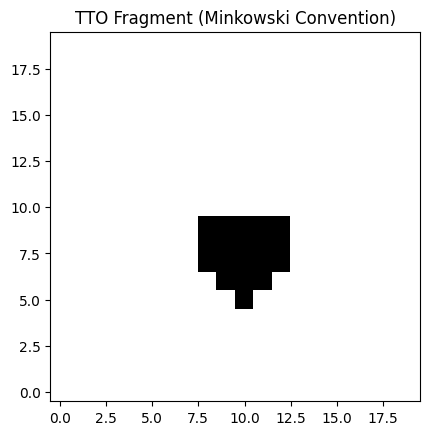

In [185]:
#plot_fragment(TTO_FRAGMENTS["plc_forget_5"])

# Experiments Defs

In [343]:
experiments = {}

experiments = {
    # Experiment 1 inertial
    "Exp 1 Inertial No Current": {
        "mask": define_custom_light_cone(10, 10, 10 // 2, 10 // 2, future_node + plc1_tail + plc2_minus_1 + plc3_minus_2 + plc4_minus_2),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Exp 1 Inertial No Current",
        "center_i": 10 // 2,
        "center_j": 10 // 2,
        "observer_type": "inertial",
        "M": 10,
        "N": 10,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    # Experiment 1 accelerated
    "Exp 1 Accelerated No Current": {
        "mask": define_custom_light_cone(10, 10, 10 // 2, 10 // 2, acc_future_node + plc1_tail + plc2_minus_1 + plc3_minus_2 + plc4_minus_2),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Exp 1 Accelerated No Current",
        "center_i": 10 // 2,
        "center_j": 10 // 2,
        "observer_type": "inertial",
        "M": 10,
        "N": 10,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    # Experiment 2 no Current
    "Exp 2 No Current": {
        "mask": define_custom_light_cone(10, 10, 10 // 2, 10 // 2, plc1 + flc1 + plc2 + flc2 + plc3 + flc3 + plc4 + flc4 + plc5 + flc5),
        "kernel": create_space_filling_lattice_kernel(1),
        "label": "Exp 2 No Current",
        "center_i": 10 // 2,
        "center_j": 10 // 2,
        "observer_type": "inertial",
        "M": 10,
        "N": 10,
        "projection": "Space Filling Lattice",
        "d": 1,
        "comments": "",
        "print_order": 0,
        "font_threshold_override": 0.012
    },
    # Experiment 2 with Current
    "Exp 2 With Current": {
        "mask": define_custom_light_cone(10, 10, 10 // 2, 10 // 2, current_node + plc1 + flc1 + plc2 + flc2 + plc3 + flc3 + plc4 + flc4 + plc5 + flc5),
        "kernel": create_space_filling_lattice_kernel(1),
        "label": "Exp 2 With Current",
        "center_i": 10 // 2,
        "center_j": 10 // 2,
        "observer_type": "inertial",
        "M": 10,
        "N": 10,
        "projection": "Space Filling Lattice",
        "d": 1,
        "comments": "",
        "print_order": 0,
        "font_threshold_override": 0.012
    },

    # 1 Tail No Current
    "Inertial Next Event 1 Tail No Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + plc1_tail),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Inert PLC1_tail No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    "Accelerated Next Event 1 Tail No Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, acc_future_node  + plc1_tail),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Acc PLC1_tail No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "accelerating",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    #1 Tail With Current
    "Inertial Next Event 1 Tail With Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + current_node + plc1_tail),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Inert PLC1_tail with_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    "Accelerated Next Event 1 Tail With Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, acc_future_node + current_node + plc1_tail),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Acc PLC1_tail With_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "accelerating",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },

    #PLC 1 No Current
    "Inertial Next Event PLC1 No Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + plc1),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Inert PLC1 No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "d": 2,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    "Accelerated Next Event PLC1 No Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, acc_future_node + plc1),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Acc PLC1 No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "accelerating",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    #PLC 1 With Current
    "Inertial Next Event PLC1 With Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + current_node + plc1),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Inert PLC1 with_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    "Accelerated Next Event PLC1 With Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, acc_future_node + current_node + plc1),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Acc PLC1 With_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "accelerating",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },

    #PLC4_minus No Current
    "Inertial Next Event PLC4_minus No Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + plc1_tail + plc2_minus_1 + plc3_minus_1 + plc4_minus_1),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Inert PLC4_minus No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    "Accelerated Next Event PLC4_minus No Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, acc_future_node + plc1_tail + plc2_minus_1 + plc3_minus_1 + plc4_minus_1),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Acc PLC4_minus No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "accelerating",
        "M": M,
        "N": N,
        "d": 2,
        "projection": "Space Filling Lattice",
        "comments": "",
        "print_order": 0,
    },
    #PLC4_minus With Current
    "Inertial Next Event PLC4_minus With Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + current_node + plc1_tail + plc2_minus_1 + plc3_minus_1 + plc4_minus_1),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Inert PLC4_minus With_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    "Accelerated Next Event PLC4_minus With Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, acc_future_node + current_node + plc1_tail + plc2_minus_1 + plc3_minus_1 + plc4_minus_1),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Acc PLC4_minus With_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "accelerating",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },

    #PLC4 No Current
    "Inertial Next Event PLC4 No Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + plc1 + plc2 + plc3 + plc4),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Inert PLC4 No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    "Accelerated Next Event PLC4 No Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, acc_future_node + plc1 + plc2 + plc3 + plc4),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Inert PLC4 No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "accelerating",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    #PLC4 With Current
    "Inertial Next Event PLC4 With Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + current_node + plc1 + plc2 + plc3 + plc4),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Inert PLC4 with_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    "Accelerated Next Event PLC4 With Current": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, acc_future_node + current_node + plc1 + plc2 + plc3 + plc4),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Acc PLC4 No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "accelerating",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },

    #d=1
    #Symmetrical4 No Current d=1
    "Symmetrical4 No Current d=1": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + plc1 + plc2 + plc3 + plc4 + plc5 + flc1 + flc2 + flc3 + flc4 + flc5),
        "kernel": create_space_filling_lattice_kernel(1),
        "description": "Sym4 No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 1,
        "comments": "",
        "print_order": 0,
    },
    #Symmetrical4 With Current d=1
    "Symmetrical4 With Current d=1": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1 + plc2 + plc3 + plc4 + plc5 + flc1 + flc2 + flc3 + flc4 + flc5),
        "kernel": create_space_filling_lattice_kernel(1),
        "label": "Sym4 With_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 1,
        "comments": "",
        "print_order": 0,
    },
    #Symmetrical4_minus No Current d=1
    "Symmetrical4_minus No Current d=1": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + plc1_tail + plc2_minus_1 + plc3_minus_1 + plc4_minus_1 + plc5_minus_1 +
                                         flc1_tail + flc2_minus_1 + flc3_minus_1 + flc4_minus_1 + flc5_minus_1),
        "kernel": create_space_filling_lattice_kernel(1),
        "label": "Symm4_minus No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 1,
        "comments": "",
        "print_order": 0,
    },
    #Symmetrical4_minus With Current d=1
    "Symmetrical4_minus With Current d=1": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1_tail + plc2_minus_1 + plc3_minus_1 + plc4_minus_1 + plc5_minus_1 +
                                         flc1_tail + flc2_minus_1 + flc3_minus_1 + flc4_minus_1 + flc5_minus_1),
        "kernel": create_space_filling_lattice_kernel(1),
        "label": "Sym4_minus With_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 1,
        "comments": "",
        "print_order": 0,
    },

    #d=2
    #Symmetrical No Current d=1
    "Symmetrical4 No Current d=1": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + plc1 + plc2 + plc3 + plc4 + plc5 + flc1 + flc2 + flc3 + flc4 + flc5),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Sym4 No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    #Symmetrical4 With Current d=1
    "Symmetrical4 With Current d=1": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1 + plc2 + plc3 + plc4 + plc5 + flc1 + flc2 + flc3 + flc4 + flc5),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Sym4 With_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    #Symmetrical4_minus No Current d=1
    "Symmetrical4_minus No Current d=1": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, future_node + plc1_tail + plc2_minus_1 + plc3_minus_1 + plc4_minus_1 + plc5_minus_1 +
                                         flc1_tail + flc2_minus_1 + flc3_minus_1 + flc4_minus_1 + flc5_minus_1),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Symm4_minus No_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
    #Symmetrical4_minus With Current d=1
    "Symmetrical4_minus With Current d=1": {
        "mask": define_custom_light_cone(M, N, center_i, center_j, current_node + future_node + plc1_tail + plc2_minus_1 + plc3_minus_1 + plc4_minus_1 + plc5_minus_1 +
                                         flc1_tail + flc2_minus_1 + flc3_minus_1 + flc4_minus_1 + flc5_minus_1),
        "kernel": create_space_filling_lattice_kernel(2),
        "label": "Sym4_minus With_E00",
        "center_i": center_i,
        "center_j": center_j,
        "observer_type": "inertial",
        "M": M,
        "N": N,
        "projection": "Space Filling Lattice",
        "d": 2,
        "comments": "",
        "print_order": 0,
    },
}

In [350]:
def get_experiment_names(experiments):
    """
    Returns a sorted list of experiment names.

    Parameters:
    - experiments (dict): Dictionary of experiment data.

    Returns:
    - List of experiment names (str).
    """
    return experiments.keys()

experiement_names = get_experiment_names(experiments)
display(experiement_names)

dict_keys(['Exp 1 Inertial No Current', 'Exp 1 Accelerated No Current', 'Exp 2 No Current', 'Exp 2 With Current', 'Inertial Next Event 1 Tail No Current', 'Accelerated Next Event 1 Tail No Current', 'Inertial Next Event 1 Tail With Current', 'Accelerated Next Event 1 Tail With Current', 'Inertial Next Event PLC1 No Current', 'Accelerated Next Event PLC1 No Current', 'Inertial Next Event PLC1 With Current', 'Accelerated Next Event PLC1 With Current', 'Inertial Next Event PLC4_minus No Current', 'Accelerated Next Event PLC4_minus No Current', 'Inertial Next Event PLC4_minus With Current', 'Accelerated Next Event PLC4_minus With Current', 'Inertial Next Event PLC4 No Current', 'Accelerated Next Event PLC4 No Current', 'Inertial Next Event PLC4 With Current', 'Accelerated Next Event PLC4 With Current', 'Symmetrical4 No Current d=1', 'Symmetrical4 With Current d=1', 'Symmetrical4_minus No Current d=1', 'Symmetrical4_minus With Current d=1'])

In [101]:
#display(experiments["Inertial Next Event PLC4_minus No Current"])#

{'mask': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.]]),
 'kernel': array([[0., 0., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0.],
        [0., 0., 1., 0., 0.]]),
 'label': 'Inert PLC4_minus No_E00',
 'center_i': 5,
 'center_j': 5,
 'observer_type': 'inertial',
 'M': 10,
 'N': 10,
 'projection': 'Space Filling Lattice',
 'd': 2,
 'comments': ''}

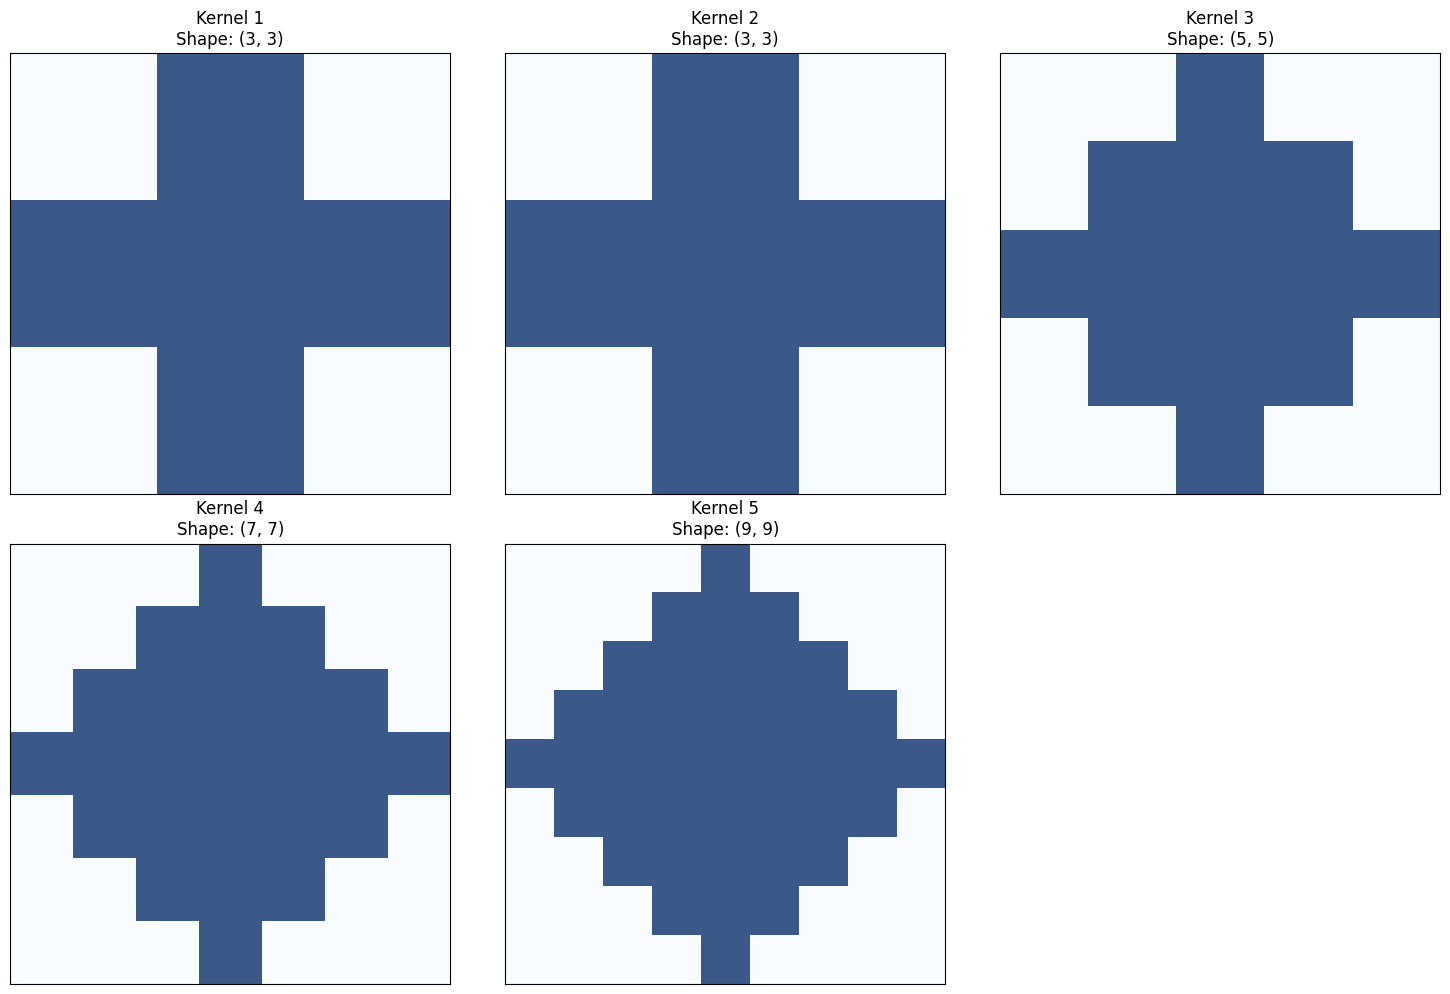

In [294]:
# === I2 Convolution Kernels ===
kernel_shapes = [
    create_uniform_euclidean_kernel(1),  # Small Euc kernel
    create_space_filling_lattice_kernel(1),  # Small MH kernel
    create_space_filling_lattice_kernel(2),  # Ref MH
    create_space_filling_lattice_kernel(3),  # Larger MH kernel
    create_space_filling_lattice_kernel(4)  # Even Larger MH kernel
]
display_kernel_shapes(kernel_shapes,cols=3)

default_kernel = create_space_filling_lattice_kernel(2)
#print(default_kernel)

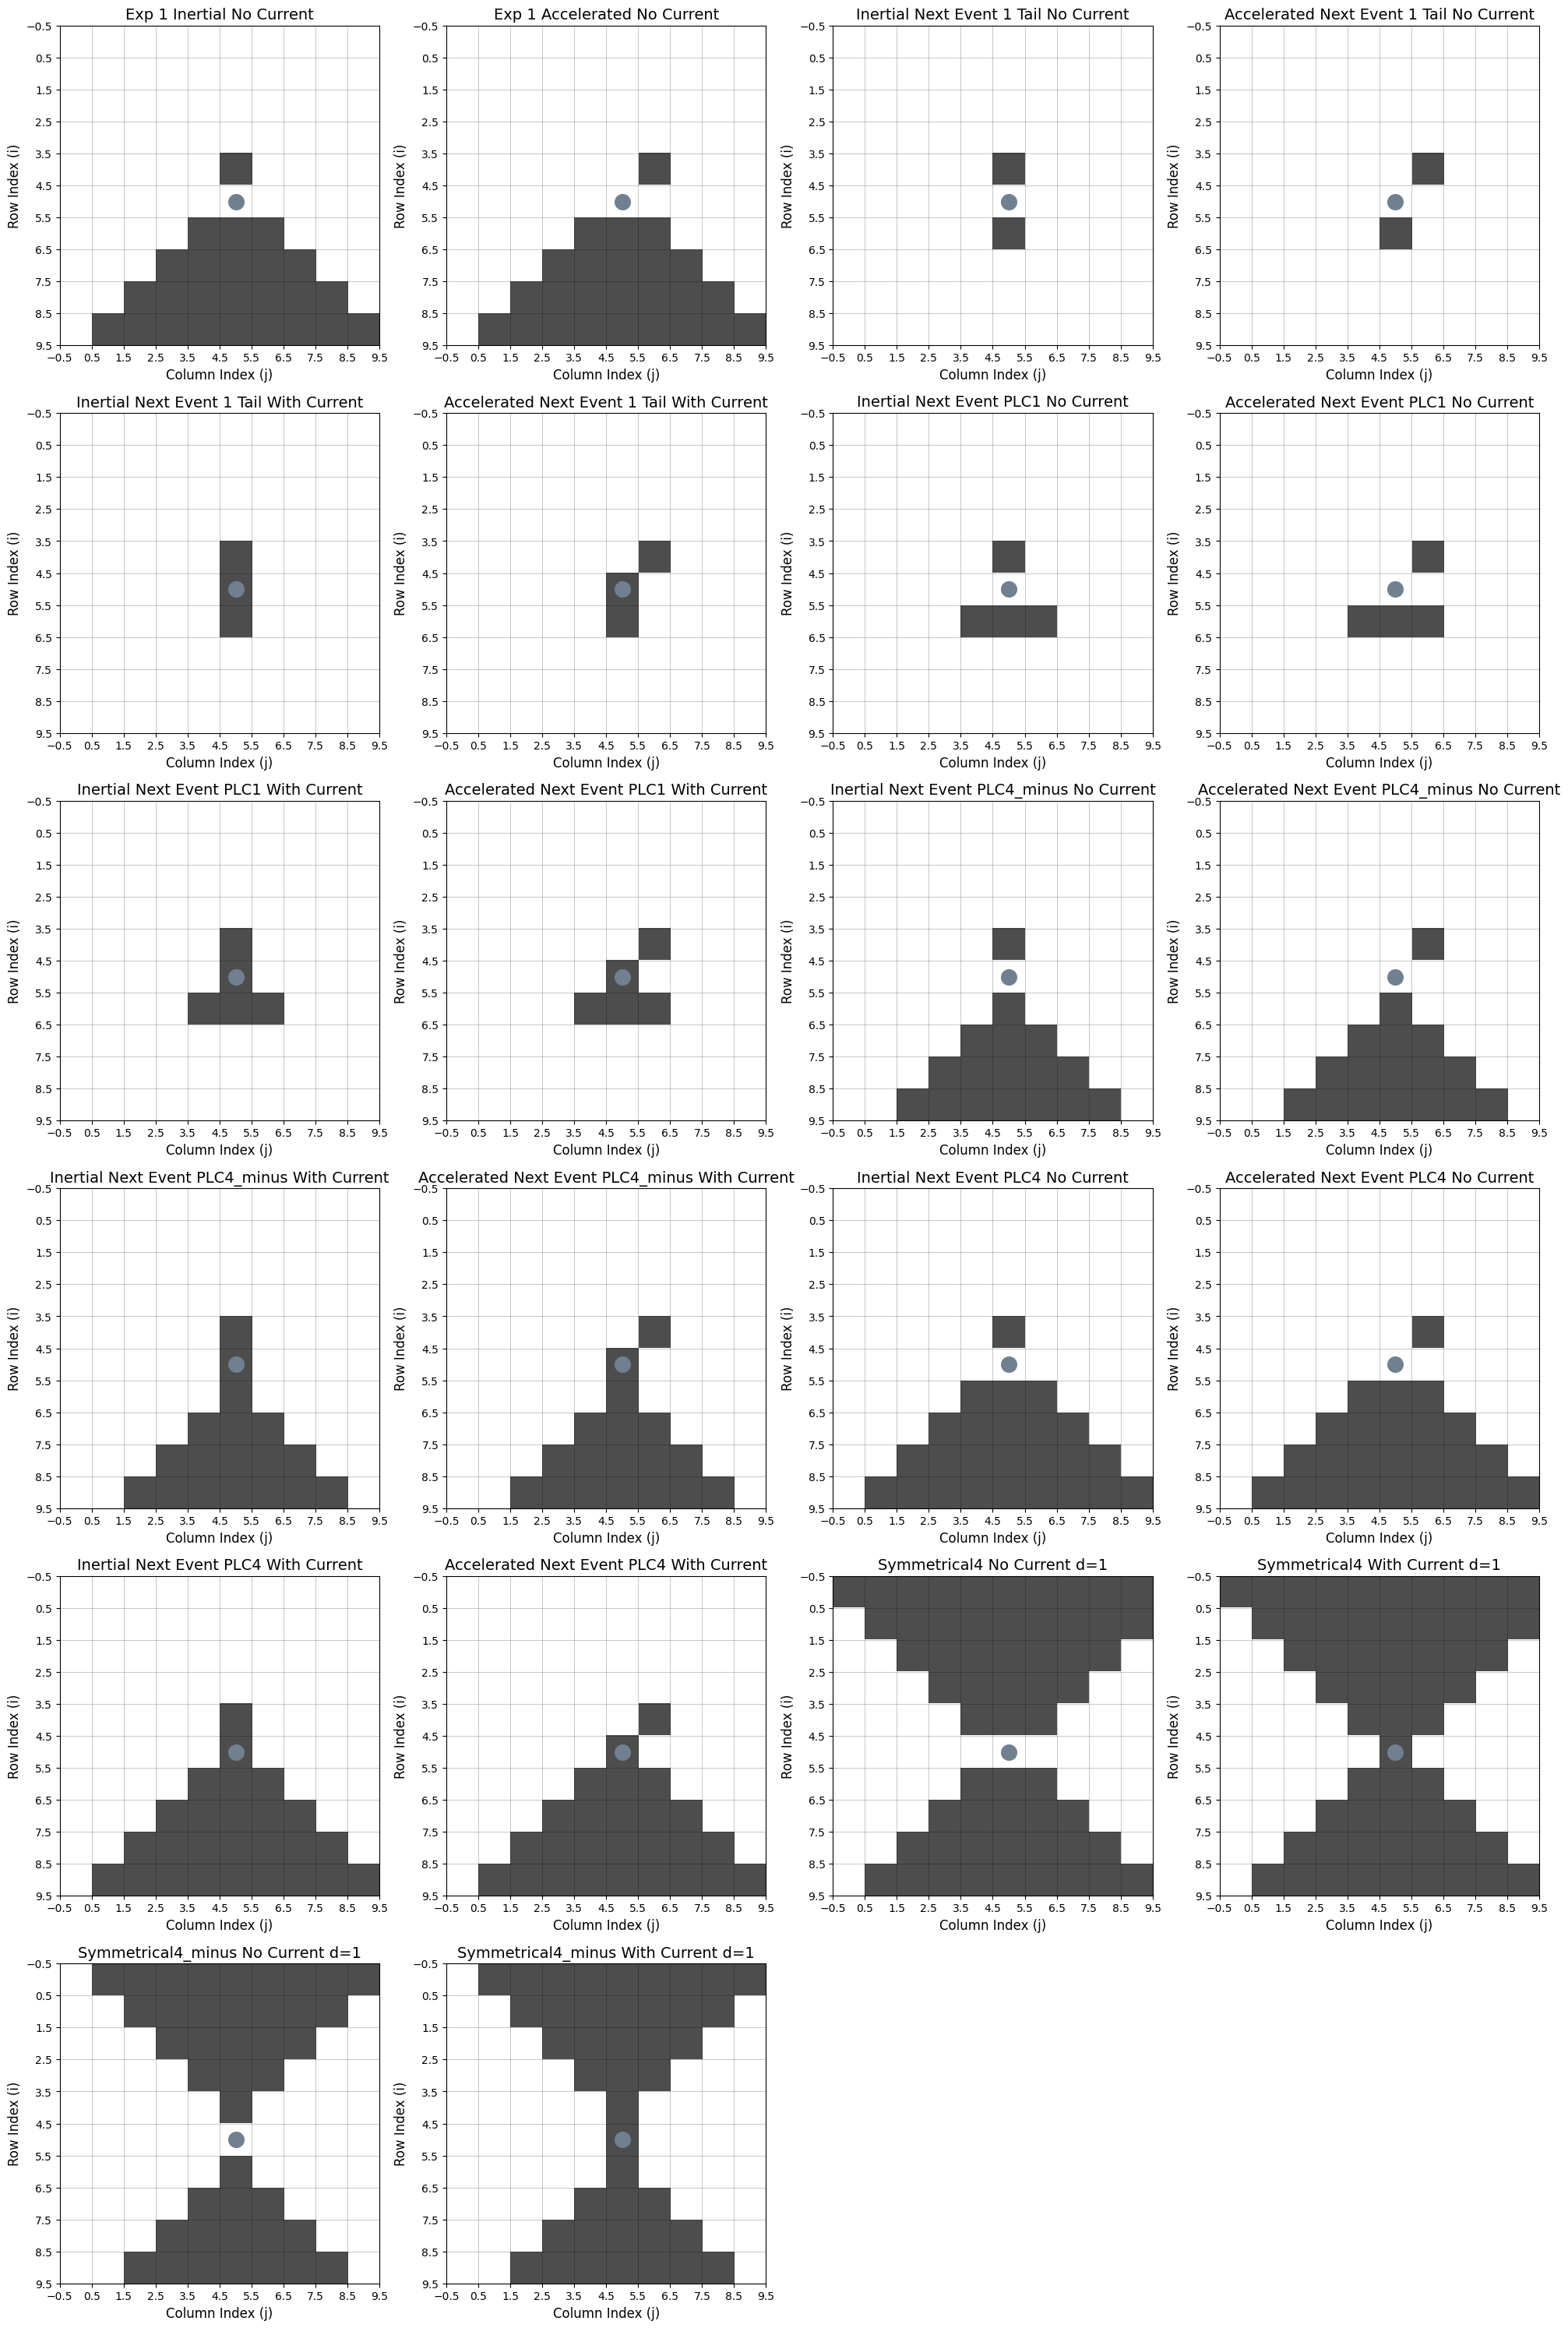

In [297]:
display_tto_masks(experiments, center_i, center_j, cols=4)

# Experiment Functions

In [245]:
# === TTO Experiment Functions ===
import numpy as np
import pandas as pd

def generate_alpha_harmonics(max_val, resolution):
    steps = np.arange(resolution, max_val + resolution, resolution)
    return steps

def compute_alignment_score(values, harmonics):
    closest = np.array([harmonics[np.argmin(np.abs(harmonics - v))] for v in values])
    residuals = np.abs(values - closest)
    return np.mean(residuals), residuals

def generate_foils(values, kind, noise_scale=0.001):
    n = len(values)
    min_val, max_val = np.min(values), np.max(values)
    if kind == 'uniform':
        return np.linspace(min_val, max_val, n)
    elif kind == 'random':
        return np.random.uniform(min_val, max_val, n)
    elif kind == 'uniform+jitter':
        base = np.linspace(min_val, max_val, n)
        jitter = np.random.normal(scale=noise_scale * (max_val - min_val), size=n)
        return base + jitter
    else:
        raise ValueError("Unknown foil kind: choose from ['uniform', 'random', 'uniform+jitter']")

def run_alignment_res_tests(values, alpha, resolutions=[1.0, 0.1, 0.01], foil_kinds=['uniform', 'random', 'uniform+jitter']):
    result = {}
    for res in resolutions:
        res_tag = 'low_res' if res == 1.0 else 'med_res' if res == 0.1 else 'high_res'
        harmonics = generate_alpha_harmonics(np.max(values), resolution=alpha * res)

        # Real alignment
        score, _ = compute_alignment_score(values, harmonics)
        result[f'alignment_real_{res_tag}'] = score

        # Foil alignments
        for fk in foil_kinds:
            foil_values = generate_foils(values, kind=fk)
            score_foil, _ = compute_alignment_score(foil_values, harmonics)
            foil_tag = fk.replace('+', '')
            result[f'alignment_foil_{foil_tag}_{res_tag}'] = score_foil
    return result

def analyze_spectrum_alpha_matching(prob_values, n_range=range(1, 11), tol=0.00005):
    alpha_ns = np.array([alpha / n for n in n_range])
    unique_vals = np.unique(prob_values)

    rows = []
    for val in unique_vals:
        diffs = np.abs(val - alpha_ns)
        closest_idx = np.argmin(diffs)
        min_diff = diffs[closest_idx]
        match = min_diff <= tol
        pct_error = 100 * (val - alpha_ns[closest_idx]) / alpha_ns[closest_idx]
        rows.append({
            'value': val,
            'closest_alpha_n': alpha_ns[closest_idx],
            'n': n_range[closest_idx],
            'percent_error': pct_error,
            'is_match': match
        })

    return pd.DataFrame(rows)

def detect_percent_error_modes(match_df, bin_width=0.05):
    matched = match_df[match_df['is_match'] == True]
    if matched.empty:
        return None, None
    errors = matched['percent_error'].values
    hist, bins = np.histogram(errors, bins=np.arange(min(errors), max(errors)+bin_width, bin_width))
    peak_bin = bins[np.argmax(hist)]
    peak_center = peak_bin + bin_width / 2
    return peak_center, hist.max()

def spectrum_vs_alpha_correlation(prob_values, n_range=range(1, 11)):
    alpha_ns = np.array([alpha / n for n in n_range])
    unique_vals = np.unique(prob_values)

    # Pad/truncate so same length
    min_len = min(len(unique_vals), len(alpha_ns))
    vals = unique_vals[:min_len]
    refs = alpha_ns[:min_len]

    if len(vals) < 3:
        return None

    corr = np.corrcoef(vals, refs)[0, 1]
    return corr


def fractal_dimension_1D(points, num_eps=10):
    """
    Estimates the fractal dimension (box-counting dimension) of a set of points in 1D.

    The function computes, for a range of box sizes (epsilons), the number of intervals needed
    to cover all points, and then fits a line to log(N(eps)) vs. log(eps). The negative slope is
    the estimated fractal dimension.

    Parameters:
      - points (1D array-like): The set of points on the real line.
      - num_eps (int): Number of epsilon values (box sizes) to use (default is 10).

    Returns:
      - D (float): The estimated fractal (box-counting) dimension.
      - epsilons (np.array): The array of epsilon values used.
      - counts (np.array): The corresponding box counts for each epsilon.
    """
    import numpy as np

    points = np.asarray(points)
    if points.size == 0:
        raise ValueError("The input points array is empty.")

    min_val, max_val = points.min(), points.max()
    data_range = max_val - min_val
    if data_range == 0:
        return 0.0, np.array([data_range]), np.array([1])

    # Create epsilon values logarithmically spaced between data_range/num_eps and data_range.
    epsilons = np.logspace(np.log10(data_range/num_eps), np.log10(data_range), num_eps)

    counts = []
    for eps in epsilons:
        # Shift points so that min is 0, then find which box each point falls into.
        box_indices = np.floor((points - min_val) / eps)
        # Count how many unique boxes are occupied.
        N_eps = np.unique(box_indices).size
        counts.append(N_eps)
    counts = np.array(counts)

    # Fit a line to log(epsilons) vs log(counts). The slope (with sign inverted) is the fractal dimension.
    coeffs = np.polyfit(np.log(epsilons), np.log(counts), 1)
    D = -coeffs[0]

    return D, epsilons, counts


from scipy.stats import ttest_ind

def analyze_prob_grid(prob_grid, seed=42):
    """
    Comprehensive analysis of a probability grid including:
    - Structure metrics
    - FFT-based n*alpha wave analysis
    - α-matching residuals and FFT
    - Foil comparisons using strict nulls
    - Welch's t-test of real residuals vs. foil residuals

    Returns:
        Dictionary with all metrics and analysis artifacts.
    """
    values = prob_grid[prob_grid > 0]
    if values.size == 0:
        raise ValueError("The probability grid has no nonzero values.")

    # === Structure Metrics ===
    p = values / np.sum(values)
    H_observed = entropy(p)
    N = values.size
    H_max = np.log(N)
    structure_measure = 1 - (H_observed / H_max)
    fractal_dim = fractal_dimension_1D(values)[0]

    # === n*alpha Wave FFT Analysis ===
    tmp_experiments = {"_temp": {"prob_grid": prob_grid}}
    nalpha_results = analyze_experiments_nalpha_wave(tmp_experiments)["_temp"]

    # === Nearest n*α Matching for Real Values ===
    alpha_match_df = analyze_spectrum_alpha_matching(values)
    dom_mode, mode_count = detect_percent_error_modes(alpha_match_df)
    alpha_corr = spectrum_vs_alpha_correlation(values)

    # === Alignment to α-Harmonics ===
    max_val = np.max(values)
    d_vals = np.arange(0.01, (max_val / alpha) + 0.01, 0.01)
    alpha_targets = d_vals * alpha

    real_residuals = np.min(np.abs(values[:, None] - alpha_targets[None, :]), axis=1)
    real_alignment = np.mean(real_residuals)

    # === Foil Generation ===
    rng = np.random.default_rng(seed)
    num_vals = len(values)

    foil_uniform = np.linspace(0, 1.0, num_vals)
    foil_random = rng.uniform(0, 1.0, size=num_vals)
    foil_uniform_jitter = np.clip(
        np.linspace(0, 1.0, num_vals) + rng.normal(0.0, 0.005 * alpha, size=num_vals), 0, 1.0
    )

    foil_residuals = {}
    foil_t_tests = {}
    for label, foil in [
        ("foil_uniform", foil_uniform),
        ("foil_random", foil_random),
        ("foil_uniform+jitter", foil_uniform_jitter)
    ]:
        residuals = np.min(np.abs(foil[:, None] - alpha_targets[None, :]), axis=1)
        foil_residuals[label] = np.mean(residuals)
        t_stat, p_val = ttest_ind(real_residuals, residuals, equal_var=False)
        foil_t_tests[label] = {"t": t_stat, "p": p_val}

    # === Package All ===
    return {
        "alignment_score": real_alignment,
        "shannon_entropy": H_observed,
        "H_max": H_max,
        "structure_measure": structure_measure,
        "fractal_dimension_1D": fractal_dim,
        "nalpha_wave": nalpha_results,
        #"alpha_match_df": alpha_match_df,
        #"dominant_error_mode": dom_mode,
        #"mode_count": mode_count,
        "alpha_n_correlation": alpha_corr,
        "harmonic_alignment_scores": {
            "real_res_0.01": real_alignment,
            **{f"{k}_res_0.01": v for k, v in foil_residuals.items()}
        },
        "foil_t_tests": foil_t_tests,
        "spectrum_foils": {
            "foil_uniform_res_0.01": foil_uniform,
            "foil_random_res_0.01": foil_random,
            "foil_uniform+jitter_res_0.01": foil_uniform_jitter,
        }
    }


def analyze_experiments_nalpha_wave(experiments):
    """
    Enhanced analysis of n*alpha structure in DIG-RBW spectra.
    Now includes full array of exact % errors for downstream FFT.

    Returns:
      - unique_ns: Binned nearest n values
      - avg_pct_errors: Mean % error per n
      - exact_pct_errors: Full unbinned % error array (new)
      - fft_magnitudes: FFT of avg % error
      - fft_frequencies: Corresponding frequencies
      - dominant_frequency: Strongest non-DC harmonic
      - spectrum: Original tabulated spectrum array
    """
    analysis_results = {}

    for exp_name, exp_data in experiments.items():
        grid = exp_data.get("prob_grid")
        if grid is None:
            print(f"Experiment '{exp_name}' does not contain a 'prob_grid'. Skipping.")
            continue

        # Tabulate real prob_grid spectrum
        tab_data = tabulate_spectrum([grid])
        tab_data = np.array(tab_data)

        nearest_ns = tab_data[:, 3].astype(int)
        pct_errors = tab_data[:, -1].astype(float)  # Column 6 = % error
        exact_pct_errors = pct_errors.copy()

        unique_ns = np.unique(nearest_ns)
        avg_pct_errors = [np.mean(pct_errors[nearest_ns == n]) for n in unique_ns]

        # FFT on avg % error signal
        error_signal = np.array(avg_pct_errors) - np.mean(avg_pct_errors)
        fft_result = np.fft.fft(error_signal)
        fft_magnitudes = np.abs(fft_result)
        fft_frequencies = np.fft.fftfreq(len(avg_pct_errors))
        dominant_frequency = (
            fft_frequencies[np.argmax(fft_magnitudes[1:]) + 1]
            if len(fft_magnitudes) > 1 else 0
        )

        analysis_results[exp_name] = {
            "unique_ns": unique_ns,
            "avg_pct_errors": np.array(avg_pct_errors),
            "exact_pct_errors": exact_pct_errors,  # <-- NEW
            "fft_magnitudes": fft_magnitudes,
            "fft_frequencies": fft_frequencies,
            "dominant_frequency": dominant_frequency,
            "spectrum": tab_data,
        }

    return analysis_results


def analyze_experiments_nalpha_wave_old(experiments):
    """
    Enhanced version of the analysis function that includes the full spectrum data
    and experimental parameters (e.g., M, N, d) for each experiment.

    Parameters:
      - experiments (dict): Dictionary where each experiment contains:
          - 'prob_grid' (2D np.array)
          - 'M', 'N', 'd' (optional metadata)
      - tabulate_spectrum (function): Function to extract spectrum table from a probability grid.

    Returns:
      - analysis_results (dict): Dictionary keyed by experiment name, each containing:
            'unique_ns'          : Array of unique nearest multiples (n) in the tabulated data.
            'avg_pct_errors'     : Average percent error for each n.
            'fft_magnitudes'     : Magnitude spectrum (FFT) of the error signal.
            'fft_frequencies'    : Frequencies corresponding to the FFT components.
            'dominant_frequency' : Dominant frequency (excluding the DC component) of the error signal.
            'spectrum'           : The raw tabulated spectrum data.
            'parameters'         : Dict of metadata from the experiment (M, N, d, etc.)
    """
    analysis_results = {}

    for exp_name, exp_data in experiments.items():
        grid = exp_data.get("prob_grid")
        if grid is None:
            print(f"Experiment '{exp_name}' does not contain a 'prob_grid'. Skipping.")
            continue

        # Tabulate the spectral alignment
        tab_data = tabulate_spectrum([grid])
        tab_data = np.array(tab_data)

        nearest_ns = tab_data[:, 3].astype(int)
        pct_errors = tab_data[:, -1].astype(float)

        unique_ns = np.unique(nearest_ns)
        avg_pct_errors = [np.mean(pct_errors[nearest_ns == n]) for n in unique_ns]

        error_signal = np.array(avg_pct_errors) - np.mean(avg_pct_errors)
        fft_result = np.fft.fft(error_signal)
        fft_magnitudes = np.abs(fft_result)
        fft_frequencies = np.fft.fftfreq(len(avg_pct_errors))

        dominant_frequency = (
            fft_frequencies[np.argmax(fft_magnitudes[1:]) + 1]
            if len(fft_magnitudes) > 1 else 0
        )

        analysis_results[exp_name] = {
            "unique_ns": unique_ns,
            "avg_pct_errors": np.array(avg_pct_errors),
            "fft_magnitudes": fft_magnitudes,
            "fft_frequencies": fft_frequencies,
            "dominant_frequency": dominant_frequency,
            "spectrum": tab_data,
        }

    return analysis_results

def run_experiments(experiments, default_kernel_shape):
    """
    Iterates over a dictionary of experiments, computes the probability grid for each experiment's mask
    using the kernel specified in the experiment's dictionary (if present) or a default kernel,
    analyzes the probability grid, and adds the analysis results to the experiment's entry.

    Parameters:
      - experiments (dict): Dictionary containing experiment details, including a "mask" key, and optionally a "kernel" key.
      - default_kernel_shape (ndarray): The default kernel configuration to use if an experiment does not specify its own.

    Returns:
      - experiments (dict): The updated dictionary with added keys:
            "prob_grid": The computed probability grid.
            "analysis" : A dictionary of computed metrics (alignment_score, shannon_entropy,
                         dominant_frequency, fractal_dimension, etc.).
    """
    for exp_name, exp_data in experiments.items():
        mask = exp_data["mask"]

        # Use the kernel specified in the experiment if available, otherwise use the default.
        k_shape = exp_data.get("kernel", default_kernel_shape)

        # Compute the probability grid using the selected kernel.
        prob_grid = compute_probability_grid(mask, k_shape)

        # Analyze the probability grid using the analyze_prob_grid function.
        analysis_results = analyze_prob_grid(prob_grid)

        # Add the probability grid and analysis results to the experiment's dictionary.
        exp_data["prob_grid"] = prob_grid
        exp_data["analysis"] = analysis_results

        # Optional: print a status update.
        print(f"Processed experiment: {exp_name}")

    return experiments

# Run Experiments

In [344]:
# Run the full DOE to generate probability grids
results = run_experiments(experiments, default_kernel)
#print(results)

Processed experiment: Exp 1 Inertial No Current
Processed experiment: Exp 1 Accelerated No Current
Processed experiment: Exp 2 No Current
Processed experiment: Exp 2 With Current
Processed experiment: Inertial Next Event 1 Tail No Current
Processed experiment: Accelerated Next Event 1 Tail No Current
Processed experiment: Inertial Next Event 1 Tail With Current
Processed experiment: Accelerated Next Event 1 Tail With Current
Processed experiment: Inertial Next Event PLC1 No Current
Processed experiment: Accelerated Next Event PLC1 No Current
Processed experiment: Inertial Next Event PLC1 With Current
Processed experiment: Accelerated Next Event PLC1 With Current
Processed experiment: Inertial Next Event PLC4_minus No Current
Processed experiment: Accelerated Next Event PLC4_minus No Current
Processed experiment: Inertial Next Event PLC4_minus With Current
Processed experiment: Accelerated Next Event PLC4_minus With Current
Processed experiment: Inertial Next Event PLC4 No Current
Proce

# Review Experiments

In [269]:
def compile_and_display_experiment_results(experiments):
    """
    Compiles metrics and parameters from an experiments dictionary into a DataFrame and displays an interactive table.

    Each experiment is expected to have an "analysis" key that may contain:
        - scalar metrics (alignment_score, entropy, etc.)
        - a 'parameters' dict with metadata (M, N, d, etc.)

    Parameters:
    - experiments (dict): Dictionary of experiments. Each entry must have an "analysis" key.

    Returns:
    - df (DataFrame): Compiled DataFrame for further use.
    """

    rows = []

    for exp_name, exp_data in experiments.items():
        analysis = exp_data.get("analysis", {})
        processed = {}

        # Flatten 'parameters' dictionary if present
        params = analysis.get("parameters", {})
        for param_key, param_val in params.items():
            processed[param_key] = param_val

        # Copy over other scalar metrics from the analysis dict
        for key, value in analysis.items():
            if key != "parameters":
                processed[key] = str(value) if isinstance(value, dict) else value

        # Insert experiment name
        row = {"experiment": exp_name}
        row.update(processed)
        rows.append(row)

    # Create the DataFrame
    df = pd.DataFrame(rows)

    # Create interactive widgets
    output_table = widgets.Output()

    def update_table(sort_by="experiment", ascending=True):
        with output_table:
            output_table.clear_output(wait=True)
            sorted_df = df.sort_values(by=sort_by, ascending=ascending)
            display(sorted_df)

    # UI widgets
    sort_by_widget = widgets.Dropdown(
        options=df.columns.tolist(),
        value="experiment",
        description="Sort by:"
    )
    sort_order_widget = widgets.Dropdown(
        options=["Ascending", "Descending"],
        value="Ascending",
        description="Order:"
    )

    def on_change(change):
        update_table(sort_by_widget.value, sort_order_widget.value == "Ascending")

    sort_by_widget.observe(on_change, names="value")
    sort_order_widget.observe(on_change, names="value")

    # Initial display
    update_table()
    display(widgets.HBox([sort_by_widget, sort_order_widget]))
    display(output_table)

    return df


 # === TTO Experiment Plotting Functions ===
def output_experiment_summary(exp_name, exp_data):
    """
    Outputs a textual summary of an experiment's analysis metrics.

    The summary includes:
      - Alignment Score: Average deviation from integer multiples of α.
      - Shannon Entropy: Observed entropy of nonzero probability values and the maximum entropy,
                         from which a structure measure and a probability of no structure are derived.
      - 1D Fractal Dimension: Estimated via the 1D box-counting method.
      - n*α Wave Analysis: Unique nearest multiples, average percent errors per bin, and the dominant FFT frequency.

    Parameters:
      - exp_name (str): The experiment name.
      - exp_data (dict): The experiment data, which must include an "analysis" key containing:
            'alignment_score', 'shannon_entropy', 'H_max', 'structure_measure',
            'fractal_dimension_1D', and 'nalpha_wave'.
    """
    analysis = exp_data.get("analysis", {})
    if not analysis:
        print(f"Experiment '{exp_name}' has no analysis data.")
        return

    print(f"=== Summary for Experiment: {exp_name} ===")

    # Alignment Score.
    alignment = analysis.get("alignment_score", None)
    if alignment is not None:
        print(f"Alignment Score: {alignment:.2e}")
        if alignment < 1e-3:
            print("  → Very low alignment error indicates values are very well aligned with multiples of α.")
        else:
            print("  → A higher alignment error suggests deviations from integer multiples of α.")

    # Shannon Entropy and Structure Measure.
    sh_entropy = analysis.get("shannon_entropy", None)
    H_max = analysis.get("H_max", None)
    structure_measure = analysis.get("structure_measure", None)
    if sh_entropy is not None and H_max is not None:
        print(f"Shannon Entropy: {sh_entropy:.2e} (H_max = {H_max:.2e})")
        print(f"Structure Measure: {structure_measure:.2f})")
        if sh_entropy < 1.0:
            print("  → Lower entropy suggests a more structured (less uniform) distribution.")
        else:
            print("  → Higher entropy indicates a nearly uniform (less structured) distribution.")

    # 1D Fractal Dimension.
    fractal_dim = analysis.get("fractal_dimension_1D", None)
    if fractal_dim is not None:
        print(f"1D Fractal Dimension: {fractal_dim:.2f}")
        if fractal_dim < 1.0:
            print("  → A fractal dimension significantly less than 1 indicates a sparse or highly 'gappy' distribution.")
        else:
            print("  → A fractal dimension near 1 indicates a dense distribution of values on the line.")

    # n*α Wave Analysis.
    nalpha = analysis.get("nalpha_wave", {})
    if nalpha:
        unique_ns = nalpha.get("unique_ns", None)
        avg_pct_errors = nalpha.get("avg_pct_errors", None)
        dominant_frequency = nalpha.get("dominant_frequency", None)
        if unique_ns is not None and avg_pct_errors is not None:
            print("n*α Wave Analysis:")
            print("  Nearest Multiples (n) and Average % Error:")
            for n, err in zip(unique_ns, avg_pct_errors):
                print(f"    n = {n}: Avg % Error = {err:.2f}%")
        if dominant_frequency is not None:
            print(f"  Dominant FFT Frequency (error signal): {dominant_frequency:.3f}")
            print("  → This dominant frequency indicates periodic modulation in the error vs. n*α data.")
    else:
        print("No n*α Wave Analysis data available.")

    print("=" * 50)

In [291]:
df_results = compile_and_display_experiment_results(experiments)

Output()

In [299]:
display(experiments['Exp 1 Inertial No Current'])

{'mask': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 'kernel': array([[0., 0., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0.],
        [0., 0., 1., 0., 0.]]),
 'label': 'Exp 1 Inertial No Current',
 'center_i': 5,
 'center_j': 5,
 'observer_type': 'inertial',
 'M': 10,
 'N': 10,
 'projection': 'Space Filling Lattice',
 'd': 2,
 'comments': '',
 'print_order': 0,
 'prob_grid': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.     

# Plot Experiments

In [345]:
# === Experiment Analysis Workbench ===

plot_experiment("Exp 1 Inertial No Current", experiments["Exp 1 Inertial No Current"])
plot_experiment("Exp 1 Accelerated No Current", experiments["Exp 1 Accelerated No Current"])
plot_experiment("Exp 2 No Current", experiments["Exp 2 No Current"])
plot_experiment("Exp 2 With Current", experiments["Exp 2 With Current"])

plot_experiment("Inertial Next Event 1 Tail No Current", experiments["Inertial Next Event 1 Tail No Current"])
plot_experiment("Accelerated Next Event 1 Tail No Current", experiments["Accelerated Next Event 1 Tail No Current"])
plot_experiment("Inertial Next Event 1 Tail With Current", experiments["Inertial Next Event 1 Tail With Current"])
plot_experiment("Accelerated Next Event 1 Tail With Current", experiments["Accelerated Next Event 1 Tail With Current"])

plot_experiment("Inertial Next Event PLC1 No Current", experiments["Inertial Next Event PLC1 No Current"])
plot_experiment("Accelerated Next Event PLC1 No Current", experiments["Accelerated Next Event PLC1 No Current"])
plot_experiment("Inertial Next Event PLC1 With Current", experiments["Inertial Next Event PLC1 With Current"])
plot_experiment("Accelerated Next Event PLC1 With Current", experiments["Accelerated Next Event PLC1 With Current"])


plot_experiment("Inertial Next Event PLC4_minus No Current", experiments["Inertial Next Event PLC4_minus No Current"])
plot_experiment("Accelerated Next Event PLC4_minus No Current", experiments["Accelerated Next Event PLC4_minus No Current"])
plot_experiment("Inertial Next Event PLC4_minus With Current", experiments["Inertial Next Event PLC4_minus With Current"])
plot_experiment("Accelerated Next Event PLC4_minus No Current", experiments["Accelerated Next Event PLC4_minus No Current"])

plot_experiment("Inertial Next Event PLC4 No Current", experiments["Inertial Next Event PLC4 No Current"])
plot_experiment("Accelerated Next Event PLC4 No Current", experiments["Accelerated Next Event PLC4 No Current"])
plot_experiment("Inertial Next Event PLC4 With Current", experiments["Inertial Next Event PLC4 With Current"])
plot_experiment("Accelerated Next Event PLC4 With Current", experiments["Accelerated Next Event PLC4 With Current"])

plot_experiment("Symmetrical4 No Current d=1", experiments["Symmetrical4 No Current d=1"])
plot_experiment("Symmetrical4 With Current d=1", experiments["Symmetrical4 With Current d=1"])
plot_experiment("Symmetrical4_minus No Current d=1", experiments["Symmetrical4_minus With Current d=1"])
plot_experiment("Symmetrical4_minus With Current d=1", experiments["Symmetrical4_minus With Current d=1"])


Output hidden; open in https://colab.research.google.com to view.

In [213]:
df_spectrum = tabulate_experiment_spectrum_with_foils(experiments["Inertial Next Event PLC4_minus With Current"])
display(df_spectrum)

source     value  count  value/alpha  nearest_n  \
0                      prob_grid 5.025e-03      7    6.886e-01          1   
1                      prob_grid 1.005e-02      7    1.377e+00          1   
2                      prob_grid 1.508e-02      5    2.066e+00          2   
3                      prob_grid 2.010e-02      7    2.754e+00          3   
4                      prob_grid 2.513e-02      4    3.443e+00          3   
5                      prob_grid 3.015e-02      2    4.132e+00          4   
6                      prob_grid 3.518e-02      3    4.820e+00          5   
7                      prob_grid 4.020e-02      2    5.509e+00          6   
8                      prob_grid 4.523e-02      6    6.198e+00          6   
9                      prob_grid 6.030e-02      1    8.263e+00          8   
10         foil_uniform_res_0.01 2.326e-02      1    3.187e+00          3   
11         foil_uniform_res_0.01 4.651e-02      1    6.374e+00          6   
12          foil_random_res_0.01 4.380e-02      1    6.003e+00          6   
13  foil_uniform+jitter_res_0.01 2.326e-02      1    3.188e+00          3   
14  foil_uniform+jitter_res_0.01 4.652e-02      1    6.374e+00          6   

        error  error/alpha   % error  
0  -2.272e-03   -3.114e-01 3.114e+01  
1   2.753e-03    3.772e-01 3.772e+01  
2   4.807e-04    6.587e-02 3.293e+00  
3  -1.792e-03   -2.455e-01 8.184e+00  
4   3.234e-03    4.431e-01 1.477e+01  
5   9.613e-04    1.317e-01 3.293e+00  
6  -1.311e-03   -1.796e-01 3.593e+00  
7  -3.583e-03   -4.910e-01 8.184e+00  
8   1.442e-03    1.976e-01 3.293e+00  
9   1.923e-03    2.635e-01 3.293e+00  
10  1.364e-03    1.869e-01 6.229e+00  
11  2.728e-03    3.738e-01 6.229e+00  
12  1.965e-05    2.693e-03 4.488e-02  
13  1.372e-03    1.880e-01 6.268e+00  
14  2.732e-03    3.744e-01 6.239e+00

# Experiment PDF Output

In [339]:
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os


def save_experiments_to_pdf(experiments, selected_keys=None, pdf_path='dig_experiments_report.pdf'):
    from matplotlib.backends.backend_pdf import PdfPages
    import os

    selected_keys = selected_keys or list(experiments.keys())
    os.makedirs(os.path.dirname(pdf_path) or ".", exist_ok=True)

    with PdfPages(pdf_path) as pdf:
        for exp_name in selected_keys:
            if exp_name not in experiments:
                print(f"⚠️  Experiment '{exp_name}' not found. Skipping.")
                continue

            exp_data = experiments[exp_name]
            fig = plot_experiment(exp_name, exp_data, include_foils=True, return_fig=True)
            pdf.savefig(fig)
            plt.close(fig)
            print(f"✅ Saved: {exp_name}")

    print(f"\n📄 PDF export complete: {pdf_path}")



def save_experiments_to_pdf_old(experiments, selected_keys=None, pdf_path='dig_experiments_report.pdf'):
    """
    Saves visual summaries of multiple DIG-RBW experiments to a single PDF file.

    Parameters:
    - experiments (dict): Dictionary of experiments keyed by name.
    - selected_keys (list of str, optional): Subset of experiment names to export. If None, export all.
    - pdf_path (str): Output path for the combined PDF file.
    """
    selected_keys = selected_keys or list(experiments.keys())
    os.makedirs(os.path.dirname(pdf_path) or ".", exist_ok=True)

    with PdfPages(pdf_path) as pdf:
        for exp_name in selected_keys:
            if exp_name not in experiments:
                print(f"⚠️  Experiment '{exp_name}' not found. Skipping.")
                continue

            exp_data = experiments[exp_name]
            for key in ["mask", "prob_grid", "analysis"]:
                if key not in exp_data:
                    print(f"❌ Skipping '{exp_name}': missing key '{key}'")
                    continue

            # --- Extract Experiment Data ---
            mask_data = exp_data["mask"]
            prob_grid_data = exp_data["prob_grid"]
            analysis = exp_data["analysis"]
            center_i = exp_data.get("center_i", 0)
            center_j = exp_data.get("center_j", 0)
            description = exp_data.get("description", "")
            obs_type = exp_data.get("observer_type", "inertial")
            M = exp_data.get("M", "?")
            N = exp_data.get("N", "?")
            d = exp_data.get("d", "?")
            kernel = exp_data.get("kernel", None)
            nalpha = analysis.get("nalpha_wave", {})

            # --- Titles ---
            overall_title = f"{exp_name}"
            if description:
                overall_title += f" - {description}"

            subtitle = f"M={M}, N={N}, d={d}"
            if kernel is not None:
                subtitle += f" | Kernel Shape: {np.array(kernel).shape}"
            if "alignment_score" in analysis:
                subtitle += f" | Alignment Score = {analysis['alignment_score']:.2e}"
            if "shannon_entropy" in analysis:
                subtitle += f" | Entropy = {analysis['shannon_entropy']:.2f}"
            if "fractal_dimension_1D" in analysis:
                subtitle += f" | FD₁D = {analysis['fractal_dimension_1D']:.2f}"

            # --- Create Figure and Layout ---
            fig = plt.figure(figsize=(22, 32))
            gs = fig.add_gridspec(5, 2, height_ratios=[1.1, 0.7, 1.0, 1.0, 1.0])

            # Row 1: Mask + Heatmap
            ax_mask = fig.add_subplot(gs[0, 0])
            axs_mask = inset_axes(ax_mask, width="90%", height="90%", loc='center')
            plot_mask_2(axs_mask, mask_data, center_i, center_j, observer_type=obs_type, title="Mask")
            ax_mask.axis('off')
            ax_mask.set_xlim(center_j - 5, center_j + 6)
            ax_mask.set_ylim(center_i + 6, center_i - 5)

            ax_heat = fig.add_subplot(gs[0, 1])
            plot_probability_heatmap_2_alpha(ax_heat, prob_grid_data,
                                             center_i=center_i, center_j=center_j,
                                             observer_type=obs_type, grayscale=True,
                                             title="Probability Heatmap")

            # Row 2: Spectrum Table (full width)
            ax_table = fig.add_subplot(gs[1, :])
            table_data = tabulate_spectrum([prob_grid_data])
            dispaly_spectrum_table(ax_table, table_data, title="Spectrum Table")

            # Row 3: Spectrum Histogram + FFT of Bin Counts
            ax_spec = fig.add_subplot(gs[2, 0])
            plot_spectrum_2(ax_spec, [prob_grid_data], title="Spectrum Histogram")

            ax_fft = fig.add_subplot(gs[2, 1])
            spectrum_array = nalpha.get("spectrum")
            if spectrum_array is not None:
                plot_fft_spectrum_from_counts_inline(ax_fft, spectrum_array, experiment_name=exp_name)
                ax_fft.set_title("n*α Wave: FFT of Bin Counts vs. n")
            else:
                ax_fft.text(0.5, 0.5, "No Spectrum Data", ha='center', va='center')

            # Row 4: Avg Error + FFT of Error
            ax_err = fig.add_subplot(gs[3, 0])
            if nalpha and "unique_ns" in nalpha and "avg_pct_errors" in nalpha:
                ax_err.bar(nalpha["unique_ns"], nalpha["avg_pct_errors"],
                           color='white', edgecolor='black', hatch='////')
                ax_err.set_title("Avg % Error vs. Nearest n")
                ax_err.set_xlabel("n")
                ax_err.set_ylabel("% Error")
                ax_err.grid(True)
            else:
                ax_err.text(0.5, 0.5, "No Avg Error Data", ha='center', va='center')
                ax_err.set_title("Avg % Error vs. n")

            ax_errfft = fig.add_subplot(gs[3, 1])
            if nalpha and "avg_pct_errors" in nalpha:
                plot_fft_spectrum_inline(ax_errfft, nalpha["avg_pct_errors"], experiment_name=exp_name)
                ax_errfft.set_title("n*α Wave: FFT of Avg % Error vs. n")
            else:
                ax_errfft.text(0.5, 0.5, "No FFT of Error Data", ha='center', va='center')

            # Finalize and Save to PDF
            fig.suptitle(overall_title, fontsize=24)
            fig.text(0.5, 0.94, subtitle, ha='center', fontsize=18, color='gray')
            plt.tight_layout(rect=[0, 0, 1, 0.92])

            pdf.savefig(fig)
            plt.close(fig)
            print(f"✅ Saved: {exp_name}")

    print(f"\n📄 PDF export complete: {pdf_path}")


In [353]:
#List of experiment keys to include
selected_experiments = [
 'Exp 1 Inertial No Current',
  'Exp 1 Accelerated No Current',
  'Exp 2 No Current',
  'Exp 2 With Current',
  'Inertial Next Event 1 Tail No Current',
  'Accelerated Next Event 1 Tail No Current',
  'Inertial Next Event 1 Tail With Current',
  'Accelerated Next Event 1 Tail With Current',
  'Inertial Next Event PLC1 No Current',
  'Accelerated Next Event PLC1 No Current',
  'Inertial Next Event PLC1 With Current',
  'Accelerated Next Event PLC1 With Current',
  'Inertial Next Event PLC4_minus No Current',
  'Accelerated Next Event PLC4_minus No Current',
  'Inertial Next Event PLC4_minus With Current',
  'Accelerated Next Event PLC4_minus With Current',
  'Inertial Next Event PLC4 No Current',
  'Accelerated Next Event PLC4 No Current',
  'Inertial Next Event PLC4 With Current',
  'Accelerated Next Event PLC4 With Current',
  'Symmetrical4 No Current d=1',
  'Symmetrical4 With Current d=1',
  'Symmetrical4_minus No Current d=1',
  'Symmetrical4_minus With Current d=1'
]


# Call the PDF export function
save_experiments_to_pdf(
    experiments,
    selected_keys=selected_experiments,
    pdf_path='dig_report_selected_experiments.pdf'
)

<ipython-input-333-dc9b964fdb15>:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


✅ Saved: Exp 1 Inertial No Current
✅ Saved: Exp 1 Accelerated No Current
✅ Saved: Exp 2 No Current
✅ Saved: Exp 2 With Current
✅ Saved: Inertial Next Event 1 Tail No Current
✅ Saved: Accelerated Next Event 1 Tail No Current
✅ Saved: Inertial Next Event 1 Tail With Current
✅ Saved: Accelerated Next Event 1 Tail With Current
✅ Saved: Inertial Next Event PLC1 No Current
✅ Saved: Accelerated Next Event PLC1 No Current
✅ Saved: Inertial Next Event PLC1 With Current
✅ Saved: Accelerated Next Event PLC1 With Current
✅ Saved: Inertial Next Event PLC4_minus No Current
✅ Saved: Accelerated Next Event PLC4_minus No Current
✅ Saved: Inertial Next Event PLC4_minus With Current
✅ Saved: Accelerated Next Event PLC4_minus With Current


<ipython-input-246-e276b8cd3b9a>:396: RuntimeWarning: divide by zero encountered in divide
  pct_error = np.abs(values - nearest_vals) / nearest_vals * 100


✅ Saved: Inertial Next Event PLC4 No Current
✅ Saved: Accelerated Next Event PLC4 No Current
✅ Saved: Inertial Next Event PLC4 With Current
✅ Saved: Accelerated Next Event PLC4 With Current
✅ Saved: Symmetrical4 No Current d=1
✅ Saved: Symmetrical4 With Current d=1
✅ Saved: Symmetrical4_minus No Current d=1
✅ Saved: Symmetrical4_minus With Current d=1

📄 PDF export complete: dig_report_selected_experiments.pdf


In [341]:
import pandas as pd
import json
import os

def export_experiment_results(experiments, output_path="dig_results.csv", format="csv"):
    """
    Export key metrics from DIG-RBW experiments to CSV or JSON.

    Parameters:
    - experiments (dict): Dictionary of experiment data.
    - output_path (str): Destination filename (should end in .csv or .json).
    - format (str): Either 'csv' or 'json'.
    """
    records = []

    for name, exp in experiments.items():
        analysis = exp.get("analysis", {})
        summary = {
            "experiment": name,
            "description": exp.get("description", ""),
            "M": exp.get("M", None),
            "N": exp.get("N", None),
            "d": exp.get("d", None),
            "projection": exp.get("projection", None),
            "alignment_score": analysis.get("alignment_score", None),
            "entropy": analysis.get("shannon_entropy", None),
            "fractal_dimension": analysis.get("fractal_dimension_1D", None),
            "alpha_n_corr": analysis.get("alpha_n_correlation", None),
        }

        # Add harmonic scores and t-test p-values if available
        for label, score in (analysis.get("harmonic_alignment_scores", {}) or {}).items():
            summary[f"score_{label}"] = score
        for label, stat in (analysis.get("foil_t_tests", {}) or {}).items():
            summary[f"t_{label}"] = stat.get("t")
            summary[f"p_{label}"] = stat.get("p")

        records.append(summary)

    df = pd.DataFrame(records)
    os.makedirs(os.path.dirname(output_path) or ".", exist_ok=True)

    if format == "csv":
        df.to_csv(output_path, index=False)
    elif format == "json":
        df.to_json(output_path, orient="records", indent=2)
    else:
        raise ValueError("Format must be 'csv' or 'json'")

    print(f"✅ Exported {len(records)} experiments to {output_path}")


In [342]:
export_experiment_results(experiments, "dig_summary.csv", format="csv")
export_experiment_results(experiments, "dig_summary.json", format="json")

✅ Exported 24 experiments to dig_summary.csv
✅ Exported 24 experiments to dig_summary.json


In [68]:
def export_fft_spectrum(experiment_data, title="PLC4-minus (with current)", save_path="fft_plc4_minus.png"):
    freqs = experiment_data['analysis']['nalpha_wave']['fft_frequencies']
    mags = experiment_data['analysis']['nalpha_wave']['fft_magnitudes']
    dominant = experiment_data['analysis']['nalpha_wave']['dominant_frequency']

    plt.figure(figsize=(4.5, 3.0))  # Ideal Springer sizing
    markerline, stemlines, baseline = plt.stem(freqs, mags)
    plt.setp(markerline, color='black', markersize=4)
    plt.setp(stemlines, color='black', linewidth=1.4)
    plt.setp(baseline, color='gray', linewidth=0.5)

    plt.axvline(x=dominant, color='gray', linestyle='--', linewidth=1.0, label=f'Dom freq = {dominant:.3f}')
    plt.axvline(x=-dominant, color='gray', linestyle='--', linewidth=1.0)

    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title(title, fontsize=10)
    plt.grid(True, linestyle=':', linewidth=0.6)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


exp_data_dict = experiments["Inertial Next Event PLC4_minus Memory No Current"]
display(exp_data_dict)
#export_fft_spectrum(exp_data_dict, title="PLC4-minus (with current)", save_path="fft_plc4_minus.png")


{'mask': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.]]),
 'kernel': array([[0., 0., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0.],
        [0., 0., 1., 0., 0.]]),
 'label': 'Inert PLC4_minus No_E00',
 'center_i': 5,
 'center_j': 5,
 'observer_type': 'inertial',
 'M': 10,
 'N': 10,
 'projection': 'Space Filling Lattice',
 'd': 2,
 'comments': '',
 'prob_grid': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.  

In [219]:
def plot_probability_heatmap_alpha_highlight(ax, prob_grid, highlight_mode='fractional', epsilon=0.01, **kwargs):
    """
    Grayscale heatmap with α-alignment highlights.

    highlight_mode:
      - 'integer' for n·α alignment
      - 'fractional' for m·(α/100) style alignment
    """
    # Grayscale colormap
    cmap = plt.cm.Greys.copy()
    cmap.set_under(color='white')

    masked_prob_grid = np.ma.masked_where(prob_grid == 0, prob_grid)
    im = ax.imshow(masked_prob_grid, cmap=cmap, origin='lower', interpolation='nearest', vmin=1e-10)

    # --- Alpha Alignment Highlight ---
    M, N = prob_grid.shape
    for i in range(M):
        for j in range(N):
            val = prob_grid[i, j]
            if val > 0:
                ratio = val / alpha
                if highlight_mode == 'integer':
                    nearest_n = np.round(ratio)
                elif highlight_mode == 'fractional':
                    nearest_n = np.round(ratio * 100) / 100
                delta = abs(ratio - nearest_n)
                if delta < epsilon:
                    ax.scatter(j, i, facecolors='none', edgecolors='red', s=150, linewidths=1.5)

    # Remaining plotting code (grid, annotations, etc.)
    ax.set_title("DIG Probability Heatmap with $\\, \\alpha$ Alignment")
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.invert_yaxis()

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=0.6)
    cbar.ax.set_ylabel('Probability', rotation=-90, va="bottom")

    # Turn off ticks for clean publication
    ax.set_xticks([])
    ax.set_yticks([])




def generate_latex_experiment_table(experiments_dict, notable_peaks_func=None):
    """
    Generate LaTeX table rows from DIG experiments dictionary.

    Parameters:
    - experiments_dict: dict containing experiment metadata.
    - notable_peaks_func: optional function to extract peak info from spectrum data.
    """
    rows = []
    for exp_id, data in experiments_dict.items():
        steps = data.get('steps', 'N/A')
        mask = data.get('mask_type', 'N/A')
        comments = data.get('comments', '')

        # Example: Extract notable peaks if function provided
        if notable_peaks_func and 'spectrum' in data:
            peaks = notable_peaks_func(data['spectrum'])
        else:
            peaks = '—'

        row = f"{exp_id} & {steps} & {mask} & {peaks} & {comments} \\\\"
        rows.append(row)

    latex_output = "\\hline\n" + "\n\\hline\n".join(rows) + "\n\\hline"
    print(latex_output)


In [220]:
# Example histogram of counts across n*alpha bins (from experiment)
#n_alpha_hist = [0, 5, 12, 7, 3, 0, 1, 0]  # Example for n=0 to n=7
#plot_fft_spectrum(n_alpha_hist, experiment_name="PLC4-minus With Current", save_path="fft_plc4_minus.png")

In [221]:
# ===Experiment Comparison Functions ===

def pair_experiments(experiments, exp_name_1, exp_name_2):
    """
    Creates a paired experiment dictionary combining two selected experiments' data and analyses,
    including a probability difference grid.

    Parameters:
      - experiments (dict): Dictionary of experiment data, including "prob_grid" and "analysis".
      - exp_name_1 (str): Name of the first experiment to pair.
      - exp_name_2 (str): Name of the second experiment to pair.

    Returns:
      - experiment_pair (dict): Dictionary containing:
            "experiment_1": Full details of the first experiment.
            "experiment_2": Full details of the second experiment.
            "comparison"  : Dictionary comparing key metrics across both experiments, including a
                            probability difference grid.
    """

    if exp_name_1 not in experiments or exp_name_2 not in experiments:
        raise KeyError(f"One or both experiment names not found: '{exp_name_1}', '{exp_name_2}'")

    # Retrieve the two experiments
    exp1 = experiments[exp_name_1]
    exp2 = experiments[exp_name_2]

    # Extract probability grids
    prob_grid_1 = exp1.get("prob_grid")
    prob_grid_2 = exp2.get("prob_grid")

    if prob_grid_1 is None or prob_grid_2 is None:
        raise ValueError(f"One or both experiments are missing probability grids.")

    # Compute probability difference grid
    prob_grid_diff = prob_grid_2 - prob_grid_1

    # Extract analyses for comparison
    analysis1 = exp1.get("analysis", {})
    analysis2 = exp2.get("analysis", {})

    # Generate a comparison dictionary
    comparison = {
        "alignment_score_diff": analysis1.get("alignment_score", 0) - analysis2.get("alignment_score", 0),
        "shannon_entropy_diff": analysis1.get("shannon_entropy", 0) - analysis2.get("shannon_entropy", 0),
        "structure_measure_diff": analysis1.get("structure_measure", 0) - analysis2.get("structure_measure", 0),
        "fractal_dimension_diff": analysis1.get("fractal_dimension_1D", 0) - analysis2.get("fractal_dimension_1D", 0),
        "prob_grid_diff": prob_grid_diff  # Add probability difference grid
    }

    # Create and return the paired experiment dictionary
    experiment_pair = {
        "experiment_1": {
            "name": exp_name_1,
            "mask": exp1.get("mask"),
            "kernel": exp1.get("kernel"),
            "prob_grid": prob_grid_1,
            "analysis": analysis1
        },
        "experiment_2": {
            "name": exp_name_2,
            "mask": exp2.get("mask"),
            "kernel": exp2.get("kernel"),
            "prob_grid": prob_grid_2,
            "analysis": analysis2
        },
        "comparison": comparison
    }

    return experiment_pair



def plot_experiment_comparison(experiment_pair):
    """
    Visualizes the comparison between two selected experiments, showing their probability grids,
    analysis metrics, spectra, spectrum tables, and n*alpha wave FFT plots.

    Parameters:
      - experiment_pair (dict): Dictionary containing:
            - "experiment_1": Full details of the first experiment.
            - "experiment_2": Full details of the second experiment.
            - "comparison"  : Dictionary containing metric differences and probability grid differences.
    """

    exp1 = experiment_pair["experiment_1"]
    exp2 = experiment_pair["experiment_2"]
    comparison = experiment_pair["comparison"]

    # Extract Probability Grids
    prob_grid_1 = exp1["prob_grid"]
    prob_grid_2 = exp2["prob_grid"]
    prob_grid_diff = comparison["prob_grid_diff"]

    # Extract Analyses
    analysis1 = exp1["analysis"]
    analysis2 = exp2["analysis"]

    # Extract n*alpha wave data
    nalpha1 = analysis1.get("nalpha_wave", {})
    nalpha2 = analysis2.get("nalpha_wave", {})

    # Create a 5x3 grid for subplots
    fig, axs = plt.subplots(5, 3, figsize=(24, 36))

    ### --- ROW 1: Probability Heatmaps ---
    plot_probability_heatmap(axs[0, 0], prob_grid_1, title="Experiment 1: Probability Grid")
    plot_probability_heatmap(axs[0, 1], prob_grid_2, title="Experiment 2: Probability Grid")
    plot_probability_heatmap(axs[0, 2], prob_grid_diff, title="Probability Grid Difference")

    ### --- ROW 2: Metrics Comparison ---
    metrics_text_1 = "\n".join([f"{key}: {value:.3f}" for key, value in analysis1.items() if isinstance(value, (int, float))])
    metrics_text_2 = "\n".join([f"{key}: {value:.3f}" for key, value in analysis2.items() if isinstance(value, (int, float))])
    metrics_text_diff = "\n".join([f"{key}: {comparison.get(key + '_diff', 0):.3f}" for key in analysis1.keys() if key in analysis2])

    axs[1, 0].text(0.5, 0.5, metrics_text_1, fontsize=14, ha='center', va='center')
    axs[1, 1].text(0.5, 0.5, metrics_text_2, fontsize=14, ha='center', va='center')
    axs[1, 2].text(0.5, 0.5, metrics_text_diff, fontsize=14, ha='center', va='center')

    axs[1, 0].set_title("Experiment 1 Metrics")
    axs[1, 1].set_title("Experiment 2 Metrics")
    axs[1, 2].set_title("Metric Differences")

    axs[1, 0].axis("off")
    axs[1, 1].axis("off")
    axs[1, 2].axis("off")

    ### --- ROW 3: Spectrum Plots ---
    plot_spectrum(axs[2, 0], [prob_grid_1], title="Experiment 1: Spectrum")
    plot_spectrum(axs[2, 1], [prob_grid_2], title="Experiment 2: Spectrum")

    axs[2, 2].axis("off")  # Empty cell for balance

    ### --- ROW 4: Spectrum Tables ---
    table_data_1 = tabulate_spectrum([prob_grid_1])
    table_data_2 = tabulate_spectrum([prob_grid_2])

    dispaly_spectrum_table(axs[3, 0], table_data_1, title="Experiment 1: Spectrum Table")
    dispaly_spectrum_table(axs[3, 1], table_data_2, title="Experiment 2: Spectrum Table")

    axs[3, 2].axis("off")  # Empty cell for balance

    ### --- ROW 5: n*alpha Wave FFT Plots ---
    if nalpha1 and "fft_frequencies" in nalpha1 and "fft_magnitudes" in nalpha1:
        axs[4, 0].stem(nalpha1["fft_frequencies"], nalpha1["fft_magnitudes"], basefmt=" ")
        axs[4, 0].set_title("Experiment 1: n*alpha Wave FFT Spectrum")
        axs[4, 0].set_xlabel("Frequency")
        axs[4, 0].set_ylabel("Magnitude")
        axs[4, 0].grid(True)
    else:
        axs[4, 0].text(0.5, 0.5, "No FFT Spectrum Data", ha='center', va='center')

    if nalpha2 and "fft_frequencies" in nalpha2 and "fft_magnitudes" in nalpha2:
        axs[4, 1].stem(nalpha2["fft_frequencies"], nalpha2["fft_magnitudes"], basefmt=" ")
        axs[4, 1].set_title("Experiment 2: n*alpha Wave FFT Spectrum")
        axs[4, 1].set_xlabel("Frequency")
        axs[4, 1].set_ylabel("Magnitude")
        axs[4, 1].grid(True)
    else:
        axs[4, 1].text(0.5, 0.5, "No FFT Spectrum Data", ha='center', va='center')

    axs[4, 2].axis("off")  # Empty cell for balance

    ### --- Final Adjustments ---
    fig.suptitle(f"Comparison of {exp1['name']} vs {exp2['name']}", fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compare_with_without_current(df, experiments_dict, alpha=1/137.036):
    """
    Compare metrics with and without current node included in the entanglement mask,
    and compute closest approach of any prob_grid value to an integer multiple of alpha.

    Parameters:
        df (pd.DataFrame): Results DataFrame with metadata and metrics.
        experiments_dict (dict): Dictionary mapping experiment names to data with 'prob_grid'.
        alpha (float): Fine-structure constant (default ≈ 1/137.036).
    """
    comparison_results = []

    # Group experiments by shared base name
    exp_base_names = sorted(set(exp.replace(" With Current", "").replace("No Current", "").strip()
                                for exp in df['experiment']))

    metrics = ['alignment_score', 'structure_measure','shannon_entropy', 'H_max', 'fractal_dimension_1D']

    for base in exp_base_names:
        row_no = df[df['experiment'] == f"{base} No Current"]
        row_yes = df[df['experiment'] == f"{base} With Current"]

        if row_no.empty or row_yes.empty:
            print(f"Skipping incomplete pair for: {base}")
            continue

        row_no = row_no.iloc[0]
        row_yes = row_yes.iloc[0]

        delta = {metric: row_yes[metric] - row_no[metric] for metric in metrics}

        # Closest-to-n*alpha metric
        def closest_nalpha_score(prob_grid):
            values = prob_grid[prob_grid > 0].flatten()
            if values.size == 0:
                return np.nan
            n_alpha = values / alpha
            nearest_n = np.round(n_alpha)
            return np.min(np.abs(n_alpha - nearest_n))

        grid_no = experiments_dict[row_no['experiment']]['prob_grid']
        grid_yes = experiments_dict[row_yes['experiment']]['prob_grid']

        closest_no = closest_nalpha_score(grid_no)
        closest_yes = closest_nalpha_score(grid_yes)

        delta['closest_to_nalpha'] = closest_yes - closest_no
        delta['experiment'] = base
        comparison_results.append(delta)

    deltas_df = pd.DataFrame(comparison_results)
    print("\nΔ Metrics (With Current - No Current):\n")
    print(deltas_df.round(5))

    # Plotting
    plot_metrics = metrics + ['closest_to_nalpha']
    fig, ax = plt.subplots(figsize=(10, 6))
    for metric in plot_metrics:
        ax.plot(deltas_df['experiment'], deltas_df[metric], marker='o', label=metric)
    ax.set_ylabel("Δ Value (With - Without)")
    ax.set_title("Effect of Including Current Node (Δ Metric Values)")
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.legend(loc='best')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return deltas_df


Skipping incomplete pair for: Symmetrical4  d=1
Skipping incomplete pair for: Symmetrical4 d=1
Skipping incomplete pair for: Symmetrical4_minus  d=1
Skipping incomplete pair for: Symmetrical4_minus d=1

Δ Metrics (With Current - No Current):

   alignment_score  structure_measure  shannon_entropy     H_max  \
0        1.200e-04          1.513e-02       -3.660e-03 4.445e-02   
1       -4.900e-04          1.201e-02       -4.046e-02 0.000e+00   
2        1.000e-05         -5.870e-03        2.298e-02 0.000e+00   
3        2.300e-04         -8.600e-03        5.451e-02 2.410e-02   
4        3.300e-04          1.695e-02        3.624e-02 9.097e-02   
5       -4.700e-04          1.058e-02       -3.562e-02 0.000e+00   
6        2.400e-04         -5.970e-03        2.334e-02 0.000e+00   
7        1.700e-04         -4.580e-03        6.248e-02 4.879e-02   

   fractal_dimension_1D  closest_to_nalpha  \
0             3.495e-01         -2.431e-01   
1            -2.091e-02          1.417e-02   
2     

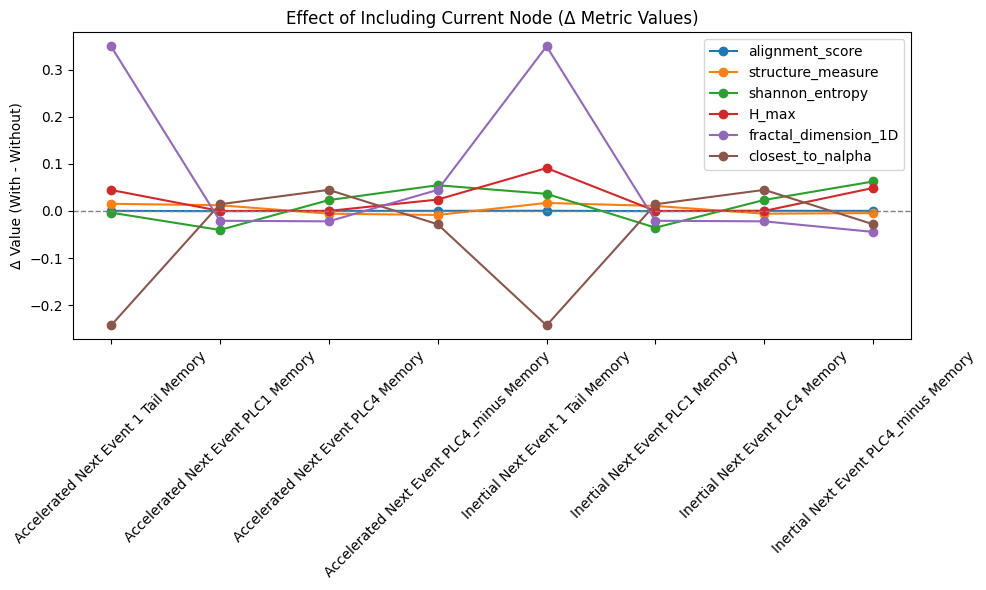

In [222]:
delta_table = compare_with_without_current(df_results, experiments)

In [122]:
# List the experiment names you want to process
selected_experiments = ['Inertial Next Event PLC4_minus Memory With Current'] #, 'Accelerated Next Event PLC4_minus Memory With Current']

# Loop through selected results by key
for exp_name in selected_experiments:
    if exp_name in experiments:
        exp_data = experiments[exp_name]
        print(f"Processing: {exp_name}")
        #display(exp_data)
        plot_experiment_pdf(exp_name, exp_data)   # Pass name and data
    else:
        print(f"Warning: '{exp_name}' not found in experiments dictionary.")


Processing: Inertial Next Event PLC4_minus Memory With Current
Saved: appendix_exports/Inertial Next Event PLC4_minus Memory With Current.pdf


In [117]:
for name, data in experiments.items():
    plot_experiment_pdf(name, data)

Saved: appendix_exports/Inertial Next Event 1 Tail Memory No Current.pdf
Saved: appendix_exports/Accelerated Next Event 1 Tail Memory No Current.pdf
Saved: appendix_exports/Inertial Next Event 1 Tail Memory With Current.pdf
Saved: appendix_exports/Accelerated Next Event 1 Tail Memory With Current.pdf
Saved: appendix_exports/Inertial Next Event PLC1 Memory No Current.pdf
Saved: appendix_exports/Accelerated Next Event PLC1 Memory No Current.pdf
Saved: appendix_exports/Inertial Next Event PLC1 Memory With Current.pdf
Saved: appendix_exports/Accelerated Next Event PLC1 Memory With Current.pdf
Saved: appendix_exports/Inertial Next Event PLC4_minus Memory No Current.pdf
Saved: appendix_exports/Accelerated Next Event PLC4_minus Memory No Current.pdf
Saved: appendix_exports/Inertial Next Event PLC4_minus Memory With Current.pdf
Saved: appendix_exports/Accelerated Next Event PLC4_minus Memory With Current.pdf
Saved: appendix_exports/Inertial Next Event PLC4 Memory No Current.pdf
Saved: appendix

# 3D Viewer

In [101]:
def visualize_probability_surface_v6(prob_grid, center_i, center_j,
                                          future_i, future_j,
                                          offset=0.05,
                                          invert_surface=False,
                                          norm_to_alpha=False,
                                          aspectratio=dict(x=1.5, y=1, z=0.85),
                                          event_threshold=1e-4,
                                          show_event_labels=True,
                                          surface_opacity=0.8,
                                          show_center_lines=True,
                                          plot_title="3D Probability Surface",
                                          current_node_type="none",
                                          future_node_type="none",
                                          draw_future_link=True,
                                     ):

    flipped_grid = np.flipud(prob_grid)
    M, N = flipped_grid.shape
    new_center_i = M - 1 - center_i
    new_future_i = M - 1 - future_i

    def draw_custom_incidence(fig, node_i, node_j, node_type, color='orange'):

        z_offset = 0.02  # lift lines above surface

        def plot_line(i0, j0, i1, j1):
            if 0 <= i0 < M and 0 <= j0 < N and 0 <= i1 < M and 0 <= j1 < N:
                x0, y0 = j0 - center_j, i0 - new_center_i
                x1, y1 = j1 - center_j, i1 - new_center_i
                z0 = flipped_grid[i0, j0] + z_offset
                z1 = flipped_grid[i1, j1] + z_offset
                fig.add_trace(go.Scatter3d(
                    x=[x0, x1],
                    y=[y0, y1],
                    z=[z0, z1],
                    mode='lines',
                    line=dict(color=color, width=10, dash="dot"),  # thicker, lifted lines
                    showlegend=False
                ))

        if node_type == "inertial":
            i1, j1 = node_i + 1, node_j
            plot_line(node_i, node_j, i1, j1)
            plot_line(i1, j1, i1, j1 - 1)
            plot_line(i1, j1, i1, j1 + 1)

        elif node_type == "accelerated":
            # relative shape
            plot_line(node_i,     node_j,     node_i,     node_j + 1)
            plot_line(node_i,     node_j + 1, node_i + 1, node_j + 1)
            plot_line(node_i,     node_j,     node_i + 1, node_j)
            plot_line(node_i + 1, node_j,     node_i + 1, node_j + 1)


    if invert_surface:
        flipped_grid = -flipped_grid

    if norm_to_alpha:
        global alpha
        flipped_grid = flipped_grid / alpha

    full_x = np.arange(N) - center_j
    full_y = np.arange(M) - new_center_i

    red_x, red_y, red_z, red_labels = [], [], [], []
    for i in range(M):
        for j in range(N):
            prob = flipped_grid[i, j]
            if abs(prob) > event_threshold:
                x = j - center_j
                y = i - new_center_i
                red_x.append(x)
                red_y.append(y)
                red_z.append(prob)
                red_labels.append(f"{prob + offset:.1f}α")

    fig = go.Figure()

    fig.add_trace(go.Surface(
        z=flipped_grid,
        x=full_x,
        y=full_y,
        colorscale='Viridis',
        opacity=surface_opacity,
        showlegend=False
    ))

    # Define label offset magnitude
    x_offset_mag = 0.2  # adjust as needed

    # Offset x positions for labels
    label_x = [x + (x_offset_mag if x > 0 else -x_offset_mag if x < 0 else 0) for x in red_x]
    label_y = red_y
    label_z = [z + offset for z in red_z]

    fig.add_trace(go.Scatter3d(
        x=label_x,
        y=label_y,
        z=label_z,
        mode='text',
        text=red_labels if show_event_labels else None,
        textposition="top center",
        textfont=dict(color="khaki", size=9, family="Arial"),
        showlegend=False
    ))

    fig.add_trace(go.Scatter3d(
        x=[future_j - center_j],
        y=[new_future_i - new_center_i],
        z=[flipped_grid[new_future_i, future_j] * (1.15 if not invert_surface else 1.0)],
        mode='markers',
        marker=dict(size=8, color='lightblue'),
        name='Future Node'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0],
        y=[0],
        z=[flipped_grid[new_center_i, center_j] * (1.025 if not invert_surface else 1.0)],
        mode='markers',
        marker=dict(size=8, color='lightgreen'),
        name='Current Node'
    ))

    if show_center_lines:
        fig.add_trace(go.Scatter3d(
            x=full_x, y=[0]*len(full_x), z=flipped_grid[new_center_i, :],
            mode='lines',
            line=dict(color='turquoise', width=2),
            name='j = 0', showlegend=False
        ))
        fig.add_trace(go.Scatter3d(
            x=[0]*len(full_y), y=full_y, z=flipped_grid[:, center_j],
            mode='lines',
            line=dict(color='turquoise', width=2),
            name='i = 0', showlegend=False
        ))

    draw_custom_incidence(fig, new_center_i, center_j, current_node_type, color='limegreen')
    draw_custom_incidence(fig, new_future_i, future_j, future_node_type, color='orange')

    if draw_future_link:
        fig.add_trace(go.Scatter3d(
            x=[0, future_j - center_j],
            y=[0, new_future_i - new_center_i],
            z=[
                flipped_grid[new_center_i, center_j] * (1.025 if not invert_surface else 1.0),
                flipped_grid[new_future_i, future_j] * (1.15 if not invert_surface else 1.0)
            ],
            mode='lines',
            line=dict(color='white', width=4, dash='dash'),
            name='Inertial Line',
            showlegend=True
        ))

    z_axis_title = "Value / α" if norm_to_alpha else "Probability"
    fig.update_layout(
        title=plot_title,
        width=1400,
        height=800,
        margin=dict(l=50, r=50, b=50, t=50),
        legend=dict(orientation="h", x=0.5, y=-0.1, xanchor="center"),
        scene=dict(
            xaxis=dict(
                title="j",
                autorange=True,
                backgroundcolor="rgba(200,200,230,0.5)",
                gridcolor="mediumslateblue",
                zerolinecolor="mediumslateblue",
                showbackground=False
            ),
            yaxis=dict(
                title="i",
                backgroundcolor="rgba(230,200,230,0.5)",
                gridcolor="mediumslateblue",
                zerolinecolor="mediumslateblue",
                showbackground=False
            ),
            zaxis=dict(
                title=z_axis_title,
                tickformat=".4f",
                titlefont=dict(color="mediumslateblue"),
                tickfont=dict(color="mediumslateblue"),
                color="mediumslateblue",
                tickcolor="mediumslateblue",
                backgroundcolor="rgba(230,230,200,0.5)",
                gridcolor="mediumslateblue",
                zerolinecolor="mediumslateblue",
                showbackground=False
            ),
            #camera=dict(eye=dict(x=1.2, y=0.8, z=0.5)),
            #camera=dict(eye=dict(x=0.8, y=1.0, z=0.1)),
            aspectratio=aspectratio,
            bgcolor='rgb(39,29,71)'
        )
    )

    return fig


def annotate_point(fig, x, y, z, label, offset=(0.2, 0.2, 0.1), color="gold"):
    fig.add_trace(go.Scatter3d(
        x=[x + offset[0]],
        y=[y + offset[1]],
        z=[z + offset[2]],
        mode="text",
        text=[label],
        textfont=dict(size=12, color=color),
        showlegend=False
    ))



import numpy as np
import plotly.graph_objects as go

def visualize_probability_surface_grayscale_box(prob_grid, center_i, center_j,
                                                future_i=None, future_j=None,
                                                offset=0.05,
                                                norm_to_alpha=False,
                                                aspectratio=dict(x=1.5, y=1, z=0.85),
                                                event_threshold=1e-4,
                                                show_event_labels=True,
                                                surface_opacity=0.8,
                                                show_center_lines=True,
                                                draw_future_link=True,
                                                current_node_type="none",
                                                future_node_type="none",
                                                plot_title="3D Grayscale Probability Surface"):
    flipped_grid = np.flipud(prob_grid)
    M, N = flipped_grid.shape
    new_center_i = M - 1 - center_i
    if future_i is not None:
        new_future_i = M - 1 - future_i

    if norm_to_alpha:
        global alpha
        flipped_grid = flipped_grid / alpha

    full_x = np.arange(N) - center_j
    full_y = np.arange(M) - new_center_i
    X, Y = np.meshgrid(full_x, full_y)
    Z = flipped_grid

    fig = go.Figure()

    # Surface
    fig.add_trace(go.Surface(
        z=Z,
        x=X,
        y=Y,
        colorscale=[[0, 'white'], [1, 'black']],
        showscale=False,
        opacity=surface_opacity
    ))

    # Event labels
    if show_event_labels:
        red_x, red_y, red_z, red_labels = [], [], [], []
        for i in range(M):
            for j in range(N):
                val = flipped_grid[i, j]
                if abs(val) > event_threshold:
                    x = j - center_j
                    y = i - new_center_i
                    red_x.append(x)
                    red_y.append(y)
                    red_z.append(val)
                    red_labels.append(f"{val + offset:.1f}α")
        # Offset x for label visibility
        x_offset = lambda x: x + (0.2 if x > 0 else -0.2 if x < 0 else 0)
        fig.add_trace(go.Scatter3d(
            x=[x_offset(x) for x in red_x],
            y=red_y,
            z=[z + offset for z in red_z],
            mode='text',
            text=red_labels,
            textfont=dict(color="dimgray", size=9),
            showlegend=False
        ))

    # Current node marker
    fig.add_trace(go.Scatter3d(
        x=[0],
        y=[0],
        z=[flipped_grid[new_center_i, center_j]],
        mode='markers',
        marker=dict(size=6, color='black', symbol='circle'),
        name='Current Node'
    ))

    # Future node marker (optional)
    if future_i is not None and future_j is not None:
        fig.add_trace(go.Scatter3d(
            x=[future_j - center_j],
            y=[new_future_i - new_center_i],
            z=[flipped_grid[new_future_i, future_j]],
            mode='markers',
            marker=dict(size=6, color='gray', symbol='x'),
            name='Future Node'
        ))
        if draw_future_link:
            fig.add_trace(go.Scatter3d(
                x=[0, future_j - center_j],
                y=[0, new_future_i - new_center_i],
                z=[flipped_grid[new_center_i, center_j], flipped_grid[new_future_i, future_j]],
                mode='lines',
                line=dict(color='black', width=2, dash='dash'),
                showlegend=False
            ))

    # Center slices
    if show_center_lines:
        fig.add_trace(go.Scatter3d(
            x=full_x, y=[0]*len(full_x), z=flipped_grid[new_center_i, :],
            mode='lines', line=dict(color='darkgray', width=1), showlegend=False
        ))
        fig.add_trace(go.Scatter3d(
            x=[0]*len(full_y), y=full_y, z=flipped_grid[:, center_j],
            mode='lines', line=dict(color='darkgray', width=1), showlegend=False
        ))

    # Bounding box (3 edges)
    fig.add_trace(go.Scatter3d(x=[full_x[0], full_x[-1]], y=[full_y[0], full_y[0]], z=[0, 0],
                               mode='lines', line=dict(color='black')))
    fig.add_trace(go.Scatter3d(x=[full_x[0], full_x[0]], y=[full_y[0], full_y[-1]], z=[0, 0],
                               mode='lines', line=dict(color='black')))
    fig.add_trace(go.Scatter3d(x=[full_x[0], full_x[0]], y=[full_y[0], full_y[0]], z=[0, flipped_grid.max()],
                               mode='lines', line=dict(color='black')))

    # Axis label indicators
    fig.add_trace(go.Scatter3d(x=[full_x[-1]], y=[0], z=[0],
                               mode='text', text=['+j'], textfont=dict(size=14, color='black')))
    fig.add_trace(go.Scatter3d(x=[0], y=[full_y[-1]], z=[0],
                               mode='text', text=['+i'], textfont=dict(size=14, color='black')))
    fig.add_trace(go.Scatter3d(x=[0], y=[0], z=[flipped_grid.max()],
                               mode='text', text=['+P'], textfont=dict(size=14, color='black')))

    fig.update_layout(
        title=plot_title,
        width=1000,
        height=750,
        margin=dict(l=40, r=40, t=60, b=40),
        scene=dict(
            xaxis=dict(title="j", showbackground=False, showgrid=False),
            yaxis=dict(title="i", showbackground=False, showgrid=False),
            zaxis=dict(title="P" if not norm_to_alpha else "P / α", showbackground=False),
            aspectratio=aspectratio,
            bgcolor="white"
        ),
        paper_bgcolor="white",
        plot_bgcolor="white"
    )

    return fig




def visualize_probability_surface_grayscale_old(prob_grid, center_i, center_j,
                                            future_i, future_j,
                                            offset=0.05,
                                            norm_to_alpha=False,
                                            aspectratio=dict(x=1.5, y=1, z=0.85),
                                            event_threshold=1e-4,
                                            show_event_labels=True,
                                            surface_opacity=0.8,
                                            show_center_lines=True,
                                            plot_title="3D Probability Surface (Grayscale)",
                                            current_node_type="none",
                                            future_node_type="none",
                                            draw_future_link=True):
    import numpy as np
    import plotly.graph_objects as go

    flipped_grid = np.flipud(prob_grid)
    M, N = flipped_grid.shape
    new_center_i = M - 1 - center_i
    new_future_i = M - 1 - future_i

    if norm_to_alpha:
        global alpha
        flipped_grid = flipped_grid / alpha

    full_x = np.arange(N) - center_j
    full_y = np.arange(M) - new_center_i

    fig = go.Figure()

    # Surface
    fig.add_trace(go.Surface(
        z=flipped_grid,
        x=full_x,
        y=full_y,
        colorscale=[[0, 'white'], [1, 'black']],
        showscale=False,
        opacity=surface_opacity
    ))

    # Markers
    fig.add_trace(go.Scatter3d(
        x=[future_j - center_j],
        y=[new_future_i - new_center_i],
        z=[flipped_grid[new_future_i, future_j] * 1.1],
        mode='markers',
        marker=dict(size=7, color='dimgray'),
        name='Future Node'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0],
        y=[0],
        z=[flipped_grid[new_center_i, center_j] * 1.05],
        mode='markers',
        marker=dict(size=7, color='black'),
        name='Current Node'
    ))

    if draw_future_link:
        fig.add_trace(go.Scatter3d(
            x=[0, future_j - center_j],
            y=[0, new_future_i - new_center_i],
            z=[
                flipped_grid[new_center_i, center_j] * 1.05,
                flipped_grid[new_future_i, future_j] * 1.1
            ],
            mode='lines',
            line=dict(color='gray', width=2, dash='dot'),
            name='Inertial Link'
        ))

    # Center lines
    if show_center_lines:
        fig.add_trace(go.Scatter3d(
            x=full_x, y=[0]*len(full_x), z=flipped_grid[new_center_i, :],
            mode='lines', line=dict(color='gray', width=1), showlegend=False
        ))
        fig.add_trace(go.Scatter3d(
            x=[0]*len(full_y), y=full_y, z=flipped_grid[:, center_j],
            mode='lines', line=dict(color='gray', width=1), showlegend=False
        ))

    # Final layout
    fig.update_layout(
        title=plot_title,
        width=1400,
        height=800,
        margin=dict(l=50, r=50, b=50, t=50),
        scene=dict(
            xaxis=dict(title="j", showbackground=False),
            yaxis=dict(title="i", showbackground=False),
            zaxis=dict(title="Value / α" if norm_to_alpha else "Probability", showbackground=False),
            aspectratio=aspectratio,
            bgcolor='white'
        ),
        paper_bgcolor='white',
        plot_bgcolor='white',
        font=dict(color='black')
    )

    return fig


In [103]:
# --- Assume these helper functions are defined elsewhere ---
# For example:
# def initialize_grid(M, N): ...
# def create_space_filling_lattice_kernel(r): ...
# def define_past_light_cone(M, N, center_i, center_j, k): ...
# def add_future_node(past_cone_mask, center_i, center_j, observer_type): ...
# def compute_probability_grid(light_cone_mask, kernel, epsilon): ...

# ------------------ MAIN ------------------
if __name__ == "__main__":
    M, N = 10, 10  # Grid size (rows(y) x columns(x))
    r = 2          # Kernel radius
    k = 0.5        # Slope factor for the light cone
    observer_type = 'accelerating'
    event_labels = False
    title = "Probability Surface " + observer_type + " Next Event"


    # --- Grid initialization, kernel definition, and scenario calculation ---
    grid, center_i, center_j = initialize_grid(M, N)
    kernel = create_space_filling_lattice_kernel(r)
    binary_kernel = kernel.copy()

    future_i, future_j = calc_future_node(center_i, center_j, observer_type)

    past_cone_mask_1 = define_past_light_cone(M, N, center_i, center_j, k=k)
    light_cone_mask_1, future_node_mask_1 = add_future_node(past_cone_mask_1, center_i, center_j, observer_type=observer_type)
    prob_grid = compute_probability_grid(light_cone_mask_1, kernel, epsilon=1e-10)

    # --- Call the visualization function ---
    #fig_3D_1 = visualize_probability_surface_v6(prob_grid, center_i, center_j, future_i, future_j,
    fig_3D_1 = visualize_probability_surface_grayscale_box(prob_grid, center_i, center_j, future_i, future_j,
                                  offset=0.1,
                                  #invert_surface=False,
                                  norm_to_alpha=True,
                                  aspectratio=dict(x=1.3, y=1.3, z=1.0),
                                  show_event_labels=True,
                                  surface_opacity=0.9,
                                  plot_title = title,
                                  current_node_type="inertial",
                                  future_node_type="accelerated"   )


# --- Add custom annotations here ---
"""fig_3D_1.add_trace(go.Scatter3d(
    x=[2], y=[-1], z=[0.7],
    mode="text",
    text=["Boost Step"],
    textfont=dict(size=14, color="gold"),
    showlegend=False
))

# Draw arrow to the point (just as an example)
fig_3D_1.add_trace(go.Scatter3d(
    x=[1.2, 2], y=[-0.5, -1], z=[0.8, 0.7],
    mode="lines",
    line=dict(color="gold", width=2, dash="dot"),
    showlegend=False
))
"""
# --- Show final annotated figure ---
fig_3D_1.show()


In [ ]:
# --- Assume these helper functions are defined elsewhere ---
# For example:
# def initialize_grid(M, N): ...
# def create_space_filling_lattice_kernel(r): ...
# def define_past_light_cone(M, N, center_i, center_j, k): ...
# def add_future_node(past_cone_mask, center_i, center_j, observer_type): ...
# def compute_probability_grid(light_cone_mask, kernel, epsilon): ...

# ------------------ MAIN ------------------
if __name__ == "__main__":
    M, N = 10, 10  # Grid size (rows(y) x columns(x))
    r = 2          # Kernel radius
    k = 0.5        # Slope factor for the light cone
    observer_type = 'accelerating'
    event_labels = False
    title = "Probability Surface " + observer_type + " Next Event"


    # --- Grid initialization, kernel definition, and scenario calculation ---
    grid, center_i, center_j = initialize_grid(M, N)
    kernel = create_space_filling_lattice_kernel(r)
    binary_kernel = kernel.copy()

    future_i, future_j = calc_future_node(center_i, center_j, observer_type)

    #past_cone_mask_1 = define_past_light_cone(M, N, center_i, center_j, k=k)
    #light_cone_mask_1, future_node_mask_1 = add_future_node(past_cone_mask_1, center_i, center_j, observer_type=observer_type)
    prob_grid = compute_probability_grid(light_cone_mask_1, kernel, epsilon=1e-10)

    # --- Call the visualization function ---
    fig_3D_1 = visualize_probability_surface_v6(prob_grid, center_i, center_j, future_i, future_j,
                                  offset=0.1,
                                  invert_surface=False,
                                  norm_to_alpha=True,
                                  aspectratio=dict(x=1.3, y=1.3, z=1.0),
                                  show_event_labels=True,
                                  surface_opacity=0.9,
                                  plot_title = title,
                                  current_node_type="inertial",
                                  future_node_type="accelerated"   )


# --- Add custom annotations here ---
"""fig_3D_1.add_trace(go.Scatter3d(
    x=[2], y=[-1], z=[0.7],
    mode="text",
    text=["Boost Step"],
    textfont=dict(size=14, color="gold"),
    showlegend=False
))

# Draw arrow to the point (just as an example)
fig_3D_1.add_trace(go.Scatter3d(
    x=[1.2, 2], y=[-0.5, -1], z=[0.8, 0.7],
    mode="lines",
    line=dict(color="gold", width=2, dash="dot"),
    showlegend=False
))
"""
# --- Show final annotated figure ---
fig_3D_1.show()


# Diff Proof diagrams

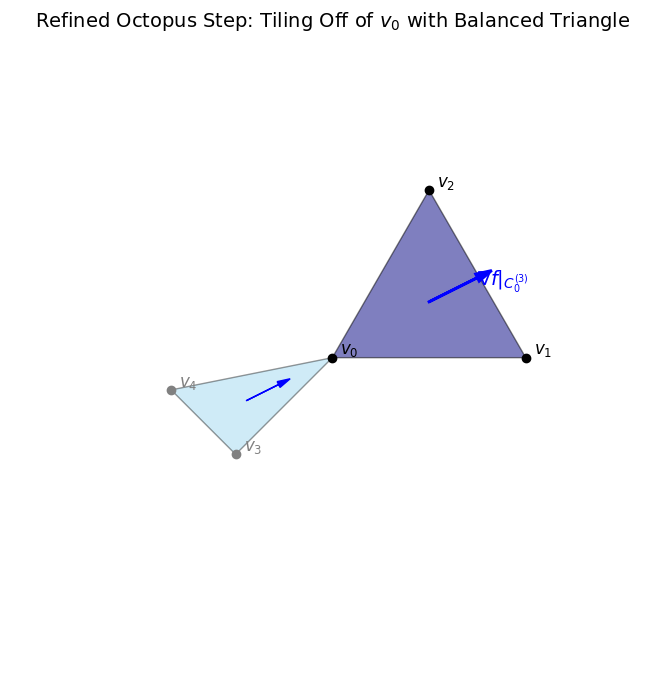

In [ ]:
# Adjust positions of v3 and v4 to create a more equilateral-style triangle (less obtuse)
v3 = np.array([-0.6, -0.6])
v4 = np.array([-1.0, -0.2])

# Redefine triangle C1
C1 = [v0, v3, v4]

# Plot
fig, ax = plt.subplots(figsize=(8, 7))

# Draw seed triangle
seed_triangle = plt.Polygon(C0, closed=True, facecolor='navy', edgecolor='black', alpha=0.5)
ax.add_patch(seed_triangle)

# Draw gradient for seed triangle
centroid = np.mean(C0, axis=0)
ax.arrow(centroid[0], centroid[1], 0.3, 0.15,
         head_width=0.05, head_length=0.1, fc='blue', ec='blue', linewidth=2)
ax.text(centroid[0] + 0.3, centroid[1] + 0.1, r'$\nabla f|_{C^{(3)}_0}$', fontsize=14, color='blue')

# Draw new triangle from v0, v3, v4
new_triangle = plt.Polygon(C1, closed=True, facecolor='skyblue', edgecolor='black', alpha=0.4)
ax.add_patch(new_triangle)

# Draw gradient for new triangle
center_C1 = np.mean(C1, axis=0)
ax.arrow(center_C1[0], center_C1[1], 0.2, 0.1,
         head_width=0.04, head_length=0.08, fc='blue', ec='blue')

# Plot and label all nodes
nodes = [v0, v1, v2, v3, v4]
labels = [r'$v_0$', r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$']
colors = ['black', 'black', 'black', 'gray', 'gray']

for v, label, c in zip(nodes, labels, colors):
    ax.plot(*v, 'o', color=c)
    ax.text(v[0] + 0.05, v[1] + 0.02, label, fontsize=12, color=c)

# Final plot settings
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Refined Octopus Step: Tiling Off of $v_0$ with Balanced Triangle", fontsize=14)
plt.tight_layout()
plt.show()


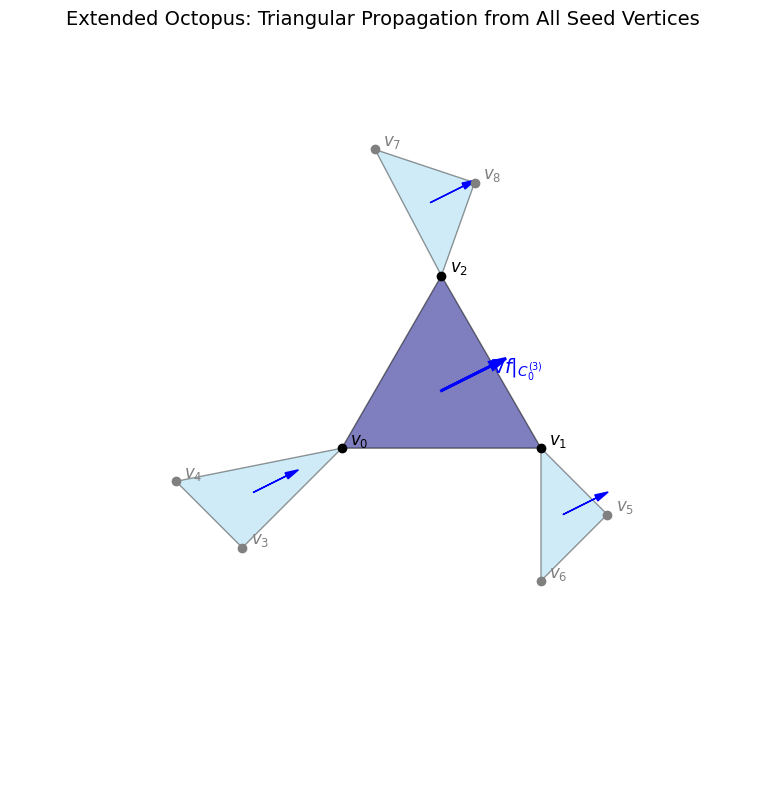

In [ ]:
# Define new triangle off of v1
v5 = np.array([1.6, -0.4])
v6 = np.array([1.2, -0.8])
C2 = [v1, v5, v6]

# Define new triangle off of v2
v7 = np.array([0.2, 1.8])
v8 = np.array([0.8, 1.6])
C3 = [v2, v7, v8]

# Plot
fig, ax = plt.subplots(figsize=(9, 8))

# Draw seed triangle
seed_triangle = plt.Polygon(C0, closed=True, facecolor='navy', edgecolor='black', alpha=0.5)
ax.add_patch(seed_triangle)

# Draw gradient for seed triangle
centroid = np.mean(C0, axis=0)
ax.arrow(centroid[0], centroid[1], 0.3, 0.15,
         head_width=0.05, head_length=0.1, fc='blue', ec='blue', linewidth=2)
ax.text(centroid[0] + 0.3, centroid[1] + 0.1, r'$\nabla f|_{C^{(3)}_0}$', fontsize=14, color='blue')

# Draw the three extension triangles
for triangle_points in [C1, C2, C3]:
    triangle = plt.Polygon(triangle_points, closed=True, facecolor='skyblue', edgecolor='black', alpha=0.4)
    ax.add_patch(triangle)
    center = np.mean(triangle_points, axis=0)
    ax.arrow(center[0], center[1], 0.2, 0.1,
             head_width=0.04, head_length=0.08, fc='blue', ec='blue')

# Plot and label all nodes
nodes = [v0, v1, v2, v3, v4, v5, v6, v7, v8]
labels = [r'$v_0$', r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$',
          r'$v_5$', r'$v_6$', r'$v_7$', r'$v_8$']
colors = ['black', 'black', 'black', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray']

for v, label, c in zip(nodes, labels, colors):
    ax.plot(*v, 'o', color=c)
    ax.text(v[0] + 0.05, v[1] + 0.02, label, fontsize=12, color=c)

# Final plot settings
ax.set_xlim(-2, 2.5)
ax.set_ylim(-2, 2.5)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Extended Octopus: Triangular Propagation from All Seed Vertices", fontsize=14)
plt.tight_layout()
plt.show()


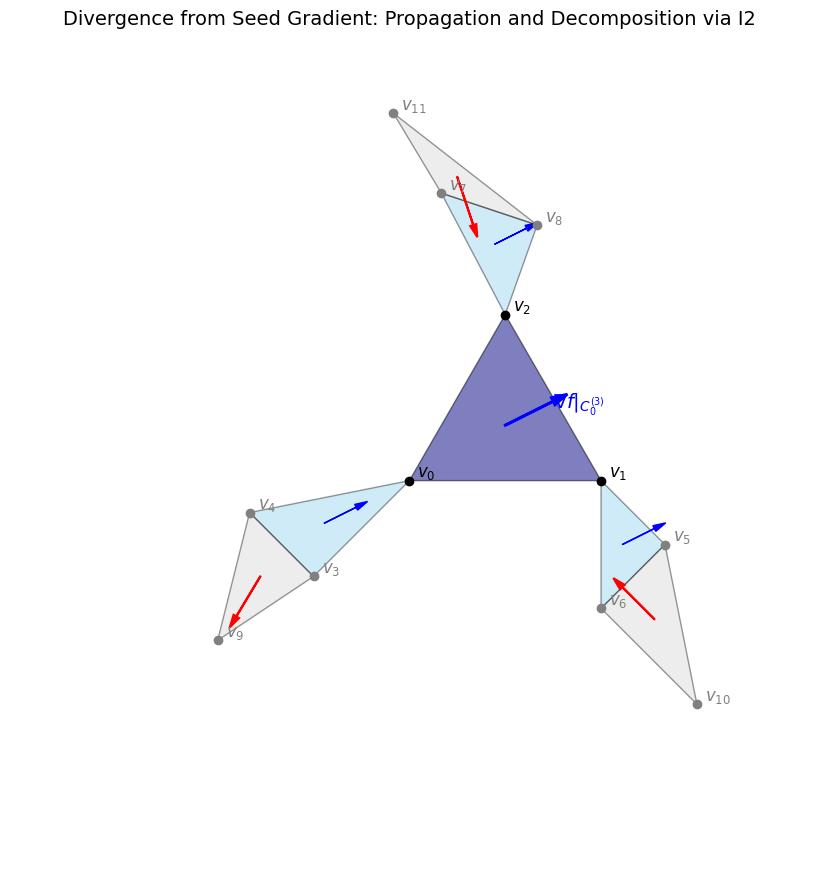

In [ ]:
v3 = np.array([-0.6, -0.6])
v4 = np.array([-1.0, -0.2])

# Redefine triangle C1
C1 = [v0, v3, v4]

# Define diverging extensions off of v3, v6, and v7
v9  = np.array([-1.2, -1.0])
v10 = np.array([1.8, -1.4])
v11 = np.array([-0.1, 2.3])

C4 = [v3, v4, v9]     # from v3
C5 = [v6, v5, v10]    # from v6
C6 = [v7, v8, v11]    # from v7

# Plot
fig, ax = plt.subplots(figsize=(10, 9))

# Draw original seed triangle
seed_triangle = plt.Polygon(C0, closed=True, facecolor='navy', edgecolor='black', alpha=0.5)
ax.add_patch(seed_triangle)
centroid = np.mean(C0, axis=0)
ax.arrow(centroid[0], centroid[1], 0.3, 0.15,
         head_width=0.05, head_length=0.1, fc='blue', ec='blue', linewidth=2)
ax.text(centroid[0] + 0.3, centroid[1] + 0.1, r'$\nabla f|_{C^{(3)}_0}$', fontsize=14, color='blue')

# Previously added extension triangles
for triangle_points in [C1, C2, C3]:
    triangle = plt.Polygon(triangle_points, closed=True, facecolor='skyblue', edgecolor='black', alpha=0.4)
    ax.add_patch(triangle)
    center = np.mean(triangle_points, axis=0)
    ax.arrow(center[0], center[1], 0.2, 0.1,
             head_width=0.04, head_length=0.08, fc='blue', ec='blue')

# Newly added diverging triangles with different gradient direction
diverging_vectors = [np.array([-0.15, -0.25]),  # for C4
                     np.array([-0.2, 0.2]),     # for C5
                     np.array([0.1, -0.3])]     # for C6

for triangle_points, grad in zip([C4, C5, C6], diverging_vectors):
    triangle = plt.Polygon(triangle_points, closed=True, facecolor='lightgray', edgecolor='black', alpha=0.4)
    ax.add_patch(triangle)
    center = np.mean(triangle_points, axis=0)
    ax.arrow(center[0], center[1], grad[0], grad[1],
             head_width=0.04, head_length=0.08, fc='red', ec='red', linewidth=1.5)

# Plot and label all nodes
nodes = [v0, v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11]
labels = [r'$v_0$', r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$',
          r'$v_5$', r'$v_6$', r'$v_7$', r'$v_8$', r'$v_9$', r'$v_{10}$', r'$v_{11}$']
colors = ['black']*3 + ['gray']*9

for v, label, c in zip(nodes, labels, colors):
    ax.plot(*v, 'o', color=c)
    ax.text(v[0] + 0.05, v[1] + 0.02, label, fontsize=12, color=c)

# Final settings
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.8)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Divergence from Seed Gradient: Propagation and Decomposition via I2", fontsize=14)
plt.tight_layout()
plt.show()


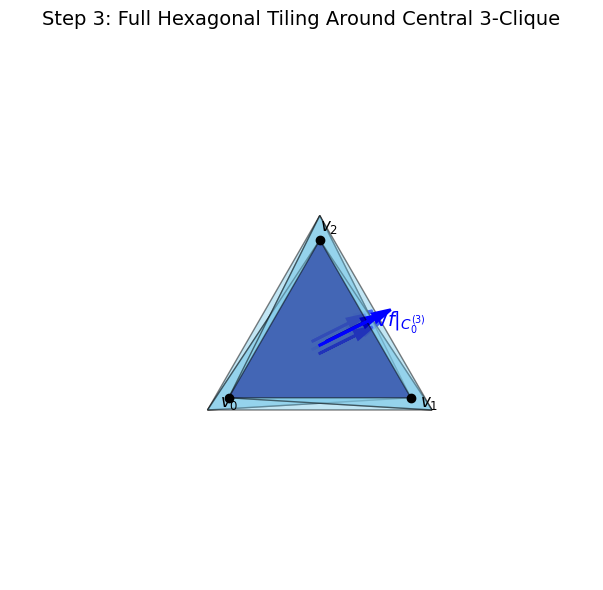

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define central 3-clique (C0)
v0 = np.array([0, 0])
v1 = np.array([1, 0])
v2 = np.array([0.5, np.sqrt(3)/2])
C0 = [v0, v1, v2]

# Define function to draw triangle and optional gradient vector
def draw_triangle(ax, points, color='lightgray', gradient_vector=None):
    triangle = plt.Polygon(points, closed=True, facecolor=color, edgecolor='black', alpha=0.5)
    ax.add_patch(triangle)
    if gradient_vector is not None:
        center = np.mean(points, axis=0)
        ax.arrow(center[0], center[1], gradient_vector[0], gradient_vector[1],
                 head_width=0.05, head_length=0.1, fc='blue', ec='blue', linewidth=2)

# Central triangle gradient vector
gradient_C0 = np.array([0.3, 0.15])

# Compute midpoints and directions for edge-adjacent triangles
def edge_center(p1, p2):
    return (p1 + p2) / 2

# Generate 6 surrounding triangles
surrounding_cliques = []

# Triangle sharing edge v0-v1
dir1 = v1 - v0
normal1 = np.array([-dir1[1], dir1[0]]) / np.linalg.norm(dir1)
v3 = edge_center(v0, v1) + normal1
surrounding_cliques.append([v0, v1, v3])

# Triangle sharing edge v1-v2
dir2 = v2 - v1
normal2 = np.array([-dir2[1], dir2[0]]) / np.linalg.norm(dir2)
v4 = edge_center(v1, v2) + normal2
surrounding_cliques.append([v1, v2, v4])

# Triangle sharing edge v2-v0
dir3 = v0 - v2
normal3 = np.array([-dir3[1], dir3[0]]) / np.linalg.norm(dir3)
v5 = edge_center(v2, v0) + normal3
surrounding_cliques.append([v2, v0, v5])

# Corner-filling triangles to complete ring
surrounding_cliques.append([v3, v1, v4])
surrounding_cliques.append([v4, v2, v5])
surrounding_cliques.append([v5, v0, v3])

# Start plot
fig, ax = plt.subplots(figsize=(7, 6))

# Draw surrounding triangles
for clique in surrounding_cliques:
    draw_triangle(ax, clique, color='skyblue', gradient_vector=np.array([0.2, 0.1]))

# Draw central triangle
draw_triangle(ax, C0, color='navy', gradient_vector=gradient_C0)

# Label vertices
ax.plot(*v0, 'ko')
ax.plot(*v1, 'ko')
ax.plot(*v2, 'ko')
ax.text(v0[0] - 0.05, v0[1] - 0.05, r'$v_0$', fontsize=12)
ax.text(v1[0] + 0.05, v1[1] - 0.05, r'$v_1$', fontsize=12)
ax.text(v2[0], v2[1] + 0.05, r'$v_2$', fontsize=12)

# Label gradient
centroid = np.mean(C0, axis=0)
ax.text(centroid[0] + 0.3, centroid[1] + 0.1, r'$\nabla f|_{C^{(3)}_0}$', fontsize=14, color='blue')

# Plot settings
ax.set_xlim(-1.2, 2)
ax.set_ylim(-1, 2)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Step 3: Full Hexagonal Tiling Around Central 3-Clique", fontsize=14)
plt.tight_layout()
plt.show()


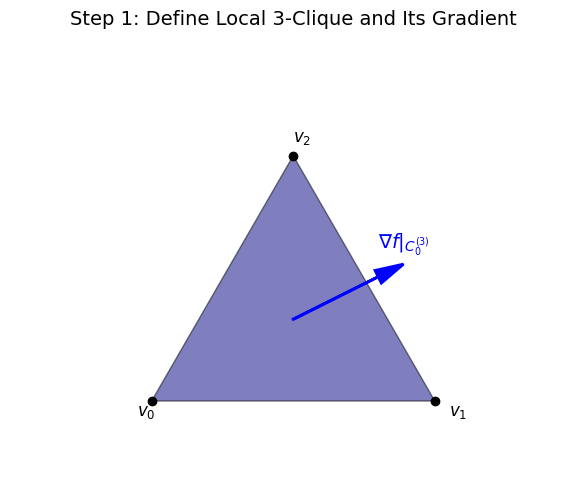

In [ ]:
# Re-run required libraries and code due to execution state reset
import matplotlib.pyplot as plt
import numpy as np

# Base triangle (central clique C0)
v0 = np.array([0, 0])
v1 = np.array([1, 0])
v2 = np.array([0.5, np.sqrt(3)/2])
C0 = [v0, v1, v2]

# Gradient vector for C0
gradient_C0 = np.array([0.3, 0.15])

fig, ax = plt.subplots(figsize=(6, 5))

# Draw central triangle
triangle = plt.Polygon(C0, closed=True, facecolor='navy', edgecolor='black', alpha=0.5)
ax.add_patch(triangle)

# Draw gradient vector at centroid
centroid = np.mean(C0, axis=0)
ax.arrow(centroid[0], centroid[1], gradient_C0[0], gradient_C0[1],
         head_width=0.05, head_length=0.1, fc='blue', ec='blue', linewidth=2)

# Label vertices
ax.plot(*v0, 'ko')
ax.plot(*v1, 'ko')
ax.plot(*v2, 'ko')
ax.text(v0[0] - 0.05, v0[1] - 0.05, r'$v_0$', fontsize=12)
ax.text(v1[0] + 0.05, v1[1] - 0.05, r'$v_1$', fontsize=12)
ax.text(v2[0], v2[1] + 0.05, r'$v_2$', fontsize=12)

# Label gradient
ax.text(centroid[0] + 0.3, centroid[1] + 0.25, r'$\nabla f|_{C^{(3)}_0}$', fontsize=14, color='blue')

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.3, 1.3)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Step 1: Define Local 3-Clique and Its Gradient", fontsize=14)
plt.tight_layout()
plt.show()


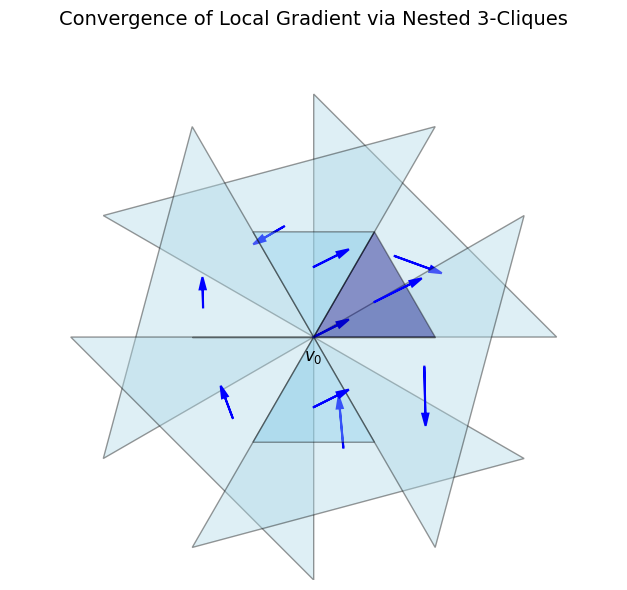

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to draw a triangle given three points
def draw_triangle(ax, points, color='lightgray', edge_color='black', arrow=False, gradient_vector=None):
    tri = plt.Polygon(points, closed=True, facecolor=color, edgecolor=edge_color, alpha=0.4)
    ax.add_patch(tri)
    if arrow and gradient_vector is not None:
        center = np.mean(points, axis=0)
        ax.arrow(center[0], center[1], gradient_vector[0], gradient_vector[1],
                 head_width=0.05, head_length=0.1, fc='blue', ec='blue', linewidth=1.5)

# Base triangle (central clique C0)
v0 = np.array([0, 0])
v1 = np.array([1, 0])
v2 = np.array([0.5, np.sqrt(3)/2])
C0 = [v0, v1, v2]

# Ring of neighboring triangles
offsets = [np.array([1, 0]), np.array([-0.5, np.sqrt(3)/2]), np.array([0.5, -np.sqrt(3)/2])]
neighbor_cliques = []
for offset in offsets:
    neighbor_cliques.append([v0, v0 + offset, v0 + np.array([-offset[0], offset[1]])])

# Second ring (larger neighborhood)
ring2_cliques = []
for theta in np.linspace(0, 2*np.pi, 6, endpoint=False):
    offset = 2 * np.array([np.cos(theta), np.sin(theta)])
    ring2_cliques.append([v0, v0 + offset, v0 + np.array([-offset[1], offset[0]])])

fig, ax = plt.subplots(figsize=(7, 6))

# Draw outer cliques with diverging gradient vectors
for clique in ring2_cliques:
    draw_triangle(ax, clique, color='lightblue', arrow=True, gradient_vector=0.2 * np.random.randn(2))

# Draw inner cliques with more aligned vectors
for clique in neighbor_cliques:
    draw_triangle(ax, clique, color='skyblue', arrow=True, gradient_vector=np.array([0.2, 0.1]))

# Draw central triangle with strong alignment
draw_triangle(ax, C0, color='navy', arrow=True, gradient_vector=np.array([0.3, 0.15]))

# Label central node
ax.text(v0[0], v0[1] - 0.2, r'$v_0$', ha='center', fontsize=12)

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2, 2.5)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Convergence of Local Gradient via Nested 3-Cliques", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
plt.savefig("gradient_cliques.png", dpi=300)

# Next Event Studies (Exp 1)

\begin{table}[htbp]
\centering
\caption{Comparison of probability statistics Inside the light cone.}
\label{tab:inside_comparison}
\begin{tabular}{lrrr}
\toprule
Metric & Inertial Observer & Accelerating Observer & $O_a - O_i$ \\
\midrule
Min Prob & 0.0072464 & 0.0072464 & 0 \\ 
Max Prob & 0.043478 & 0.043478 & 0 \\ 
Total & 0.74275 & 0.74275 & -1.1102e-16 \\ 
\bottomrule
\end{tabular}
\end{table}
\begin{table}[htbp]
\centering
\caption{Comparison of probability statistics Outside the light cone.}
\label{tab:outside_comparison}
\begin{tabular}{lrrr}
\toprule
Metric & Inertial Observer & Accelerating Observer & $O_a - O_i$ \\
\midrule
Min Prob & 0 & 0 & 0 \\ 
Max Prob & 0.018116 & 0.018116 & 0 \\ 
Total & 0.25725 & 0.25725 & 0 \\ 
\bottomrule
\end{tabular}
\end{table}
\begin{tabular}{rrrrrrr}
\toprule
Value & Count & Value/$\alpha$ & nearest_n & Abs Error = $|x - n\alpha|$ & abs_error/$\alpha$ & Pct Error = $\frac{|x - n\alpha|}{n\alpha} \times 100\%$ \\
\midrule
-3.623188e-03 & 1 & -4.

<ipython-input-246-e276b8cd3b9a>:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)  # Set the labels


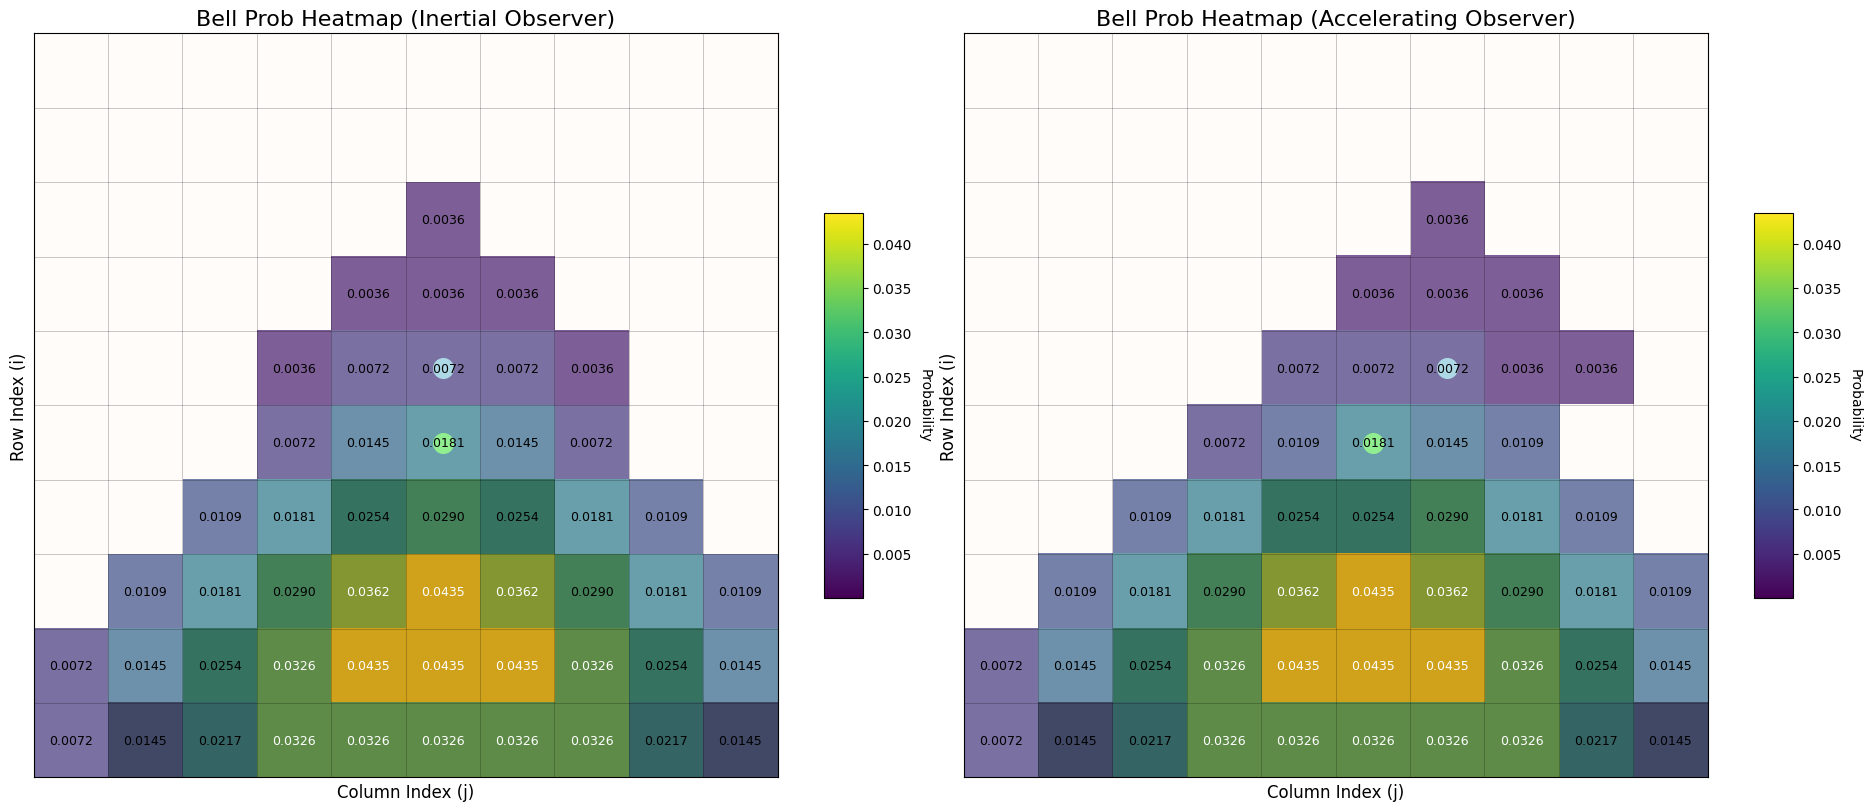

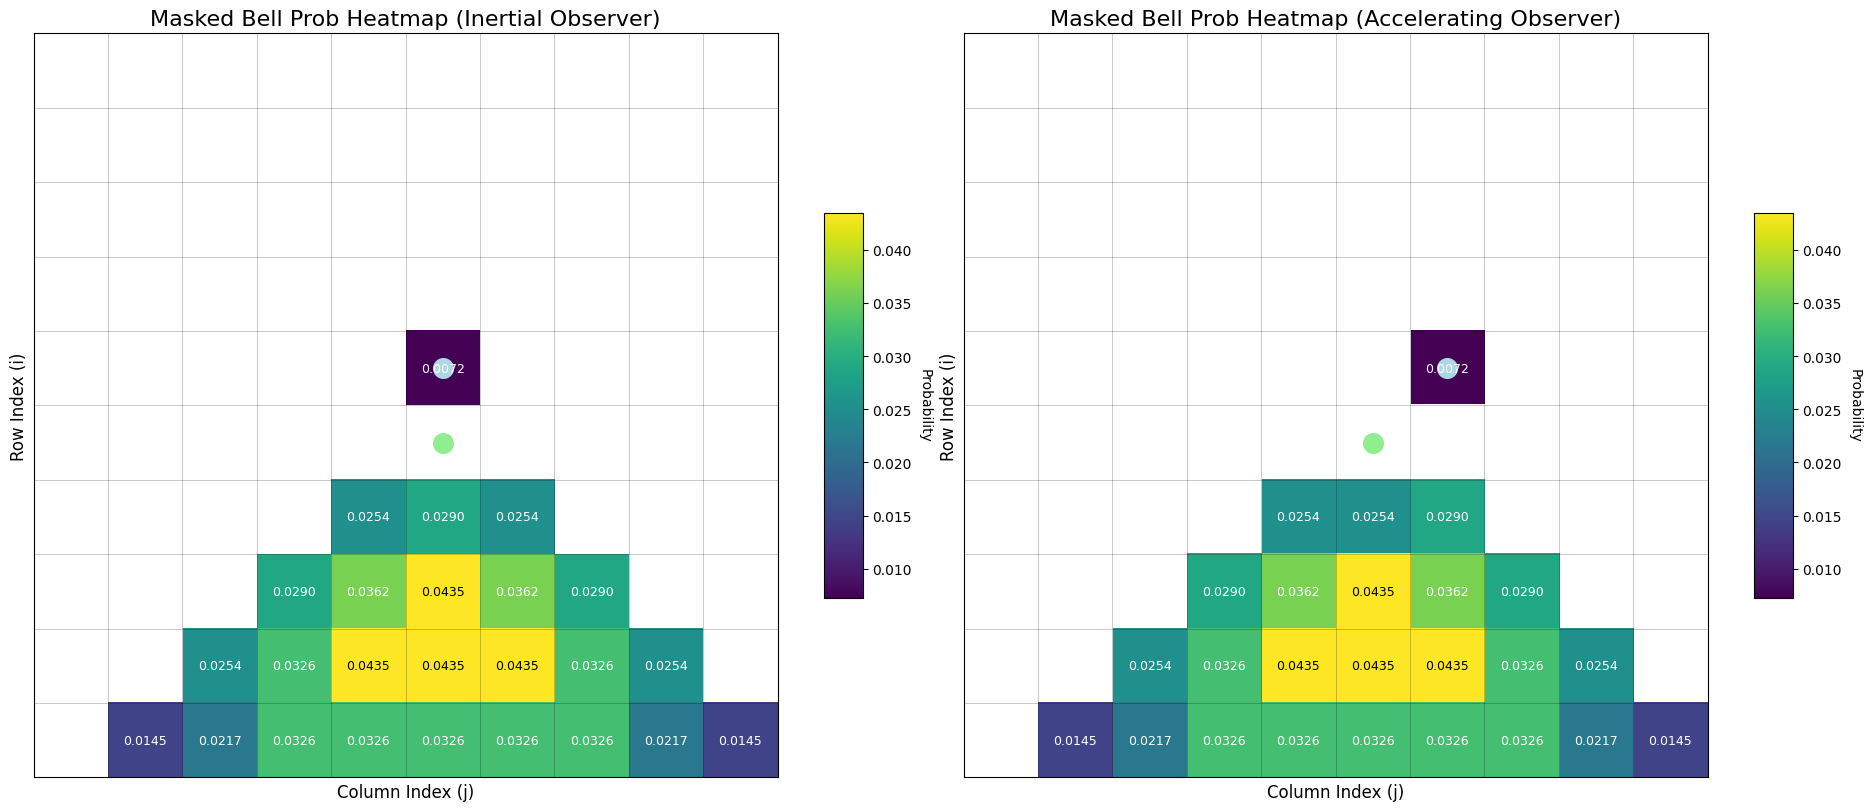

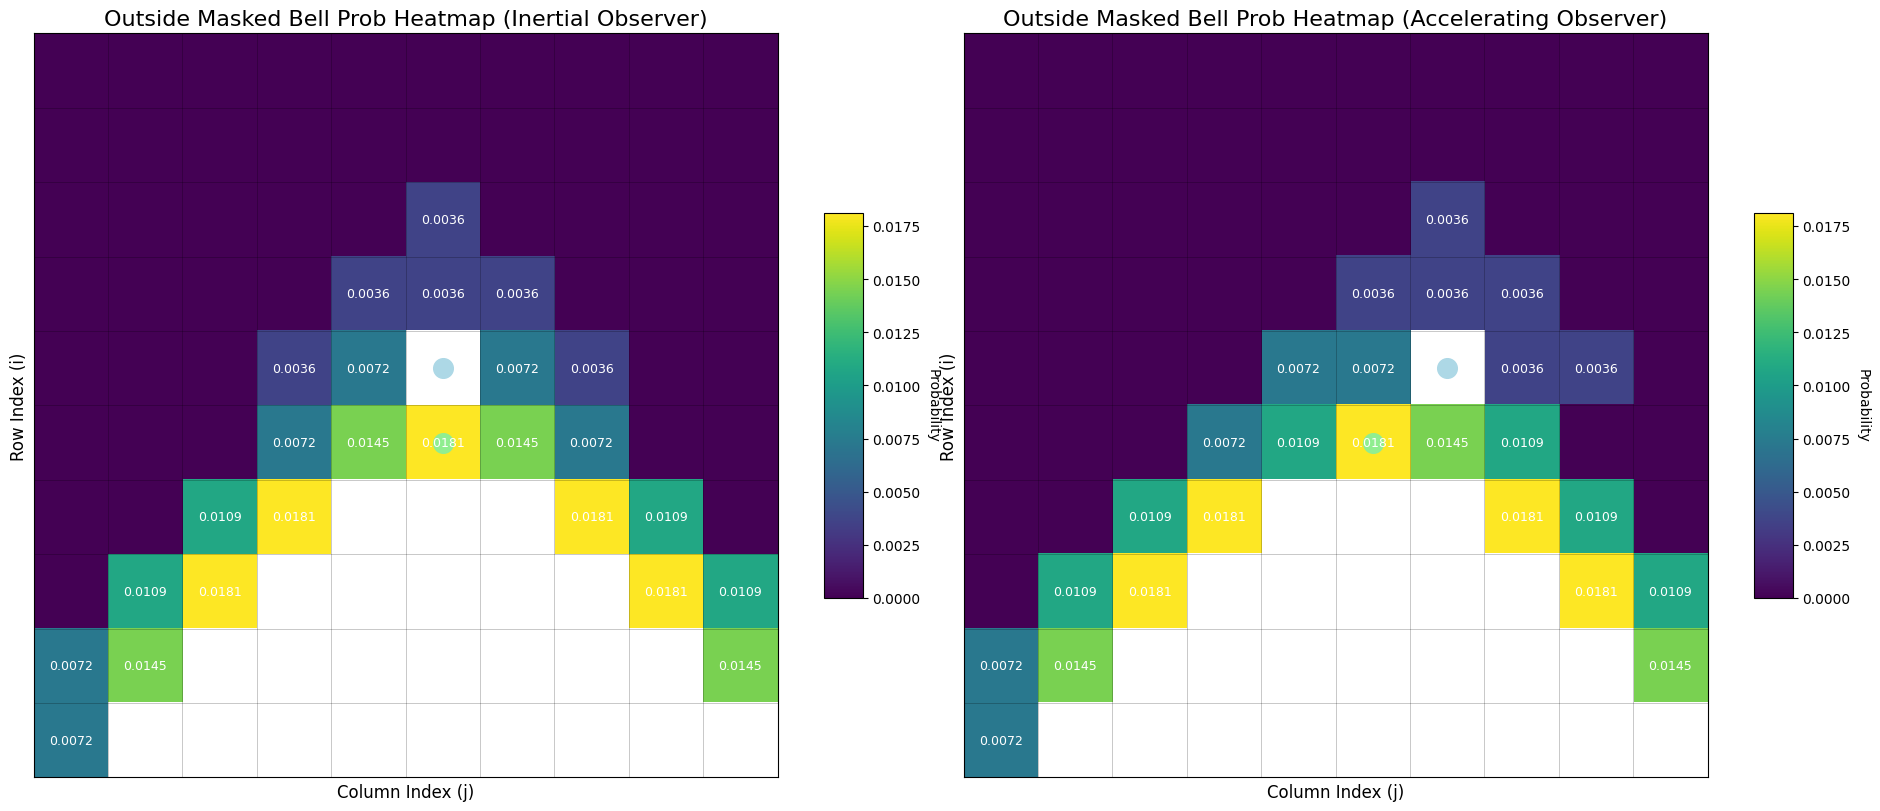

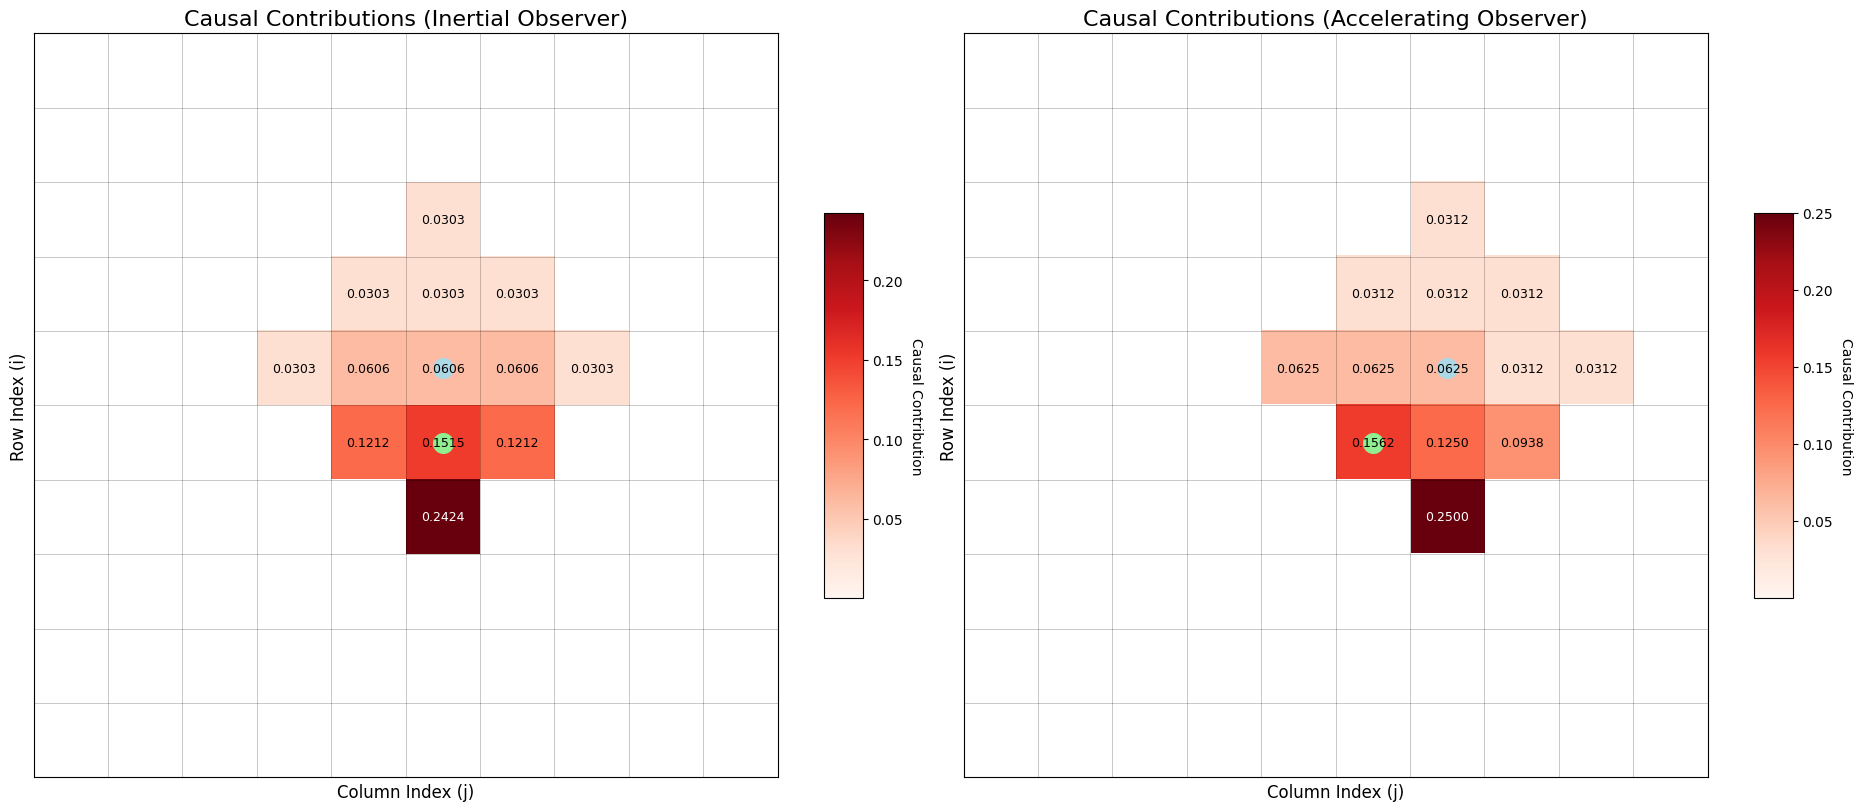

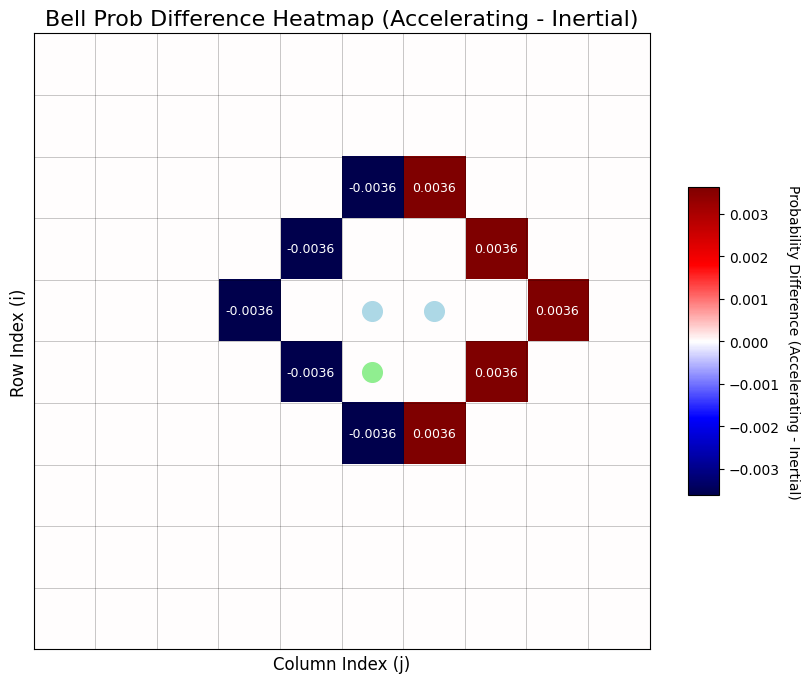

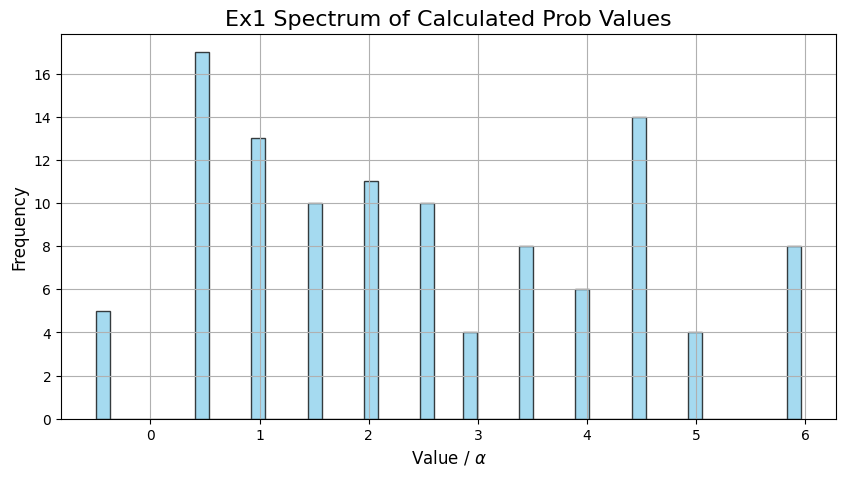

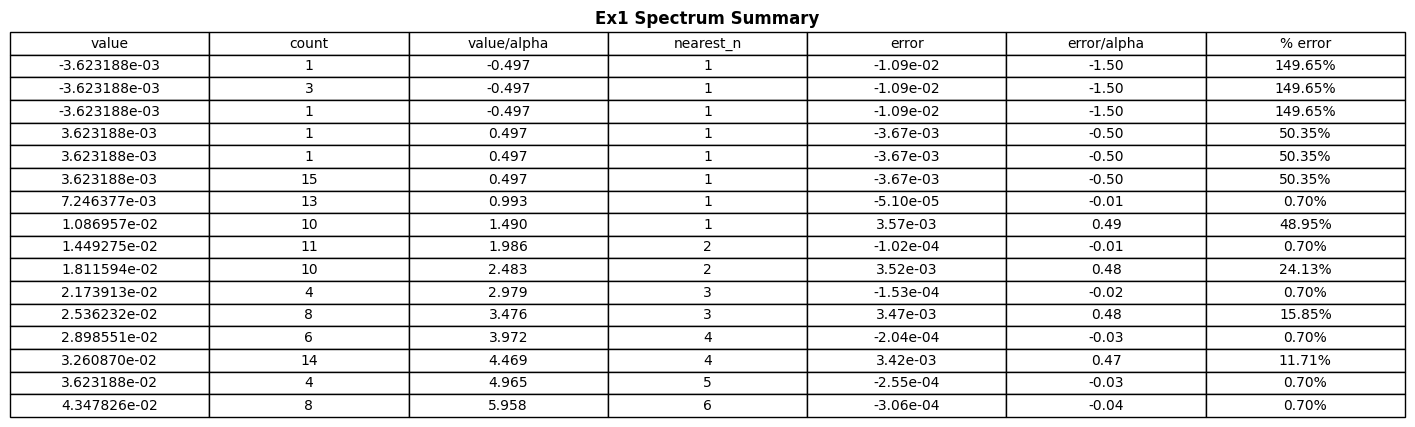

In [249]:
def main():
    # Fine Structure Constant Coincidence - Parameters
    #M, N = 10, 10  # Grid size (rows x columns)
    #r = 2          # Radius of the uniform Euclidean kernel
    #k = 0.5        # Slope factor for the light cone

    # Test Params
    M, N = 10, 10  # Grid size (rows x columns)
    r = 2          # Radius of the uniform Euclidean kernel
    k = 1.0        # Slope factor for the light cone

    # Initialize grid and center node
    grid, center_i, center_j = initialize_grid(M, N)

    # Define the kernel
    #kernel = create_uniform_euclidean_kernel(r)
    kernel = create_space_filling_lattice_kernel(r)
    binary_kernel = kernel.copy()

    # Scenario 1: Inertial Observer
    observer_type_1 = 'inertial'
    past_cone_mask_1 = define_past_light_cone(M, N, center_i, center_j, k=k)
    #past_cone_mask_1 = define_adaptive_light_cone(M, N, center_i, center_j, k=k)
    light_cone_mask_1, future_node_mask_1 = add_future_node(past_cone_mask_1, center_i, center_j, observer_type=observer_type_1)
    prob_grid_1 = compute_probability_grid(light_cone_mask_1, kernel, epsilon=1e-10)

    # Scenario 2: Accelerating Observer
    observer_type_2 = 'accelerating'
    past_cone_mask_2 = define_past_light_cone(M, N, center_i, center_j, k=k)
    #past_cone_mask_2 = define_adaptive_light_cone(M, N, center_i, center_j, k=k)
    light_cone_mask_2, future_node_mask_2 = add_future_node(past_cone_mask_2, center_i, center_j, observer_type=observer_type_2)
    prob_grid_2 = compute_probability_grid(light_cone_mask_2, kernel, epsilon=1e-10)

    # Compute statistics for both observers
    stats_inertial = verify_probabilities(prob_grid_1, light_cone_mask_1, observer_type_1)
    stats_accelerating = verify_probabilities(prob_grid_2, light_cone_mask_2, observer_type_2)

    # Combine statistics into dictionaries for the tables
    stats_table_outside = {
        "Inertial": stats_inertial["Outside"],
        "Accelerating": stats_accelerating["Outside"]
    }

    stats_table_inside = {
        "Inertial": stats_inertial["Inside"],
        "Accelerating": stats_accelerating["Inside"]
    }

    # Compute contribution maps
    contribution_from_prob_1 = compute_causal_contributions_from_prob_grid(
        prob_grid_1, kernel, center_i, center_j, observer_type='inertial'
    )

    contribution_from_prob_2 = compute_causal_contributions_from_prob_grid(
        prob_grid_2, kernel, center_i, center_j, observer_type='accelerating'
    )


    # Visualization -----------------------------------------
    # 1. Light Cone Masks
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=light_cone_mask_figsize)  # Adjust figsize as needed
    #plot_light_cone(ax1, light_cone_mask_1, center_i, center_j, observer_type_1, title="Light Cone Mask (Inertial Observer)")
    #plot_light_cone(ax2, light_cone_mask_2, center_i, center_j, observer_type_2, title="Light Cone Mask (Accelerating Observer)")
    plot_light_cone_grayscale(ax1, light_cone_mask_1, center_i, center_j, observer_type_1, title="Light Cone Mask (Inertial Observer)")
    plot_light_cone_grayscale(ax2, light_cone_mask_2, center_i, center_j, observer_type_2, title="Light Cone Mask (Accelerating Observer)")
    plt.subplots_adjust(wspace=0.0)
    fig1.savefig("Ex1_fig1_light_cone_masks.pdf", dpi=pdf_dpi)  # Save as PDF or desired format
    plt.close(fig1)  # Close the figure to release resources

    # 2. Probability Heatmaps
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=heatmaps_figsize)
    # Row 2: Probability Heatmaps
    plot_probability_heatmap(ax3, prob_grid_1, past_cone_mask=past_cone_mask_1, future_node_mask=future_node_mask_1,
                            center_i=center_i, center_j=center_j, observer_type=observer_type_1, title="Bell Prob Heatmap (Inertial Observer)")
    plot_probability_heatmap(ax4, prob_grid_2, past_cone_mask=past_cone_mask_2, future_node_mask=future_node_mask_2,
                            center_i=center_i, center_j=center_j, observer_type=observer_type_2, title="Bell Prob Heatmap (Accelerating Observer)")
    plt.subplots_adjust(wspace=0.0)
    #fig2.savefig("Ex1_fig2_probability_heatmaps.pdf", dpi=pdf_dpi)
    #plt.close(fig2)

    # 3. Masked Probability Heatmaps (Inside PLC)
    fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=heatmaps_figsize)
    # Row 3: Masked Probability Heatmaps (Inside PLC)
    plot_masked_probability_heatmap(ax5, prob_grid_1, past_cone_mask=past_cone_mask_1, future_node_mask=future_node_mask_1,
                                    center_i=center_i, center_j=center_j, observer_type=observer_type_1, title="Masked Bell Prob Heatmap (Inertial Observer)")
    plot_masked_probability_heatmap(ax6, prob_grid_2, past_cone_mask=past_cone_mask_2, future_node_mask=future_node_mask_2,
                                    center_i=center_i, center_j=center_j, observer_type=observer_type_2, title="Masked Bell Prob Heatmap (Accelerating Observer)")
    plt.subplots_adjust(wspace=0.0)
    #fig3.savefig("Ex1_fig3_masked_probability_heatmaps_inside.pdf", dpi=pdf_dpi)
    #plt.close(fig3)

    # 4. Masked Probability Heatmaps (Outside PLC)
    fig4, (ax7, ax8) = plt.subplots(1, 2, figsize=heatmaps_figsize)
    plot_outside_mask_probability_heatmap(ax7, prob_grid_1, past_cone_mask=past_cone_mask_1, future_node_mask=future_node_mask_1,
                                          center_i=center_i, center_j=center_j, observer_type=observer_type_1, title="Outside Masked Bell Prob Heatmap (Inertial Observer)")
    plot_outside_mask_probability_heatmap(ax8, prob_grid_2, past_cone_mask=past_cone_mask_2, future_node_mask=future_node_mask_2,
                                          center_i=center_i, center_j=center_j, observer_type=observer_type_2, title="Outside Masked Bell Prob Heatmap (Accelerating Observer)")
    plt.subplots_adjust(wspace=0.0)
    #fig4.savefig("Ex1_fig4_masked_probability_heatmaps_outside.pdf", dpi=pdf_dpi)
    #plt.close(fig4)

    # 5. Causal Contributions Heatmaps
    fig5, (ax9, ax10) = plt.subplots(1, 2, figsize=heatmaps_figsize)
    plot_causal_contributions_heatmap(ax9, contribution_from_prob_1, center_i, center_j, 'inertial',
                                      title="Causal Contributions (Inertial Observer)")
    plot_causal_contributions_heatmap(ax10, contribution_from_prob_2, center_i, center_j, 'accelerating',
                                      title="Causal Contributions (Accelerating Observer)")
    plt.subplots_adjust(wspace=0.0)
    #fig5.savefig("Ex1_fig5_causal_contributions_heatmaps.pdf", dpi=pdf_dpi)
    #plt.close(fig5)

    # 6. Probability Difference Heatmap
    fig6, ax11 = plt.subplots(figsize=diff_heatmap_figsize)  # Adjust figsize
    plot_probability_difference_heatmap(ax11, prob_grid_1, prob_grid_2, center_i, center_j, title="Bell Prob Difference Heatmap (Accelerating - Inertial)")
    #fig6.savefig("Ex1_fig6_probability_difference_heatmap.pdf", dpi=pdf_dpi)
    #plt.close(fig6)

    """
    # 7. Statistics Tables
    fig7, (ax_outside, ax_inside) = plt.subplots(2, 1, figsize=stats_table_figsize)  # Adjust figsize for tables
    # ... (call your plot_statistics_table function with ax_outside and ax_inside) ...
    # Plot the statistics tables
    plot_statistics_table(ax_outside, ax_inside,
                          stats_table_outside, stats_table_inside,
                          title_outside="Bell Prob Stats Outside Causal Light Cone",
                          title_inside="Bell Prob Stats Inside Causal Light Cone")
    #fig7.savefig("Ex1_fig7_statistics_tables.pdf", dpi=pdf_dpi)
    #plt.close(fig7)
    """


    # Generate LaTex for the summary tables.
    caption = "Comparison of probability statistics Outside the light cone."
    label = "tab:outside_comparison"
    outside_table_latex = generate_comparison_table_from_stats(stats_table_outside, caption, label)

    caption = "Comparison of probability statistics Inside the light cone."
    label = "tab:inside_comparison"
    inside_table_latex = generate_comparison_table_from_stats(stats_table_inside, caption, label)

    print(inside_table_latex)
    print(outside_table_latex)


    # List of grids
    diff_grid = prob_grid_2 - prob_grid_1
    grids = [prob_grid_1, prob_grid_2, diff_grid]

    # 8. Plot the spectrum of numbers
    fig8, ax_spectrum = plt.subplots(figsize=spectrum_plot_figsize)
    # Plot the spectrum on the provided Axes
    plot_spectrum(ax_spectrum, grids,'Ex1 Spectrum of Calculated Prob Values')
    #fig8.savefig("Ex1_fig8_alpha_spectrum_plot.pdf", dpi=pdf_dpi)
    #plt.close(fig8)

    # 9. plot the spectrum table
    spectrum_data = tabulate_spectrum(grids)
    #print(spectrum_data)
    fig9, ax_spectrum_table = plt.subplots(figsize=spectrum_table_figsize)
    # display spectrum table
    dispaly_spectrum_table_orig(ax_spectrum_table, spectrum_data, "Ex1 Spectrum Summary")
    #fig9.savefig("Ex1_fig9_spectrum_table.pdf", dpi=pdf_dpi)
    #plt.close(fig9)

    # spectrum_data into LaTex table and print
    turn_spectrum_data_into_LaTex(spectrum_data)


    """
    #Export code for exporting numerical results to npz or csv files
    filename_npz = "exported_data_npz"
    if os.path.exists(filename_npz):
        os.remove(filename_npz)  # Explicitly remove existing file to ensure overwrite

    export_variables_to_npz(
      filename_npz,
      grid=grid,
      kernel=kernel,
      past_cone_mask_1=past_cone_mask_1,
      past_cone_mask_2=past_cone_mask_2,
      light_cone_mask_1=light_cone_mask_1,
      light_cone_mask_2=light_cone_mask_2,
      prob_grid_1=prob_grid_1,
      prob_grid_2=prob_grid_2,
      contribution_from_prob_1=contribution_from_prob_1,
      contribution_from_prob_2=contribution_from_prob_2
    )"""

    """
    filename_csv = "exported_data"
    export_variables_to_csv(
      filename_csv,
      grid=grid,
      kernel=kernel,
      past_cone_mask_1=past_cone_mask_1,
      past_cone_mask_2=past_cone_mask_2,
      light_cone_mask_1=light_cone_mask_1,
      light_cone_mask_2=light_cone_mask_2,
      prob_grid_1=prob_grid_1,
      prob_grid_2=prob_grid_2,
      contribution_from_prob_1=contribution_from_prob_1,
      contribution_from_prob_2=contribution_from_prob_2
    )
    export_to_npz_google_drive("data.npz",
      grid=grid,
      binary_kernel=binary_kernel,
      kernel=kernel,
      past_cone_mask_1=past_cone_mask_1,
      past_cone_mask_2=past_cone_mask_2,
      light_cone_mask_1=light_cone_mask_1,
      light_cone_mask_2=light_cone_mask_2,
      prob_grid_1=prob_grid_1,
      prob_grid_2=prob_grid_2,
      contribution_from_prob_1=contribution_from_prob_1,
      contribution_from_prob_2=contribution_from_prob_2
    )

    export_to_csv_google_drive("grid.csv", grid)
    export_to_csv_google_drive("kernel.csv", kernel)
    export_to_csv_google_drive("past_cone_mask_1.csv", past_cone_mask_1)
    export_to_csv_google_drive("past_cone_mask_2.csv", past_cone_mask_2)
    export_to_csv_google_drive("light_cone_mask_1.csv", light_cone_mask_1)
    export_to_csv_google_drive("light_cone_mask_2.csv", light_cone_mask_2)
    export_to_csv_google_drive("prob_grid_1.csv", prob_grid_1)
    export_to_csv_google_drive("prob_grid_2.csv", prob_grid_2)
    export_to_csv_google_drive("contribution_from_prob_1.csv", contribution_from_prob_1)
    export_to_csv_google_drive("contribution_from_prob_2.csv", contribution_from_prob_2)
    """

    # Show the figure
    plt.show()


if __name__ == "__main__":
    main()


# Symmetrical Light Cone Studies (Exp 2)


<ipython-input-246-e276b8cd3b9a>:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)  # Set the labels


\begin{tabular}{rrrrrrr}
\toprule
Value & Count & Value/$\alpha$ & nearest_n & Abs Error = $|x - n\alpha|$ & abs_error/$\alpha$ & Pct Error = $\frac{|x - n\alpha|}{n\alpha} \times 100\%$ \\
\midrule
3.676471e-03 & 1 & 5.038088e-01 & 1 & -3.620882e-03 & -4.961912e-01 & 49.62\% \\
7.352941e-03 & 16 & 1.007618e+00 & 1 & 5.558861e-05 & 7.617641e-03 & 0.76\% \\
1.102941e-02 & 18 & 1.511426e+00 & 2 & -3.565293e-03 & -4.885735e-01 & 24.43\% \\
1.470588e-02 & 15 & 2.015235e+00 & 2 & 1.111772e-04 & 1.523528e-02 & 0.76\% \\
1.838235e-02 & 25 & 2.519044e+00 & 3 & -3.509705e-03 & -4.809559e-01 & 16.03\% \\
\bottomrule
\end{tabular}



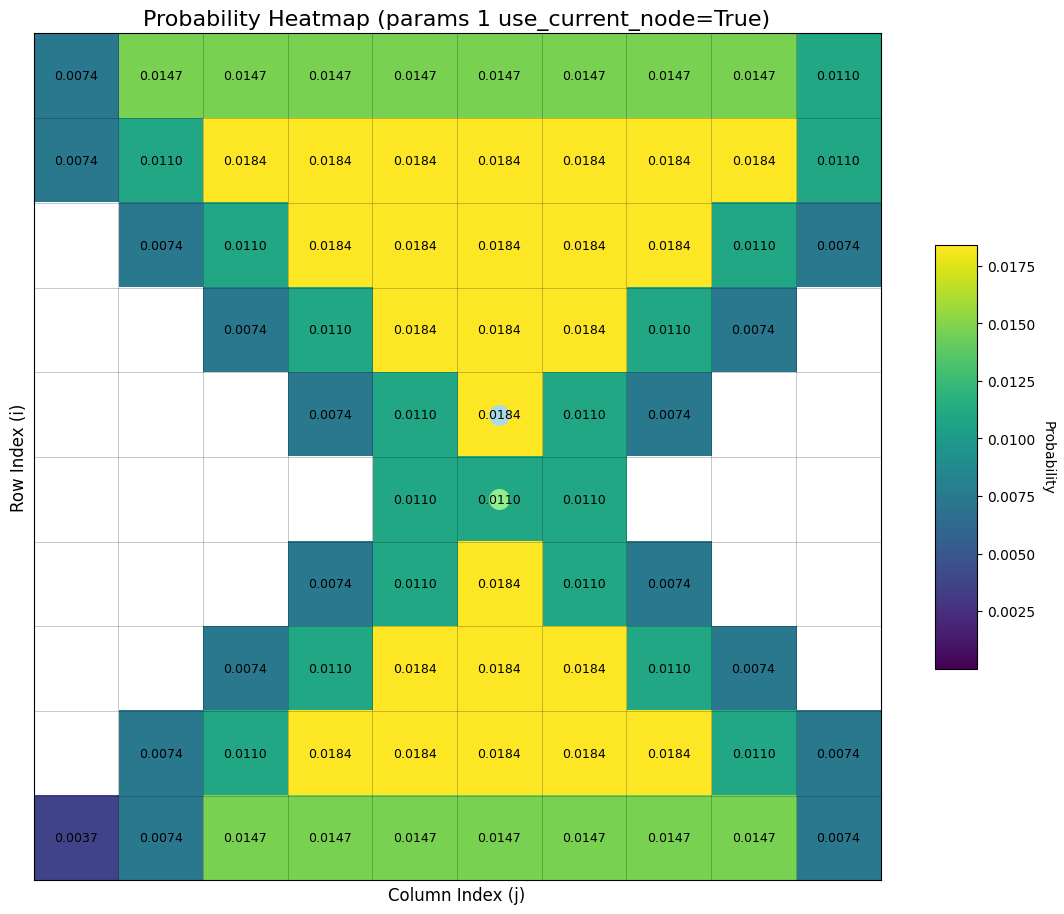

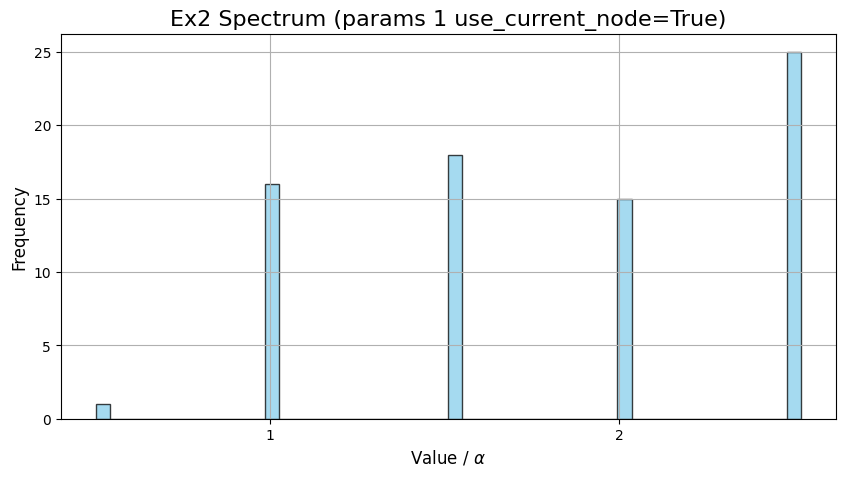

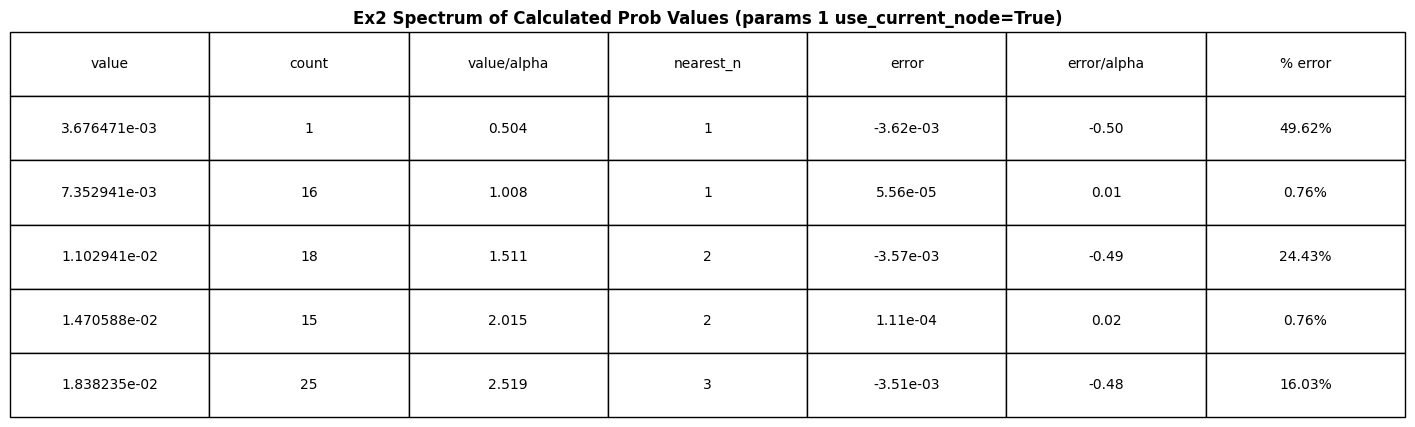

<ipython-input-246-e276b8cd3b9a>:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)  # Set the labels


\begin{tabular}{rrrrrrr}
\toprule
Value & Count & Value/$\alpha$ & nearest_n & Abs Error = $|x - n\alpha|$ & abs_error/$\alpha$ & Pct Error = $\frac{|x - n\alpha|}{n\alpha} \times 100\%$ \\
\midrule
3.745318e-03 & 1 & 5.132434e-01 & 1 & -3.552034e-03 & -4.867566e-01 & 48.68\% \\
7.490637e-03 & 19 & 1.026487e+00 & 1 & 1.932841e-04 & 2.648689e-02 & 2.65\% \\
1.123596e-02 & 15 & 1.539730e+00 & 2 & -3.358750e-03 & -4.602697e-01 & 23.01\% \\
1.498127e-02 & 17 & 2.052974e+00 & 2 & 3.865683e-04 & 5.297377e-02 & 2.65\% \\
1.872659e-02 & 23 & 2.566217e+00 & 3 & -3.165466e-03 & -4.337828e-01 & 14.46\% \\
\bottomrule
\end{tabular}



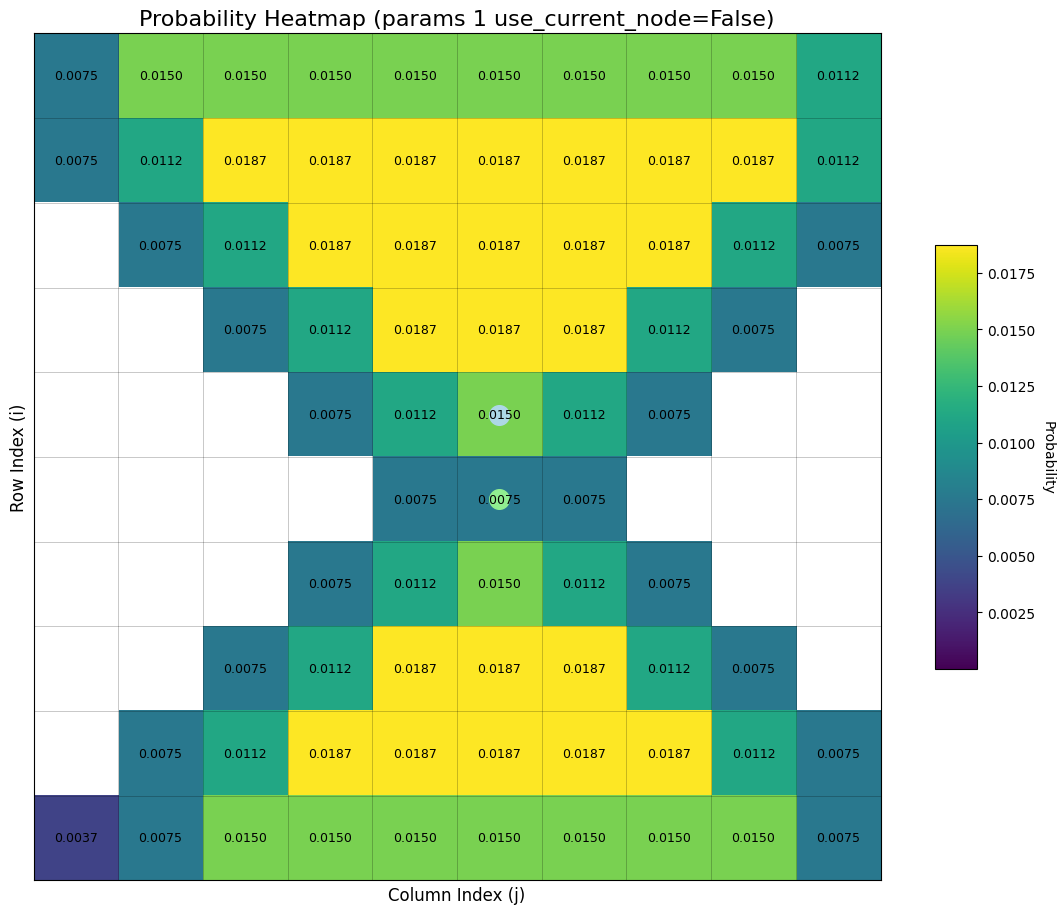

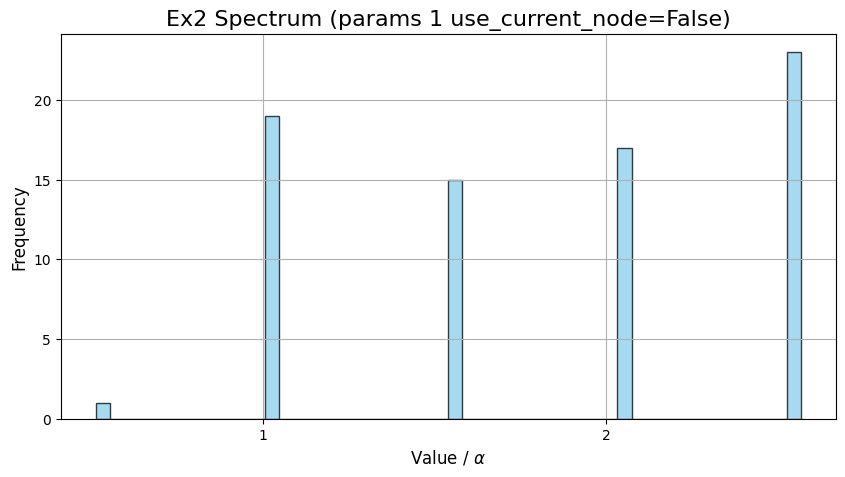

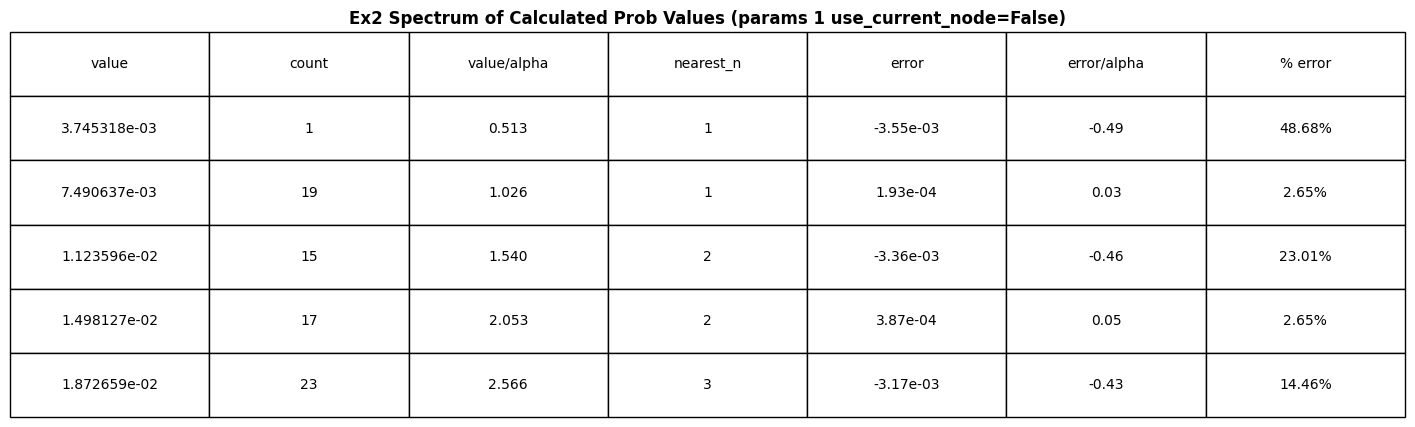

In [247]:
#Params 1
def main():
    # --- Common Parameters ---
    M, N = 10, 10     # Grid size (rows x columns)
    r = 1             # Kernel radius (modify as needed)
    k = 1.0           # Slope factor for the light cone

    # We'll run two cases: one with use_current_node True, and one with False.
    for use_current_node in [True, False]:
        # --- STEP 1: Create the Grid, Kernel, and Light Cone Masks ---
        # Initialize grid and get the center coordinates.
        inertial_grid, center_i, center_j = initialize_grid(M, N)

        # Create the kernel. (Using the space_filling_lattice version here.)
        kernel = create_space_filling_lattice_kernel(r)
        binary_kernel = kernel.copy()

        # Define the past light cone mask.
        past_cone_mask = define_past_light_cone(M, N, center_i, center_j, k=k)
        # Incorporate the future node based on the observer type.
        observer_type = 'inertial'
        past_light_cone_mask, future_node_mask = add_future_node(
            past_cone_mask, center_i, center_j, observer_type=observer_type
        )
        # Define the future light cone mask using the current node parameter.
        future_cone_mask = define_future_light_cone(
            M, N, center_i, center_j, k=k, include_current_node=use_current_node
        )
        # Combine the past and future light cones.
        light_cone_mask = combine_past_future_light_cones(past_cone_mask, future_cone_mask)

        # --- STEP 2: Compute the Probability Grid and Plot the Heatmap ---
        prob_grid = compute_probability_grid(light_cone_mask, binary_kernel, epsilon=1e-10)

        fig1, ax1 = plt.subplots(figsize=ex2_heatmaps_figsize)
        plot_probability_heatmap(ax1, prob_grid, center_i=center_i, center_j=center_j,
                                 title=f"Probability Heatmap (params 1 use_current_node={use_current_node})")
        #plt.savefig(f"Ex2_p1_heatmap_use_{use_current_node}.pdf", dpi=pdf_dpi)
        #plt.close(fig1)

        # List of grids
        grids = [prob_grid]

        # Plot the spectrum
        fig2, ax_spectrum = plt.subplots(figsize=stats_table_figsize)
        plot_spectrum(ax_spectrum, grids, f"Ex2 Spectrum (params 1 use_current_node={use_current_node})")
        #fig2.savefig(f"Ex2_fig2_spectrum_plot_p1_use_{use_current_node}.pdf", dpi=pdf_dpi)
        #plt.close(fig2)

        # 3. plot the spectrum table
        spectrum_data = tabulate_spectrum(grids)
        #print(spectrum_data)
        fig3, ax_spectrum_table = plt.subplots(figsize=spectrum_table_figsize)
        dispaly_spectrum_table_orig(ax_spectrum_table, spectrum_data, f"Ex2 Spectrum of Calculated Prob Values (params 1 use_current_node={use_current_node})")
        #fig3.savefig(f"Ex2_fig3_spectrum_table_p1_{use_current_node}.pdf", dpi=pdf_dpi)
        #plt.close(fig3)

        # spectrum_data into LaTex table and print
        turn_spectrum_data_into_LaTex(spectrum_data)

        # Show the figure
        plt.show()

if __name__ == "__main__":
    main()


# Fluidity and NS

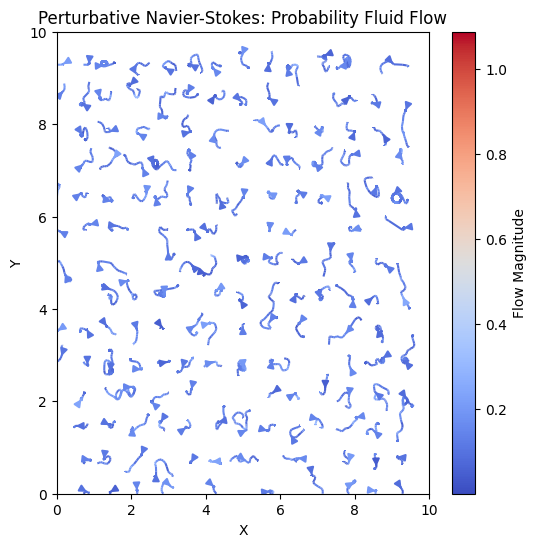

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation grid parameters
nx, ny = 100, 100  # Grid size
dx, dy = 0.1, 0.1  # Spatial step size
dt = 0.001         # Time step
nu_classical = 0.1 # Classical kinematic viscosity

# Quantum viscosity perturbation term (modifiable)
def quantum_viscosity(Q, T, P, rho_grad, S_grad, v_grad):
    """
    Defines the perturbative correction to viscosity based on ensemble parameters.
    - Q: Quantum coherence measure
    - T: Temperature
    - P: Pressure
    - rho_grad: Density gradient
    - S_grad: Entropy gradient
    - v_grad: Velocity gradient
    """
    return 1 + np.exp(-Q) * np.tanh(P * rho_grad) * np.sin(S_grad) / (1 + v_grad**2)

# Initialize velocity and pressure fields
u = np.zeros((nx, ny))  # x-direction velocity
v = np.zeros((nx, ny))  # y-direction velocity
p = np.zeros((nx, ny))  # Pressure

# Random initial condition for turbulence
u += 0.1 * np.random.randn(nx, ny)
v += 0.1 * np.random.randn(nx, ny)

# Compute velocity gradients
def compute_gradients(field, dx, dy):
    """Computes numerical gradients for a given field."""
    dfdx = np.gradient(field, dx, axis=0)
    dfdy = np.gradient(field, dy, axis=1)
    return dfdx, dfdy

# Time evolution function for the modified Navier-Stokes equation
def evolve_ns(Q, T, P, steps=1000):
    """Evolves the velocity field with a quantum viscosity perturbation."""
    global u, v, p

    for _ in range(steps):
        rho_grad_x, rho_grad_y = compute_gradients(u, dx, dy)
        S_grad_x, S_grad_y = compute_gradients(v, dx, dy)
        v_grad_x, v_grad_y = compute_gradients(np.sqrt(u**2 + v**2), dx, dy)

        # Compute viscosity with perturbative quantum correction
        eta_eff = nu_classical * quantum_viscosity(Q, T, P, rho_grad_x, S_grad_x, v_grad_x)

        # Navier-Stokes update equations (simplified)
        u_new = u + dt * (-u * rho_grad_x - v * rho_grad_y + eta_eff * (np.gradient(np.gradient(u, axis=0), axis=0) + np.gradient(np.gradient(u, axis=1), axis=1)))
        v_new = v + dt * (-u * S_grad_x - v * S_grad_y + eta_eff * (np.gradient(np.gradient(v, axis=0), axis=0) + np.gradient(np.gradient(v, axis=1), axis=1)))

        u, v = u_new, v_new  # Update velocity fields

# Run the simulation with an example parameter set
evolve_ns(Q=0.5, T=300, P=1.0, steps=200)

# Visualization
plt.figure(figsize=(6,6))
plt.streamplot(np.linspace(0, nx*dx, nx), np.linspace(0, ny*dy, ny), u.T, v.T, density=0.5, color=np.sqrt(u**2 + v**2), cmap='coolwarm')
plt.title("Perturbative Navier-Stokes: Probability Fluid Flow")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Flow Magnitude")
plt.show()


<ipython-input-101-4383c6a3558c>:595: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-101-4383c6a3558c>:620: RuntimeWarning:

divide by zero encountered in scalar divide



\begin{tabular}{rrrrrrr}
\toprule
Value & Count & Value/$\alpha$ & nearest_n & Abs Error = $|x - n\alpha|$ & abs_error/$\alpha$ & Pct Error = $\frac{|x - n\alpha|}{n\alpha} \times 100\%$ \\
\midrule
2.923977e-03 & 12 & 4.006901e-01 & 0 & 2.923977e-03 & 4.006901e-01 & inf\% \\
5.847953e-03 & 10 & 8.013801e-01 & 1 & -1.449399e-03 & -1.986199e-01 & 19.86\% \\
8.771930e-03 & 4 & 1.202070e+00 & 1 & 1.474577e-03 & 2.020702e-01 & 20.21\% \\
1.169591e-02 & 6 & 1.602760e+00 & 2 & -2.898799e-03 & -3.972398e-01 & 19.86\% \\
1.461988e-02 & 11 & 2.003450e+00 & 2 & 2.517790e-05 & 3.450279e-03 & 0.17\% \\
1.754386e-02 & 4 & 2.404140e+00 & 2 & 2.949155e-03 & 4.041403e-01 & 20.21\% \\
2.046784e-02 & 8 & 2.804830e+00 & 3 & -1.424221e-03 & -1.951696e-01 & 6.51\% \\
2.339181e-02 & 4 & 3.205520e+00 & 3 & 1.499755e-03 & 2.055204e-01 & 6.85\% \\
2.631579e-02 & 6 & 3.606211e+00 & 4 & -2.873621e-03 & -3.937895e-01 & 9.84\% \\
2.923977e-02 & 3 & 4.006901e+00 & 4 & 5.035580e-05 & 6.900558e-03 & 0.17\% \\
3.21637

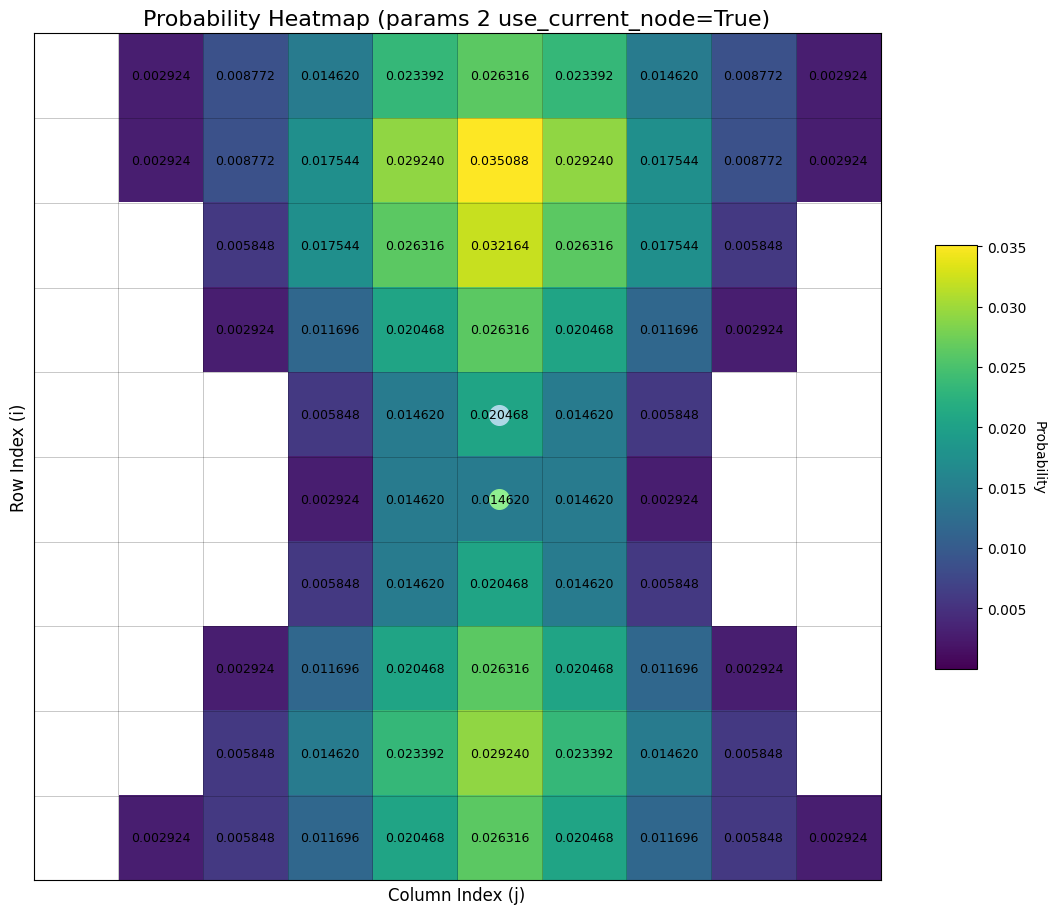

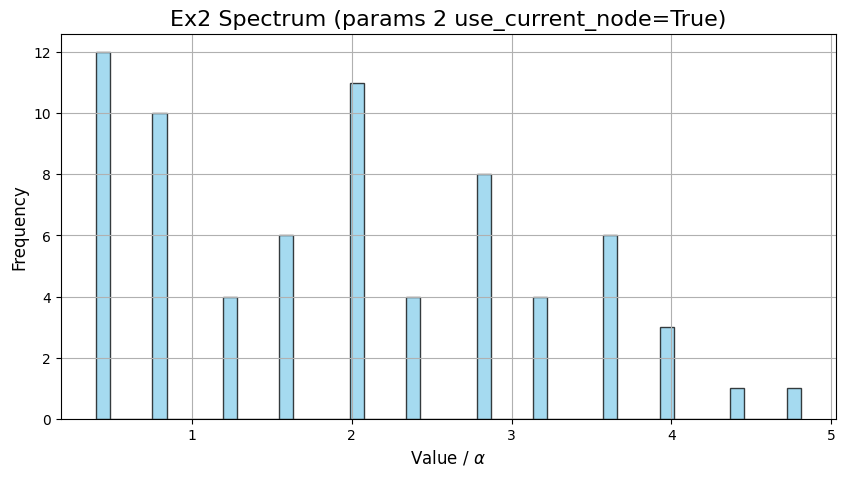

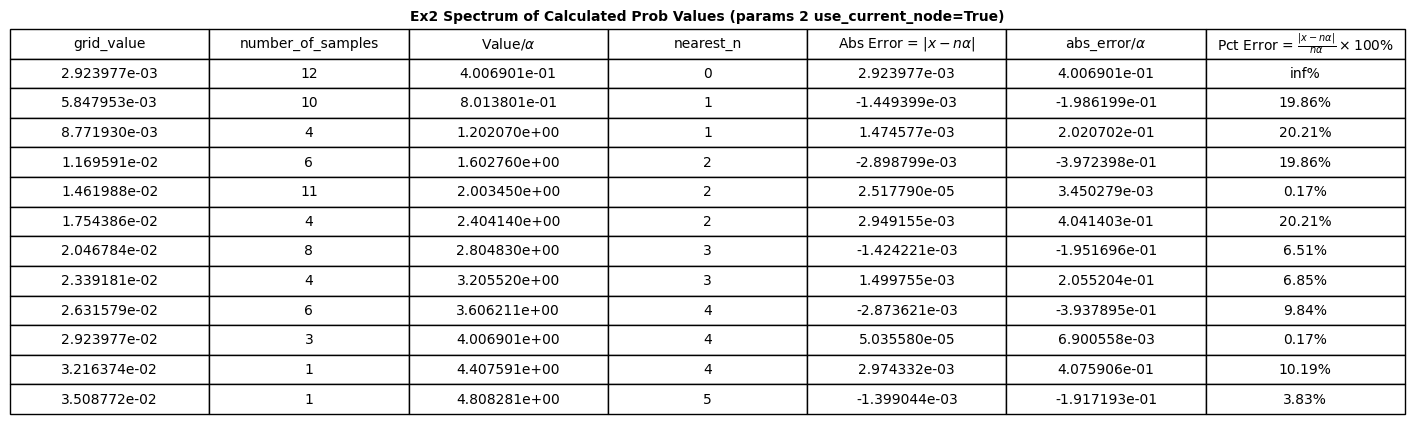

<ipython-input-101-4383c6a3558c>:595: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-101-4383c6a3558c>:620: RuntimeWarning:

divide by zero encountered in scalar divide



\begin{tabular}{rrrrrrr}
\toprule
Value & Count & Value/$\alpha$ & nearest_n & Abs Error = $|x - n\alpha|$ & abs_error/$\alpha$ & Pct Error = $\frac{|x - n\alpha|}{n\alpha} \times 100\%$ \\
\midrule
3.039514e-03 & 10 & 4.165228e-01 & 0 & 3.039514e-03 & 4.165228e-01 & inf\% \\
6.079027e-03 & 10 & 8.330456e-01 & 1 & -1.218325e-03 & -1.669544e-01 & 16.70\% \\
9.118541e-03 & 4 & 1.249568e+00 & 1 & 1.821188e-03 & 2.495684e-01 & 24.96\% \\
1.215805e-02 & 13 & 1.666091e+00 & 2 & -2.436650e-03 & -3.339088e-01 & 16.70\% \\
1.519757e-02 & 4 & 2.082614e+00 & 2 & 6.028633e-04 & 8.261397e-02 & 4.13\% \\
1.823708e-02 & 6 & 2.499137e+00 & 2 & 3.642377e-03 & 4.991368e-01 & 24.96\% \\
2.127660e-02 & 6 & 2.915660e+00 & 3 & -6.154620e-04 & -8.434045e-02 & 2.81\% \\
2.431611e-02 & 6 & 3.332182e+00 & 3 & 2.424052e-03 & 3.321823e-01 & 11.07\% \\
2.735562e-02 & 4 & 3.748705e+00 & 4 & -1.833787e-03 & -2.512949e-01 & 6.28\% \\
3.039514e-02 & 3 & 4.165228e+00 & 4 & 1.205727e-03 & 1.652279e-01 & 4.13\% \\
3.3434

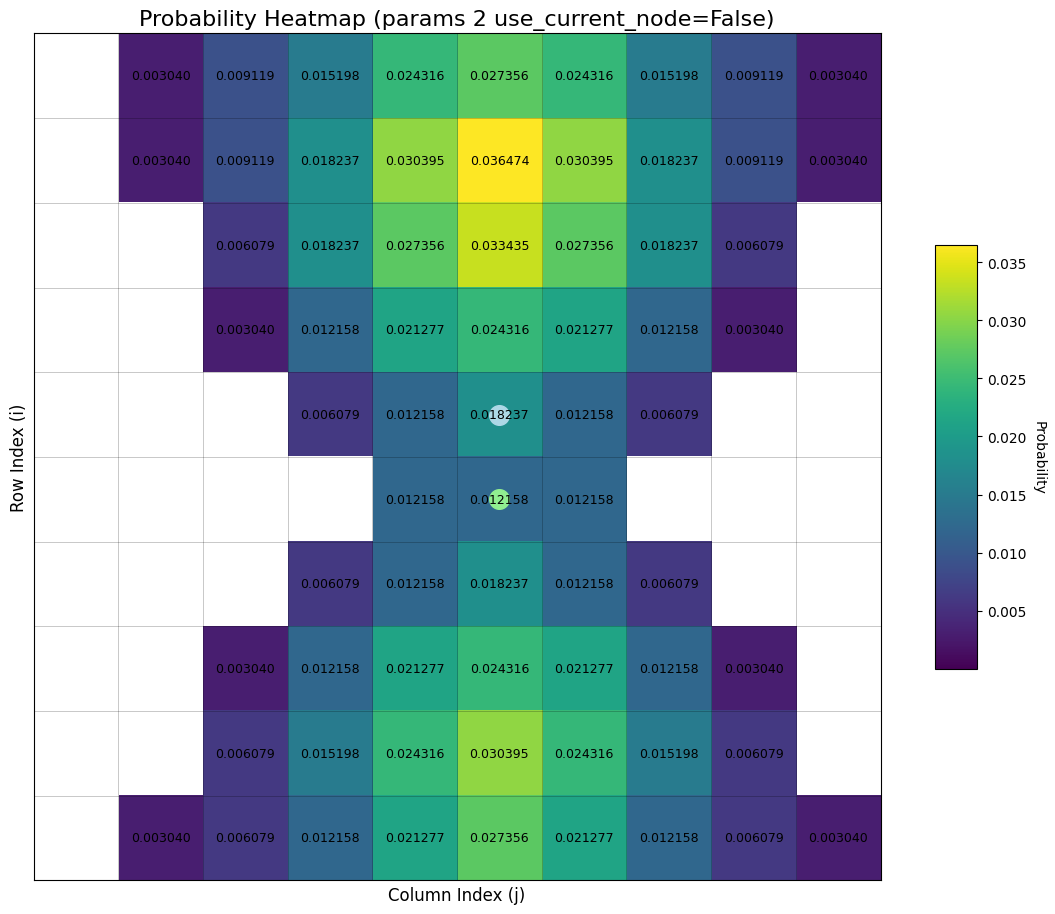

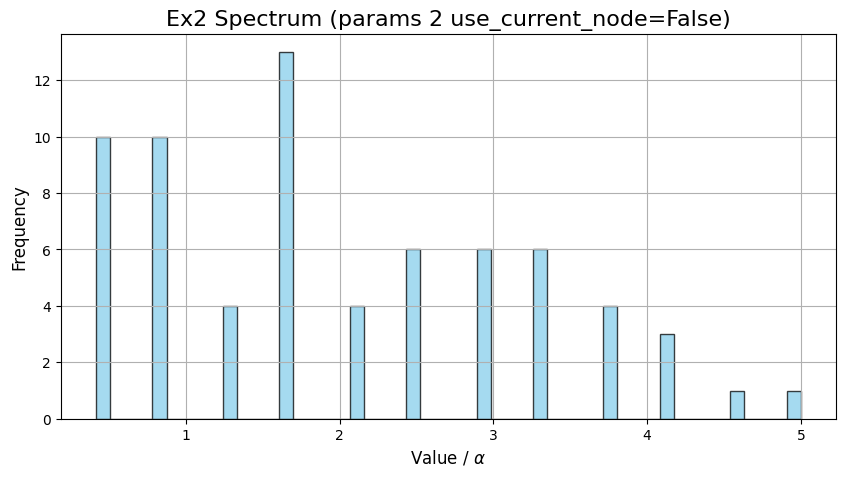

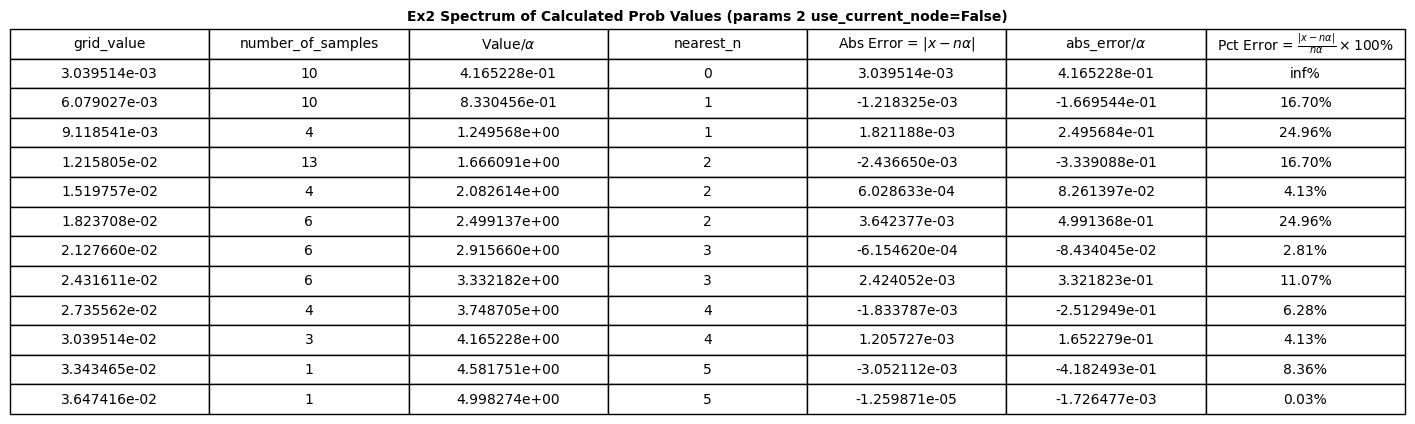

In [ ]:
#Params 2
def main():
    # --- Common Parameters ---
    M, N = 10, 10     # Grid size (rows x columns)
    r = 2             # Kernel radius (modify as needed)
    k = 0.5           # Slope factor for the light cone

    # We'll run two cases: one with use_current_node True, and one with False.
    for use_current_node in [True, False]:
        # --- STEP 1: Create the Grid, Kernel, and Light Cone Masks ---
        # Initialize grid and get the center coordinates.
        inertial_grid, center_i, center_j = initialize_grid(M, N)

        # Create the kernel. (Using the space_filling_lattice version here.)
        kernel = create_space_filling_lattice_kernel(r)
        binary_kernel = kernel.copy()

        # Define the past light cone mask.
        past_cone_mask = define_past_light_cone(M, N, center_i, center_j, k=k)
        # Incorporate the future node based on the observer type.
        observer_type = 'inertial'
        past_light_cone_mask, future_node_mask = add_future_node(
            past_cone_mask, center_i, center_j, observer_type=observer_type
        )
        # Define the future light cone mask using the current node parameter.
        future_cone_mask = define_future_light_cone(
            M, N, center_i, center_j, k=k, include_current_node=use_current_node
        )
        # Combine the past and future light cones.
        light_cone_mask = combine_past_future_light_cones(past_cone_mask, future_cone_mask)

        # --- STEP 2: Compute the Probability Grid and Plot the Heatmap ---
        prob_grid = compute_probability_grid(light_cone_mask, binary_kernel, epsilon=1e-10)

        fig1, ax1 = plt.subplots(figsize=ex2_heatmaps_figsize)
        plot_probability_heatmap(ax1, prob_grid, center_i=center_i, center_j=center_j,
                                 title=f"Probability Heatmap (params 2 use_current_node={use_current_node})")
        #plt.savefig(f"Ex2_p2_heatmap_use_{use_current_node}.pdf", dpi=pdf_dpi)
        #plt.close(fig1)

        # List of grids
        grids = [prob_grid]

        # Plot the spectrum
        fig2, ax_spectrum = plt.subplots(figsize=stats_table_figsize)
        plot_spectrum(ax_spectrum, grids, f"Ex2 Spectrum (params 2 use_current_node={use_current_node})")
        #fig2.savefig(f"Ex2_fig2_spectrum_plot_p2_use_{use_current_node}.pdf", dpi=pdf_dpi)
        #plt.close(fig2)

        # 3. plot the spectrum table
        spectrum_data = tabulate_spectrum(grids)
        #print(spectrum_data)
        fig3, ax_spectrum_table = plt.subplots(figsize=spectrum_table_figsize)
        dispaly_spectrum_table(ax_spectrum_table, spectrum_data, f"Ex2 Spectrum of Calculated Prob Values (params 2 use_current_node={use_current_node})")
        #fig3.savefig(f"Ex2_fig3_spectrum_table_p2_{use_current_node}.pdf", dpi=pdf_dpi)
        #plt.close(fig3)

        # spectrum_data into LaTex table and print
        turn_spectrum_data_into_LaTex(spectrum_data)

        # Show the figure
        plt.show()

if __name__ == "__main__":
    main()


# Data Export Functions

In [ ]:
def export_variables_to_npz(filename="exported_data.npz", **kwargs):
    """
    Saves multiple numpy arrays into a single .npz file for easy sharing.

    Parameters:
    - filename (str): Name of the output .npz file.
    - kwargs: Dictionary of named numpy arrays to store.
    """
    np.savez(filename, **kwargs)
    print(f"Variables successfully saved to {filename}.")


def export_to_npz_google_drive(filename, **arrays):
    """
    Exports multiple numpy arrays to an NPZ file in Google Drive, overwriting if necessary.

    Parameters:
    - filename (str): The filename for the NPZ file (without path).
    - **arrays: Named numpy arrays to save.
    """
    # Define the Google Drive path
    save_path = f"/content/drive/My Drive/RBWData/{filename}"

    if os.path.exists(save_path):
        os.remove(save_path)  # Explicitly remove existing file to ensure overwrite

    np.savez(save_path, **arrays)  # Save new data
    print(f"NPZ file saved to: {save_path}")


def export_variables_to_csv(base_filename="exported_data", **kwargs):
    """
    Saves multiple numpy arrays as CSV files for easy inspection.

    Parameters:
    - base_filename (str): Prefix for the CSV files.
    - kwargs: Dictionary of named numpy arrays to store.
    """
    for name, array in kwargs.items():
        filename = f"{base_filename}_{name}.csv"
        if array.ndim == 2:
            pd.DataFrame(array).to_csv(filename, index=False, header=False)
        elif array.ndim == 1:
            pd.DataFrame(array[:, np.newaxis]).to_csv(filename, index=False, header=False)
        print(f"Saved {name} to {filename}.")

def export_to_csv_google_drive(filename, data):
    """
    Exports a 2D numpy array or pandas DataFrame to a CSV file in Google Drive, overwriting if necessary.

    Parameters:
    - filename (str): The filename for the CSV file (without path).
    - data (numpy.ndarray or pandas.DataFrame): Data to save.
    """
    # Define the Google Drive path
    save_path = f"/content/drive/My Drive/RBWData/{filename}"

    df = pd.DataFrame(data)  # Convert to DataFrame if not already
    df.to_csv(save_path, index=False)  # Overwrites by default

    print(f"CSV file saved to: {save_path}")

# DOE

In [236]:
import numpy as np
import pandas as pd
from itertools import product
from numpy.fft import fft2, fftshift

# === Configurable Search Space ===
from scipy.constants import alpha
import numpy as np

# Physically meaningful targets (theory & DIG)
target_values = [
    alpha / 2,         # ≈ 0.00365
    alpha,             # ≈ 0.00730
    alpha * 2,         # ≈ 0.01460
    alpha * 3,         # ≈ 0.02191
    alpha * 4,         # ≈ 0.02922
    0.0137036,         # TTO derived (e.g., I2 shape)
    0.0144928,         # 1/69 — empirical DIG match
    0.0136986          # 1/73 — empirical DIG match
]

target_labels = [
    'α/2',
    'α',
    '2α',
    '3α',
    '4α',
    'DIG match: 0.0137036',
    'DIG match: 1/69 ≈ 0.0144928',
    'DIG match: 1/73 ≈ 0.0136986'
]

# Foil values (mathy but physically irrelevant)
foil_values = [
    1/100,             # 0.01
    1/150,             # ~0.006667
    1/60,              # ~0.016667
    np.pi / 256,       # ~0.01227
    np.e / 256         # ~0.01061
]

foil_labels = [
    'Foil: 1/100',
    'Foil: 1/150',
    'Foil: 1/60',
    'Foil: π/256',
    'Foil: e/256'
]


tol = 0.00001
observer_types = ['inertial', 'accelerating']

M_values = [9, 11]
N_values = [9, 11]
kernel_r_values = [1, 2, 3]
slope_values = [0.5, 1.0]

# === Metric Functions ===
def compute_spectral_entropy(prob_grid):
    spectrum = np.abs(fftshift(fft2(prob_grid)))
    norm_spectrum = spectrum / np.sum(spectrum)
    return -np.sum(norm_spectrum * np.log(norm_spectrum + 1e-12))

def compute_alignment_score(prob_grid):
    row_sums = np.sum(prob_grid, axis=1)
    col_sums = np.sum(prob_grid, axis=0)
    return 1 / (1 + np.var(row_sums) + np.var(col_sums))

def meets_criteria(prob_grid, targets, tol):
    hits = [np.any(np.abs(prob_grid - t) <= tol) for t in targets]
    value_match = any(hits)
    spectral_entropy = compute_spectral_entropy(prob_grid)
    alignment_score = compute_alignment_score(prob_grid)
    return value_match, spectral_entropy, alignment_score


def meets_criteria(prob_grid, targets, tol):
      matched = []
      for t in targets:
          close_vals = prob_grid[np.abs(prob_grid - t) <= tol]
          matched.extend(close_vals.tolist())
      value_match = len(matched) > 0
      spectral_entropy = compute_spectral_entropy(prob_grid)
      alignment_score = compute_alignment_score(prob_grid)
      return value_match, spectral_entropy, alignment_score, matched

def run_discrete_doe():
    param_combinations = list(product(M_values, N_values, kernel_r_values, slope_values, observer_types))
    results = []

    # Combine signal + foil values for full matching
    all_targets = target_values + foil_values

    for i, (M, N, r, slope, observer_type) in enumerate(param_combinations):
        print(f"[{i+1}/{len(param_combinations)}] M={M}, N={N}, r={r}, slope={slope:.2f}, obs={observer_type}")

        try:
            grid, ci, cj = initialize_grid(M, N)
            kernel = create_space_filling_lattice_kernel(r)
            past_mask = define_past_light_cone(M, N, ci, cj, k=slope)
            light_mask, future_mask = add_future_node(past_mask, ci, cj, observer_type=observer_type)
            prob_grid = compute_probability_grid(light_mask, kernel, epsilon=1e-10)

            # Evaluate against all targets
            value_match, entropy, score, matched_vals = meets_criteria(prob_grid, all_targets, tol)

            results.append({
                'M': M, 'N': N, 'kernel_r': r,
                'light_cone_slope': slope,
                'observer_type': observer_type,
                'value_match': value_match,
                'matched_values': matched_vals,
                'spectral_entropy': entropy,
                'alignment_score': score
            })

        except Exception as e:
            print(f"  ⚠️ Error: {e}")
            continue

    return pd.DataFrame(results)

epsilon = 1e-10  # Define once if not already
all_prob_values = []  # New global collector

def run_discrete_doe_with_global():
    param_combinations = list(product(M_values, N_values, kernel_r_values, slope_values, observer_types))
    results = []

    for i, (M, N, r, slope, observer_type) in enumerate(param_combinations):
        print(f"[{i+1}/{len(param_combinations)}] M={M}, N={N}, r={r}, slope={slope:.2f}, obs={observer_type}")

        try:
            grid, ci, cj = initialize_grid(M, N)
            kernel = create_space_filling_lattice_kernel(r)
            past_mask = define_past_light_cone(M, N, ci, cj, k=slope)
            light_mask, future_mask = add_future_node(past_mask, ci, cj, observer_type=observer_type)
            prob_grid = compute_probability_grid(light_mask, kernel, epsilon=1e-10)

            # Append flattened grid values for spectrum analysis
            #all_prob_values.extend(prob_grid.flatten())

            # With this:
            filtered_values = prob_grid[prob_grid > epsilon]
            all_prob_values.extend(filtered_values)

            value_match, entropy, score, matched_vals = meets_criteria(prob_grid, target_values + foil_values, tol)

            results.append({
                'M': M, 'N': N, 'kernel_r': r,
                'light_cone_slope': slope,
                'observer_type': observer_type,
                'value_match': value_match,
                'matched_values': matched_vals,
                'spectral_entropy': entropy,
                'alignment_score': score
            })

        except Exception as e:
            print(f"  ⚠️ Error: {e}")
            continue

    return pd.DataFrame(results)


In [237]:
df_doe = run_discrete_doe_with_global()
# Optional CSV writeout:
# df_doe.to_csv("doe_results_structured.csv", index=False)

[1/48] M=9, N=9, r=1, slope=0.50, obs=inertial
[2/48] M=9, N=9, r=1, slope=0.50, obs=accelerating
[3/48] M=9, N=9, r=1, slope=1.00, obs=inertial
[4/48] M=9, N=9, r=1, slope=1.00, obs=accelerating
[5/48] M=9, N=9, r=2, slope=0.50, obs=inertial
[6/48] M=9, N=9, r=2, slope=0.50, obs=accelerating
[7/48] M=9, N=9, r=2, slope=1.00, obs=inertial
[8/48] M=9, N=9, r=2, slope=1.00, obs=accelerating
[9/48] M=9, N=9, r=3, slope=0.50, obs=inertial
[10/48] M=9, N=9, r=3, slope=0.50, obs=accelerating
[11/48] M=9, N=9, r=3, slope=1.00, obs=inertial
[12/48] M=9, N=9, r=3, slope=1.00, obs=accelerating
[13/48] M=9, N=11, r=1, slope=0.50, obs=inertial
[14/48] M=9, N=11, r=1, slope=0.50, obs=accelerating
[15/48] M=9, N=11, r=1, slope=1.00, obs=inertial
[16/48] M=9, N=11, r=1, slope=1.00, obs=accelerating
[17/48] M=9, N=11, r=2, slope=0.50, obs=inertial
[18/48] M=9, N=11, r=2, slope=0.50, obs=accelerating
[19/48] M=9, N=11, r=2, slope=1.00, obs=inertial
[20/48] M=9, N=11, r=2, slope=1.00, obs=accelerating
[

In [238]:
df_doe[df_doe['value_match']].sort_values(by='alignment_score', ascending=False)

M   N  kernel_r  light_cone_slope observer_type  value_match  \
31  11   9         2         1.000e+00  accelerating         True   
30  11   9         2         1.000e+00      inertial         True   
5    9   9         2         5.000e-01  accelerating         True   
17   9  11         2         5.000e-01  accelerating         True   
4    9   9         2         5.000e-01      inertial         True   
16   9  11         2         5.000e-01      inertial         True   
13   9  11         1         5.000e-01  accelerating         True   
1    9   9         1         5.000e-01  accelerating         True   
12   9  11         1         5.000e-01      inertial         True   
0    9   9         1         5.000e-01      inertial         True   

                                       matched_values  spectral_entropy  \
31                             [0.010610079575596816]         3.256e+00   
30       [0.010610079575596816, 0.010610079575596816]         3.267e+00   
5   [0.0136986301369863, 0.0136986301369863, 0.013...         3.429e+00   
17  [0.0136986301369863, 0.0136986301369863, 0.013...         3.619e+00   
4   [0.0136986301369863, 0.0136986301369863, 0.013...         3.486e+00   
16  [0.0136986301369863, 0.0136986301369863, 0.013...         3.671e+00   
13  [0.016666666666666666, 0.016666666666666666, 0...         3.845e+00   
1   [0.016666666666666666, 0.016666666666666666, 0...         3.659e+00   
12  [0.016666666666666666, 0.016666666666666666, 0...         3.903e+00   
0   [0.016666666666666666, 0.016666666666666666, 0...         3.710e+00   

    alignment_score  
31        9.899e-01  
30        9.898e-01  
5         9.811e-01  
17        9.808e-01  
4         9.806e-01  
16        9.804e-01  
13        9.751e-01  
1         9.746e-01  
12        9.743e-01  
0         9.737e-01

In [239]:
# Assuming df_doe is your results DataFrame
df_doe.to_csv("doe_results.csv", index=False)
print("DOE results saved to doe_results.csv")

DOE results saved to doe_results.csv


# Visualize DOE

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def heatmap_alignment_vs_kernel_and_slope(df):
    pivot = df.pivot_table(
        index='kernel_r',
        columns='light_cone_slope',
        values='alignment_score',
        aggfunc='mean'
    )
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
    plt.title('Alignment Score Heatmap')
    plt.xlabel('Light Cone Slope')
    plt.ylabel('Kernel Radius')
    plt.tight_layout()
    plt.show()

import ast

def histogram_matched_values_old(df):
    # Parse stringified lists into actual float values
    parsed_values = (
        df['matched_values']
        .dropna()
        .apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        .explode()
        .astype(float)
    )

    # Plot
    plt.figure(figsize=(10, 5))
    sns.histplot(parsed_values, bins=60, kde=True, color='gray', edgecolor='black')

    # Overlay target value lines with labels
    for val, label in zip(target_values, target_labels):
        plt.axvline(x=val, linestyle='--', linewidth=1.2, label=label)

    plt.title('Histogram of Matched Values with DIG and α Targets')
    plt.xlabel('Matched Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right', fontsize='small')
    plt.tight_layout()
    plt.show()

def histogram_matched_values(df, tolerance=1e-6):
    # Parse matched values column
    parsed_values = (
        df['matched_values']
        .dropna()
        .apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        .explode()
        .astype(float)
    )

    # Plot histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(parsed_values, bins=80, kde=True, color='gray', edgecolor='black')
    plt.title('Distribution of Matched Values vs α and DIG Targets')
    plt.xlabel('Matched Value')
    plt.ylabel('Frequency')

    # Overlay target markers
    for val, label in zip(target_values, target_labels):
        plt.axvline(x=val, color='darkred', linestyle='--', linewidth=1.5, label=label)

    # Overlay foil/control markers
    for val, label in zip(foil_values, foil_labels):
        plt.axvline(x=val, color='blue', linestyle=':', linewidth=1.2, label=label)

    # Prevent duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    plt.legend(unique.values(), unique.keys(), loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()


def scatter_entropy_vs_size(df):
    from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D projection
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(df['M'], df['N'], df['spectral_entropy'],
                    c=df['alignment_score'], cmap='plasma', s=50)

    ax.set_xlabel('M', labelpad=15)
    ax.set_ylabel('N', labelpad=15)
    ax.set_zlabel('Spectral Entropy', labelpad=15)
    ax.set_title('Entropy vs Graph Size (M, N)', pad=20)

    # Optional: add colorbar
    cbar = fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Alignment Score')

    plt.show()


import matplotlib.pyplot as plt
import seaborn as sns

def plot_prob_value_spectrum_old(prob_values, target_values=[], foil_values=[]):
    plt.figure(figsize=(10, 5))
    sns.histplot(prob_values, bins=200, kde=True, color='gray', alpha=0.7, label='All grid values')

    # Overlay targets and foils
    for val in target_values:
        plt.axvline(val, color='blue', linestyle='--', linewidth=1)
    for val in foil_values:
        plt.axvline(val, color='red', linestyle=':', linewidth=1)

    plt.xlabel("Probability Value")
    plt.ylabel("Frequency")
    plt.title("Spectrum of All DOE Probability Grid Values")
    plt.legend(['Target values (blue)', 'Foil values (red)', 'All values'])
    plt.tight_layout()
    plt.show()

def plot_prob_value_spectrum(prob_values, target_values=[], foil_values=[], epsilon=1e-10):
    prob_values = [v for v in prob_values if v > epsilon]

    plt.figure(figsize=(10, 5))

    # Plot histogram of all values
    hist = sns.histplot(prob_values, bins=200, kde=True, color='gray', alpha=0.7, label='All values')

    # Add target and foil lines, and collect handles for legend
    handles = []
    labels = []

    if target_values:
        for val in target_values:
            line = plt.axvline(val, color='blue', linestyle='--', linewidth=1)
        handles.append(line)
        labels.append('Target values (blue dashed)')

    if foil_values:
        for val in foil_values:
            line = plt.axvline(val, color='red', linestyle=':', linewidth=1)
        handles.append(line)
        labels.append('Foil values (red dotted)')

    # Add histogram handle
    handles.insert(0, hist.patches[0])
    labels.insert(0, 'All grid values (gray)')

    plt.xlabel("Probability Value")
    plt.ylabel("Frequency")
    plt.title("Spectrum of All DOE Probability Grid Values")
    plt.legend(handles, labels)
    plt.tight_layout()
    plt.show()


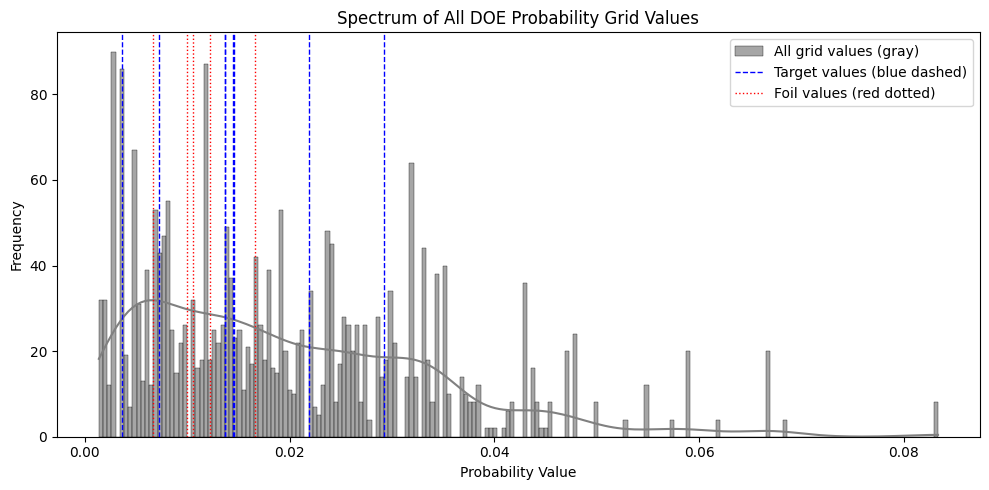

In [240]:
plot_prob_value_spectrum(all_prob_values, target_values, foil_values)

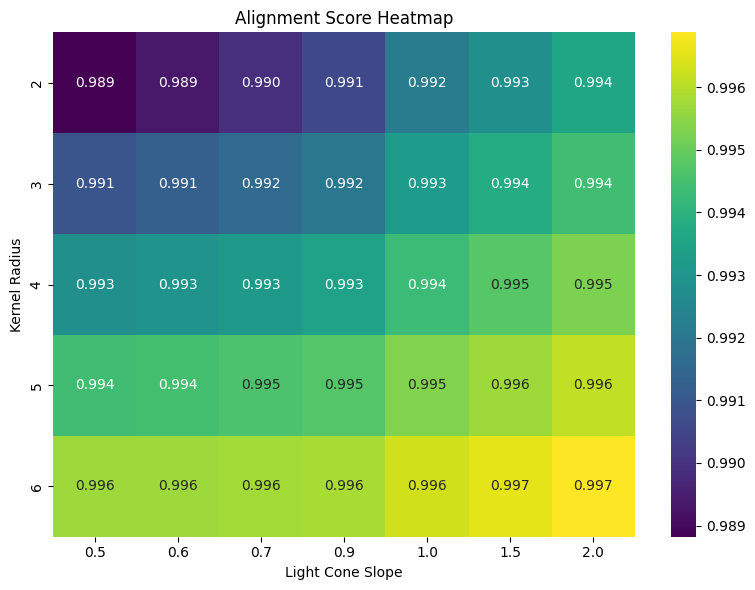

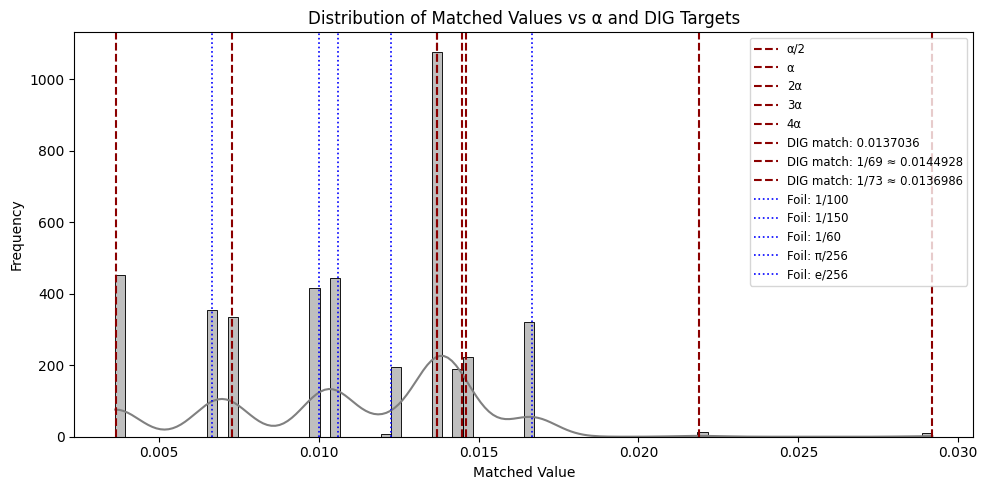

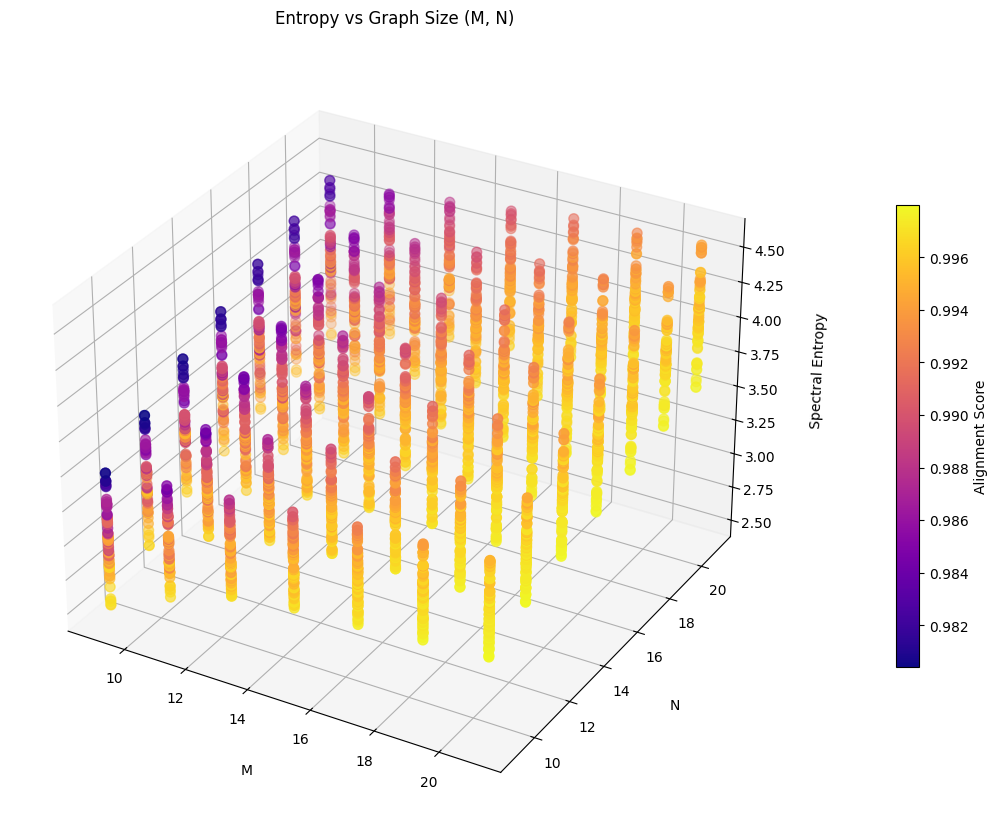

In [205]:
# Run the visualizations
heatmap_alignment_vs_kernel_and_slope(df_doe)
histogram_matched_values(df_doe)
scatter_entropy_vs_size(df_doe)


In [145]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Assuming df_doe is already defined
def interactive_doe_viewer(df):
    value_match_widget = widgets.Dropdown(
        options=['all', True, False],
        description='Value Match:',
        value='all'
    )

    observer_widget = widgets.Dropdown(
        options=['all'] + sorted(df['observer_type'].unique().tolist()),
        description='Observer:',
        value='all'
    )

    def filter_and_display(value_match, observer_type):
        filtered = df.copy()
        if value_match != 'all':
            filtered = filtered[filtered['value_match'] == value_match]
        if observer_type != 'all':
            filtered = filtered[filtered['observer_type'] == observer_type]
        display(filtered.sort_values('alignment_score', ascending=False).reset_index(drop=True))

    ui = widgets.HBox([value_match_widget, observer_widget])
    out = widgets.interactive_output(filter_and_display, {
        'value_match': value_match_widget,
        'observer_type': observer_widget
    })

    display(ui, out)

# Run this to launch the viewer
interactive_doe_viewer(df_doe)


Output()

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_alignment_vs_entropy(df, highlight_matches=True):
    plt.figure(figsize=(8, 6))

    if highlight_matches:
        matched = df[df["value_match"] == True]
        unmatched = df[df["value_match"] == False]
        plt.scatter(unmatched["spectral_entropy"], unmatched["alignment_score"], alpha=0.4, label="No match", color="gray")
        plt.scatter(matched["spectral_entropy"], matched["alignment_score"], alpha=0.8, label="Value match", color="blue")
    else:
        plt.scatter(df["spectral_entropy"], df["alignment_score"], alpha=0.6)

    plt.xlabel("Spectral Entropy")
    plt.ylabel("Alignment Score")
    plt.title("Alignment vs. Spectral Entropy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



def plot_r_vs_slope_heatmap(df, metric="alignment_score", fixed_shape=(21,21), observer="inertial"):
    slice_df = df[
        (df["M"] == fixed_shape[0]) &
        (df["N"] == fixed_shape[1]) &
        (df["observer_type"] == observer)
    ]

    pivot = slice_df.pivot("r", "light_cone_slope", metric)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"{metric.replace('_', ' ').title()} for M,N={fixed_shape}, {observer}")
    plt.xlabel("Light Cone Slope")
    plt.ylabel("Kernel Radius (r)")
    plt.tight_layout()
    plt.show()


import matplotlib.pyplot as plt

def plot_top_probability_grids(df, metric="alignment_score", top_n=6, match_only=False, observer_filter=None):
    """
    Plots heatmaps for top-N configurations from the DOE dataframe based on a specified metric.

    Parameters:
    - df (DataFrame): DOE results with all param columns.
    - metric (str): Column to sort by (e.g., 'alignment_score' or 'spectral_entropy').
    - top_n (int): Number of top configurations to plot.
    - match_only (bool): Only include rows where value_match == True.
    - observer_filter (str): 'inertial', 'accelerating', or None.
    """

    subset = df.copy()
    if match_only:
        subset = subset[subset["value_match"] == True]
    if observer_filter:
        subset = subset[subset["observer_type"] == observer_filter]

    top_df = subset.sort_values(by=metric, ascending=False).head(top_n)

    cols = 3
    rows = (top_n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    for i, (_, row) in enumerate(top_df.iterrows()):
        M, N, r = int(row["M"]), int(row["N"]), int(row["r"])
        k = float(row["k"])
        observer = row["observer_type"]

        grid, ci, cj = initialize_grid(M, N)
        kernel = create_space_filling_lattice_kernel(r)
        past_mask = define_past_light_cone(M, N, ci, cj, k=k)
        light_mask, future_mask = add_future_node(past_mask, ci, cj, observer_type=observer)
        prob_grid = compute_probability_grid(light_mask, kernel, epsilon=1e-10)

        ax = axes.flatten()[i]
        title = f"M={M}, N={N}, r={r}, k={k:.2f}, {observer}\n{metric}={row[metric]:.4f}"
        plot_probability_heatmap_2_alpha(
            ax, prob_grid,
            past_cone_mask=past_mask,
            future_node_mask=future_mask,
            center_i=ci, center_j=cj,
            observer_type=observer,
            title=title,
            grayscale=True
        )

    # Hide unused subplots
    for j in range(i + 1, len(axes.flatten())):
        axes.flatten()[j].axis("off")

    plt.tight_layout()
    plt.show()


def plot_heatmap_r_vs_k(df, metric="alignment_score", observer_type_filter=None):
    """
    Creates a 2D heatmap of the specified metric across (r, k) combinations.
    """
    heat_df = df.copy()
    if observer_type_filter:
        heat_df = heat_df[heat_df["observer_type"] == observer_type_filter]

    # Pivot to (r × k) matrix
    pivot = heat_df.pivot_table(
        values=metric,
        index="r",
        columns="k",
        aggfunc="mean"
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"{metric.replace('_', ' ').title()} across r vs. k")
    plt.xlabel("k ≡ mc / αħ  (Curvature-Coupled Kernel Factor)")
    plt.ylabel("Kernel Radius (r)")
    plt.tight_layout()
    plt.show()


def plot_heatmap_r_vs_lcs(df, metric="alignment_score", observer_type_filter=None):
    if observer_type_filter:
        df = df[df["observer_type"] == observer_type_filter]

    pivot = df.pivot_table(
        values=metric,
        index="r",
        columns="light_cone_slope",  # assuming this column exists
        aggfunc="mean"
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="plasma")
    plt.title(f"{metric.replace('_', ' ').title()} across r vs. Light Cone Slope")
    plt.xlabel("Light Cone Slope")
    plt.ylabel("Kernel Radius (r)")
    plt.tight_layout()
    plt.show()


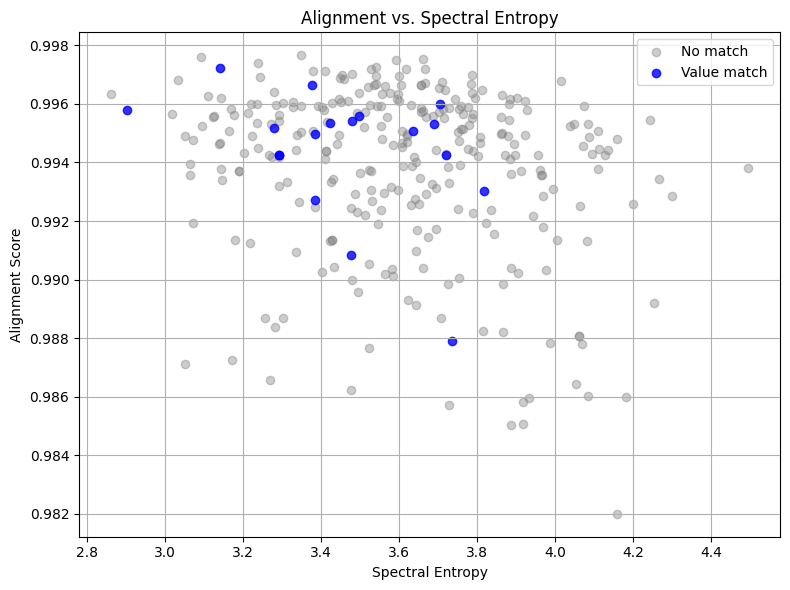

In [132]:
plot_alignment_vs_entropy(df_doe, highlight_matches=True)

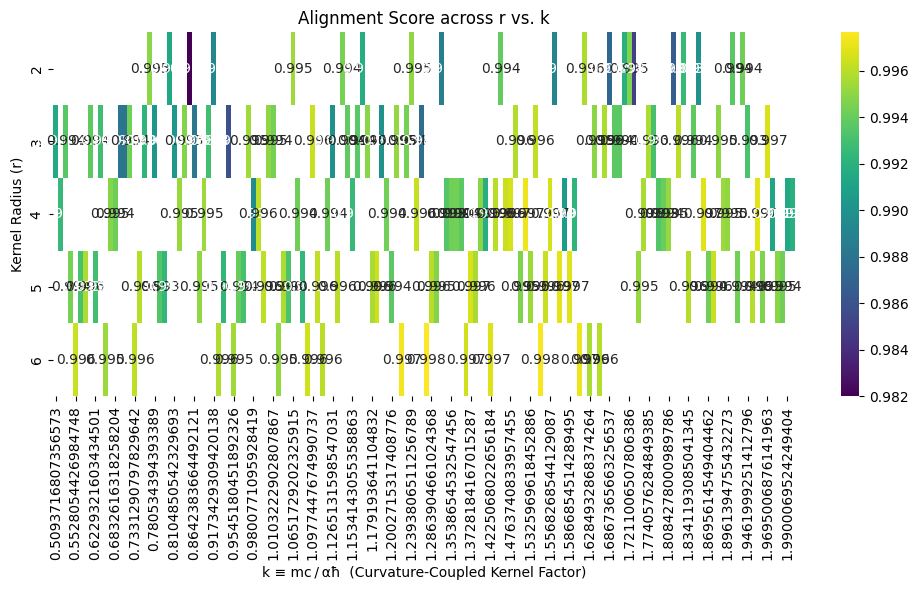

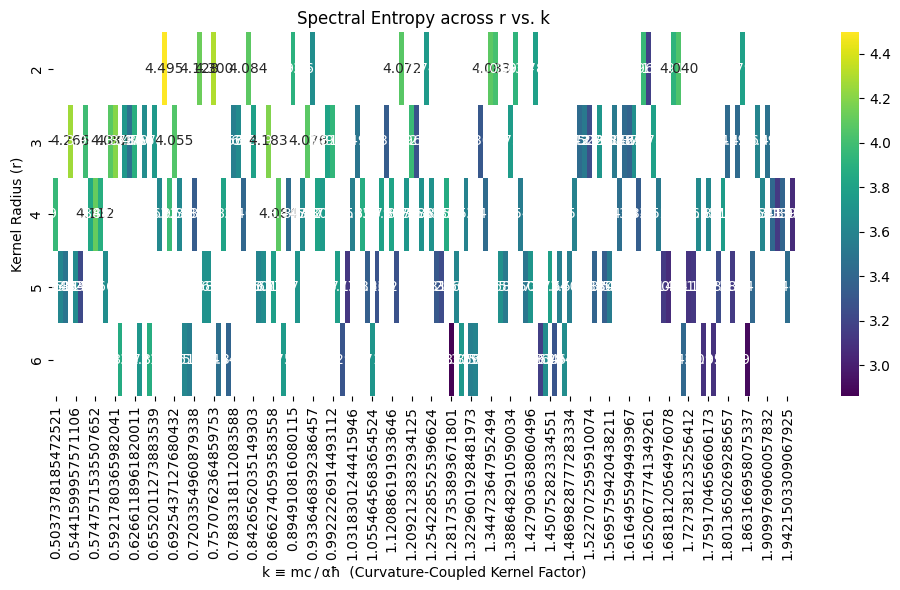

KeyError: 'light_cone_slope'

In [134]:
plot_heatmap_r_vs_k(df_doe, metric="alignment_score", observer_type_filter="inertial")
plot_heatmap_r_vs_k(df_doe, metric="spectral_entropy", observer_type_filter="accelerating")
plot_heatmap_r_vs_lcs(df_doe, metric="spectral_entropy", observer_type_filter="accelerating")


In [ ]:
plot_top_probability_grids(
    df_doe,
    metric="alignment_score",
    top_n=6,
    match_only=False,
    observer_filter=None
)

plot_top_probability_grids(
    df_doe,
    metric="alignment_score",
    top_n=6,
    match_only=True,
    observer_filter=None
)

plot_top_probability_grids(
    df_doe,
    metric="alignment_score",
    top_n=6,
    match_only=False,
    observer_filter="inertial"
)

# Original DOE

In [ ]:
import numpy as np

# Define the tolerance and target value
#target = 0.01369863
target = 0.0137035999
#tol = 0.00001
tol = 0.000005

def meets_target(prob_grid, target, tol):
    # Return True if at least one value in prob_grid is within tolerance of the target
    return np.any(np.abs(prob_grid - target) <= tol)

#for verification
#M_values = [9]         # Example grid sizes for rows
#N_values = [9]         # Example grid sizes for columns
#r_values = [2]           # Example kernel radii
#k_values = [0.5]     # Example slope factors


# Define the ranges for the parameters
M_values = [9, 11, 13, 15, 17, 19, 21,]         # Example grid sizes for rows
N_values = [9, 11, 13, 15, 17, 19, 21]         # Example grid sizes for columns
r_values = [2, 3, 4, 5, 6]           # Example kernel radii
k_values = [0.5, 0.6, 0.7, 0.9, 1.0, 1.5, 2.0]     # Example slope factors

results = []  # To store the combinations that meet the condition



# Loop over all parameter combinations
for M in M_values:
    for N in N_values:
        for r in r_values:
            for k in k_values:
                print(f"Checking combination: M={M}, N={N}, r={r}, k={k}")

                # Initialize grid and center node (assuming your function returns grid, center_i, center_j)
                inertial_grid, center_i, center_j = initialize_grid(M, N)

                # Generate the kernel (using the space-filling lattice kernel function)
                kernel = create_space_filling_lattice_kernel(r)

                # Define the past light cone mask
                past_cone_mask = define_past_light_cone(M, N, center_i, center_j, k=k)
                # Augment the mask by adding the inertial next event
                light_cone_mask, future_node_mask = add_future_node(past_cone_mask, center_i, center_j, observer_type='inertial')

                # Compute the probability grid
                prob_grid = compute_probability_grid(light_cone_mask, kernel, epsilon=1e-10)

                # Check if any value in the probability grid meets the target condition
                if meets_target(prob_grid, target, tol):
                    # Find the indices and values that match
                    matching_indices = np.where(np.abs(prob_grid - target) <= tol)
                    matching_values = prob_grid[matching_indices]
                    count_matches = matching_values.size  # count how many matching values
                    results.append({
                        "M": M,
                        "N": N,
                        "r": r,
                        "k": k,
                        "indices": matching_indices,
                        "values": matching_values,
                        "count": count_matches
                    })
                    print(f"Match found for M={M}, N={N}, r={r}, k={k}")
                    print("Matching probability values:", matching_values)
                    print("Number of matching values:", count_matches)

# Report results
if results:
    print("\nParameter combinations that yield a probability value within the target range:")
    for res in results:
        print(res)
else:
    print("No parameter combinations produced a probability value within the target range.")


# Process the results list to convert arrays into strings for CSV output
output_data = []
for res in results:
    row = {
        "M": res["M"],
        "N": res["N"],
        "r": res["r"],
        "k": res["k"],
        "count": res["count"],
        # Convert indices and values to a string representation
        "indices": str(res["indices"]),
        "values": str(res["values"])
    }
    output_data.append(row)

# Create a DataFrame from the results and write it out as a CSV
df = pd.DataFrame(output_data)
df.to_csv("doe_results.csv", index=False)

print("Results dumped to doe_results.csv")


Checking combination: M=9, N=9, r=2, k=0.5
Match found for M=9, N=9, r=2, k=0.5
Matching probability values: [0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863]
Number of matching values: 7
Checking combination: M=9, N=9, r=2, k=0.6
Match found for M=9, N=9, r=2, k=0.6
Matching probability values: [0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863]
Number of matching values: 7
Checking combination: M=9, N=9, r=2, k=0.7
Checking combination: M=9, N=9, r=2, k=0.9
Checking combination: M=9, N=9, r=2, k=1.0
Checking combination: M=9, N=9, r=2, k=1.5
Checking combination: M=9, N=9, r=2, k=2.0
Checking combination: M=9, N=9, r=3, k=0.5
Checking combination: M=9, N=9, r=3, k=0.6
Checking combination: M=9, N=9, r=3, k=0.7
Checking combination: M=9, N=9, r=3, k=0.9
Checking combination: M=9, N=9, r=3, k=1.0
Checking combination: M=9, N=9, r=3, k=1.5
Checking combination: M=9, N=9, r=3, k=2.0
Checking combination: M=9, N=9, r=4, k=0.5
Check

In [ ]:
import numpy as np
import pandas as pd

# Define the tolerance and target probability
target = 0.01369
tol = 0.0000005

def meets_target(prob_grid, target, tol):
    """Returns True if at least one probability in prob_grid is within tolerance of target."""
    return np.any(np.abs(prob_grid - target) <= tol)


def check_next_event(prob_grid, center_i, center_j):
    """
    Checks if the next event node contains the target probability value.

    Returns:
        - Boolean indicating if it matches.
        - Probability value at the next event node.
    """
    next_i = center_i - 1  # Assuming forward in time direction
    next_j = center_j

    if 0 <= next_i < prob_grid.shape[0] and 0 <= next_j < prob_grid.shape[1]:
        next_event_prob = prob_grid[next_i, next_j]
        if abs(next_event_prob - target) <= tol:
            return True, next_event_prob
    return False, None

def run_design_of_experiments(M_range, N_range, r_range, k_range):
    """
    Runs a design of experiments over a range of M, N, r, and k values.
    Handles ranges or fixed values for each parameter.

    Parameters:
        - M_range: (min, max, step) for M (rows) OR a fixed value
        - N_range: (min, max, step) for N (columns) OR a fixed value
        - r_range: (min, max, step) for kernel radius OR a fixed value
        - k_range: (min, max, step) for light cone slope OR a fixed value

    Outputs:
        - Prints matched results
        - Saves results to a CSV file ("doe_results.csv")
    """

    # Generate parameter values using np.arange for ranges, or use the fixed value
    if isinstance(M_range, tuple):
        M_values = np.arange(M_range[0], M_range[1], M_range[2])
    else:
        M_values = [M_range]

    if isinstance(N_range, tuple):
        N_values = np.arange(N_range[0], N_range[1], N_range[2])
    else:
         N_values = [N_range]

    if isinstance(r_range, tuple):
        r_values = np.arange(r_range[0], r_range[1], r_range[2])
    else:
        r_values = [r_range]

    if isinstance(k_range, tuple):
        k_values = np.arange(k_range[0], k_range[1], k_range[2])
    else:
        k_values = [k_range]


    results = []  # Store results

    # Loop over all combinations of M, N, r, k
    for M in M_values:
        for N in N_values:
            for r in r_values:
                for k in k_values:
                    print(f"Checking: M={M}, N={N}, r={r}, k={k}")

                    # Initialize grid and center node
                    inertial_grid, center_i, center_j = initialize_grid(M, N)

                    # Generate the kernel
                    kernel = create_space_filling_lattice_kernel(r)

                    # Define the past light cone mask
                    past_cone_mask = define_past_light_cone(M, N, center_i, center_j, k=k)
                    light_cone_mask, future_node_mask = add_future_node(past_cone_mask, center_i, center_j, observer_type='inertial')

                    # Compute the probability grid
                    prob_grid = compute_probability_grid(light_cone_mask, kernel, epsilon=1e-10)


                    # Check for target probability match anywhere in the grid
                    match_found = meets_target(prob_grid, target, tol)
                    matching_indices = np.where(np.abs(prob_grid - target) <= tol) if match_found else None
                    matching_values = prob_grid[matching_indices] if match_found else None
                    count_matches = matching_values.size if match_found else 0

                    # Check if the next event node contains the fun number
                    next_event_match, next_event_value = check_next_event(prob_grid, center_i, center_j)

                    results.append({
                        "M": M, "N": N, "r": r, "k": k,
                        "count": count_matches,
                        "indices": str(matching_indices) if match_found else "None",
                        "values": str(matching_values) if match_found else "None",
                        "next_event_has_fun_number": next_event_match,  # New column
                        "next_event_value": next_event_value if next_event_match else "None"
                    })
                    # Check if the next event node contains the fun number
                    next_event_match, next_event_value = check_next_event(prob_grid, center_i, center_j)

                    results.append({
                        "M": M, "N": N, "r": r, "k": k,
                        "count": count_matches,
                        "indices": str(matching_indices) if match_found else "None",
                        "values": str(matching_values) if match_found else "None",
                        "next_event_has_fun_number": next_event_match,  # New column
                        "next_event_value": next_event_value if next_event_match else "None"
                    })

                    if match_found:
                        print(f"Match found! M={M}, N={N}, r={r}, k={k}, Count={count_matches}")

                    if next_event_match:
                        print(f"Fun number found in next event! M={M}, N={N}, r={r}, k={k}, Value={next_event_value}")
                        print(f"Match found! M={M}, N={N}, r={r}, k={k}, Count={count_matches}")

    # Save results to a CSV file
    if results:
        df = pd.DataFrame(results)
        df.to_csv("doe_results.csv", index=False)
        print("Results saved to doe_results.csv")
    else:
        print("No matching parameter sets found.")

run_design_of_experiments(
    M_range=(9, 100, 1),     # M values from 9 to 100, stepping by 2
    N_range=(9, 100, 1),     # N values from 9 to 100, stepping by 2
    r_range=(2,10,1),          # r is fixed at 2.0
    k_range=(0.5,10,0.5)            # k is fixed at 1.0
)

Streaming output truncated to the last 5000 lines.
Checking: M=99, N=67, r=2, k=9.0
Checking: M=99, N=67, r=2, k=9.5
Checking: M=99, N=67, r=3, k=0.5
Checking: M=99, N=67, r=3, k=1.0
Checking: M=99, N=67, r=3, k=1.5
Checking: M=99, N=67, r=3, k=2.0
Checking: M=99, N=67, r=3, k=2.5
Checking: M=99, N=67, r=3, k=3.0
Checking: M=99, N=67, r=3, k=3.5
Checking: M=99, N=67, r=3, k=4.0
Checking: M=99, N=67, r=3, k=4.5
Checking: M=99, N=67, r=3, k=5.0
Checking: M=99, N=67, r=3, k=5.5
Checking: M=99, N=67, r=3, k=6.0
Checking: M=99, N=67, r=3, k=6.5
Checking: M=99, N=67, r=3, k=7.0
Checking: M=99, N=67, r=3, k=7.5
Checking: M=99, N=67, r=3, k=8.0
Checking: M=99, N=67, r=3, k=8.5
Checking: M=99, N=67, r=3, k=9.0
Checking: M=99, N=67, r=3, k=9.5
Checking: M=99, N=67, r=4, k=0.5
Checking: M=99, N=67, r=4, k=1.0
Checking: M=99, N=67, r=4, k=1.5
Checking: M=99, N=67, r=4, k=2.0
Checking: M=99, N=67, r=4, k=2.5
Checking: M=99, N=67, r=4, k=3.0
Checking: M=99, N=67, r=4, k=3.5
Checking: M=99, N=67, r=4

In [ ]:
import numpy as np
import pandas as pd

# Define the tolerance and target probability
target = 0.01369
tol = 0.0000005

def meets_target(prob_grid, target, tol):
    """Returns True if at least one probability in prob_grid is within tolerance of target."""
    return np.any(np.abs(prob_grid - target) <= tol)

def check_next_event(prob_grid, center_i, center_j):
    """
    Checks if the next event node contains the target probability value.

    Returns:
        - Boolean indicating if it matches.
        - Probability value at the next event node.
    """
    next_i = center_i - 1  # Assuming forward in time direction
    next_j = center_j

    if 0 <= next_i < prob_grid.shape[0] and 0 <= next_j < prob_grid.shape[1]:
        next_event_prob = prob_grid[next_i, next_j]
        if abs(next_event_prob - target) <= tol:
            return True, next_event_prob
    return False, None

def run_design_of_experiments(M_range, N_range, r_range, k_range):
    """
    Runs a design of experiments over a range of M, N, r, and k values.

    Parameters:
        - M_range: (min, max, step) for M (rows)
        - N_range: (min, max, step) for N (columns)
        - r_range: (min, max, step) for kernel radius
        - k_range: (min, max, step) for light cone slope
        - step: common step size (optional override for all ranges)

    Outputs:
        - Prints matched results
        - Saves results to a CSV file ("doe_results.csv")
    """

    # Generate parameter values using np.arange (ensures equal stepping)
    M_values = np.arange(*M_range, step)
    N_values = np.arange(*N_range, step)
    r_values = np.arange(*r_range, step)
    k_values = np.arange(*k_range, step)

    results = []  # Store results
    next_event_results = []  # Store results where the next event node matches

    # Loop over all combinations of M, N, r, k
    for M in M_values:
        for N in N_values:
            for r in r_values:
                for k in k_values:
                    print(f"Checking: M={M}, N={N}, r={r}, k={k}")

                    # Initialize grid and center node
                    inertial_grid, center_i, center_j = initialize_grid(M, N)

                    # Generate the kernel
                    kernel = create_space_filling_lattice_kernel(r)

                    # Define the past light cone mask
                    past_cone_mask = define_past_light_cone(M, N, center_i, center_j, k=k)
                    light_cone_mask, future_node_mask = add_future_node(past_cone_mask, center_i, center_j, observer_type='inertial')

                    # Compute the probability grid
                    prob_grid = compute_probability_grid(light_cone_mask, kernel, epsilon=1e-10)

                    # Check for target probability match anywhere in the grid
                    if meets_target(prob_grid, target, tol):
                        matching_indices = np.where(np.abs(prob_grid - target) <= tol)
                        matching_values = prob_grid[matching_indices]
                        count_matches = matching_values.size

                        results.append({
                            "M": M, "N": N, "r": r, "k": k,
                            "count": count_matches,
                            "indices": str(matching_indices),
                            "values": str(matching_values)
                        })
                        print(f"Match found! M={M}, N={N}, r={r}, k={k}, Count={count_matches}")

                    # Check if the next event node contains the fun number
                    next_event_match, next_event_value = check_next_event(prob_grid, center_i, center_j)
                    if next_event_match:
                        next_event_results.append({
                            "M": M, "N": N, "r": r, "k": k,
                            "next_event_value": next_event_value
                        })
                        print(f"Fun number found in next event! M={M}, N={N}, r={r}, k={k}, Value={next_event_value}")

    # Save results to a CSV file
    if results:
        df = pd.DataFrame(results)
        df.to_csv("doe_results.csv", index=False)
        print("Results saved to doe_results.csv")

    # Save next event matches separately
    if next_event_results:
        df_next = pd.DataFrame(next_event_results)
        df_next.to_csv("doe_next_event_results.csv", index=False)
        print("Next event matches saved to doe_next_event_results.csv")
    else:
        print("No matching parameter sets found.")


run_design_of_experiments(
    M_range=(9, 15, 2),     # M values from 9 to 15, stepping by 2
    N_range=(9, 15, 2),     # N values from 9 to 15, stepping by 2
    r_range=(2, 5, 1),      # r values from 2 to 5, stepping by 1
    k_range=(0.5, 0.8, 0.1) # k values from 0.5 to 0.8, stepping by 0.1
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Assume these functions are defined elsewhere in your notebook:
# - initialize_grid(M, N)
# - create_space_filling_lattice_kernel(r)
# - define_past_light_cone(M, N, center_i, center_j, k)
# - add_future_node(past_cone_mask, center_i, center_j, observer_type)
# - compute_probability_grid(light_cone_mask, kernel, epsilon)

def plot_probability_spectrum(prob_grid, M, N, r):
    """
    Plots a histogram of probability values from the computed probability grid.
    """
    plt.figure()
    # Flatten the grid to 1D and create a histogram of the probability values
    plt.hist(prob_grid.flatten(), bins=50, color='blue', edgecolor='black')
    plt.title(f'Probability Spectrum (M={M}, N={N}, r={r})')
    plt.xlabel('Probability Value')
    plt.ylabel('Frequency')
    plt.show()

def design_of_experiments():
    # Define a list of parameter sets to explore
    parameter_sets = [
        {"M": 9, "N": 9, "r": 2, "k": 0.5},
        {"M": 9, "N": 9, "r": 3, "k": 0.5},
        {"M": 11, "N": 11, "r": 3, "k": 0.5},
        # Add additional parameter sets as needed
    ]

    for params in parameter_sets:
        M = params["M"]
        N = params["N"]
        r = params["r"]
        k = params["k"]

        # Initialize the grid and get the center node indices
        inertial_grid, center_i, center_j = initialize_grid(M, N)

        # Generate the kernel (using your space-filling lattice kernel function)
        kernel = create_space_filling_lattice_kernel(r)
        # (If needed, enforce binary values: binary_kernel = (kernel > 0).astype(np.int8))

        # Define the past light cone mask for the inertial observer
        past_cone_mask = define_past_light_cone(M, N, center_i, center_j, k=k)
        # Augment the mask by adding the inertial next event
        light_cone_mask, future_node_mask = add_future_node(past_cone_mask, center_i, center_j, observer_type='inertial')

        # Compute the probability grid via convolution
        prob_grid = compute_probability_grid(light_cone_mask, kernel, epsilon=1e-10)

        # Plot the spectrum (frequency distribution) of probability values
        plot_probability_spectrum(prob_grid, M, N, r)

if __name__ == "__main__":
    design_of_experiments()


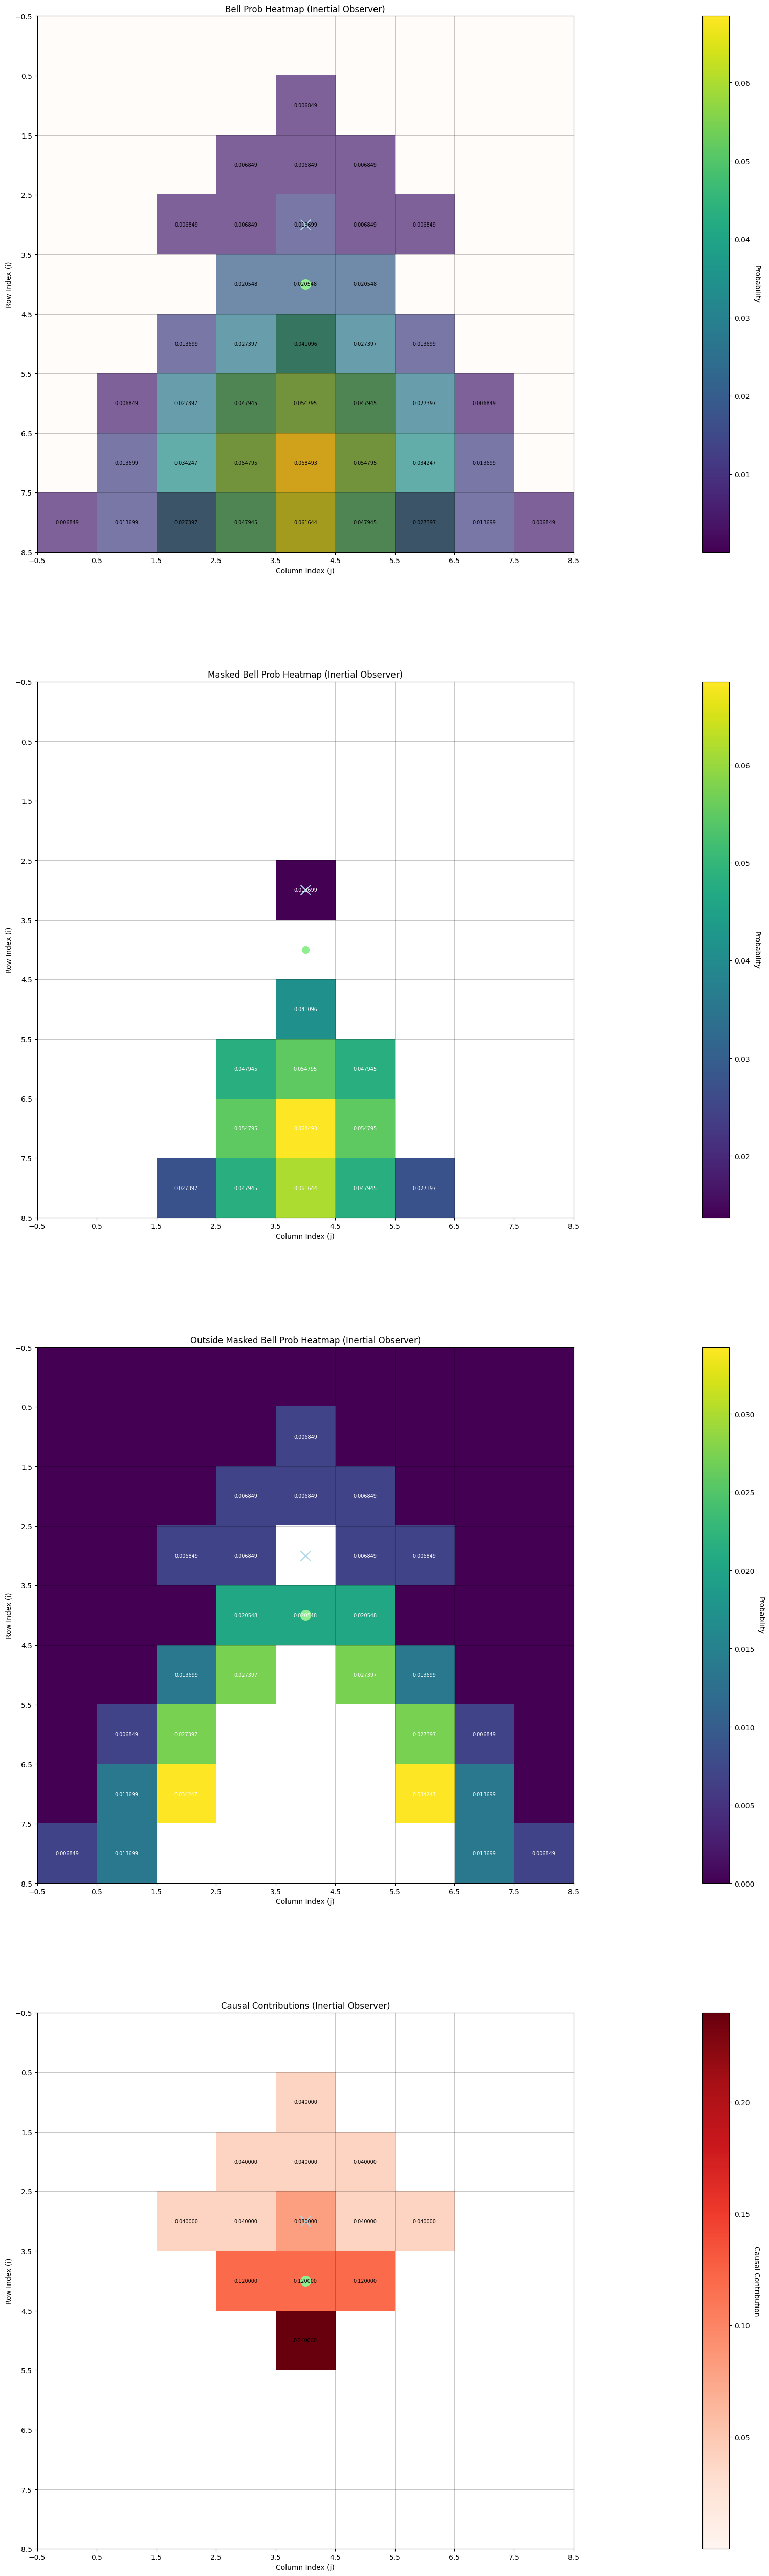

In [ ]:
#Note depends on functions from Current Light Cone Studies

def main():
    # Fine Structure Constant Coincidence - Parameters
    #M, N = 10, 10  # Grid size (rows x columns)
    #M, N = 9, 9  # Grid size (rows x columns)
    #r = 2          # Radius of the uniform Euclidean kernel
    #k = 0.5        # Slope factor for the light cone

    # Test Params
    M, N = 9, 9  # Grid size (rows x columns)
    r = 2          # Radius of the uniform Euclidean kernel
    k = 0.5        # Slope factor for the light cone

    # Initialize grid and center node
    inertial_grid, center_i, center_j = initialize_grid(M, N)

    # Define the kernel
    #kernel = create_uniform_euclidean_kernel(r)
    kernel = create_space_filling_lattice_kernel(r)
    binary_kernel = kernel.copy()


    # Scenario 1: Inertial Observer
    observer_type_1 = 'inertial'
    past_cone_mask_1 = define_past_light_cone(M, N, center_i, center_j, k=k)
    #past_cone_mask_1 = define_adaptive_light_cone(M, N, center_i, center_j, k=k)
    light_cone_mask_1, future_node_mask_1 = add_future_node(past_cone_mask_1, center_i, center_j, observer_type=observer_type_1)
    prob_grid_1 = compute_probability_grid(light_cone_mask_1, kernel, epsilon=1e-10)


    # Compute statistics for both observers
    stats_inertial = verify_probabilities(prob_grid_1, light_cone_mask_1, observer_type_1)

    # Combine statistics into dictionaries for the tables
    stats_table_outside = {
        "Inertial": stats_inertial["Outside"],
        #"Accelerating": stats_accelerating["Outside"]
    }

    stats_table_inside = {
        "Inertial": stats_inertial["Inside"],
        #"Accelerating": stats_accelerating["Inside"]
    }


    # Compute contribution maps
    contribution_from_prob_1 = compute_causal_contributions_from_prob_grid(
        prob_grid_1, kernel, center_i, center_j, observer_type='inertial'
    )


    # Visualization -----------------------------------------
    # Create a figure with GridSpec for arranged subplots and tables
    fig = plt.figure(figsize=(65, 125), constrained_layout=True)

    # Update to 9 rows; adjust height ratios as needed
    gs = gridspec.GridSpec(9, 1, height_ratios=[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 0.5, 0.5, 0.5], hspace=0.3, wspace=0.1)


    # Row 2: Probability Heatmaps
    ax3 = fig.add_subplot(gs[1, 0])
    plot_probability_heatmap(ax3, prob_grid_1, past_cone_mask=past_cone_mask_1, future_node_mask=future_node_mask_1,
                            center_i=center_i, center_j=center_j, observer_type=observer_type_1, title="Bell Prob Heatmap (Inertial Observer)")


    # Row 3: Masked Probability Heatmaps (Inside PLC)
    ax5 = fig.add_subplot(gs[2, 0])
    plot_masked_probability_heatmap(ax5, prob_grid_1, past_cone_mask=past_cone_mask_1, future_node_mask=future_node_mask_1,
                                    center_i=center_i, center_j=center_j, observer_type=observer_type_1, title="Masked Bell Prob Heatmap (Inertial Observer)")


    # Row 4: Masked Probability Heatmaps (Outside PLC)
    ax7 = fig.add_subplot(gs[3, 0])
    plot_outside_mask_probability_heatmap(ax7, prob_grid_1, past_cone_mask=past_cone_mask_1, future_node_mask=future_node_mask_1,
                                          center_i=center_i, center_j=center_j, observer_type=observer_type_1, title="Outside Masked Bell Prob Heatmap (Inertial Observer)")

    # Row 5 (NEW): Causal Contributions Heatmaps
    ax9 = fig.add_subplot(gs[4, 0])
    plot_causal_contributions_heatmap(ax9, contribution_from_prob_1, center_i, center_j, 'inertial',
                                      title="Causal Contributions (Inertial Observer)")


    # Show the figure
    plt.show()


if __name__ == "__main__":
    main()


# Lorentz Factor Studies


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def count_incidence_inertial(grid_size):
    """
    Counts the number of nearest time-like steps in the inertial frame.
    """
    count = 1  # The standard single step forward in time (i=1, j=0)
    return count

def count_incidence_boosted(grid_size):
    """
    Counts the number of new time-like steps in the accelerated frame,
    where time steps require some spatial offset.
    """
    count = 2  # Two mixed time-space steps needed (i=1, j=1 and i=2, j=2)
    return count

def compute_gamma(inertial_count, boosted_count):
    """
    Computes the discrete Lorentz factor gamma as the ratio of old to new time steps.
    """
    return inertial_count / boosted_count

def main():
    grid_size = 10  # Define grid size

    # Count incidence relationships
    inertial_incidence = count_incidence_inertial(grid_size)
    boosted_incidence = count_incidence_boosted(grid_size)

    # Compute Lorentz gamma factor
    gamma = compute_gamma(inertial_incidence, boosted_incidence)

    print("Inertial time-like step count:", inertial_incidence)
    print("Boosted time-like step count:", boosted_incidence)
    print("Computed Lorentz factor (gamma):", gamma)

    return gamma

if __name__ == "__main__":
    gamma = main()


Inertial time-like step count: 1
Boosted time-like step count: 2
Computed Lorentz factor (gamma): 0.5


# Modified Minkowski Diagram

In [ ]:
# Define the axes
arrow_length = 0.7  # Adjusted to fit range [0, 1]
angle_t_t_prime = 20  # 20-degree angle between t (z-axis) and t'
x_axis = [arrow_length, 0, 0]  # x-axis
t_axis = [0, 0, arrow_length]  # t-axis (now z-axis)
t_prime_axis = [
    0,
    np.cos(np.radians(angle_t_t_prime)) * arrow_length,
    np.sin(np.radians(angle_t_t_prime)) * arrow_length
]  # t'-axis (rotated)

# Create 3D plot
fig = go.Figure()

# Define the 45° x,t plane extending along t' (y-axis)
x_vals_45 = np.linspace(0, arrow_length, 10)  # x-values along the plane
y_vals_45 = np.linspace(0, 1, 10)  # Extend along y-axis (t')
x_plane_45, y_plane_45 = np.meshgrid(x_vals_45, y_vals_45)
z_plane_45 = x_plane_45  # z = x for the 45° x,z plane

# Add the 45° x,t plane to the plot
fig.add_trace(go.Surface(
    x=x_plane_45,
    y=y_plane_45,
    z=z_plane_45,
    colorscale='Reds',
    opacity=0.5,
    showscale=False,
    name='45° x,t plane'
))

# Define the x, t' plane
x_vals_t_prime = np.linspace(0, arrow_length, 10)  # x-values along the plane
y_vals_t_prime = np.linspace(0, 1, 10)  # Full range along the y-axis
x_plane_t_prime, y_plane_t_prime = np.meshgrid(x_vals_t_prime, y_vals_t_prime)
z_plane_t_prime = y_plane_t_prime * np.tan(np.radians(angle_t_t_prime))  # Calculate z-coordinates from t' angle

# Add the x, t' plane to the plot
fig.add_trace(go.Surface(
    x=x_plane_t_prime,
    y=y_plane_t_prime,
    z=z_plane_t_prime,
    colorscale='Blues',
    opacity=0.5,
    showscale=False,
    name='x, t\' plane'
))

# Define points in the y,z plane
points_yz = [
    {"y": 0.3, "z": 0.6},  # Point 1
    {"y": 0.5, "z": 0.3}   # Point 2
]

# Calculate intersection points on the 45° x,z plane
intersection_points = []
for point in points_yz:
    intersection_x = point["z"]  # On the 45° plane, x = z
    intersection_y = point["y"]  # y remains the same
    intersection_z = intersection_x  # z = x for the 45° plane
    intersection_points.append({"x": intersection_x, "y": intersection_y, "z": intersection_z})

# Add the intersection points to the plot
for i, intersection in enumerate(intersection_points, start=1):
    fig.add_trace(go.Scatter3d(
        x=[intersection["x"]], y=[intersection["y"]], z=[intersection["z"]],
        mode='markers',
        marker=dict(color='orange', size=5),
        text=f"Intersection {i}",
        textposition="top center",
        name=f"Intersection Point {i}"
    ))

    # Add dashed lines connecting the y,z points to the intersection points
    original_point = points_yz[i - 1]
    fig.add_trace(go.Scatter3d(
        x=[0, intersection["x"]],  # From the y,z plane (x=0) to the intersection
        y=[original_point["y"], intersection["y"]],  # Maintain the y-coordinate
        z=[original_point["z"], intersection["z"]],  # From z to intersection
        mode='lines',
        line=dict(color='orange', width=2, dash='dash'),
        name=f"Line to Intersection {i}"
    ))

# Add the points and dashed lines to the 45° x,z plane
for i, point in enumerate(points_yz, start=1):
    # Plot the point on the y,z plane
    fig.add_trace(go.Scatter3d(
        x=[0], y=[point["y"]], z=[point["z"]],
        mode='markers+text',
        marker=dict(color='green', size=5),
        text=f"Event {i}",
        textposition="top center",
        name=f"Event {i}"
    ))

    # Calculate the intersection on the 45° x,z plane
    intersection_x = point["z"]  # Since the plane is at 45° in the x,z plane (z = x)
    fig.add_trace(go.Scatter3d(
        x=[0, intersection_x],  # From the y,z plane (x=0) to the intersection
        y=[point["y"], point["y"]],  # Maintain the y-coordinate
        z=[point["z"], intersection_x],  # From z to intersection
        mode='lines',
        line=dict(color='green', width=2, dash='dash'),
        name=f"Line to 45° x,z plane from Point {i}"
    ))

# Main axes
fig.add_trace(go.Scatter3d(
    x=[0, x_axis[0]], y=[0, x_axis[1]], z=[0, x_axis[2]],
    mode='lines+text',
    line=dict(color='black', width=5),
    text=["", "x"],
    textposition="top center",
    name='x-axis'
))
fig.add_trace(go.Scatter3d(
    x=[0, t_axis[0]], y=[0, t_axis[1]], z=[0, t_axis[2]],
    mode='lines+text',
    line=dict(color='black', width=5),
    text=["", "t"],
    textposition="top center",
    name='z-axis (t-axis)'
))
fig.add_trace(go.Scatter3d(
    x=[0, t_prime_axis[0]], y=[0, t_prime_axis[1]], z=[0, t_prime_axis[2]],
    mode='lines+text',
    line=dict(color='gray', width=5),
    text=["", "t'"],
    textposition="top center",
    name="t'-axis"
))

# Calculate intersection points on the x,t' plane
intersection_points_xt_prime = []
for point in intersection_points:
    y = point["y"]  # y remains the same
    z = y * np.tan(np.radians(angle_t_t_prime))  # z = y * tan(20°)
    x = z  # x = z for the 45° x,z plane
    intersection_points_xt_prime.append({"x": x, "y": y, "z": z})

# Add the intersection points on the x,t' plane to the plot
for i, intersection in enumerate(intersection_points_xt_prime, start=1):
    fig.add_trace(go.Scatter3d(
        x=[intersection["x"]], y=[intersection["y"]], z=[intersection["z"]],
        mode='markers',
        marker=dict(color='blue', size=5),
        text=f"x,t' {i}",
        textposition="top center",
        name=f"x,t' Point {i}"
    ))

    # Add dashed lines connecting the 45° plane intersection points to the x,t' plane intersection points
    prev_point = intersection_points[i - 1]
    fig.add_trace(go.Scatter3d(
        x=[prev_point["x"], intersection["x"]],  # From 45° plane to x,t' plane
        y=[prev_point["y"], intersection["y"]],
        z=[prev_point["z"], intersection["z"]],
        mode='lines',
        line=dict(color='blue', width=2, dash='dash'),
        name=f"Line to x,t' Plane {i}"
    ))

# Define the intersection line of the 45° x,z plane and x,t' plane
y_vals_intersection = np.linspace(0, 1, 50)  # Full range of y
z_vals_intersection = y_vals_intersection * np.tan(np.radians(angle_t_t_prime))  # z from x,t' plane
x_vals_intersection = z_vals_intersection  # x = z for 45° x,z plane

# Add the dashed intersection line to the plot
fig.add_trace(go.Scatter3d(
    x=x_vals_intersection,
    y=y_vals_intersection,
    z=z_vals_intersection,
    mode='lines',
    line=dict(color='purple', width=4, dash='dash'),
    name="c'"
))


# Draw dashed lines from the intersection points on the 45° plane to the 45° line in the x,z plane
for i, point in enumerate(intersection_points, start=1):
    # Calculate the projection onto the 45° line in x,z plane (z = x, y = 0)
    x_projection = point["x"]  # x-coordinate remains the same
    z_projection = point["z"]  # z = x for the 45° line
    y_projection = 0  # y = 0 on the 45° line

    # Add the dashed line
    fig.add_trace(go.Scatter3d(
        x=[point["x"], x_projection],  # From the point on the 45° plane to the 45° line
        y=[point["y"], y_projection],  # y-coordinate to 0
        z=[point["z"], z_projection],  # z-coordinate remains the same
        mode='lines',
        line=dict(color='purple', width=2, dash='dash'),
        name=f"Line to 45° Line {i}"
    ))

# Add lines in the x,z plane from the 45° line endpoints to the x-axis
for i, point in enumerate(intersection_points, start=1):
    # Calculate the endpoint on the 45° line in x,z plane (z = x, y = 0)
    x_endpoint = point["x"]  # x-coordinate remains the same
    z_endpoint = point["z"]  # z = x for the 45° line
    y_endpoint = 0  # y = 0 on the 45° line

    # Add a line from the 45° line endpoint to the x-axis
    fig.add_trace(go.Scatter3d(
        x=[x_endpoint, x_endpoint],  # x-coordinate remains constant
        y=[y_endpoint, y_endpoint],  # y-coordinate remains constant at 0
        z=[z_endpoint, 0],  # From z to 0
        mode='lines',
        line=dict(color='blue', width=2, dash='dash'),
        name=f"Line to x-axis {i}"
    ))

# Define a line on the x,z plane at 45 degrees
x_vals_c = np.linspace(0, arrow_length, 10)  # x-values for the 45° line
z_vals_c = x_vals_c  # z = x for 45° line
y_vals_c = np.zeros_like(x_vals_c)  # y = 0 for the x,z plane

# Add the 45° line to the plot
fig.add_trace(go.Scatter3d(
    x=x_vals_c,
    y=y_vals_c,
    z=z_vals_c,
    mode='lines+text',
    line=dict(color='darkgrey', width=4),
    text=[""] * (len(x_vals_c) - 1) + ["c"],  # Label the line at the end
    textposition="top right",
    name="45° Line (c)"
))


# Layout
fig.update_layout(
    width=2000,  # Set the desired width of the canvas
    height=900,   # Set the desired height of the canvas
    scene=dict(
    aspectmode='manual',  # Enables manual control of the aspect ratio
        aspectratio=dict(
            x=1,  # Relative scaling for x-axis
            y=0.85,  # Relative scaling for y-axis
            z=1   # Relative scaling for z-axis
        ),
        xaxis=dict(range=[0, 1],tickvals=[],title=''),
        yaxis=dict(range=[0, 1],tickvals=[],title=''),
        zaxis=dict(range=[0, 1],tickvals=[],title='')
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Show the plot
fig.show()


# Feedback Path Studies

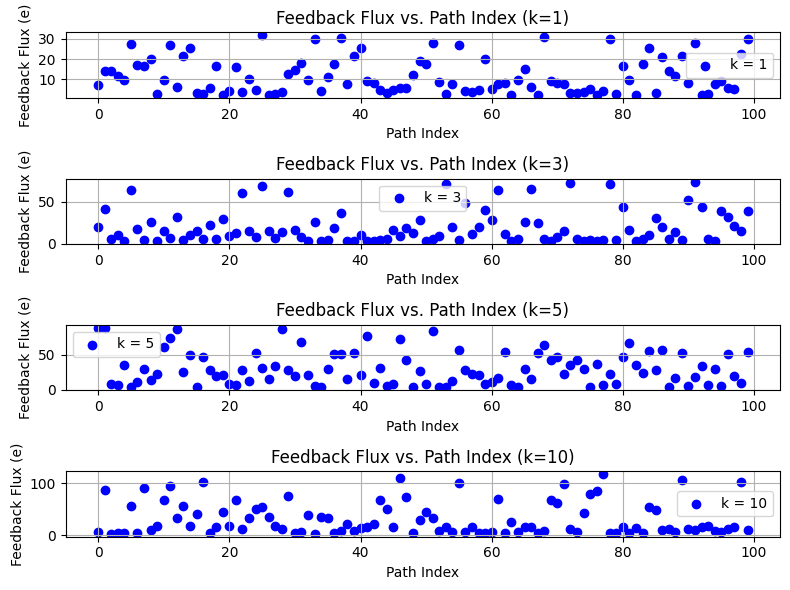

In [ ]:
# Parameters
a = 1   # Scaling factor for the base information content h
b = 1   # Decay factor
k_values = [1, 3, 5, 10]  # Different numbers of event paths (k)
n_paths = 100  # Number of event paths
c_min = 1.2  # Minimum value for c
c_max = 5.0  # Maximum value for c

# Initialize figure for plotting
fig, axes = plt.subplots(len(k_values), 1, figsize=(8, 6))

# Simulate for each k value
for i, k in enumerate(k_values):
    c_values = np.random.uniform(c_min, c_max, n_paths)  # Random values for c
    e_values = np.zeros(n_paths)

    for j in range(n_paths):
        # Calculate e_i for each path
        e_values[j] = (a + 1 / (b * k)) ** (c_values[j] * k)

    # Plot the results
    axes[i].scatter(range(n_paths), e_values, label=f'k = {k}', color='b')
    axes[i].set_title(f'Feedback Flux vs. Path Index (k={k})')
    axes[i].set_xlabel('Path Index')
    axes[i].set_ylabel('Feedback Flux (e)')
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

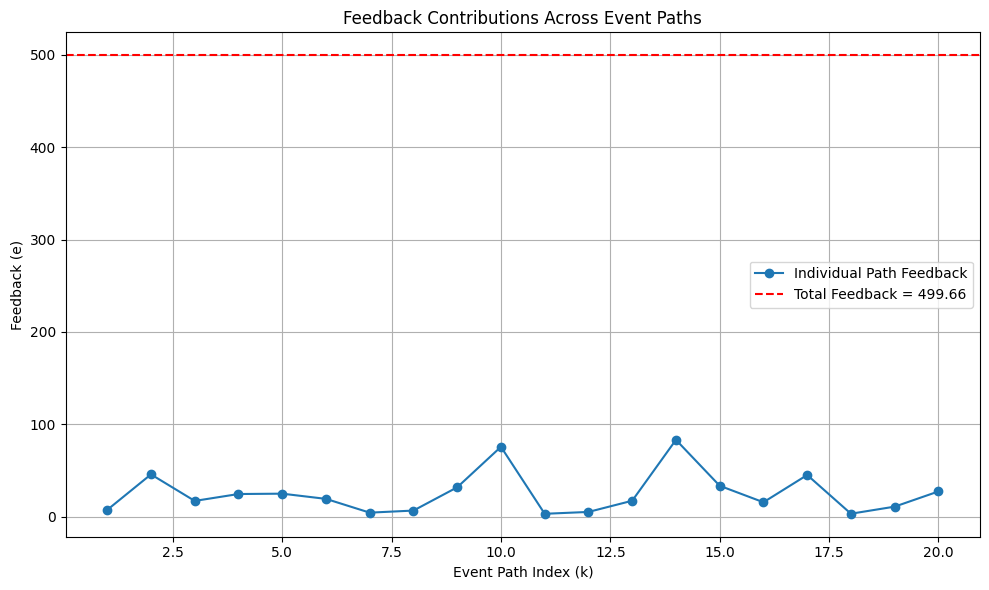

In [ ]:
# Parameters
a = 1  # Scaling factor for the base term
b = 1  # Decay factor
n_paths = 20  # Number of paths (n)
k_values = np.arange(1, n_paths + 1)  # Path indices
random_c = np.random.uniform(1, 5, size=n_paths)  # Randomized c values for each path

# Calculate the total feedback for each path
feedback_values = []

for i in range(n_paths):
    e_i = (a + 1 / (b * k_values[i]))**(random_c[i] * k_values[i])
    feedback_values.append(e_i)

# Calculate the total feedback across all paths
total_feedback = np.sum(feedback_values)

# Plotting the individual feedback contributions and the total feedback
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(k_values, feedback_values, label="Individual Path Feedback", marker='o')
ax.axhline(y=total_feedback, color='r', linestyle='--', label=f"Total Feedback = {total_feedback:.2f}")

# Set labels and title
ax.set_xlabel("Event Path Index (k)")
ax.set_ylabel("Feedback (e)")
ax.set_title("Feedback Contributions Across Event Paths")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


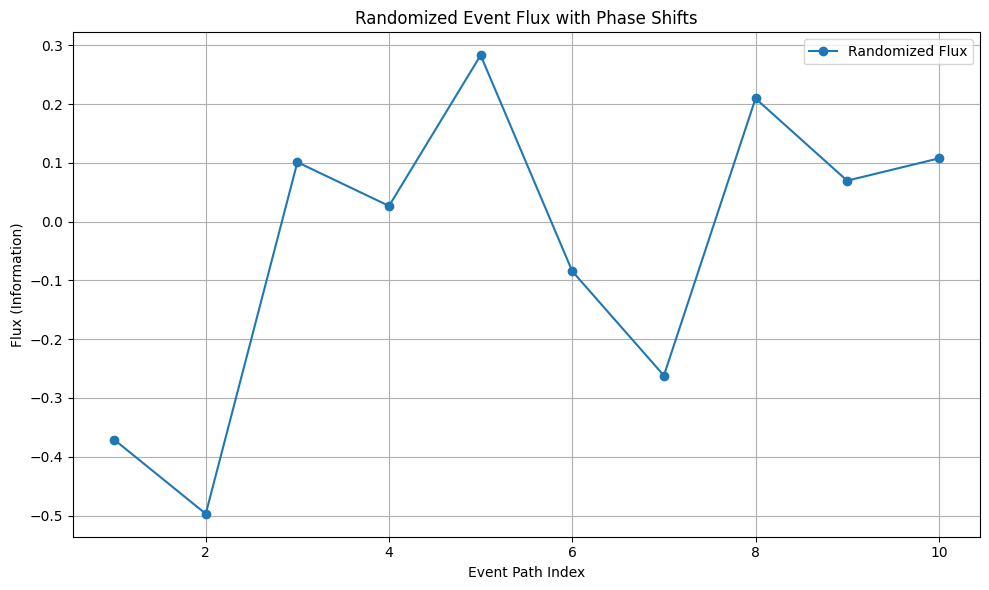

In [ ]:
# Parameters
gamma = 0.02  # Decay rate
n_values = 30  # Number of steps (nodes)
n_paths = 10  # Number of paths to consider

# Random values for r_i (random phase shifts between 0 and 1)
r_values = np.random.rand(n_paths)

# Generate distances and event indices
distances = np.linspace(1, 100, n_paths)
n_indices = np.arange(1, n_paths + 1)

# Create a figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the flux for each path
flux_values = []
for i in range(n_paths):
    flux = np.exp(-gamma * distances[i]) * np.cos(np.pi * n_indices[i] + r_values[i] * np.pi)  # Flux for each path
    flux_values.append(flux)

# Plot the flux
ax.plot(n_indices, flux_values, label="Randomized Flux", marker='o')

# Set labels and title
ax.set_xlabel("Event Path Index")
ax.set_ylabel("Flux (Information)")
ax.set_title("Randomized Event Flux with Phase Shifts")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


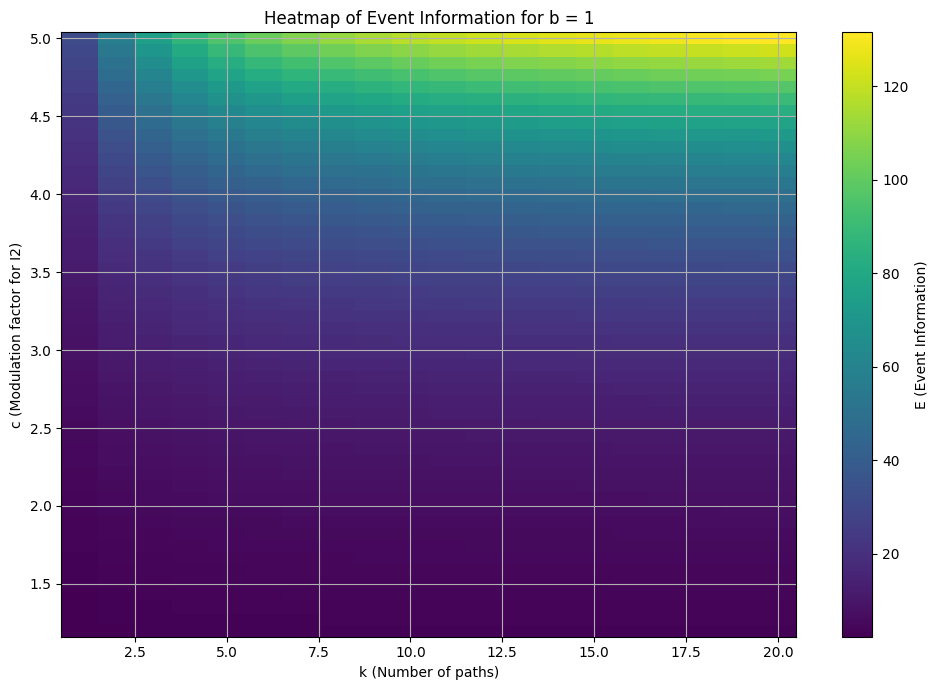

In [ ]:
# Constants
a = 1  # Keeping a fixed unit value for simplicity
h = 1  # Planck's constant (normalized)
b = 1  # Set decay constant for this plot
k_values = np.arange(1, 21)  # Number of paths in I1 (1 to 20)
c_values = np.linspace(1.2, 5, 50)  # Modulation of I2 (more fine-grained range)

# Create meshgrid for k and c
k_grid, c_grid = np.meshgrid(k_values, c_values)

# Calculate E values
E_values = (a*h + h/(b*k_grid))**(c_grid*k_grid)

# Create a figure for the heatmap
fig, ax = plt.subplots(figsize=(10, 7))

# Create the heatmap
cmap = cm.viridis
heatmap = ax.pcolormesh(k_grid, c_grid, E_values, shading='auto', cmap=cmap)
fig.colorbar(heatmap, ax=ax, label='E (Event Information)')

# Set axis labels and title
ax.set_xlabel('k (Number of paths)')
ax.set_ylabel('c (Modulation factor for I2)')
ax.set_title(f'Heatmap of Event Information for b = {b}')

# Add grid and colorbar
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


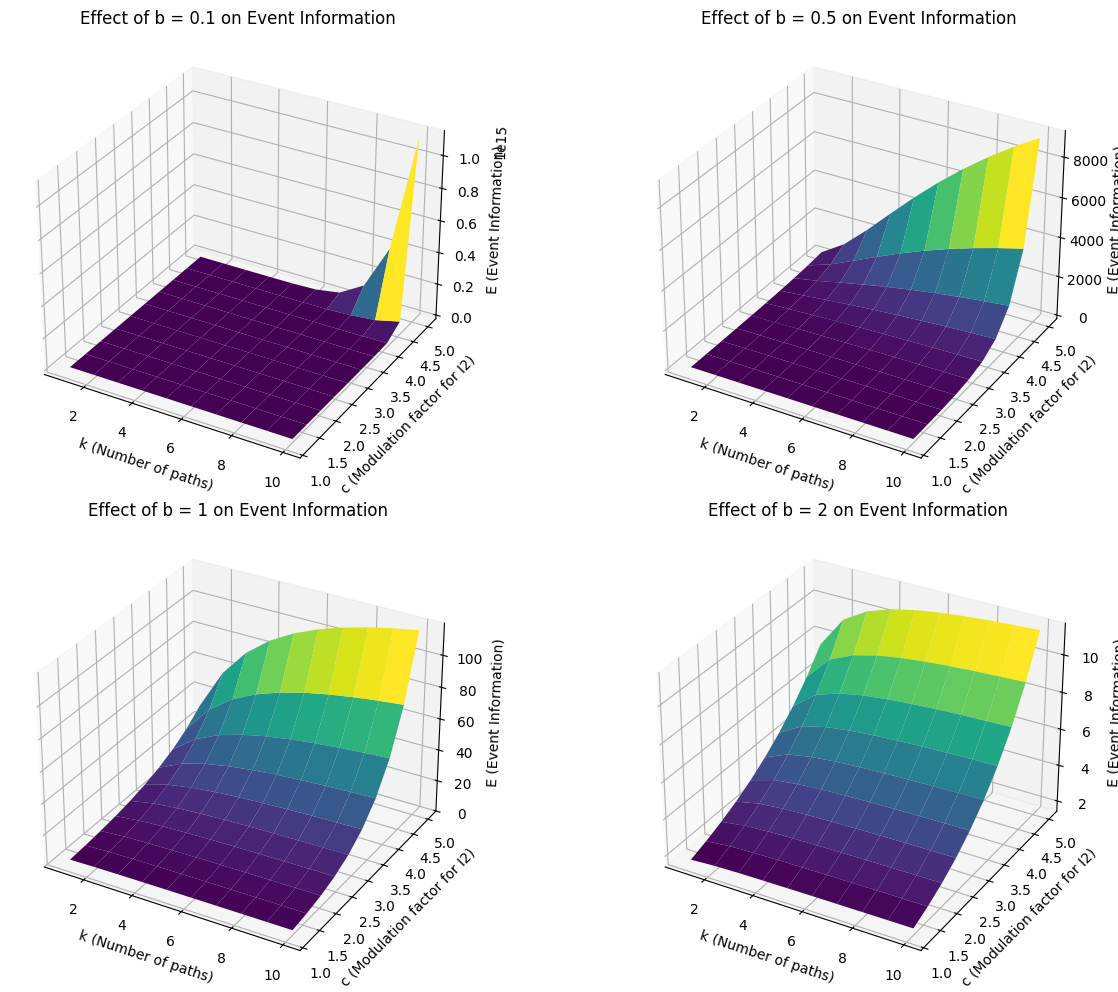

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
a = 1  # Keeping a fixed unit value for simplicity
h = 1  # Planck's constant (normalized)
b_values = [0.1, 0.5, 1, 2]  # Decay values to vary
k_values = np.arange(1, 11)  # Number of paths in I1 (1 to 10)
c_values = np.linspace(1.2, 5, 10)  # Modulation of I2

# Create figure
fig = plt.figure(figsize=(14, 10))

# Create 3D plots
for idx, b in enumerate(b_values):
    # Prepare meshgrid for k and c
    k_grid, c_grid = np.meshgrid(k_values, c_values)
    E_values = (a*h + h/(b*k_grid))**(c_grid*k_grid)

    # Create 3D axis for each decay factor b
    ax = fig.add_subplot(2, 2, idx + 1, projection='3d')
    ax.plot_surface(k_grid, c_grid, E_values, cmap='viridis')

    # Set labels and titles
    ax.set_xlabel('k (Number of paths)')
    ax.set_ylabel('c (Modulation factor for I2)')
    ax.set_zlabel('E (Event Information)')
    ax.set_title(f'Effect of b = {b} on Event Information')

plt.tight_layout()
plt.show()


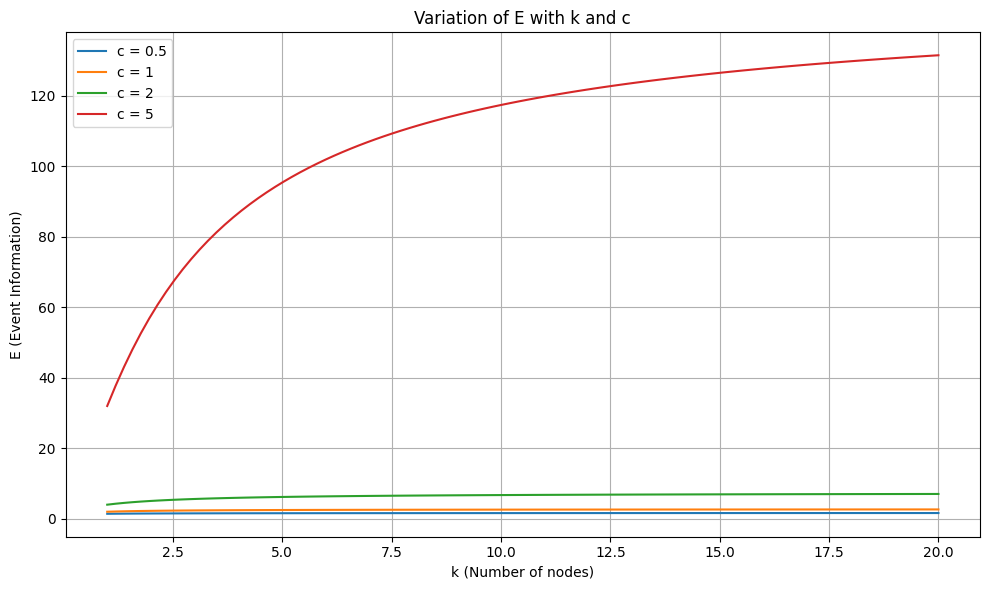

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function for E
def E_function(a, b, k, c):
    return (a * 1 + (1 / (b * k)))**(c * k)

# Set parameters for the plot
a = 1  # Set a to 1 for unitary basis
b = 1  # Set b to 1 for no decay
k_values = np.linspace(1, 20, 100)  # Vary k from 1 to 20
c_values = [0.5, 1, 2, 5]  # Different values of c

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for different values of c
for c in c_values:
    E_values = E_function(a, b, k_values, c)
    plt.plot(k_values, E_values, label=f'c = {c}')

# Add labels and title
plt.title('Variation of E with k and c')
plt.xlabel('k (Number of nodes)')
plt.ylabel('E (Event Information)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


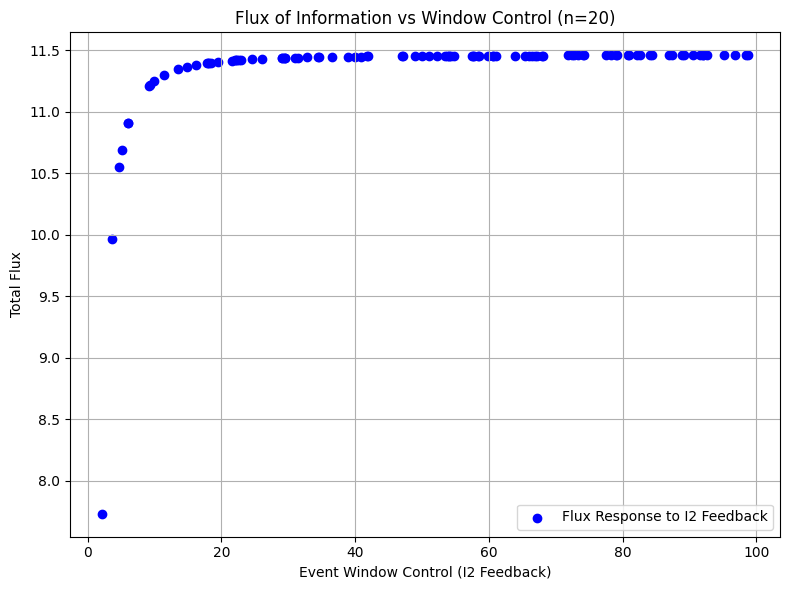

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.02  # Decay rate
n_steps = 100  # Number of steps for simulating the passage of time
n = 20  # Event path length for this single path scenario
N_max = 50  # Maximum path length in the future (for simulation)

# Create figure for plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Define random multiplicative factors for each new event to simulate I2 feedback
multiplicative_factors = np.random.uniform(1, 100, n_steps)  # Random factors for each step

# Initialize flux values
total_flux = np.zeros(n_steps)

# Loop through steps to calculate the flux for each event path
for step in range(n_steps):
    # Scale N_i by the multiplicative factor at each step
    N_i = N_max * multiplicative_factors[step]  # Path length with scaling factor
    # Sum of decaying oscillations from the future with more events considered
    total_flux[step] = np.sum(np.exp(-gamma * np.linspace(0, n * np.pi, n)) * np.cos(np.pi * np.linspace(0, n * np.pi, n) / N_i))

# Plot the total flux response to the event window control
ax.scatter(multiplicative_factors, total_flux, label='Flux Response to I2 Feedback', color="blue")
ax.set_title(f'Flux of Information vs Window Control (n={n})')
ax.set_ylabel('Total Flux')
ax.set_xlabel('Event Window Control (I2 Feedback)')
ax.grid(True)
ax.legend()

plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()


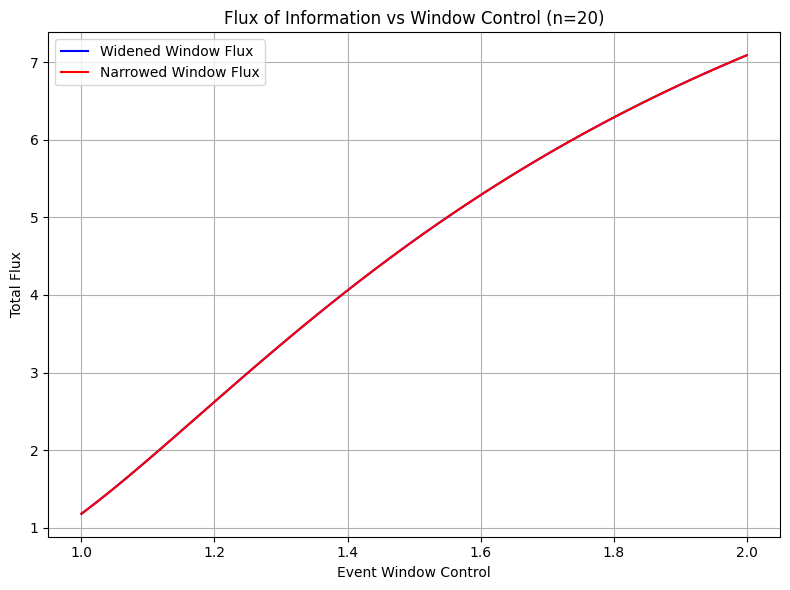

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.02  # Decay rate
n_steps = 100  # Number of steps for simulating the passage of time
n = 20  # Event path length for this single path scenario
N_max = 50  # Maximum path length in the future (for simulation)

# Create figure for plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Define the event window operations (widening or narrowing)
widen_factor = np.linspace(1, 2, n_steps)  # Factor for widening window over time
narrow_factor = np.linspace(2, 1, n_steps)  # Factor for narrowing window over time

# Compute the total flux for both widening and narrowing window scenarios
total_flux_widen = np.zeros(n_steps)
total_flux_narrow = np.zeros(n_steps)

# Loop to compute the flux for widening the window (adding more events)
for step in range(n_steps):
    N_i = N_max * widen_factor[step]  # Increasing number of events in the window
    # Sum of decaying oscillations from the future
    total_flux_widen[step] = np.sum(np.exp(-gamma * np.linspace(0, n * np.pi, n)) * np.cos(np.pi * np.linspace(0, n * np.pi, n) / N_i))

# Loop to compute the flux for narrowing the window (removing events)
for step in range(n_steps):
    N_i = N_max * narrow_factor[step]  # Decreasing number of events in the window
    # Sum of decaying oscillations from the future
    total_flux_narrow[step] = np.sum(np.exp(-gamma * np.linspace(0, n * np.pi, n)) * np.cos(np.pi * np.linspace(0, n * np.pi, n) / N_i))

# Plot the widening and narrowing flux operations
ax.plot(widen_factor, total_flux_widen, label=f'Widened Window Flux', color="blue")
ax.plot(narrow_factor, total_flux_narrow, label=f'Narrowed Window Flux', color="red")
ax.set_title(f'Flux of Information vs Window Control (n={n})')
ax.set_ylabel('Total Flux')
ax.set_xlabel('Event Window Control')
ax.grid(True)
ax.legend()

plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()


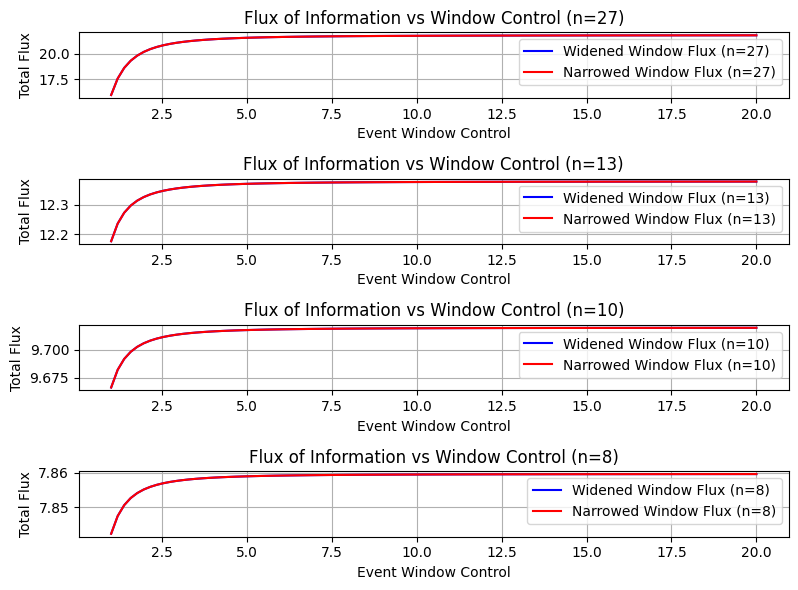

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.02  # Decay rate
n_steps = 100  # Number of steps for simulating the passage of time
initial_n_values = [27, 13, 10, 8]  # Initial n values for different event path lengths
N_max = 50  # Maximum path length in the future (for simulation)

# Create subplots for each operation on the event selection window
fig, axes = plt.subplots(len(initial_n_values), 1, figsize=(8, 6))

# Loop through each initial n value and plot the control operation effects
for i, n in enumerate(initial_n_values):
    # Initialize the event window and flux
    x_values = np.linspace(0, n * np.pi, n_steps)  # x-values from 0 to n*pi

    # Define the event window operations (narrowing or widening)
    widen_factor = np.linspace(1, 20, n_steps)  # Factor for widening window over time
    narrow_factor = np.linspace(20, 1, n_steps)  # Factor for narrowing window over time

    # Compute the total flux for both widening and narrowing window scenarios
    total_flux_widen = np.zeros(n_steps)
    total_flux_narrow = np.zeros(n_steps)

    # Loop to compute the flux for widening the window (adding more events)
    for step in range(n_steps):
        N_i = N_max * widen_factor[step]  # Increasing number of events in the window
        # Sum of decaying oscillations from the future
        total_flux_widen[step] = np.sum(np.exp(-gamma * x_values[:n]) * np.cos(np.pi * x_values[:n] / N_i))

    # Loop to compute the flux for narrowing the window (removing events)
    for step in range(n_steps):
        N_i = N_max * narrow_factor[step]  # Decreasing number of events in the window
        # Sum of decaying oscillations from the future
        total_flux_narrow[step] = np.sum(np.exp(-gamma * x_values[:n]) * np.cos(np.pi * x_values[:n] / N_i))

    # Plot the widening and narrowing flux operations
    axes[i].plot(widen_factor, total_flux_widen, label=f'Widened Window Flux (n={n})', color="blue")
    axes[i].plot(narrow_factor, total_flux_narrow, label=f'Narrowed Window Flux (n={n})', color="red")
    axes[i].set_title(f'Flux of Information vs Window Control (n={n})')
    axes[i].set_ylabel('Total Flux')
    axes[i].set_xlabel('Event Window Control')
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()



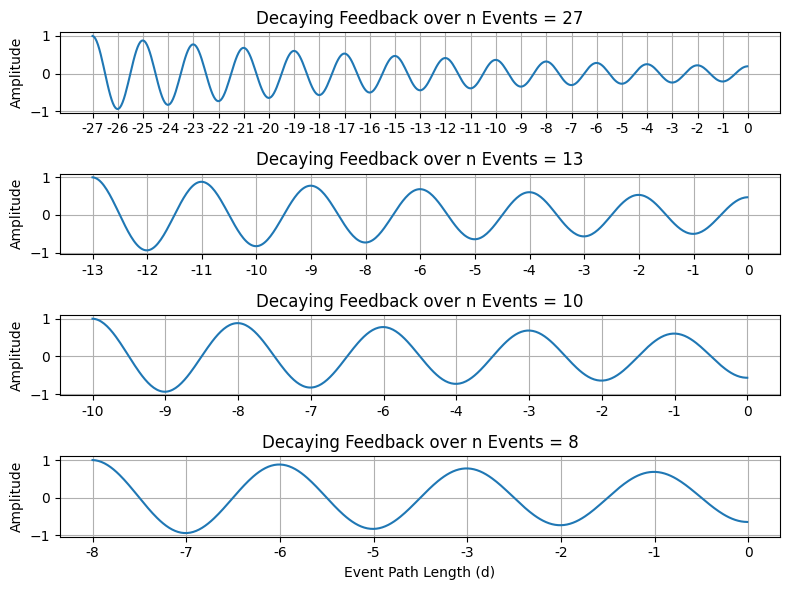

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.02  # Decay rate
n_values = [27, 13, 10, 8]  # Different values of n (number of full cosine cycles)

# Create subplots for each n value
fig, axes = plt.subplots(len(n_values), 1, figsize=(8, 6))

# Loop through each n value and plot on separate strip chart
for i, n in enumerate(n_values):
    d_values = np.linspace(0, n * np.pi, 500)  # d-values from 0 to n*pi

    # Calculate the decaying cosine wave using complex exponential
    decaying_cosine_wave = np.real(np.exp(1j * d_values)) * np.exp(-gamma * d_values)

    # Plot only the first (n-1) cycles
    axes[i].plot(d_values[:int((n-1)*500/n)], decaying_cosine_wave[:int((n-1)*500/n)])
    axes[i].set_title(f'Decaying Feedback over n Events = {n}')
    axes[i].set_ylabel('Amplitude')

    # Adjust the x-axis labels to reflect multiples of pi
    x_ticks = np.linspace(0, (n-1) * np.pi, n)  # x-ticks from 0 to (n-1)*pi
    x_labels = np.round(np.linspace(-n, 0, n)).astype(int)  # Labels as multiples of pi, rounded and converted to integers

    axes[i].set_xticks(x_ticks)  # Set the x-ticks
    axes[i].set_xticklabels([f'{int(label)}' for label in x_labels])  # Set the x-tick labels as integers

    axes[i].grid(True)

# Set x-axis label
plt.xlabel('Event Path Length (d)')
plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()


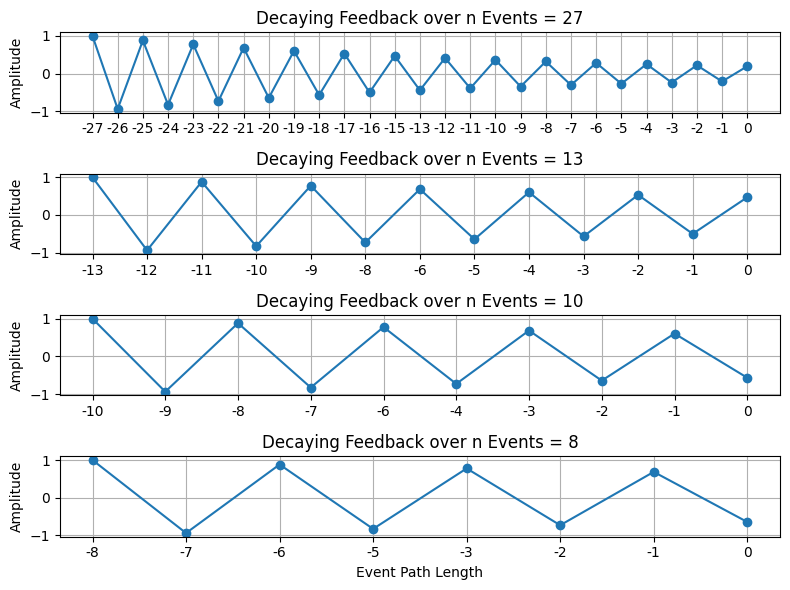

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.02  # Decay rate
n_values = [27, 13, 10, 8]  # Different values of n (number of full cosine cycles)

# Create subplots for each n value
fig, axes = plt.subplots(len(n_values), 1, figsize=(8, 6))

# Loop through each n value and plot on separate strip chart
for i, n in enumerate(n_values):
    # Create an array of length n, where each value corresponds to n*pi, i.e. multiples of pi
    d_values = np.linspace(0, (n-1) * np.pi, n)

    # Calculate the decaying oscillation for each path at the final value (no summation)
    decaying_cosine_wave = np.exp(-gamma * d_values) * np.cos(d_values)  # Decaying exponential with cosine oscillation

    # Plot the result as discrete values
    axes[i].plot(d_values, decaying_cosine_wave, marker='o', label=f'n={n}')
    axes[i].set_title(f'Decaying Feedback over n Events = {n}')
    axes[i].set_ylabel('Amplitude')

    # Adjust the x-axis labels to reflect multiples of pi
    x_ticks = np.linspace(0, (n-1) * np.pi, n)  # x-ticks from 0 to (n-1)*pi
    x_labels = np.round(np.linspace(-n, 0, n)).astype(int)  # Labels as multiples of pi, rounded and converted to integers

    axes[i].set_xticks(x_ticks)  # Set the x-ticks
    axes[i].set_xticklabels([f'{int(label)}' for label in x_labels])  # Set the x-tick labels as integers

    axes[i].grid(True)

# Set x-axis label
plt.xlabel('Event Path Length')
plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()


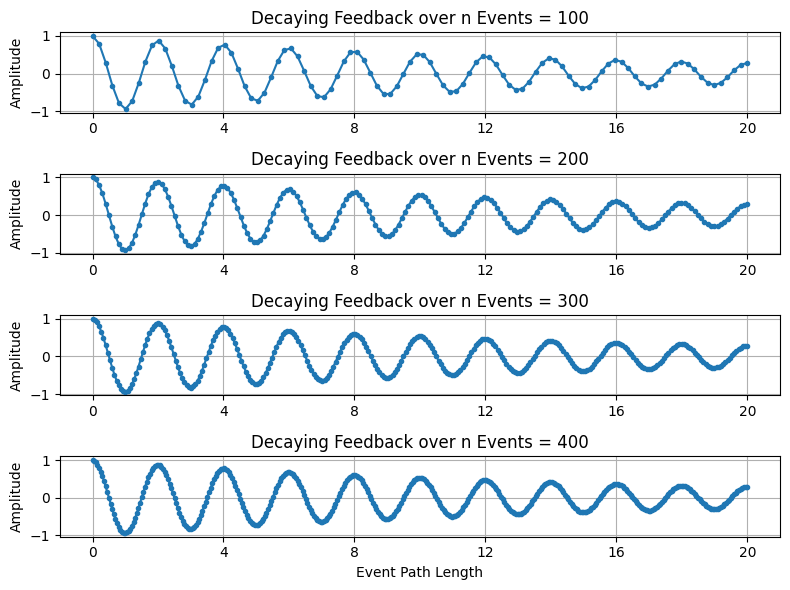

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.02  # Decay rate
n_values = [100, 200, 300, 400]  # Larger values of n (more cycles)
max_path_length = 20  # Larger path length for smoother oscillations

# Create subplots for each n value
fig, axes = plt.subplots(len(n_values), 1, figsize=(8, 6))

# Loop through each n value and plot on separate strip chart
for i, n in enumerate(n_values):
    # Create an array of length n, where each value corresponds to n*pi, i.e. multiples of pi
    d_values = np.linspace(0, max_path_length * np.pi, n)  # Increase path length for more steps

    # Calculate the decaying oscillation for each path at the final value (no summation)
    decaying_cosine_wave = np.exp(-gamma * d_values) * np.cos(d_values)  # Decaying exponential with cosine oscillation

    # Plot the result as discrete values
    axes[i].plot(d_values, decaying_cosine_wave, marker='o', markersize=3, label=f'n={n}')
    axes[i].set_title(f'Decaying Feedback over n Events = {n}')
    axes[i].set_ylabel('Amplitude')

    # Adjust the x-axis labels to reflect multiples of pi
    x_ticks = np.linspace(0, max_path_length * np.pi, 6)  # x-ticks from 0 to max_path_length*pi
    x_labels = np.round(np.linspace(0, max_path_length, 6)).astype(int)  # Labels as multiples of pi, rounded and converted to integers

    axes[i].set_xticks(x_ticks)  # Set the x-ticks
    axes[i].set_xticklabels([f'{int(label)}' for label in x_labels])  # Set the x-tick labels as integers

    axes[i].grid(True)

# Set x-axis label
plt.xlabel('Event Path Length')
plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()


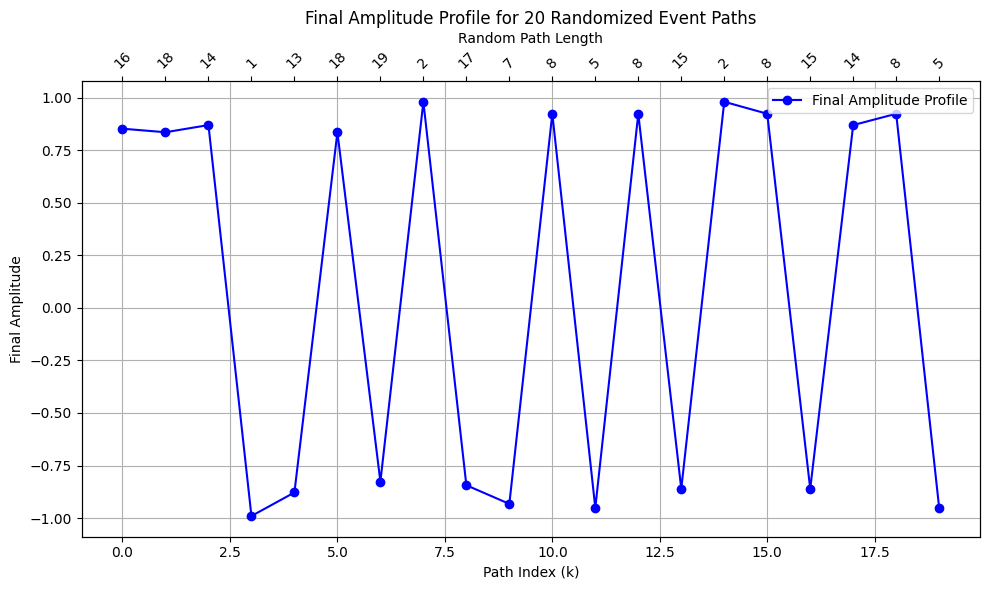

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.01  # Decay rate
k = 20  # Number of paths to generate

# Initialize lists to hold the final amplitude and the corresponding path lengths
final_amplitudes = []
path_lengths = []

# Loop over the k paths
for i in range(k):
    # Random path length for each path (between 1 and 100)
    n_k = np.random.randint(1, 20)
    # Calculate the oscillation for this path at the final value (no summation)
    final_amplitude = np.exp(-gamma * n_k) * np.cos(np.pi * n_k)
    # Store the final amplitude for this path and its path length
    final_amplitudes.append(final_amplitude)
    path_lengths.append(n_k)

# Plot the final amplitudes for each path
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(range(k), final_amplitudes, marker='o', color='b', label="Final Amplitude Profile")
ax1.set_title(f"Final Amplitude Profile for {k} Randomized Event Paths")
ax1.set_xlabel("Path Index (k)")
ax1.set_ylabel("Final Amplitude")
ax1.grid(True)
ax1.legend()

# Create a second x-axis to display the randomly selected path length for each path
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())  # Make sure both x-axes share the same range
ax2.set_xticks(range(k))
ax2.set_xticklabels(path_lengths)  # Show the path lengths at each point

# Rotate the labels on the top axis
ax2.set_xlabel("Random Path Length")
ax2.tick_params(axis='x', rotation=45)  # Rotate the labels by 45 degrees

plt.tight_layout()
plt.show()



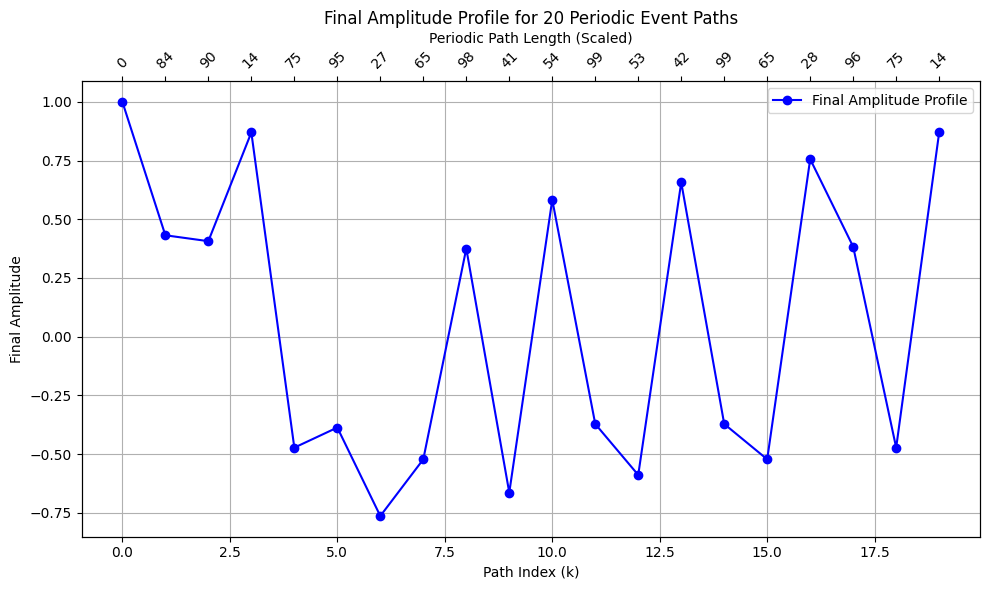

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.01  # Decay rate
k = 20  # Number of paths to generate
n_steps = 100  # Number of steps (discretized space)
n_values = np.arange(0, n_steps)  # Event index (n)
max_path_length = 100  # Maximum path length

# Initialize lists to hold the final amplitude and the corresponding path lengths
final_amplitudes = []
path_lengths = []

# Generate periodic path lengths
periodic_path_lengths = np.array([int(np.abs(np.sin(i) * max_path_length)) for i in range(k)])

# Loop over the k paths to simulate feedback at different periodic path lengths
for i in range(k):
    n_k = periodic_path_lengths[i]
    # Calculate the final amplitude for this path
    #final_amplitude = np.exp(-gamma * n_k) * np.cos(np.pi * n_k / n_k)  # The value at the final step
    final_amplitude = np.exp(-gamma * n_k) * np.cos(np.pi * n_k)  # The value at the final step
    final_amplitudes.append(final_amplitude)
    path_lengths.append(n_k)

# Plot the final amplitudes for each path
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(range(k), final_amplitudes, marker='o', color='b', label="Final Amplitude Profile")
ax1.set_title(f"Final Amplitude Profile for {k} Periodic Event Paths")
ax1.set_xlabel("Path Index (k)")
ax1.set_ylabel("Final Amplitude")
ax1.grid(True)
ax1.legend()

# Create a second x-axis to display the periodically selected path lengths for each path
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())  # Make sure both x-axes share the same range
ax2.set_xticks(range(k))
ax2.set_xticklabels(path_lengths)  # Show the path lengths at each point

# Rotate the labels on the top axis
ax2.set_xlabel("Periodic Path Length (Scaled)")
ax2.tick_params(axis='x', rotation=45)  # Rotate the labels by 45 degrees

plt.tight_layout()
plt.show()


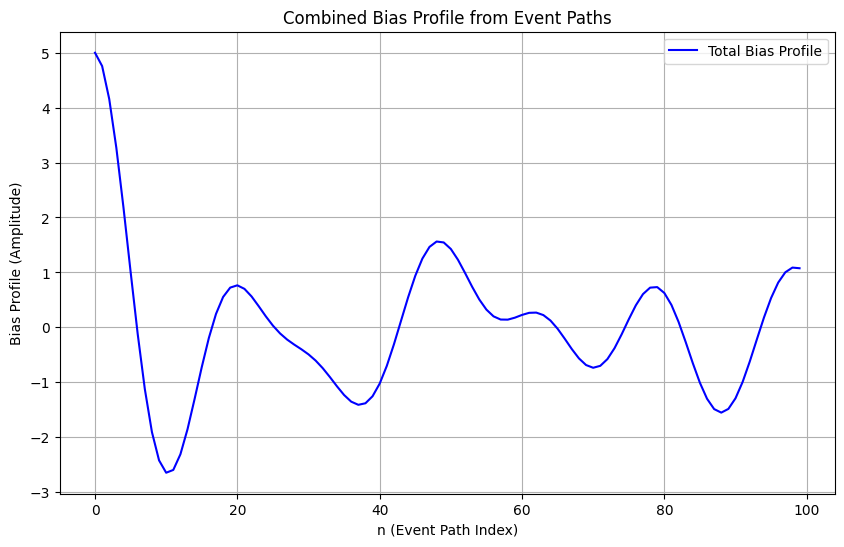

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.01  # Decay rate
n_steps = 100  # Number of steps (discretized space)
n_values = np.arange(0, n_steps)  # Event index (n)

# Number of event paths
k = 5

# Event path lengths (N_i for each event path)
N_values = [27, 13, 10, 8, 12]

# Calculate the bias profile (sum of oscillations)
bias_profile = np.zeros(n_steps)

for i in range(k):
    N_i = N_values[i]
    # Oscillation for each event path, with decay
    bias_profile += np.exp(-gamma * n_values) * np.cos(np.pi * n_values / N_i)

# Plot the resulting bias profile
plt.figure(figsize=(10, 6))
plt.plot(n_values, bias_profile, label="Total Bias Profile", color="blue")
plt.title("Combined Bias Profile from Event Paths")
plt.xlabel("n (Event Path Index)")
plt.ylabel("Bias Profile (Amplitude)")
plt.grid(True)
plt.legend()
plt.show()


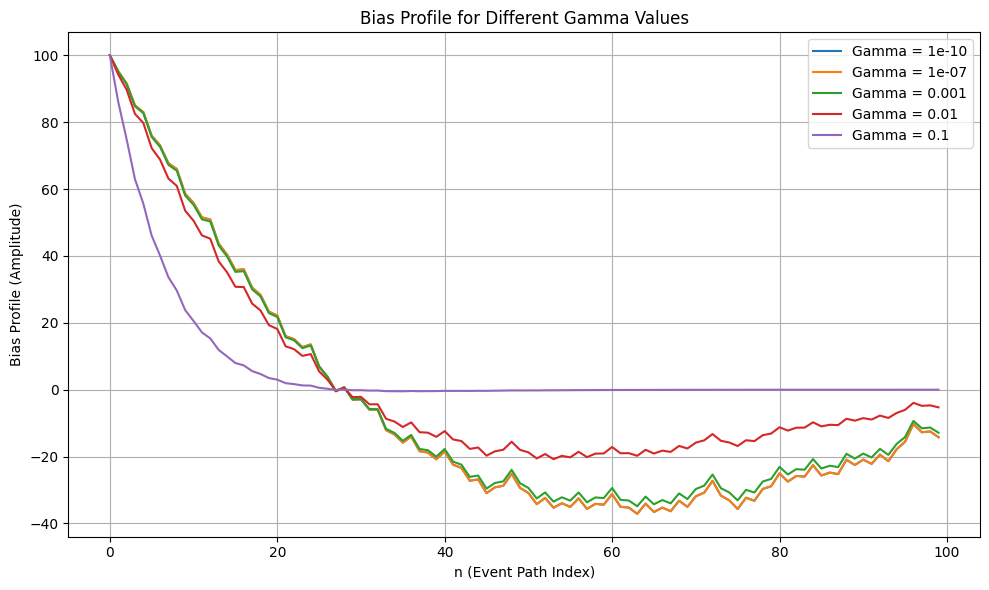

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_steps = 100  # Number of steps (discretized space)
n_values = np.arange(0, n_steps)  # Event index (n)
gamma_values = [1e-10, 1e-7, 0.001, 0.01, 0.1]  # Different decay rates
#gamma_values = [1e-20, 1e-7, 0.1]  # Different decay rates
max_N = 100  # Maximum path length for event paths

# Create a figure for the combined plot
plt.figure(figsize=(10, 6))

# Iterate over different gamma values
for gamma in gamma_values:
    # Initialize the bias profile
    bias_profile = np.zeros(n_steps)

    # Loop over the range of N (event path lengths)
    for N_i in range(1, max_N + 1):
        # Oscillation for each event path, with decay
        bias_profile += np.exp(-gamma * n_values) * np.cos(np.pi * n_values / N_i)

    # Plot the bias profile for this gamma value
    plt.plot(n_values, bias_profile, label=f"Gamma = {gamma}")

plt.title("Bias Profile for Different Gamma Values")
plt.xlabel("n (Event Path Index)")
plt.ylabel("Bias Profile (Amplitude)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


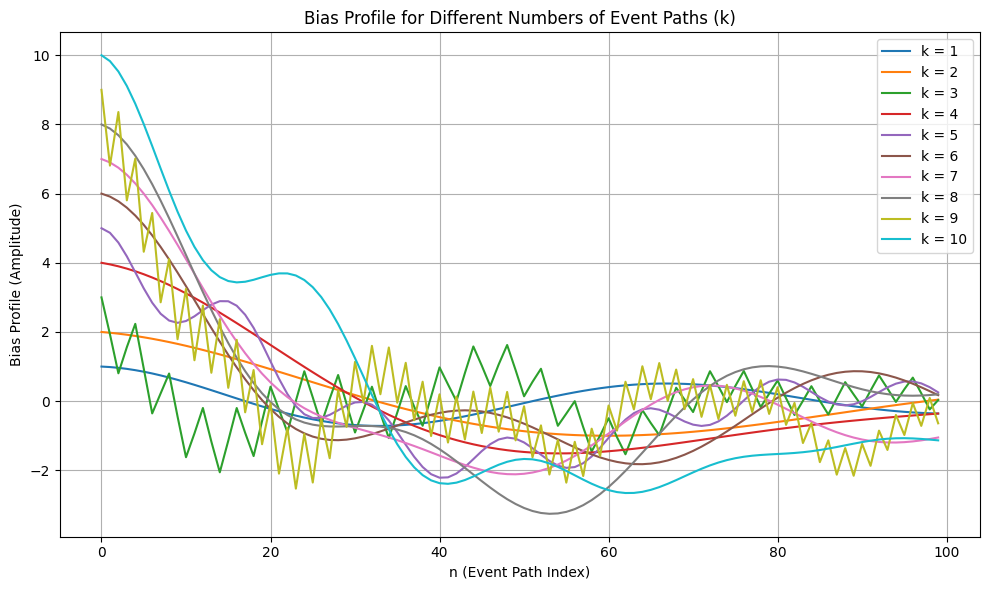

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_steps = 100  # Number of steps (discretized space)
n_values = np.arange(0, n_steps)  # Event index (n)
gamma_values = [0.001, 0.01, 0.1]  # Different decay rates
max_k = 10  # Maximum number of paths to sum over

# Create a plot for bias profile as a function of k
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over different values of k (number of paths)
for k in range(1, max_k + 1):
    bias_profile = np.zeros(n_steps)

    # For each path, assign a random length n and calculate the bias
    for i in range(k):
        n_i = np.random.randint(1, n_steps)  # Random path length for each path
        bias_profile += np.exp(-gamma_values[1] * n_values) * np.cos(np.pi * n_values / n_i)

    ax.plot(n_values, bias_profile, label=f'k = {k}')

ax.set_title("Bias Profile for Different Numbers of Event Paths (k)")
ax.set_xlabel("n (Event Path Index)")
ax.set_ylabel("Bias Profile (Amplitude)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


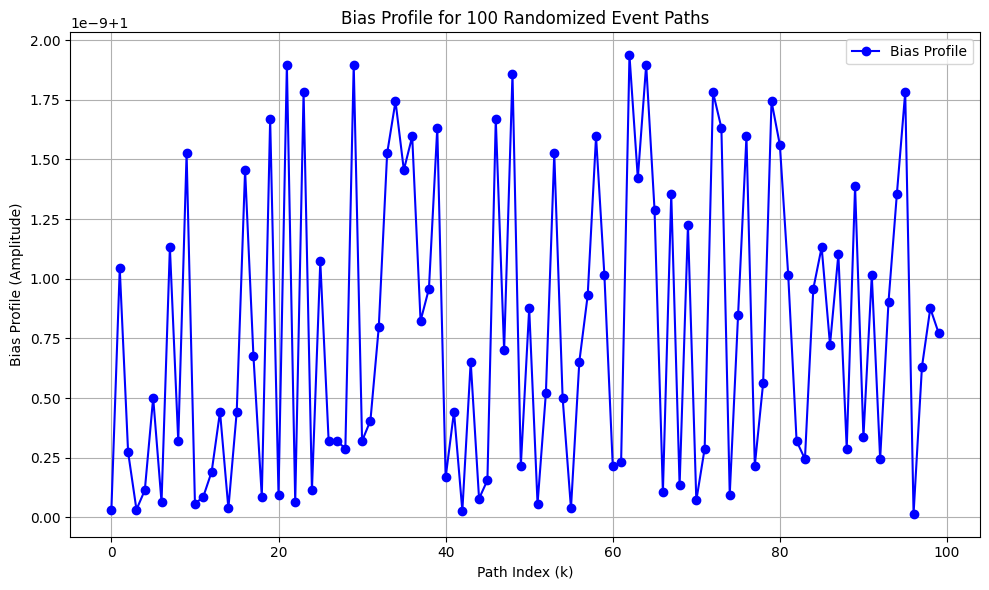

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_steps = 100  # Number of steps (discretized space)
gamma = 1e-12  # Decay rate
k = 100  # Number of paths to sum over (different path indices)

# Initialize a list to hold the bias values for each path
bias_values = []

# Loop over the k paths
for i in range(k):
    # Random path length for each path
    n_i = np.random.randint(10, n_steps)  # Random path length between 10 and n_steps
    # Calculate the oscillation for this particular path (sum over the path length)
    bias_value = np.sum(np.exp(-gamma * np.arange(n_i)) * np.cos(np.pi * np.arange(n_i) / n_i))
    # Store the total bias value for this path
    bias_values.append(bias_value)

# Plot the bias values for each path
plt.figure(figsize=(10, 6))

plt.plot(range(k), bias_values, marker='o', color='b', label="Bias Profile")
plt.title(f"Bias Profile for {k} Randomized Event Paths")
plt.xlabel("Path Index (k)")
plt.ylabel("Bias Profile (Amplitude)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


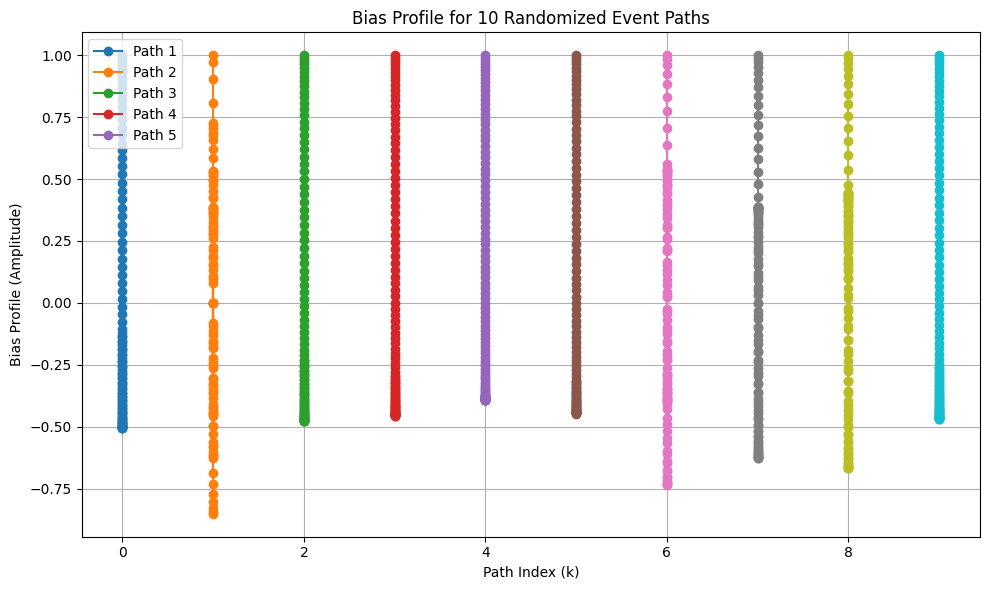

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_steps = 100  # Number of steps (discretized space)
gamma = 0.01  # Decay rate
k = 10  # Number of paths to sum over (different path indices)

# Initialize a list to hold the bias for each path
bias_profiles = []

# Loop over the k paths
for i in range(k):
    # Random path length for each path
    n_i = np.random.randint(10, n_steps)  # Random path length between 10 and n_steps
    # Calculate the oscillation for this particular path
    bias_profile = np.exp(-gamma * n_values) * np.cos(np.pi * n_values / n_i)
    # Store the bias profile for this path
    bias_profiles.append(bias_profile)

# Plot the bias profiles for each path
plt.figure(figsize=(10, 6))

for i in range(k):
    plt.plot(np.full_like(n_values, i), bias_profiles[i], label=f'Path {i+1}' if i < 5 else "", marker="o")  # Plot path index vs bias profile

plt.title(f"Bias Profile for {k} Randomized Event Paths")
plt.xlabel("Path Index (k)")
plt.ylabel("Bias Profile (Amplitude)")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


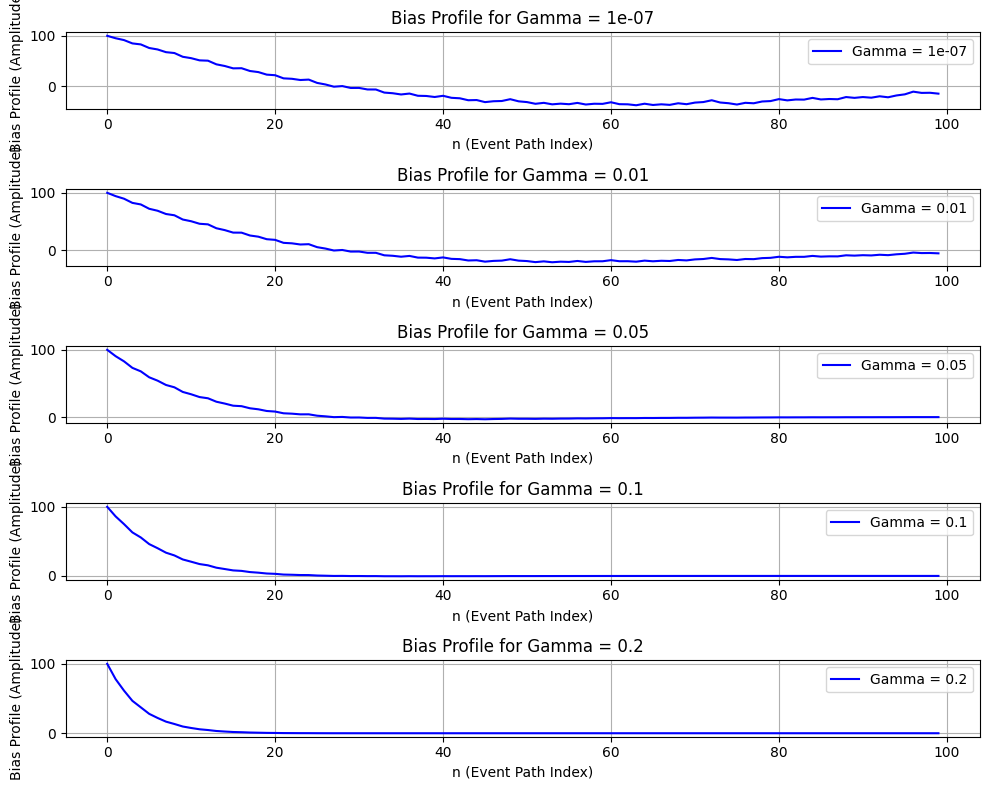

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_steps = 100  # Number of steps (discretized space)
n_values = np.arange(0, n_steps)  # Event index (n)
gamma_values = [0.0000001, 0.01, 0.05, 0.1, 0.2]  # Different decay rates
max_N = 100  # Maximum path length for event paths

# Create subplots for each gamma value
fig, axes = plt.subplots(len(gamma_values), 1, figsize=(10, 8))

# Iterate over different gamma values
for idx, gamma in enumerate(gamma_values):
    # Initialize the bias profile
    bias_profile = np.zeros(n_steps)

    # Loop over the range of N (event path lengths)
    for N_i in range(1, max_N + 1):
        # Oscillation for each event path, with decay
        bias_profile += np.exp(-gamma * n_values) * np.cos(np.pi * n_values / N_i)

    # Plot the bias profile for this gamma value
    axes[idx].plot(n_values, bias_profile, label=f"Gamma = {gamma}", color="blue")
    axes[idx].set_title(f"Bias Profile for Gamma = {gamma}")
    axes[idx].set_xlabel("n (Event Path Index)")
    axes[idx].set_ylabel("Bias Profile (Amplitude)")
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.show()


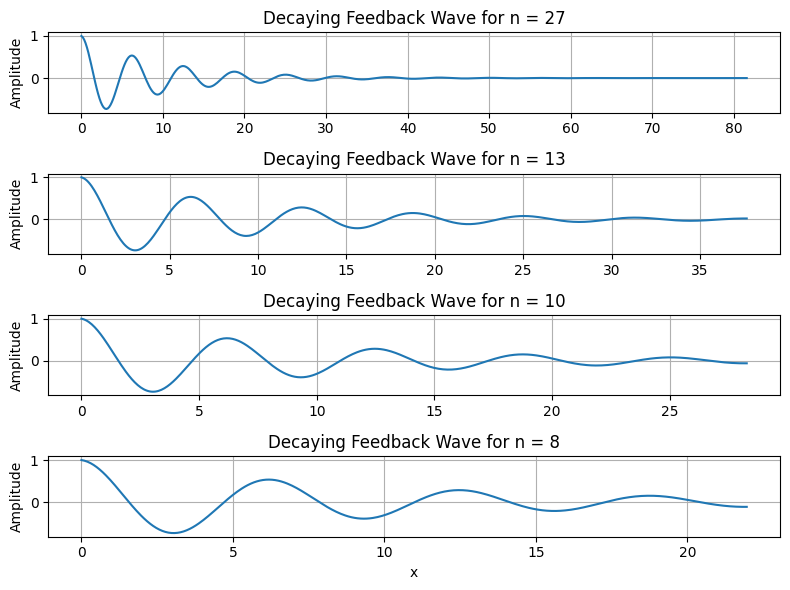

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.1  # Decay rate
n_values = [27, 13, 10, 8]  # Different values of n (number of full cosine cycles)

# Create subplots for each n value
fig, axes = plt.subplots(len(n_values), 1, figsize=(8, 6))

# Loop through each n value and plot on separate strip chart
for i, n in enumerate(n_values):
    x_values = np.linspace(0, n * np.pi, 500)  # x-values from 0 to n*pi

    # Calculate the decaying cosine wave using complex exponential
    decaying_cosine_wave = np.real(np.exp(1j * x_values)) * np.exp(-gamma * x_values)

    # Plot only the first (n-1) cycles
    axes[i].plot(x_values[:int((n-1)*500/n)], decaying_cosine_wave[:int((n-1)*500/n)])
    axes[i].set_title(f'Decaying Feedback Wave for n = {n}')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

# Set x-axis label
plt.xlabel('x')
plt.tight_layout()  # Adjust subplots to fit within the figure area
plt.show()


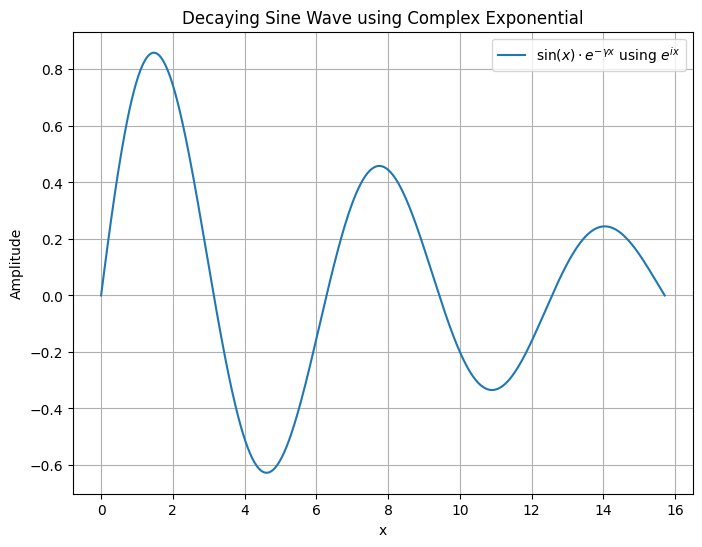

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 5  # Number of full sine wave cycles (e.g., 5*pi)
gamma = 0.1  # Decay rate
x_values = np.linspace(0, n * np.pi, 500)  # x-values from 0 to n*pi

# Using the complex exponential form of the sine wave with decay:
# sin(x) = Im(e^(ix)) and decay = e^(-gamma * x)
decaying_sine_wave = np.imag(np.exp(1j * x_values)) * np.exp(-gamma * x_values)

# Plot the decaying sine wave
plt.figure(figsize=(8, 6))
plt.plot(x_values, decaying_sine_wave, label=r'$\sin(x) \cdot e^{-\gamma x}$ using $e^{ix}$')
plt.title('Decaying Sine Wave using Complex Exponential')
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


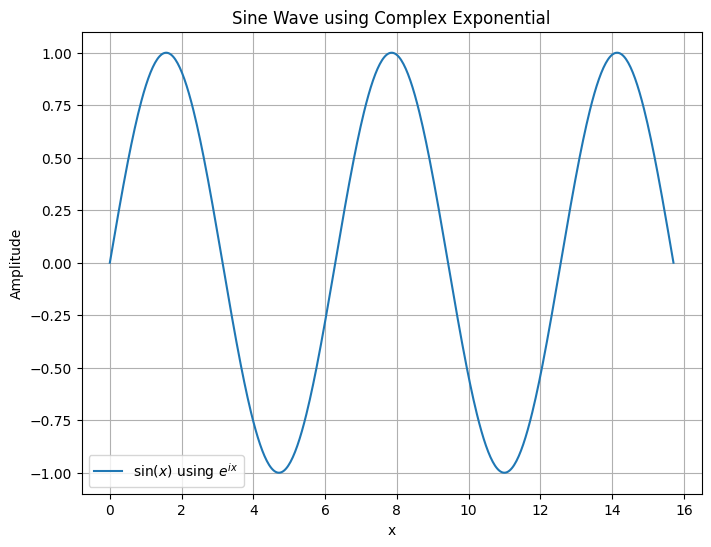

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 5  # Number of full sine wave cycles (e.g., 5*pi)
x_values = np.linspace(0, n * np.pi, 500)  # x-values from 0 to n*pi

# Using the complex exponential form of the sine wave: sin(x) = Im(e^(ix))
sine_wave = np.imag(np.exp(1j * x_values))

# Plot the sine wave
plt.figure(figsize=(8, 6))
plt.plot(x_values, sine_wave, label=r'$\sin(x)$ using $e^{ix}$')
plt.title('Sine Wave using Complex Exponential')
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


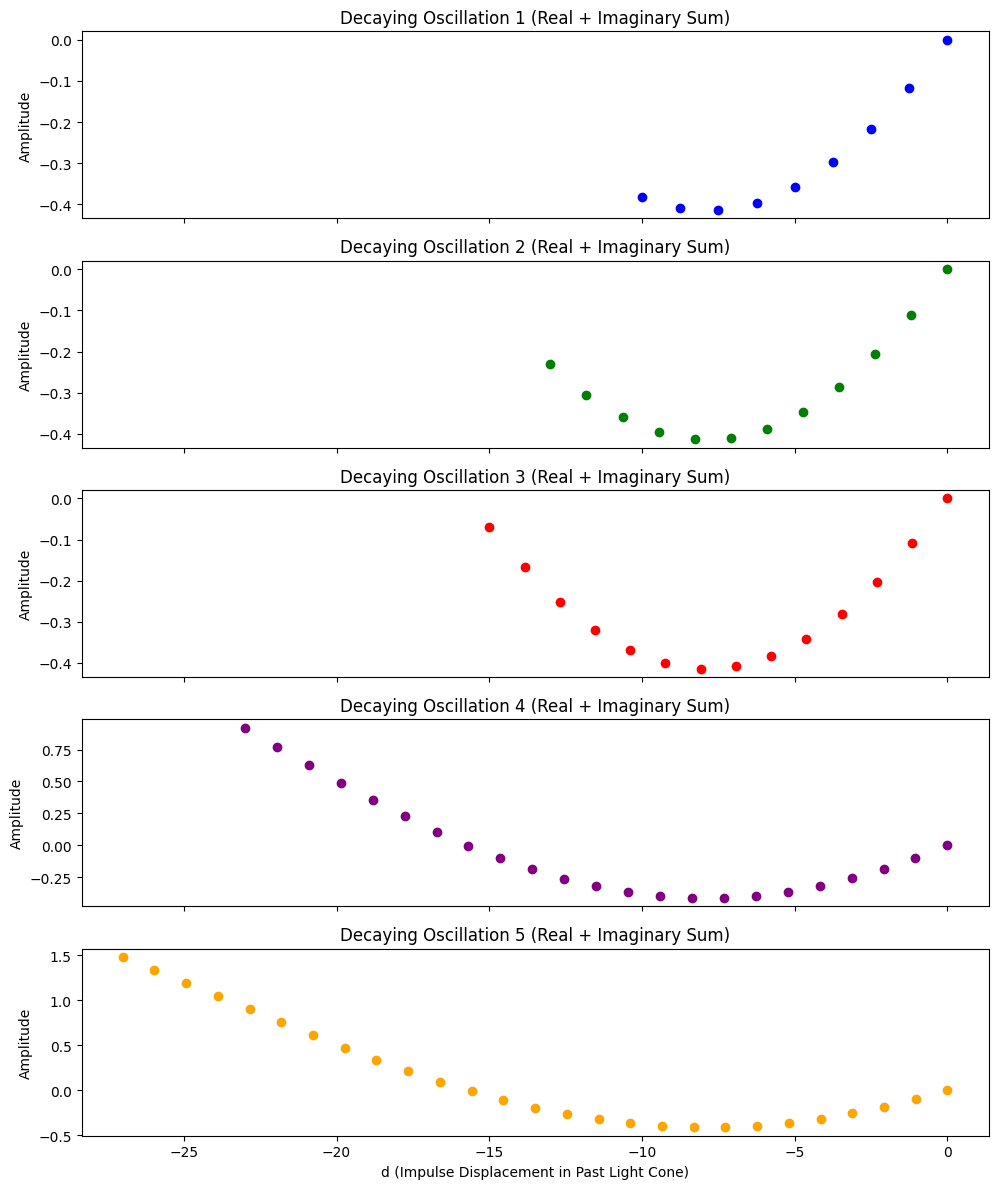

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.1  # Decay rate

# Define different d-values for each path (number of events varies per path)
d_values_1 = np.linspace(-10, 0, 9)  # Range of d values
d_values_2 = np.linspace(-13, 0, 12)  # Range of d values
d_values_3 = np.linspace(-15, 0, 14)  # Range of d values
d_values_4 = np.linspace(-23, 0, 23)  # Range of d values
d_values_5 = np.linspace(-27, 0, 27)  # Range of d values

# Calculate the decaying oscillation for different starting points (different phases and d ranges)
# Modified equation: 1 - e^(i * gamma * d)
decaying_oscillation_1 = 1 - np.exp(1j * gamma * -d_values_1)  # First oscillation
decaying_oscillation_2 = 1 - np.exp(1j * gamma * -d_values_2)  # Second oscillation
decaying_oscillation_3 = 1 - np.exp(1j * gamma * -d_values_3)  # Third oscillation
decaying_oscillation_4 = 1 - np.exp(1j * gamma * -d_values_4)  # Fourth oscillation
decaying_oscillation_5 = 1 - np.exp(1j * gamma * -d_values_5)  # Fifth oscillation

# Sum the real and imaginary parts to get the total oscillation
total_oscillation_1 = np.real(decaying_oscillation_1) + np.imag(decaying_oscillation_1)
total_oscillation_2 = np.real(decaying_oscillation_2) + np.imag(decaying_oscillation_2)
total_oscillation_3 = np.real(decaying_oscillation_3) + np.imag(decaying_oscillation_3)
total_oscillation_4 = np.real(decaying_oscillation_4) + np.imag(decaying_oscillation_4)
total_oscillation_5 = np.real(decaying_oscillation_5) + np.imag(decaying_oscillation_5)

# Create the plots
fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# Plot each oscillation in a separate subplot
axs[0].scatter(d_values_1, total_oscillation_1, color='blue')
axs[0].set_title("Decaying Oscillation 1 (Real + Imaginary Sum)")
axs[0].set_ylabel("Amplitude")

axs[1].scatter(d_values_2, total_oscillation_2, color='green')
axs[1].set_title("Decaying Oscillation 2 (Real + Imaginary Sum)")
axs[1].set_ylabel("Amplitude")

axs[2].scatter(d_values_3, total_oscillation_3, color='red')
axs[2].set_title("Decaying Oscillation 3 (Real + Imaginary Sum)")
axs[2].set_ylabel("Amplitude")

axs[3].scatter(d_values_4, total_oscillation_4, color='purple')
axs[3].set_title("Decaying Oscillation 4 (Real + Imaginary Sum)")
axs[3].set_ylabel("Amplitude")

axs[4].scatter(d_values_5, total_oscillation_5, color='orange')
axs[4].set_title("Decaying Oscillation 5 (Real + Imaginary Sum)")
axs[4].set_xlabel("d (Impulse Displacement in Past Light Cone)")
axs[4].set_ylabel("Amplitude")

# Display the plot
plt.tight_layout()
plt.show()


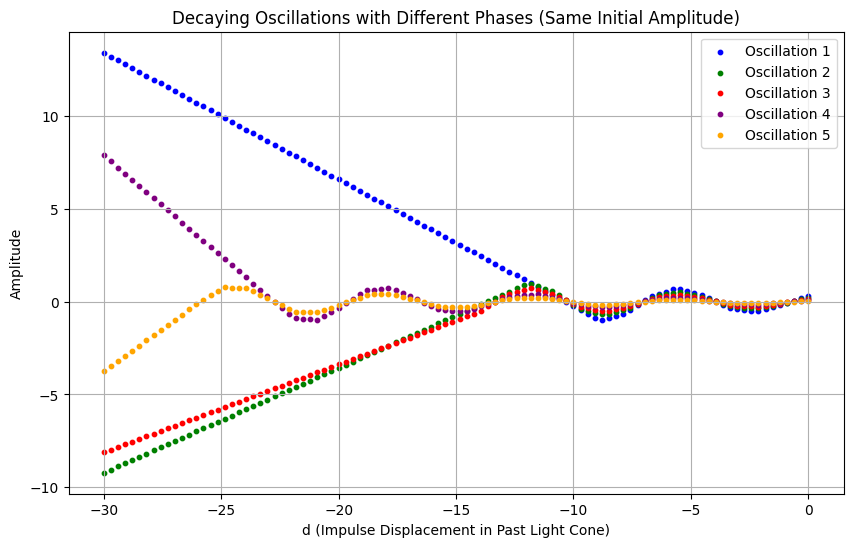

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Parameters
gamma = 0.1  # Decay rate

# Define different d-values for each path (number of events varies per path)
d_values_1 = np.linspace(-10, 0, 10)  # Range of d values
d_values_2 = np.linspace(-13, 0, 13)  # Range of d values
d_values_3 = np.linspace(-15, 0, 15)  # Range of d values
d_values_4 = np.linspace(-23, 0, 23)  # Range of d values
d_values_5 = np.linspace(-27, 0, 27)  # Range of d values

# Calculate the decaying oscillation for different starting points (different phases and d ranges)
decaying_oscillation_1 = np.exp(1j * 1 * d_values_1 - gamma * d_values_1)  # First oscillation
decaying_oscillation_2 = np.exp(1j * 1 * d_values_2 - gamma * d_values_2)  # Second oscillation
decaying_oscillation_3 = np.exp(1j * 1 * d_values_3 - gamma * d_values_3)  # Third oscillation
decaying_oscillation_4 = np.exp(1j * 1 * d_values_4 - gamma * d_values_4)  # Fourth oscillation
decaying_oscillation_5 = np.exp(1j * 1 * d_values_5 - gamma * d_values_5)  # Fifth oscillation

# Sum the real and imaginary parts to get the total oscillation
total_oscillation_1 = np.real(decaying_oscillation_1) + np.imag(decaying_oscillation_1)
total_oscillation_2 = np.real(decaying_oscillation_2) + np.imag(decaying_oscillation_2)
total_oscillation_3 = np.real(decaying_oscillation_3) + np.imag(decaying_oscillation_3)
total_oscillation_4 = np.real(decaying_oscillation_4) + np.imag(decaying_oscillation_4)
total_oscillation_5 = np.real(decaying_oscillation_5) + np.imag(decaying_oscillation_5)

# Normalize each oscillation to start with amplitude 1
total_oscillation_1 /= np.max(np.abs(total_oscillation_1))
total_oscillation_2 /= np.max(np.abs(total_oscillation_2))
total_oscillation_3 /= np.max(np.abs(total_oscillation_3))
total_oscillation_4 /= np.max(np.abs(total_oscillation_4))
total_oscillation_5 /= np.max(np.abs(total_oscillation_5))

# Re-scale the total oscillations to match the longest sequence of events
common_d = np.linspace(-30, 0, 100)

# Interpolate each oscillation to a common d range for comparison
interp_oscillation_1 = interp1d(d_values_1, total_oscillation_1, kind='linear', fill_value="extrapolate")
interp_oscillation_2 = interp1d(d_values_2, total_oscillation_2, kind='linear', fill_value="extrapolate")
interp_oscillation_3 = interp1d(d_values_3, total_oscillation_3, kind='linear', fill_value="extrapolate")
interp_oscillation_4 = interp1d(d_values_4, total_oscillation_4, kind='linear', fill_value="extrapolate")
interp_oscillation_5 = interp1d(d_values_5, total_oscillation_5, kind='linear', fill_value="extrapolate")

# Generate interpolated oscillations for common d
total_oscillation_1_common = interp_oscillation_1(common_d)
total_oscillation_2_common = interp_oscillation_2(common_d)
total_oscillation_3_common = interp_oscillation_3(common_d)
total_oscillation_4_common = interp_oscillation_4(common_d)
total_oscillation_5_common = interp_oscillation_5(common_d)

# Plot the total oscillation as scatter plot
plt.figure(figsize=(10, 6))

plt.scatter(common_d, total_oscillation_1_common, label="Oscillation 1", color="blue", s=10)
plt.scatter(common_d, total_oscillation_2_common, label="Oscillation 2", color="green", s=10)
plt.scatter(common_d, total_oscillation_3_common, label="Oscillation 3", color="red", s=10)
plt.scatter(common_d, total_oscillation_4_common, label="Oscillation 4", color="purple", s=10)
plt.scatter(common_d, total_oscillation_5_common, label="Oscillation 5", color="orange", s=10)

plt.title("Decaying Oscillations with Different Phases (Same Initial Amplitude)")
plt.xlabel("d (Impulse Displacement in Past Light Cone)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


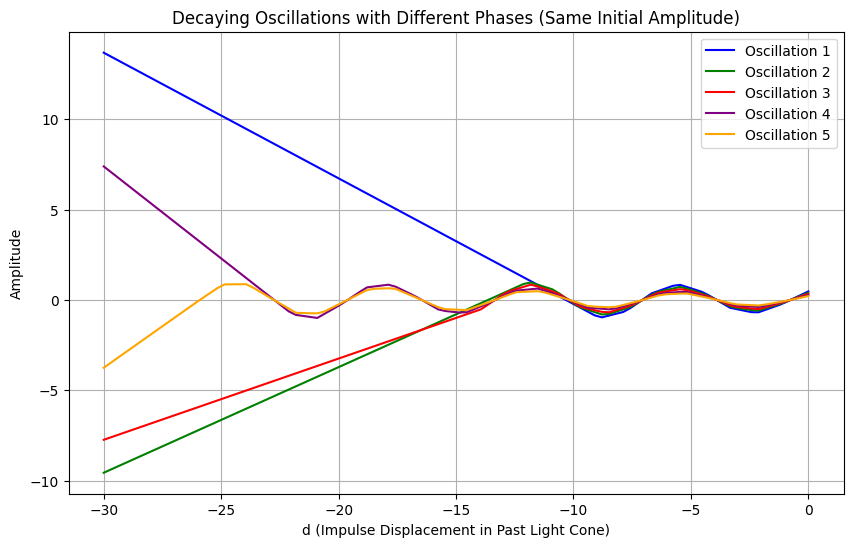

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.05  # Decay rate

# Define different d-values for each path (number of events varies per path)
d_values_1 = np.linspace(-10, 0, 10)  # Range of d values
d_values_2 = np.linspace(-13, 0, 13)  # Range of d values
d_values_3 = np.linspace(-15, 0, 15)  # Range of d values
d_values_4 = np.linspace(-23, 0, 23)  # Range of d values
d_values_5 = np.linspace(-27, 0, 27)  # Range of d values

# Calculate the decaying oscillation for different starting points (different phases and d ranges)
decaying_oscillation_1 = np.exp(1j * 1 * d_values_1 - gamma * d_values_1)  # First oscillation
decaying_oscillation_2 = np.exp(1j * 1 * d_values_2 - gamma * d_values_2)  # Second oscillation
decaying_oscillation_3 = np.exp(1j * 1 * d_values_3 - gamma * d_values_3)  # Third oscillation
decaying_oscillation_4 = np.exp(1j * 1 * d_values_4 - gamma * d_values_4)  # Fourth oscillation
decaying_oscillation_5 = np.exp(1j * 1 * d_values_5 - gamma * d_values_5)  # Fifth oscillation

# Sum the real and imaginary parts to get the total oscillation
total_oscillation_1 = np.real(decaying_oscillation_1) + np.imag(decaying_oscillation_1)
total_oscillation_2 = np.real(decaying_oscillation_2) + np.imag(decaying_oscillation_2)
total_oscillation_3 = np.real(decaying_oscillation_3) + np.imag(decaying_oscillation_3)
total_oscillation_4 = np.real(decaying_oscillation_4) + np.imag(decaying_oscillation_4)
total_oscillation_5 = np.real(decaying_oscillation_5) + np.imag(decaying_oscillation_5)

# Normalize each oscillation to start with amplitude 1
total_oscillation_1 /= np.max(np.abs(total_oscillation_1))
total_oscillation_2 /= np.max(np.abs(total_oscillation_2))
total_oscillation_3 /= np.max(np.abs(total_oscillation_3))
total_oscillation_4 /= np.max(np.abs(total_oscillation_4))
total_oscillation_5 /= np.max(np.abs(total_oscillation_5))

# Re-scale the total oscillations to match the longest sequence of events
common_d = np.linspace(-30, 0, 100)

# Interpolate each oscillation to a common d range for comparison
from scipy.interpolate import interp1d

interp_oscillation_1 = interp1d(d_values_1, total_oscillation_1, kind='linear', fill_value="extrapolate")
interp_oscillation_2 = interp1d(d_values_2, total_oscillation_2, kind='linear', fill_value="extrapolate")
interp_oscillation_3 = interp1d(d_values_3, total_oscillation_3, kind='linear', fill_value="extrapolate")
interp_oscillation_4 = interp1d(d_values_4, total_oscillation_4, kind='linear', fill_value="extrapolate")
interp_oscillation_5 = interp1d(d_values_5, total_oscillation_5, kind='linear', fill_value="extrapolate")

# Generate interpolated oscillations for common d
total_oscillation_1_common = interp_oscillation_1(common_d)
total_oscillation_2_common = interp_oscillation_2(common_d)
total_oscillation_3_common = interp_oscillation_3(common_d)
total_oscillation_4_common = interp_oscillation_4(common_d)
total_oscillation_5_common = interp_oscillation_5(common_d)

# Plot the total oscillation
plt.figure(figsize=(10, 6))

plt.plot(common_d, total_oscillation_1_common, label="Oscillation 1", color="blue")
plt.plot(common_d, total_oscillation_2_common, label="Oscillation 2", color="green")
plt.plot(common_d, total_oscillation_3_common, label="Oscillation 3", color="red")
plt.plot(common_d, total_oscillation_4_common, label="Oscillation 4", color="purple")
plt.plot(common_d, total_oscillation_5_common, label="Oscillation 5", color="orange")

plt.title("Decaying Oscillations with Different Phases (Same Initial Amplitude)")
plt.xlabel("d (Impulse Displacement in Past Light Cone)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


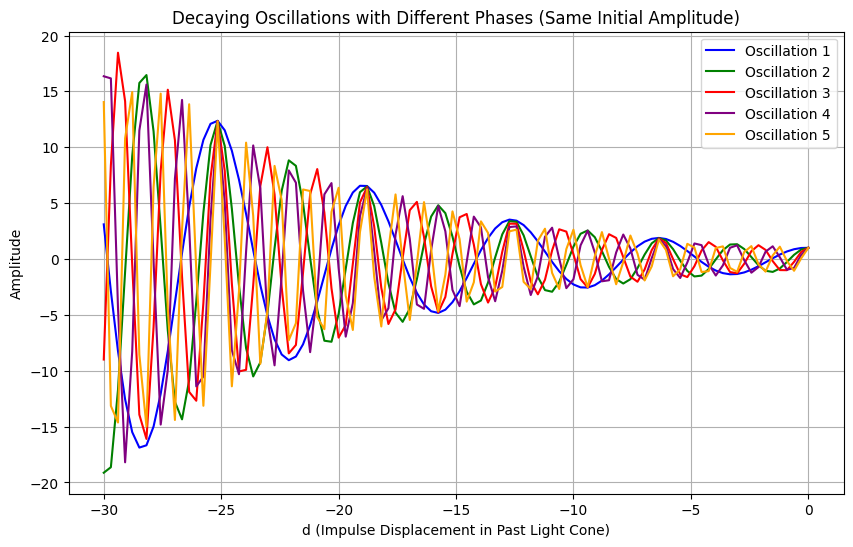

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.1  # Decay rate
common_d = np.linspace(-30, 0, 100)  # Common range for d (to compare all oscillations)

# Calculate the decaying oscillation for different starting points (different phases and d ranges)
decaying_oscillation_1 = np.exp(1j * 1 * common_d - gamma * common_d)  # First oscillation
decaying_oscillation_2 = np.exp(1j * 2 * common_d - gamma * common_d)  # Second oscillation
decaying_oscillation_3 = np.exp(1j * 3 * common_d - gamma * common_d)  # Third oscillation
decaying_oscillation_4 = np.exp(1j * 4 * common_d - gamma * common_d)  # Fourth oscillation
decaying_oscillation_5 = np.exp(1j * 5 * common_d - gamma * common_d)  # Fifth oscillation

# Sum the real parts to get the total oscillation (ignoring the imaginary part)
total_oscillation_1 = np.real(decaying_oscillation_1)
total_oscillation_2 = np.real(decaying_oscillation_2)
total_oscillation_3 = np.real(decaying_oscillation_3)
total_oscillation_4 = np.real(decaying_oscillation_4)
total_oscillation_5 = np.real(decaying_oscillation_5)

# Plot the total oscillation
plt.figure(figsize=(10, 6))

plt.plot(common_d, total_oscillation_1, label="Oscillation 1", color="blue")
plt.plot(common_d, total_oscillation_2, label="Oscillation 2", color="green")
plt.plot(common_d, total_oscillation_3, label="Oscillation 3", color="red")
plt.plot(common_d, total_oscillation_4, label="Oscillation 4", color="purple")
plt.plot(common_d, total_oscillation_5, label="Oscillation 5", color="orange")

plt.title("Decaying Oscillations with Different Phases (Same Initial Amplitude)")
plt.xlabel("d (Impulse Displacement in Past Light Cone)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


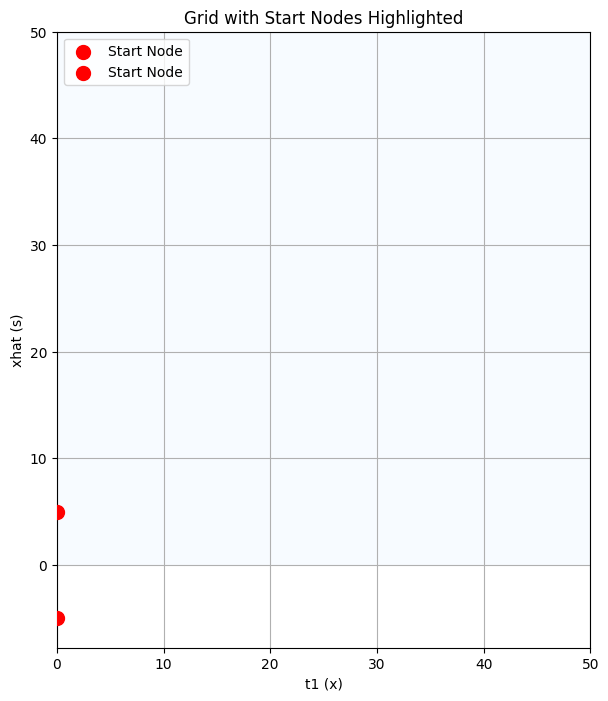

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to construct the grid
def construct_grid(grid_size):
    grid = np.zeros((grid_size, grid_size), dtype=object)
    for i in range(grid_size):
        for j in range(grid_size):
            grid[i, j] = {
                'coord': (i, j),  # Coordinates (unique ID for each node)
                'I1_info': 0,  # Information from I1 (causal)
                'I2_info': 0,  # Information from I2 (non-local)
                'total_info': 1.0  # Initialize total information to a small value (1.0)
            }
    return grid

# Function to map grid indices to visual coordinates
def grid_to_visual_coordinates(i, j, grid_size):
    # Map i to x (t1) and j to y (s)
    x = i
    y = grid_size / 2 - j
    return x, y

# Function to plot the grid and highlight the start nodes
def plot_grid_with_start_nodes(grid, start_nodes, grid_size):
    """
    Plots the existing grid with start nodes highlighted.

    Parameters:
    - grid (2D numpy array): The existing grid with node data.
    - start_nodes (list of tuples): List of start nodes' coordinates.
    - grid_size (int): The size of the grid (NxN).
    """
    # Create a blank grid for plotting
    grid_plot = np.zeros((grid_size, grid_size))

    # Populate the grid plot with the total information for each node
    for i in range(grid_size):
        for j in range(grid_size):
            grid_plot[i, j] = grid[i, j]['total_info']

    # Plot the grid
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_plot, cmap='Blues', extent=[0, grid_size, 0, grid_size], interpolation='nearest')

    # Highlight the start nodes in red
    for node in start_nodes:
        x, y = grid_to_visual_coordinates(node[0], node[1], grid_size)
        plt.scatter(x, y, color='red', label="Start Node", s=100, zorder=5)

    # Add labels and titles
    plt.title("Grid with Start Nodes Highlighted")
    plt.xlabel("t1 (x)")
    plt.ylabel("xhat (s)")
    plt.grid(True)

    # Add a legend
    plt.legend(loc='upper left')

    # Show the plot
    plt.show()

# Example usage:
grid_size = 50  # Set the grid size
# Example start nodes (initial positions on the grid)
start_node_1 = (0, grid_size // 2 - 5)  # Node 1 at t=0, slightly below center
start_node_2 = (0, grid_size // 2 + 5)  # Node 2 at t=0, slightly above center
start_nodes = [start_node_1, start_node_2]

# Construct the grid with the defined size
grid = construct_grid(grid_size)

# Plot the grid with the start nodes highlighted
plot_grid_with_start_nodes(grid, start_nodes, grid_size)
